In [14]:
#!pip install mdptoolbox-hiive

In [398]:
# Begin by importing libraries
import gym
from hiive.mdptoolbox.mdp import PolicyIteration, ValueIteration, QLearning

import numpy as np
import pandas as pd
import seaborn as sns
import time

np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## MDP setup

In [ ]:
arrows, clrs = {0: '←', 1: '↓',2: '→',3: '↑'}, {b'G': 'green', b'F': 'white', b'S': 'blue',b'H': 'k'}

In [404]:
def plot_frozen_lake(env, policy=None, title='Frozen Lake Environment'):
    fig = plt.figure(figsize=(5, 5))
    tiles = env.nrow
    ax = fig.add_subplot(111, xlim=(-.01, tiles+0.01), ylim=(-.01, tiles+0.01))
    plt.title(title, fontsize=14, y=1.01)
    for i in range(tiles):
        for j in range(tiles):
            y, x = tiles - i - 1, j
            p = plt.Rectangle([x, y], 1, 1, linewidth=0.5, edgecolor='k')
            p.set_facecolor(clrs[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.3, y+0.3, 
                               arrows[policy[i, j]],horizontalalignment='center', size=20, verticalalignment='center', color='b')

In [400]:
# code based on https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def generate_score(env, policy, print_info=False, eps=1000):
    misses, spts_lst = 0, []
    for ep in range(eps):
        obs, steps = env.reset(), 0
        while True:
            action = policy[obs]
            obs, reward, complete, _ = env.step(action)
            steps = steps+1
            if reward == 1 and complete:
                spts_lst.append(steps)
                break
            elif reward == 0 and complete:
                misses = misses+ 1
                break
    ave_steps, std_steps, pctt_fail = np.mean(spts_lst), np.std(spts_lst), 100 * (misses/eps)

    return ave_steps, std_steps, pctt_fail

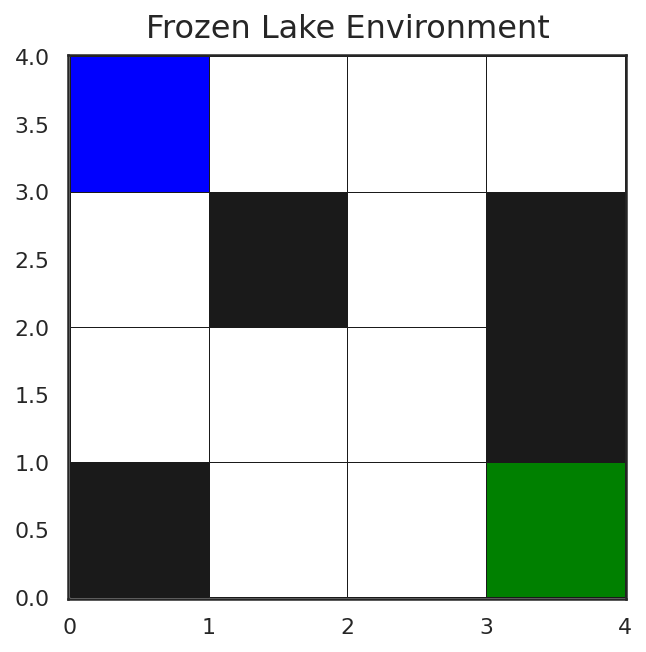

In [402]:
env = gym.make('FrozenLake-v0').unwrapped
env.max_episode_steps=350

rows, cols = env.nrow, env.ncol
T, R = np.zeros((4, rows*cols, rows*cols)), np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env.P:
    for action in env.P[square]:
        for i in range(len(env.P[square][action])):
            new_state = env.P[square][action][i][1]
            if new_state == old_state:
                T[action][square][env.P[square][action][i][1]] = T[action][square][old_state] + env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = R[action][square][old_state] + env.P[square][action][i][2]
            else:
                T[action][square][env.P[square][action][i][1]] = env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = env.P[square][action][i][2]
            old_state = env.P[square][action][i][1]
 
plot_frozen_lake(env)

## VI

In [488]:
def val_iteration(t, r, gammas, epsilons, show_results=False, max_iterations=10000000):
    time_start = time.time()
    df = pd.DataFrame(0.0, index=np.arange(len(gammas)*len(epsilons)),
                        columns=['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_percent', 'policy', 'avg_util', 'max_util', 'error'])
        
    test_num = 0
    for g in gammas:
        for e in epsilons:
            test = ValueIteration(t, r, gamma=g, epsilon=e, max_iter=max_iterations)
            
            runs,Time,iterations,max_reward  = test.run(), runs[-1]['Time'], runs[-1]['Iteration'], uns[-1]['Max V']
            
            max_util, avg_util, ers = [], [], []
            for run in runs:
                ers.append(run['Error'])
                avg_util.append(run['Mean V'])
                max_util.append(run['Max V'])
            
            policy = np.array(test.policy)
            policy = policy.reshape(18,18)
            
            df['time'][test_num]         = Time, iterations
            df['gamma'][test_num], df['epsilon'][test_num]        = g, e
            df['iterations'][test_num], df['reward'][test_num]   = iterations, max_reward
            df['avg_util'][test_num], df['max_util'][test_num] = {tuple(avg_util)}, {tuple(max_util)}
            df['error'][test_num], df['policy'][test_num]        = np.mean(ers), {test.policy}
                        
            if show_results:
                title = 'FrozenLake_Value_Iteration' + str(rows) + 'x' + str(cols) + '_g' + str(g) + '_e' + str(e)
                plot_frozen_lake(env, policy, title)
            test_num += 1
                
    end_time = time.time() - time_start
    
    policies = df['policy']
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = generate_score(env, pol, show_results)
        df['success_percent'][i]   = 100-failures      
        df['steps_stddev'][i]  = steps_stddev
        df['average_steps'][i] = steps
        
    df = df.fillna(0)
        
    return df

## set up the problem

In [489]:
epsilons = [1e-2, 1e-3, 1e-4, 1e-5, 1e-8, 1e-10, 1e-11, 1e-12]
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
vi_res  = val_iteration(T, R, gammas, epsilons, show_results=False)

Gamma	Eps	Time	Iter	Reward

0.10,	1E-02,	0.00,	1,	0.333333
0.10,	1E-03,	0.00,	2,	0.344444
0.10,	1E-04,	0.00,	3,	0.345185
0.10,	1E-05,	0.00,	4,	0.345235
0.10,	1E-08,	0.00,	7,	0.345239
0.10,	1E-10,	0.00,	9,	0.345239
0.10,	1E-11,	0.00,	10,	0.345239
0.10,	1E-12,	0.01,	11,	0.345239
0.20,	1E-02,	0.00,	2,	0.355556
0.20,	1E-03,	0.00,	3,	0.358519
0.20,	1E-04,	0.00,	5,	0.358979
0.20,	1E-05,	0.00,	6,	0.358990
0.20,	1E-08,	0.00,	10,	0.358992
0.20,	1E-10,	0.00,	13,	0.358992
0.20,	1E-11,	0.01,	14,	0.358992
0.20,	1E-12,	0.01,	15,	0.358992
0.30,	1E-02,	0.00,	3,	0.373333
0.30,	1E-03,	0.00,	4,	0.374667
0.30,	1E-04,	0.00,	6,	0.375077
0.30,	1E-05,	0.00,	8,	0.375101
0.30,	1E-08,	0.01,	13,	0.375103
0.30,	1E-10,	0.01,	17,	0.375103
0.30,	1E-11,	0.00,	18,	0.375103
0.30,	1E-12,	0.01,	20,	0.375103
0.40,	1E-02,	0.00,	3,	0.389630
0.40,	1E-03,	0.00,	5,	0.393844
0.40,	1E-04,	0.01,	8,	0.394313
0.40,	1E-05,	0.00,	10,	0.394330
0.40,	1E-08,	0.00,	17,	0.394332
0.40,	1E-10,	0.01,	21,	0.394332
0.40,	1E-11,	0.01,	24,	0.3943

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount

In [490]:
vi_res.head()

gamma       epsilon      time  iterations    reward  average_steps  \
0    0.1  1.000000e-02  0.000540         1.0  0.333333       0.000000   
1    0.1  1.000000e-03  0.000169         2.0  0.344444       0.000000   
2    0.1  1.000000e-04  0.000257         3.0  0.345185       0.000000   
3    0.1  1.000000e-05  0.000348         4.0  0.345235      19.581081   
4    0.1  1.000000e-08  0.000620         7.0  0.345239      29.149123   

   steps_stddev  success_percent  \
0      0.000000              0.0   
1      0.000000              0.0   
2      0.000000              0.0   
3      9.698621             22.2   
4     20.511543             45.6   

                                              policy  \
0  {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...   
1  {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...   
2  {(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,...   
3  {(0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 1,...   
4  {(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...   

                                        mean_rewards  \
0                          {(0.020833333333333332,)}   
1      {(0.020833333333333332, 0.02291666666666667)}   
2  {(0.020833333333333332, 0.02291666666666667, 0...   
3  {(0.020833333333333332, 0.02291666666666667, 0...   
4  {(0.020833333333333332, 0.02291666666666667, 0...   

                                         max_rewards     error  
0                            {(0.3333333333333333,)}  0.333333  
1        {(0.3333333333333333, 0.34444444444444444)}  0.172222  
2  {(0.3333333333333333, 0.34444444444444444, 0.3...  0.115062  
3  {(0.3333333333333333, 0.34444444444444444, 0.3...  0.086315  
4  {(0.3333333333333333, 0.34444444444444444, 0.3...  0.049324

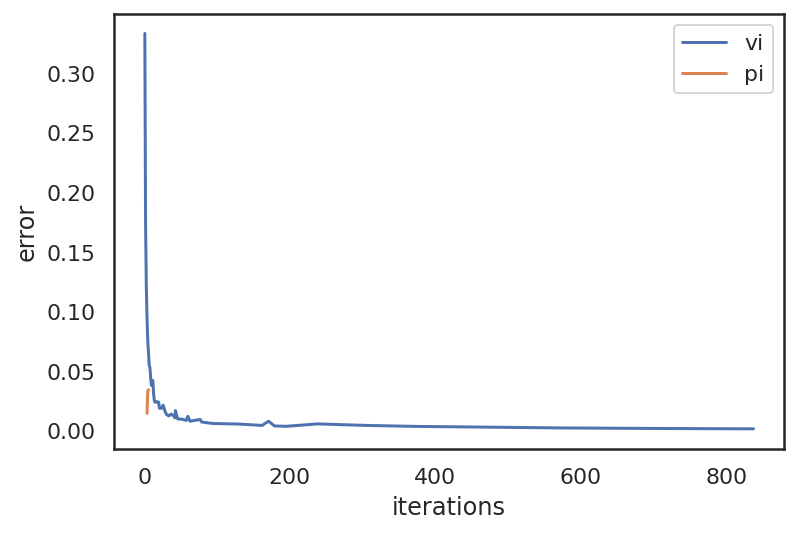

In [608]:
vi_res.groupby('iterations')['error'].mean().plot(label='vi')
pi_res.groupby('iterations')['error'].mean().plot(label='pi')
plt.ylabel('error')
plt.legend()

## Generate plots


RL Model Optimization (small and large environment):
- [ ] Reward vs iterations
- [x] Reward vs discount/gamma (PI, VI)
- [ ] Reward vs epsilon (Q learning)
- [ ] Reward vs epsilon decay (Q learning)
- [ ] Reward vs alpha (Q learning)
- [ ] Time vs iterations
- [ ] Time vs discount/gamma (PI, VI)
- [ ] Time vs epsilon (Q learning)
- [ ] Time vs epsilon decay (Q learning)
- [ ] Time vs alpha (Q learning)
- [ ] Delta convergence

Environment Analysis:
- [ ] Original Environment view
- [ ] Environment view with optimal policy found
- [ ] Relative reward vs environment complexity (PI ,VI, Q learning)
- [ ] Time to solution vs environment complexity (PI, VI, Q learning)


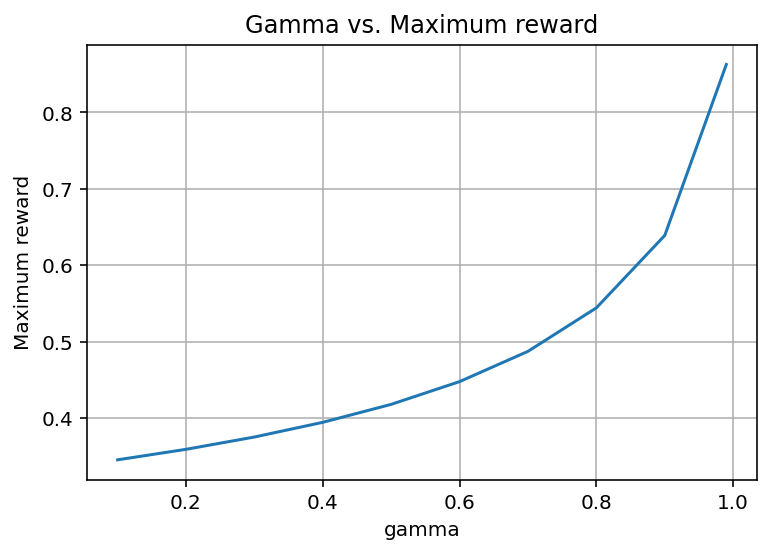

In [226]:
vi_res.groupby('gamma')['reward'].max().to_frame().plot(legend=False)
plt.xlabel('gamma')
plt.ylabel('Maximum reward')
plt.grid()
plt.title('Gamma vs. Maximum reward');

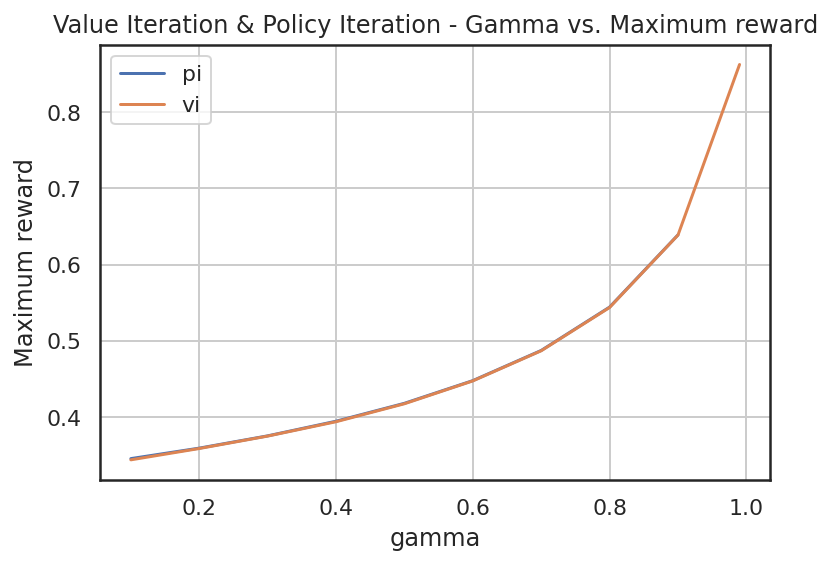

In [389]:
pi_res.groupby('gamma')['reward'].mean().plot(label='pi')
vi_res.groupby('gamma')['reward'].mean().plot(label='vi')
plt.xlabel('gamma')
plt.ylabel('Maximum reward')
plt.legend()
plt.grid()
plt.title('Value Iteration & Policy Iteration - Gamma vs. Maximum reward');

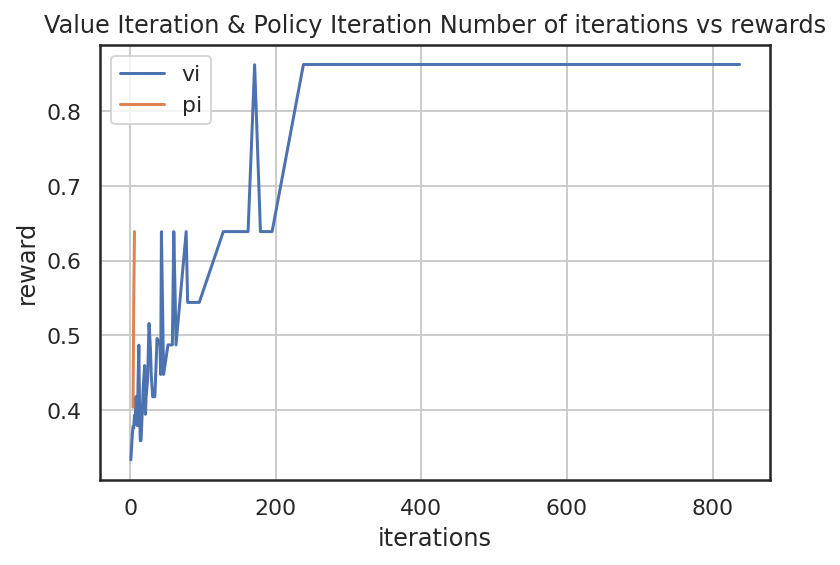

In [392]:
vi_res.groupby('iterations')['reward'].mean().plot(label='vi')
pi_res.groupby('iterations')['reward'].mean().plot(label='pi')
plt.ylabel('reward')
plt.legend()
plt.grid()
plt.title('Value Iteration & Policy Iteration- Number of iterations vs rewards');

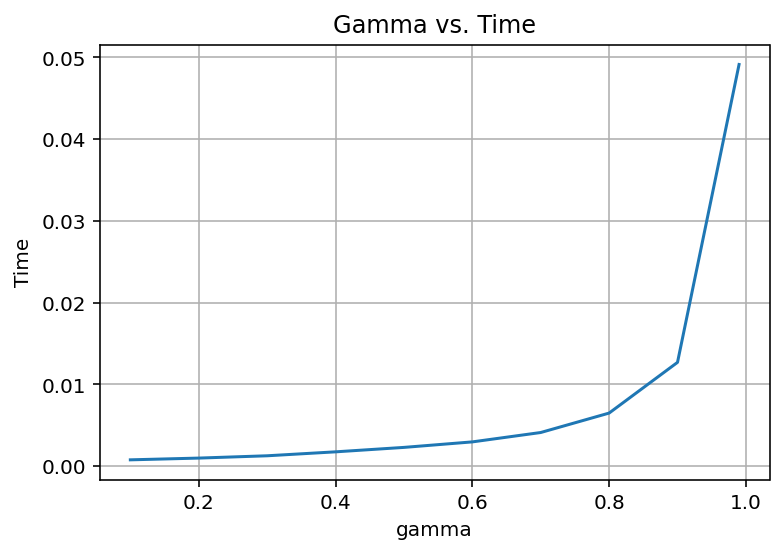

In [225]:
rs = vi_res.groupby('gamma')['time'].agg(['max','min'])
rs['diff'] = rs['max']-rs['min']
rs.plot(y='diff', legend=False)
plt.xlabel('gamma')
plt.ylabel('Time')
plt.grid()
plt.title('Gamma vs. Time');

## Policy

Best Result:

Success = 84.80
Gamma = 0.99
Epsilon= 1E-05


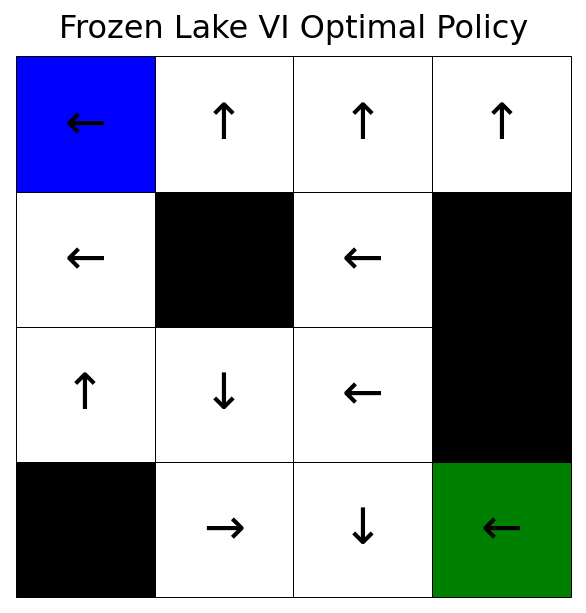

In [187]:
best_run = vi_res['success_percent'].argmax()
best_policy = vi_res['policy'][best_run]
best_policy = np.array(list(best_policy)[0])
best_policy = best_policy.reshape(rows, cols)

title='Frozen Lake VI Optimal Policy'
plot_frozen_lake(env, best_policy, title)

## PI

In [495]:
def policy_iteration(t, r, gammas, show_results=False, max_iterations=10000000):
    time_start = time.time()
    df = pd.DataFrame(0.0, index=np.arange(len(gammas)), columns=['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_percent', 'policy', 'mean_rewards', 'max_utils', 'error'])
        
    test_num = 0
    for g in gammas:
        test = PolicyIteration(t, r, gamma=g, max_iter=max_iterations, eval_type="iterative")
        
        runs  = test.run()
        Time  = test.time
        iters = test.iter
        max_util  = runs[-1]['Max V']
                
        max_utils, mean_rewards, ers = [], [], []
        for run in runs:
            max_utils.append(run['Max V'])
            mean_rewards.append(run['Mean V'])
            ers.append(run['Error'])
        
        policy = np.array(test.policy)
        policy = policy.reshape(4,4)
        
        df['gamma'][test_num], df['time'][test_num]        = g, Time
        df['iterations'][test_num], df['reward'][test_num]   = iters, max_util
        df['mean_rewards'][test_num], df['max_utils'][test_num] = {tuple(mean_rewards)}, {tuple(max_utils)}
        df['error'][test_num], df['policy'][test_num]        = np.mean(ers), {test.policy}
                
        if show_results:
            title = 'frozenlake_pi_' + str(rows) + 'x' + str(cols) + '_g' + str(g)
            plot_frozen_lake(env, policy, title)
        
        test_num += 1
            
    end_time = time.time() - time_start
    
    policies = data['policy']
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = generate_score(env, pol, show_results)
        data['success_percent'][i]   = 100-failures      
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        
    data = data.fillna(0)        
    return data

In [496]:
gammas   = np.arange(0.1,1.0,0.1)
pi_res  = policy_iteration(T, R, gammas, show_results=False)

Gamma	Time	Iteration	Reward
0.10,	0.00,	4,	0.345239
0.20,	0.00,	4,	0.358992
0.30,	0.00,	4,	0.375103
0.40,	0.00,	4,	0.394332
0.50,	0.00,	4,	0.417861
0.60,	0.00,	4,	0.447649
0.70,	0.00,	4,	0.487267
0.80,	0.00,	5,	0.544196
0.90,	0.00,	6,	0.639020
Time taken: 0.04


In [555]:
pi_res[pi_res['gamma']==0.9]

gamma  epsilon      time  iterations   reward  average_steps  steps_stddev  \
8    0.9      0.0  0.003031         6.0  0.63902      43.957087     37.267172   

   success_percent                                             policy  \
8             76.9  {(0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...   

                                        mean_rewards  \
8  {(0.0452452461789103, 0.0902144580841161, 0.12...   

                                         max_rewards     error  
8  {(0.4761904761904762, 0.5818649566344144, 0.63...  0.034484

<AxesSubplot:xlabel='iterations'>

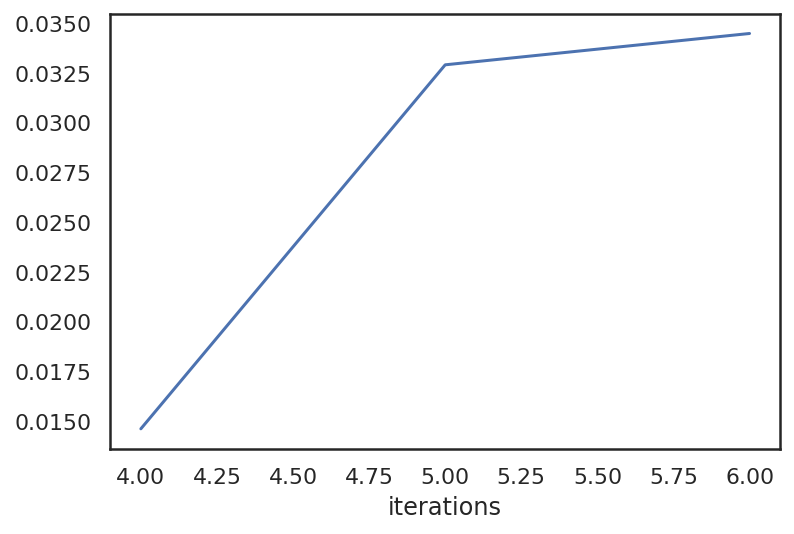

In [498]:
pi_res.groupby('iterations')['error'].mean().plot(label='delta divergence')

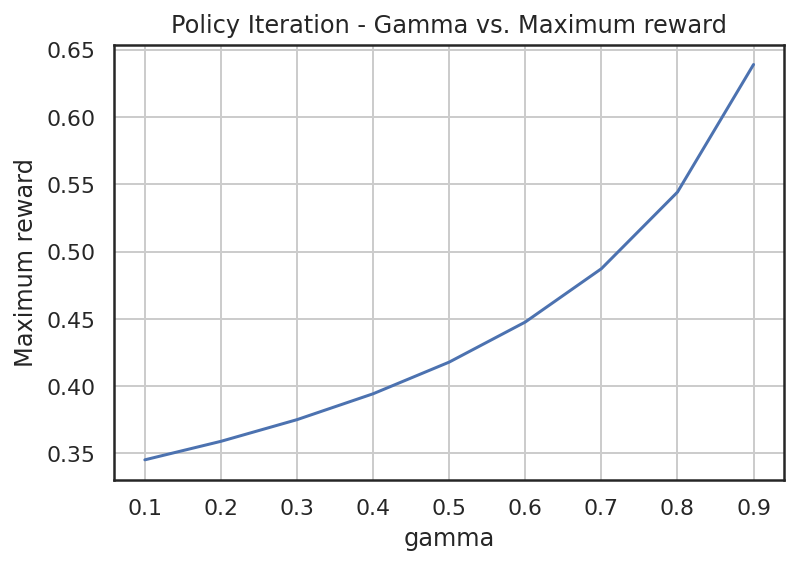

In [383]:
pi_res.groupby('gamma')['reward'].max().to_frame().plot(legend=False)
plt.xlabel('gamma')
plt.ylabel('Maximum reward')
plt.grid()
plt.title('Policy Iteration - Gamma vs. Maximum reward');

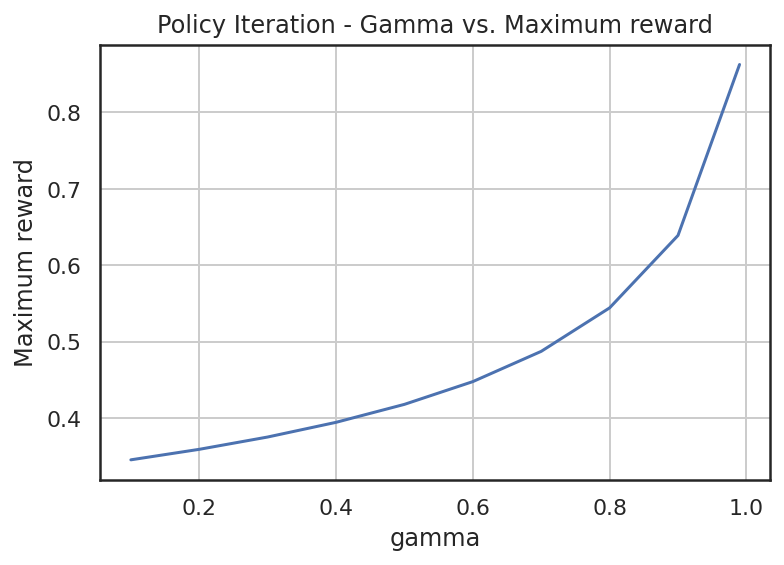

In [380]:
vi_res.groupby('gamma')['reward'].max().to_frame().plot(legend=False)
plt.xlabel('gamma')
plt.ylabel('Maximum reward')
plt.grid()
plt.title('Policy Iteration - Gamma vs. Maximum reward');

In [ ]:
vi_res.groupby('iterations')['reward'].mean().plot(label='vi')
pi_res.groupby('iterations')['reward'].mean().plot(label='pi')
plt.ylabel('reward')
plt.legend()
plt.grid()
plt.title('Value Iteration & Policy Iteration- Number of iterations vs rewards');

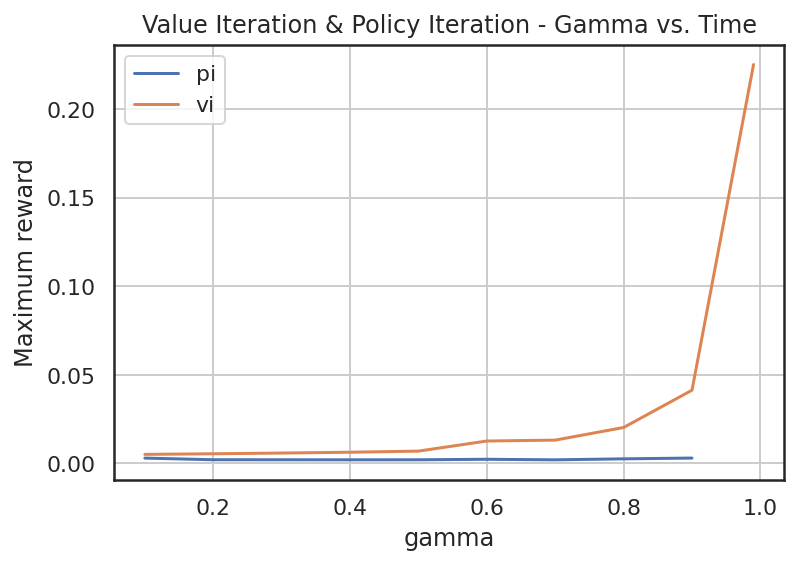

In [536]:
pi_res.groupby('gamma')['time'].max().plot(label='pi')
vi_res.groupby('gamma')['time'].max().plot(label='vi')
plt.xlabel('gamma')
plt.ylabel('Maximum reward')
plt.grid()
plt.legend()
plt.title('Value Iteration & Policy Iteration - Gamma vs. Time');

## Policy

Best Result:

Success = 77.70
Gamma = 0.90


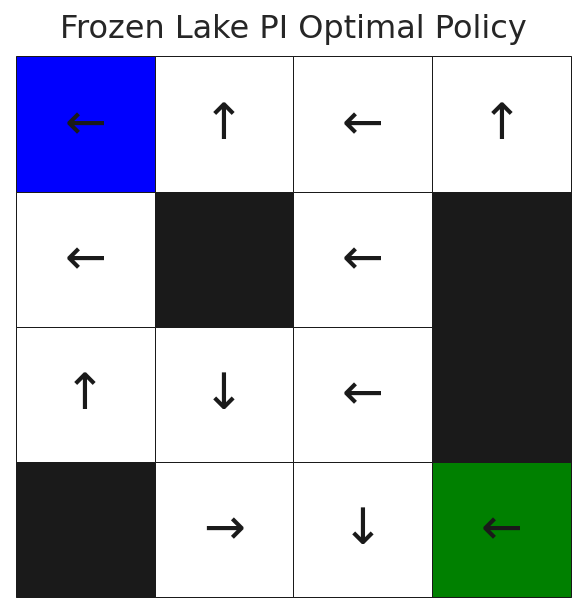

In [357]:
best_run = pi_res['success_percent'].argmax()

best_policy = pi_res['policy'][best_run]
best_policy = np.array(list(best_policy)[0])
best_policy = best_policy.reshape(rows, cols)

plot_frozen_lake(env, best_policy, 'Frozen Lake PI Optimal Policy')

# Q-Learning

In [500]:
def q_learning(t, r, gammas, alphas, alpha_decays=[0.99], epsilon_decays=[0.99], n_iterations=[10000], show_results=False):
    num_tests = len(n_iterations) * len(alphas) * len(alpha_decays) * len(epsilon_decays)* * len(gammas)
    df = pd.DataFrame(0.0, index=np.arange(num_tests),
                        columns=['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'time', 'reward', 'average_steps', 'steps_stddev', 'success_percent', 'policy', 'avg_util', 'max_rewards', 'error'])

    test_num = 0
    for g in gammas:
        for a in alphas:
            for alpha_decay in alpha_decays:
                for epsilon_decay in epsilon_decays:
                    for n in n_iterations:
                             %(g, a, alpha_decay, epsilon_decay, n))
                    
                        test = QLearning(t, r, gamma=g, alpha=a, alpha_decay=alpha_decay, epsilon_decay=epsilon_decay, n_iter=n)
                        runs  = test.run()
                        time  = runs[-1]['Time']
                        iters = runs[-1]['Iteration']
                        max_reward  = runs[-1]['Max V']
                        
                        max_rewards, avg_util, errors = [], [], []
                        for run in runs:
                            max_rewards.append(run['Max V'])
                            avg_util.append(run['Mean V'])
                            errors.append(run['Error'])
                        
                        policy = np.array(test.policy)
                        policy = policy.reshape(4,4)
                        
                        df['gamma'][test_num], df['alpha'][test_num] = g, a
                        df['alpha_decay'][test_num], df['epsilon_decay'][test_num]   = alpha_decay, epsilon_decay
                         = 
                        df['time'][test_num]          = time
                        df['iterations'][test_num]    = iters
                        df['reward'][test_num]        = max_reward
                        df['avg_util'][test_num]      = {tuple(avg_util)}
                        df['max_rewards'][test_num]   = {tuple(max_rewards)}
                        df['error'][test_num]         = {tuple(errors)}
                        df['policy'][test_num]        = {test.policy}
                                                
                        if show_results:
                            title = 'FrozenLake_Q_Learning_' + str(rows) + 'x' + str(cols) + '_g' + str(g) + '_a' + str(a) + '_adecay' + str(alpha_decay) + '_edecay' + str(epsilon_decay) + '_iter' + str(n)
                            plot_frozen_lake(env, policy, title)
                        
                        test_num += 1
            
    policies = df['policy']
    
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = generate_score(env, pol, show_results)
        df['average_steps'][i], df['steps_stddev'][i] = steps, steps_stddev
        df['success_percent'][i]   = 100-failures      
        
    df = df.fillna(0)        
    return df

Gamma,	Alpha,	Time,	Iter,	Reward

Test Num 1/216
Gamma: 0.10,	Alpha: 0.01,	Alpha Decay:0.850,	Epsilon Decay:0.850,	Iterations:10000
0.10,	0.01,	0.68,	10000,	0.000000
Test Num 2/216
Gamma: 0.10,	Alpha: 0.01,	Alpha Decay:0.850,	Epsilon Decay:0.850,	Iterations:100000
0.10,	0.01,	5.55,	100000,	0.102270
Test Num 3/216
Gamma: 0.10,	Alpha: 0.01,	Alpha Decay:0.850,	Epsilon Decay:0.850,	Iterations:1000000
0.10,	0.01,	53.45,	1000000,	0.312024
Test Num 4/216
Gamma: 0.10,	Alpha: 0.01,	Alpha Decay:0.850,	Epsilon Decay:0.999,	Iterations:10000
0.10,	0.01,	0.68,	10000,	0.000000
Test Num 5/216
Gamma: 0.10,	Alpha: 0.01,	Alpha Decay:0.850,	Epsilon Decay:0.999,	Iterations:100000
0.10,	0.01,	5.60,	100000,	0.051093
Test Num 6/216
Gamma: 0.10,	Alpha: 0.01,	Alpha Decay:0.850,	Epsilon Decay:0.999,	Iterations:1000000
0.10,	0.01,	53.52,	1000000,	0.312043
Test Num 7/216
Gamma: 0.10,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay:0.850,	Iterations:10000
0.10,	0.01,	0.67,	10000,	0.000000
Test Num 8/216
Gamma: 0.10,	

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0.10,	0.15,	0.69,	10000,	0.000999
Test Num 23/216
Gamma: 0.10,	Alpha: 0.15,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:100000
0.10,	0.15,	5.70,	100000,	0.059959
Test Num 24/216
Gamma: 0.10,	Alpha: 0.15,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:1000000
0.10,	0.15,	61.50,	1000000,	0.348088
Test Num 25/216
Gamma: 0.10,	Alpha: 0.25,	Alpha Decay:0.850,	Epsilon Decay:0.850,	Iterations:10000
0.10,	0.25,	0.68,	10000,	0.000000
Test Num 26/216
Gamma: 0.10,	Alpha: 0.25,	Alpha Decay:0.850,	Epsilon Decay:0.850,	Iterations:100000
0.10,	0.25,	5.64,	100000,	0.091302
Test Num 27/216
Gamma: 0.10,	Alpha: 0.25,	Alpha Decay:0.850,	Epsilon Decay:0.850,	Iterations:1000000
0.10,	0.25,	54.51,	1000000,	0.303730
Test Num 28/216
Gamma: 0.10,	Alpha: 0.25,	Alpha Decay:0.850,	Epsilon Decay:0.999,	Iterations:10000
0.10,	0.25,	0.69,	10000,	0.010715
Test Num 29/216
Gamma: 0.10,	Alpha: 0.25,	Alpha Decay:0.850,	Epsilon Decay:0.999,	Iterations:100000
0.10,	0.25,	5.64,	100000,	0.057670
Test Num 30/216
Gam

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount

You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
You took an average of 22 steps to get the frisbee
And you fell in the hole 89.20 % of the times
You took an average of 11 steps to get the frisbee
And you fell in the hole 94.30 % of the times
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
You took an average of 14 steps to get the frisbee
And you fell in the hole 98.00 % of the times
You took an average of 19 steps to get the frisbee
And you fell in the hole 88.40 % of the times
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
You took an average of 18 steps to get the frisbee
And you fell in the hole 93.10 % of the times
You took an average of 20 steps to get the frisbee
And you fell in the hole 85.30 % of the times
You took an average of nan steps to get the frisbee
And you fell in the hole 100.00 % of the times
You took an average of

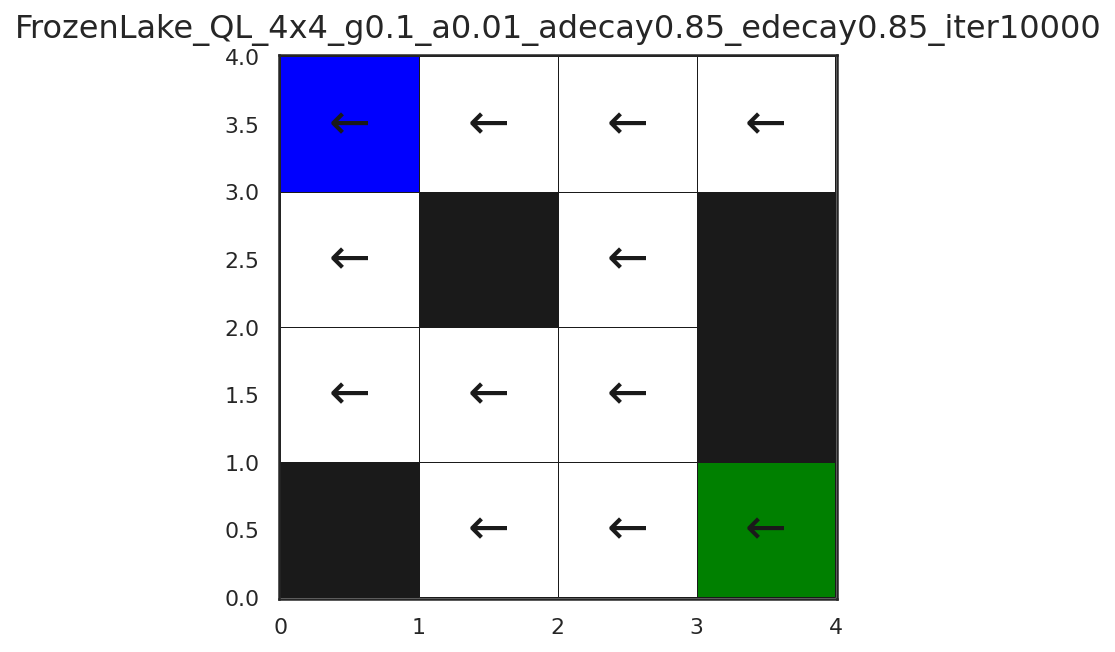

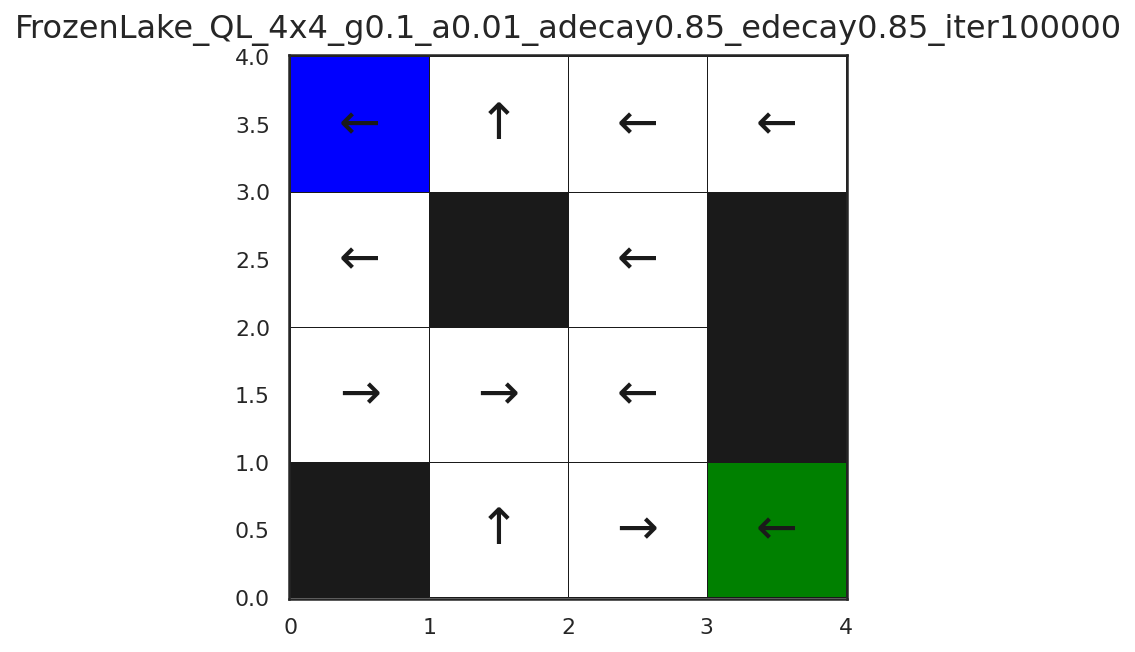

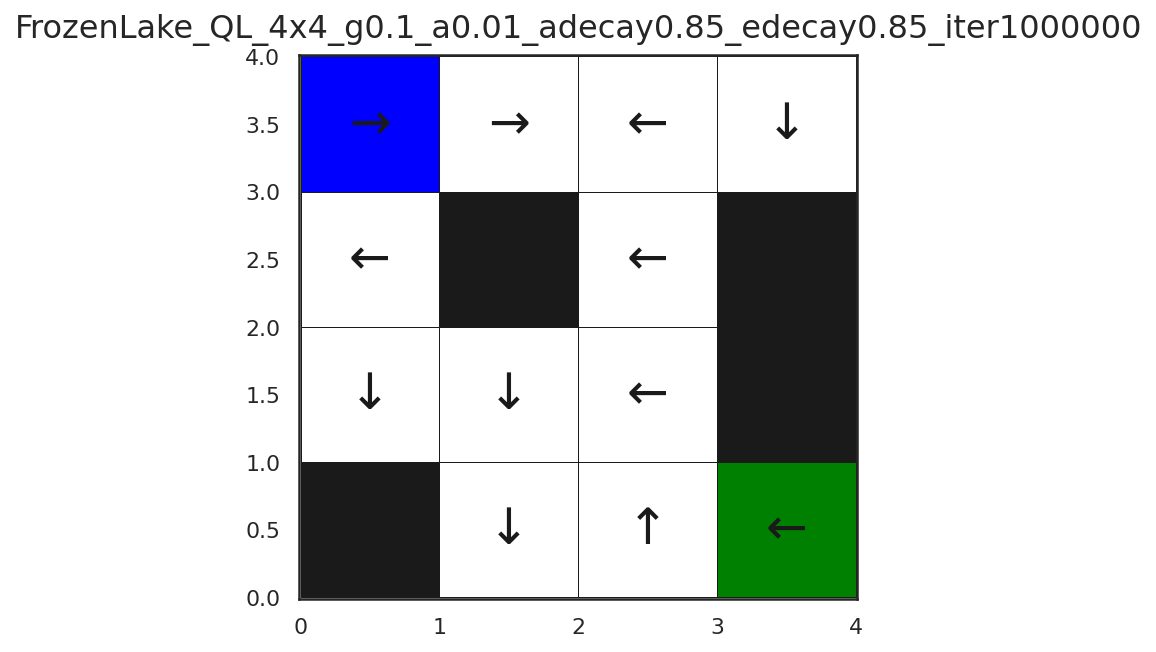

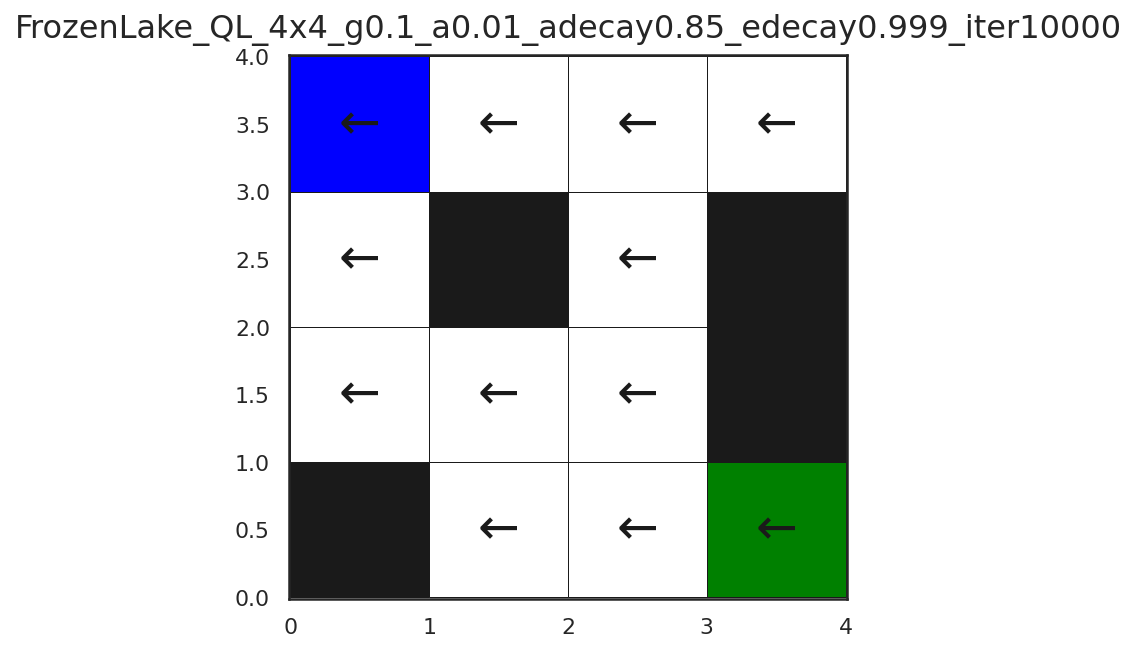

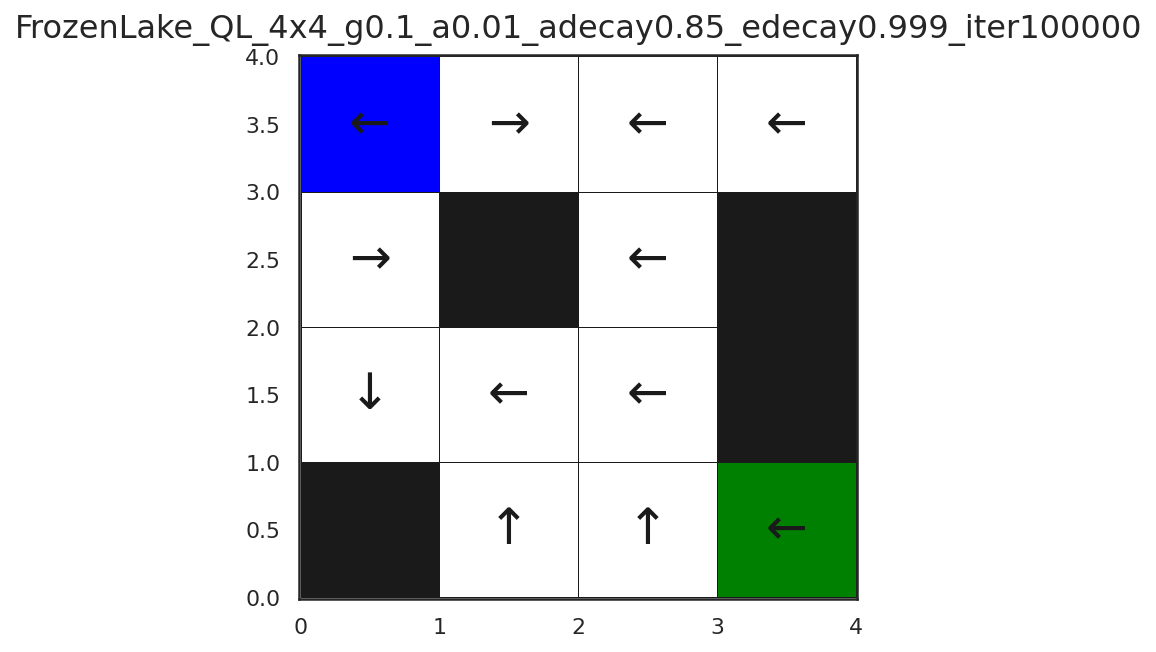

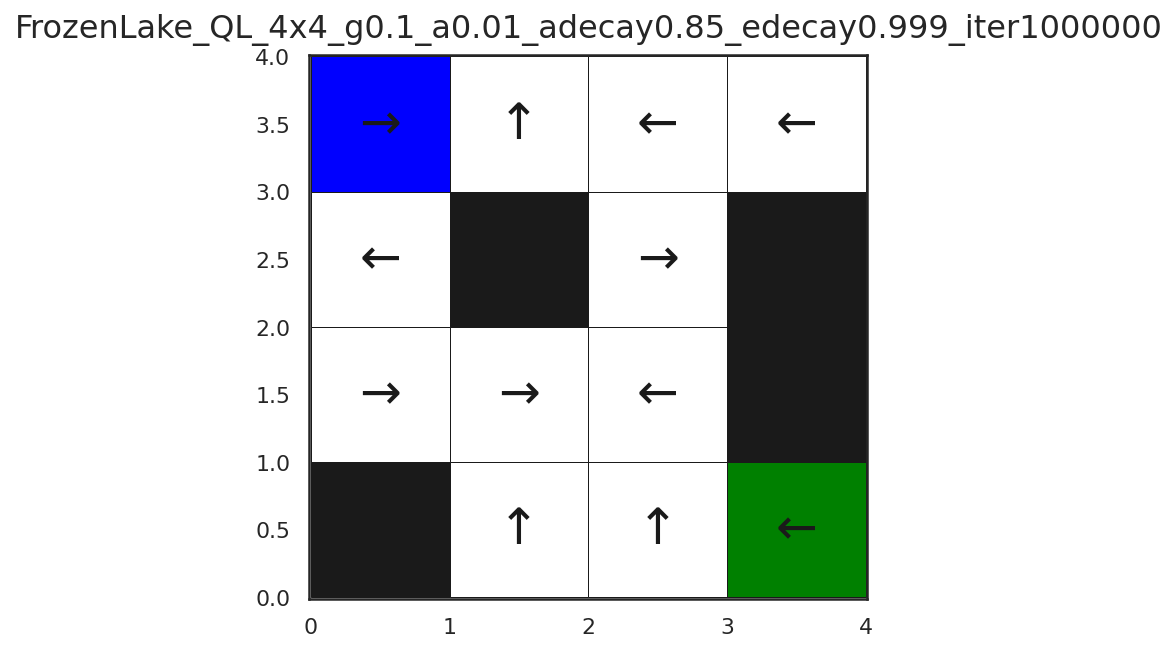

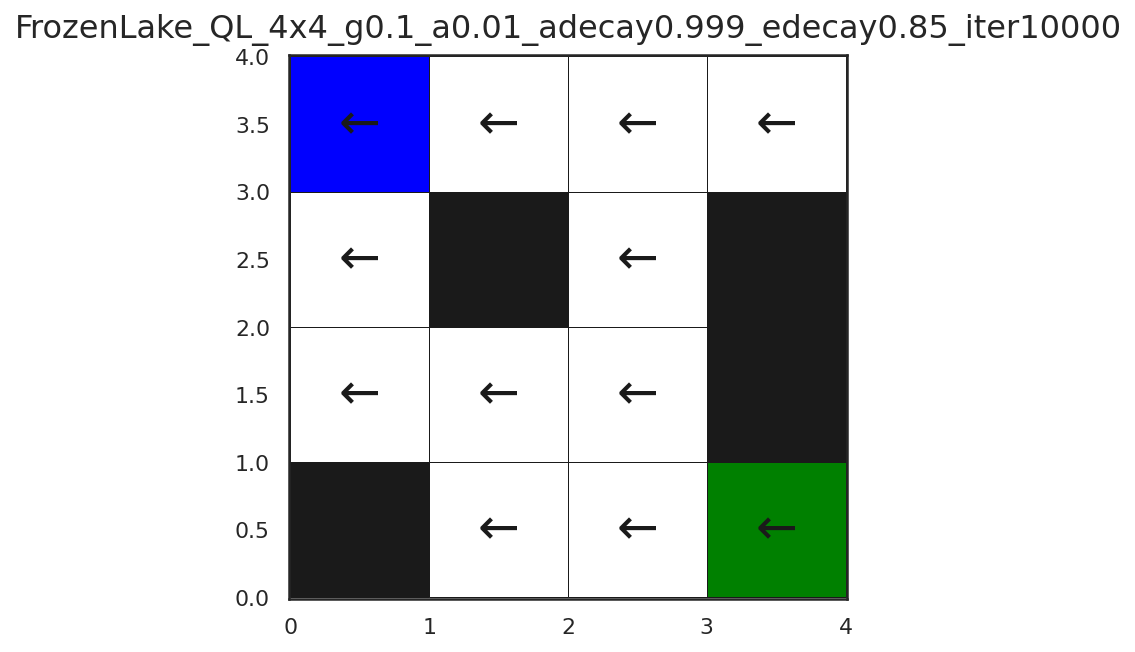

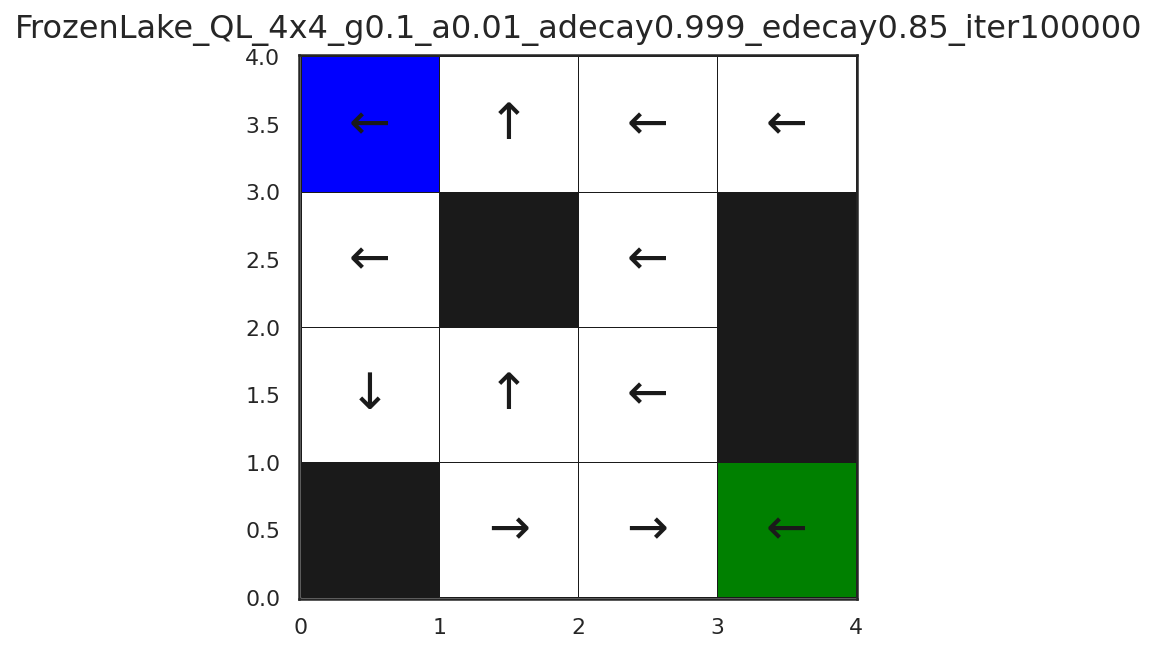

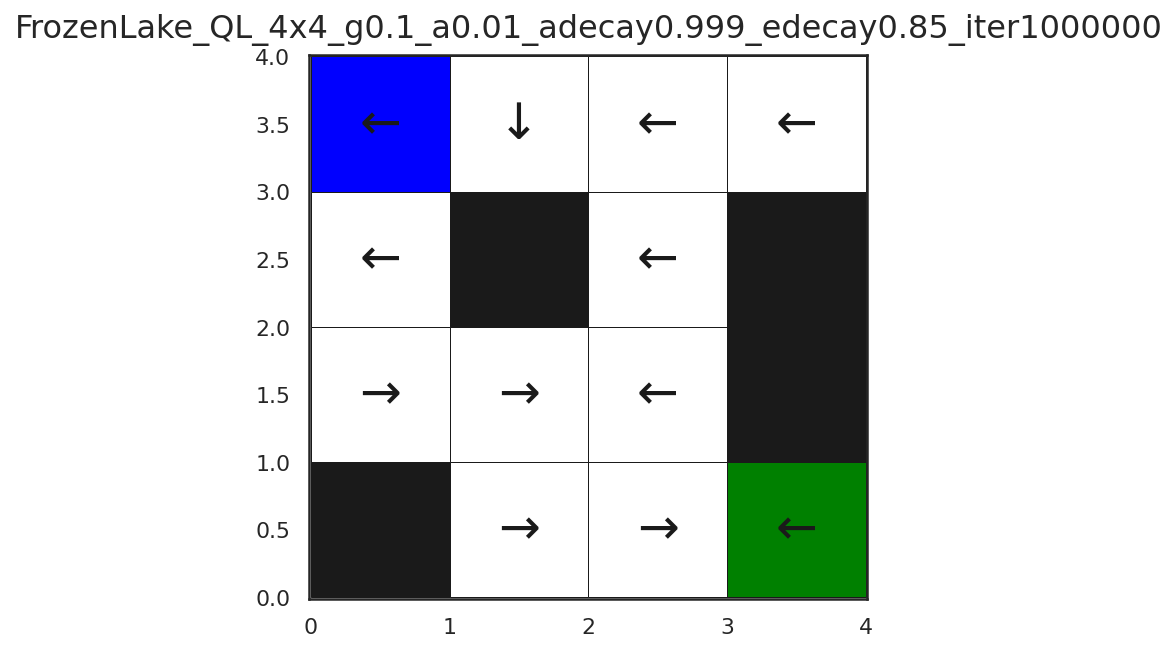

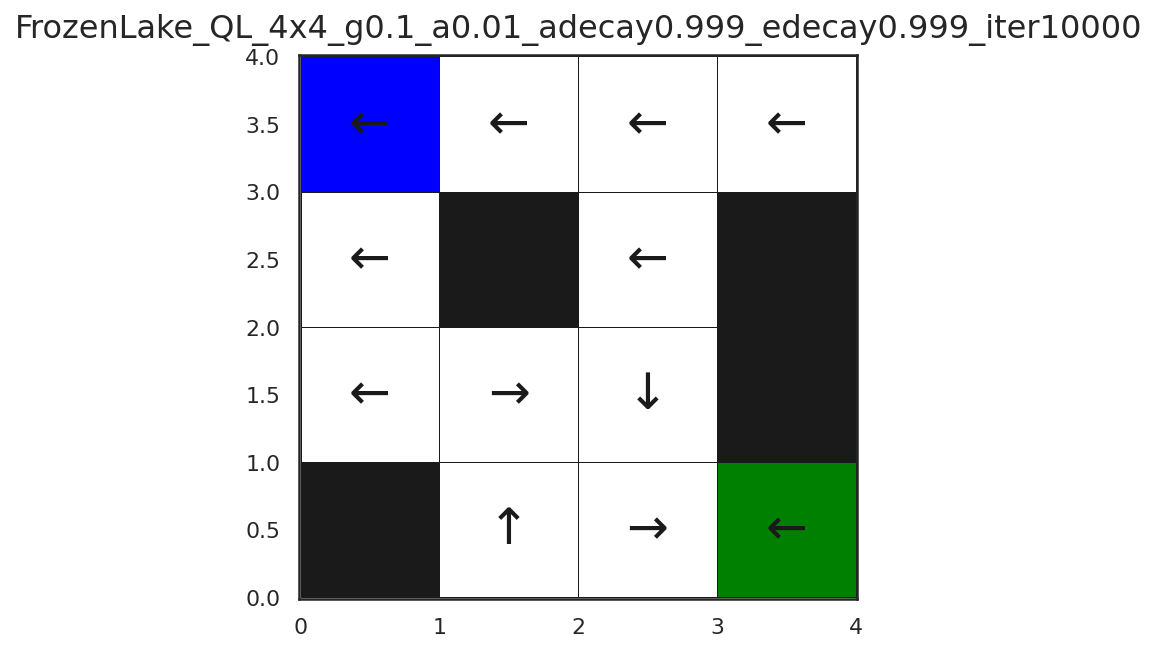

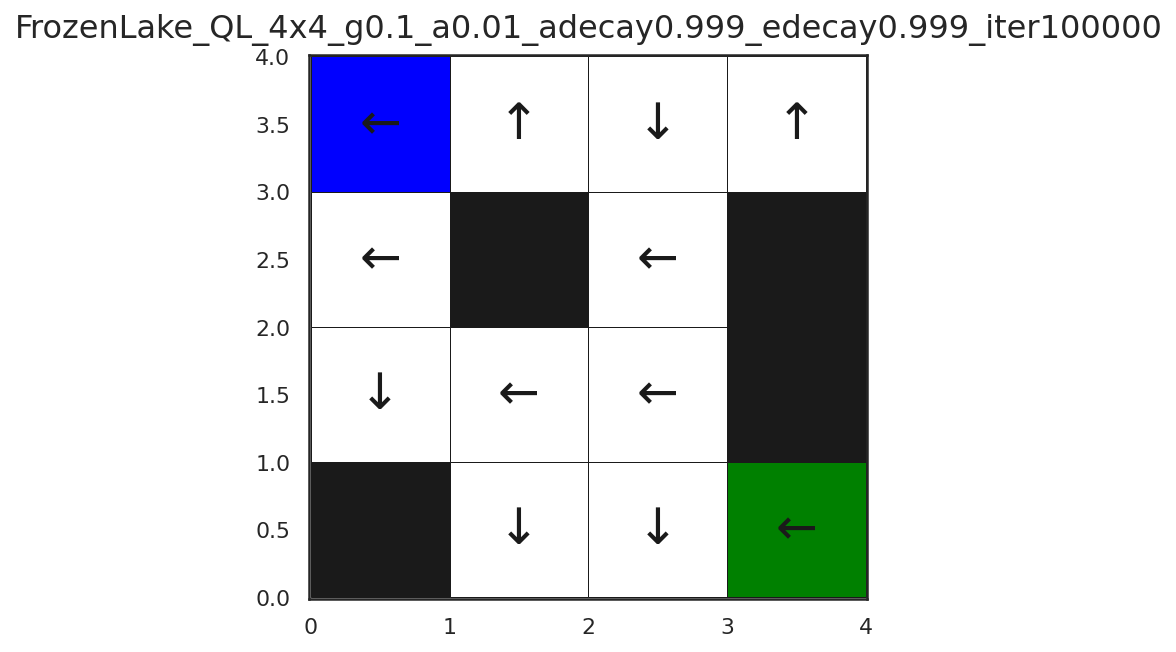

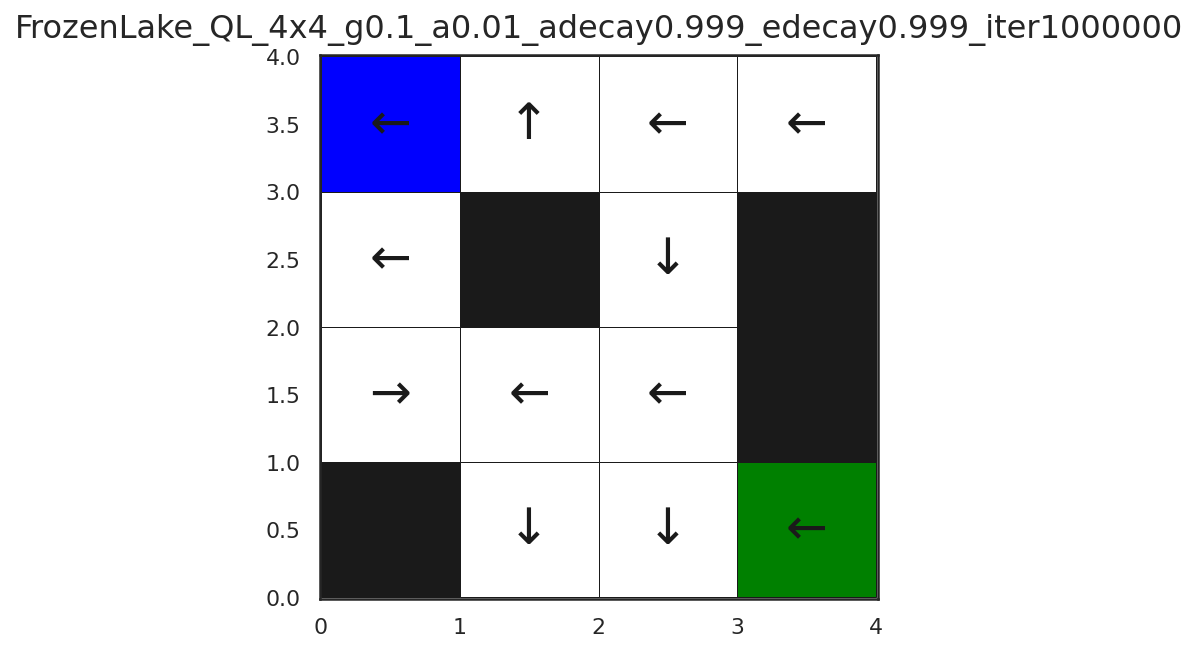

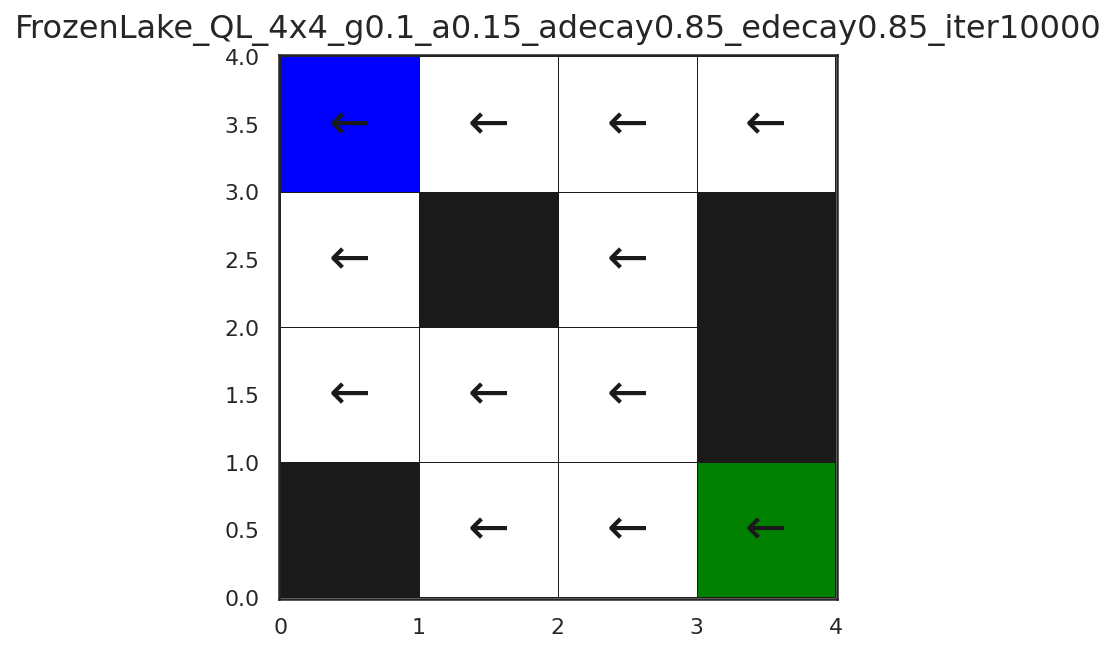

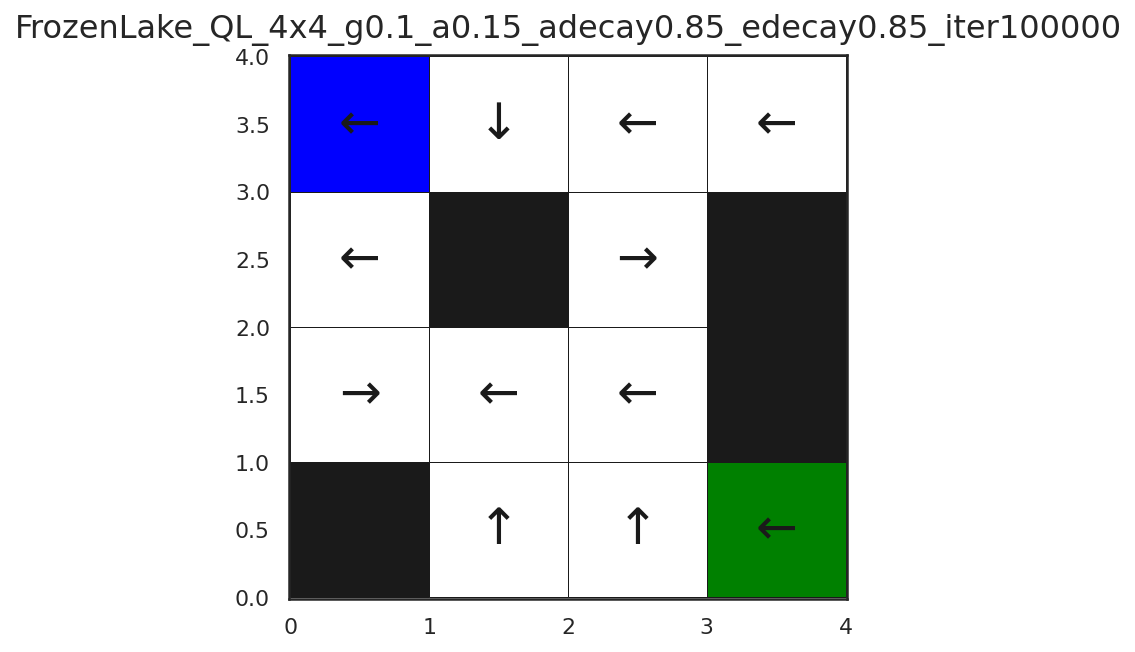

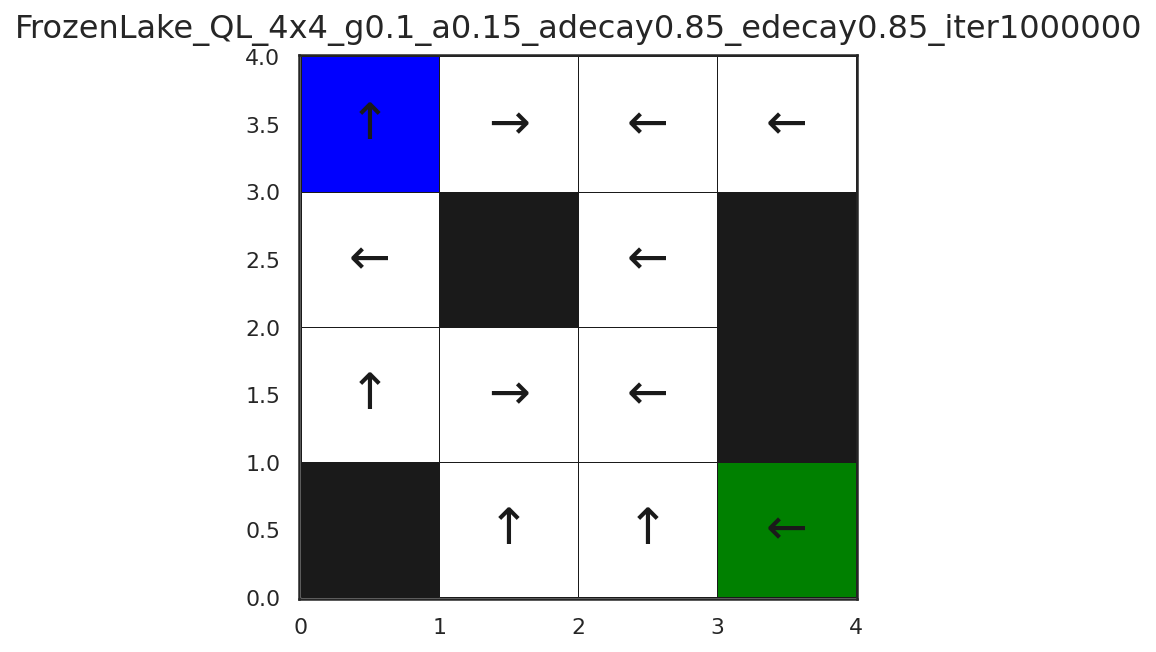

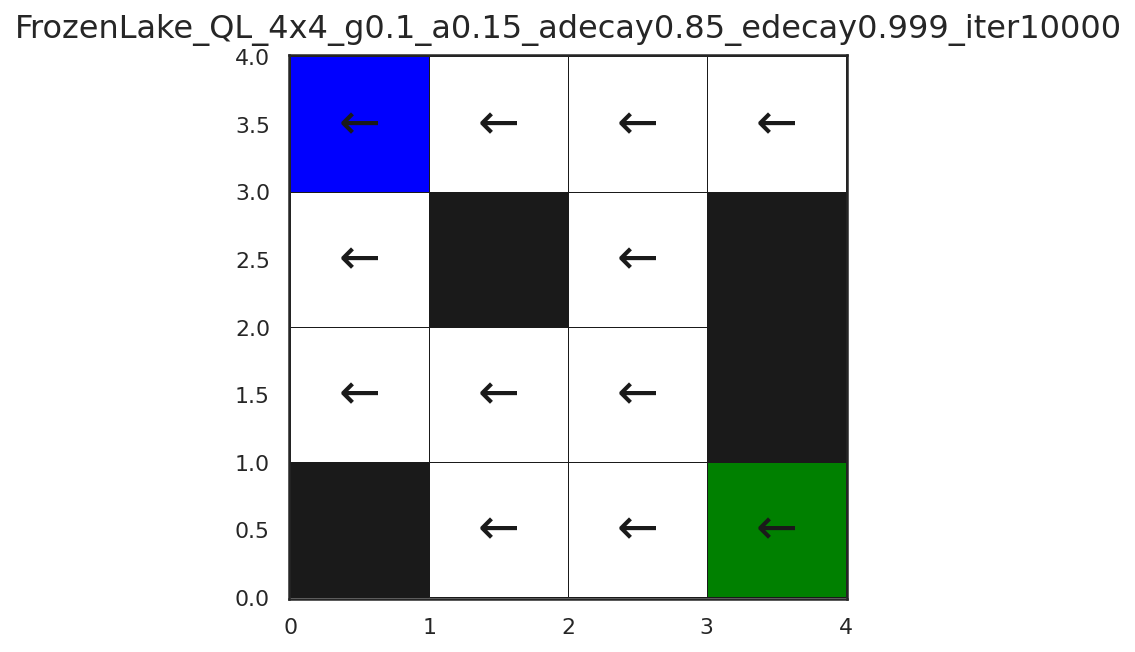

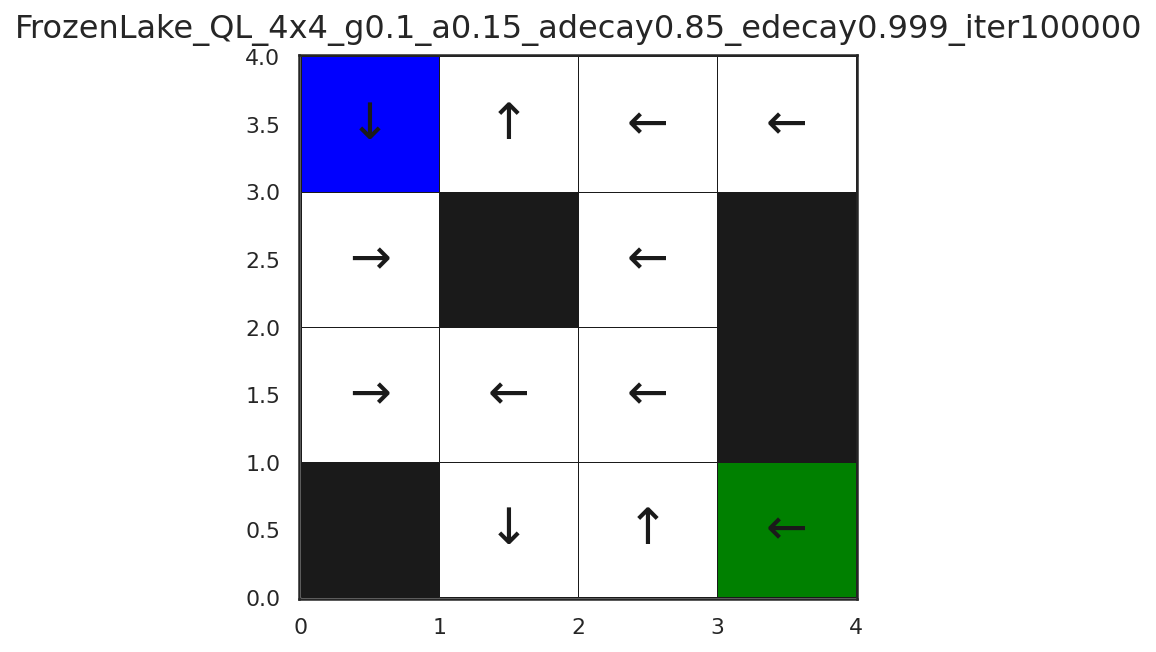

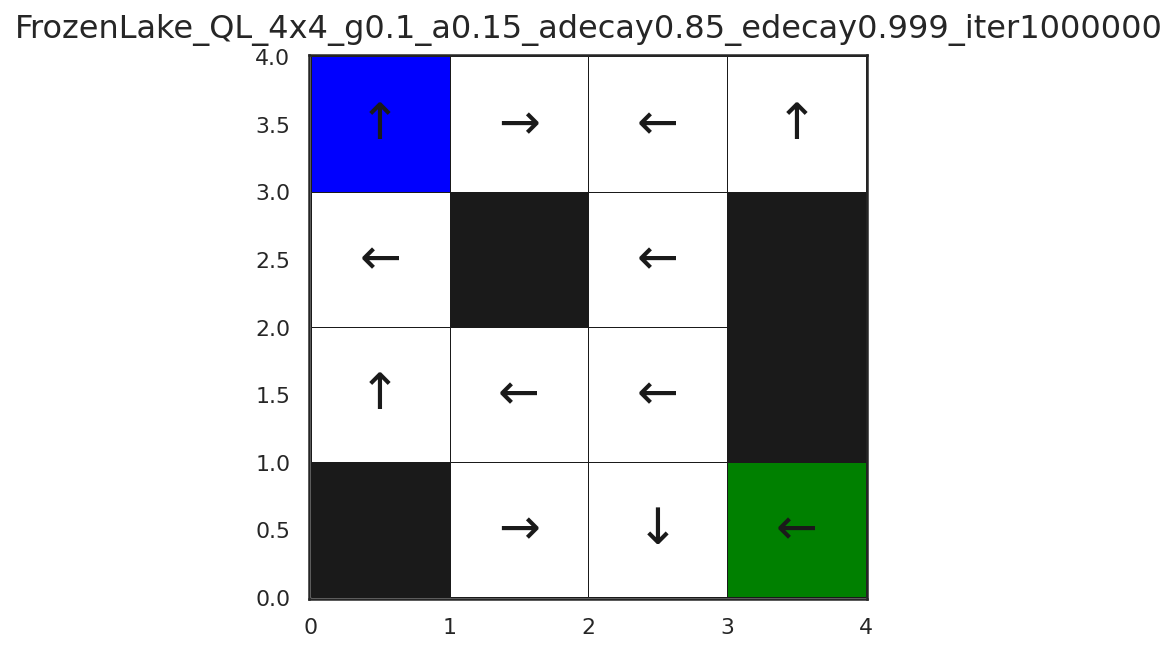

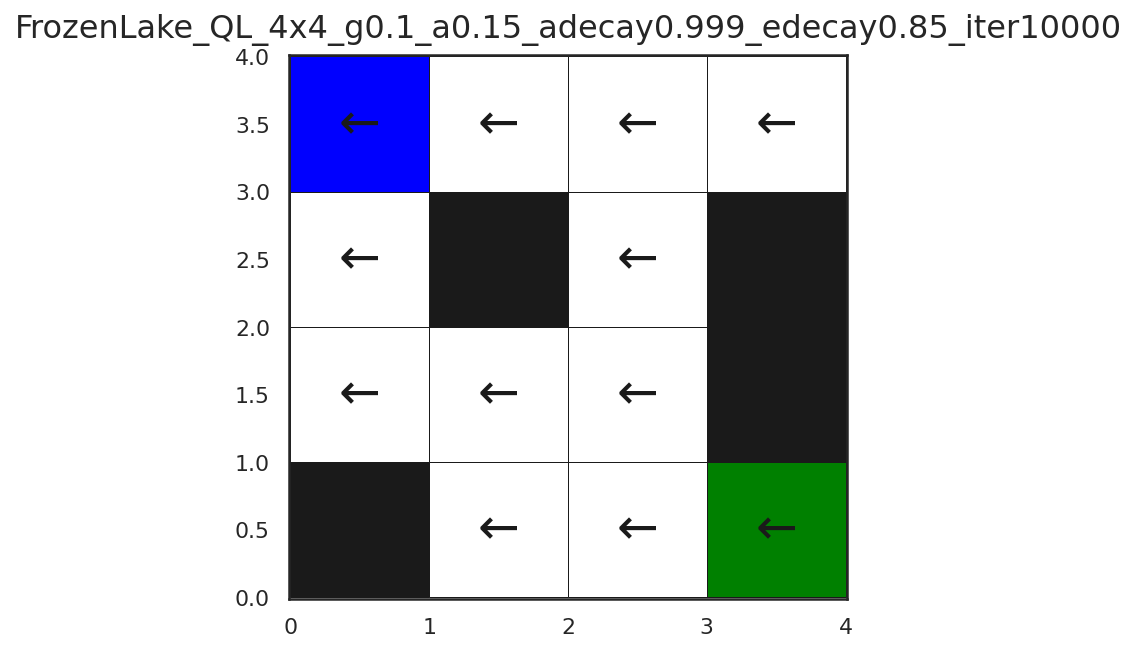

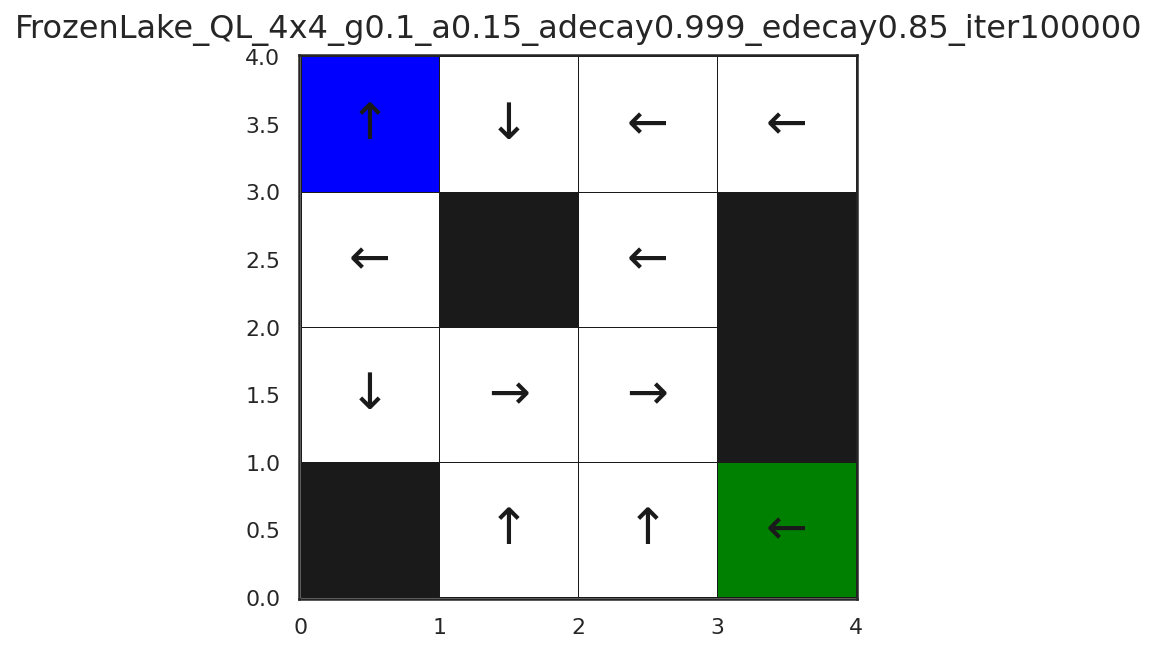

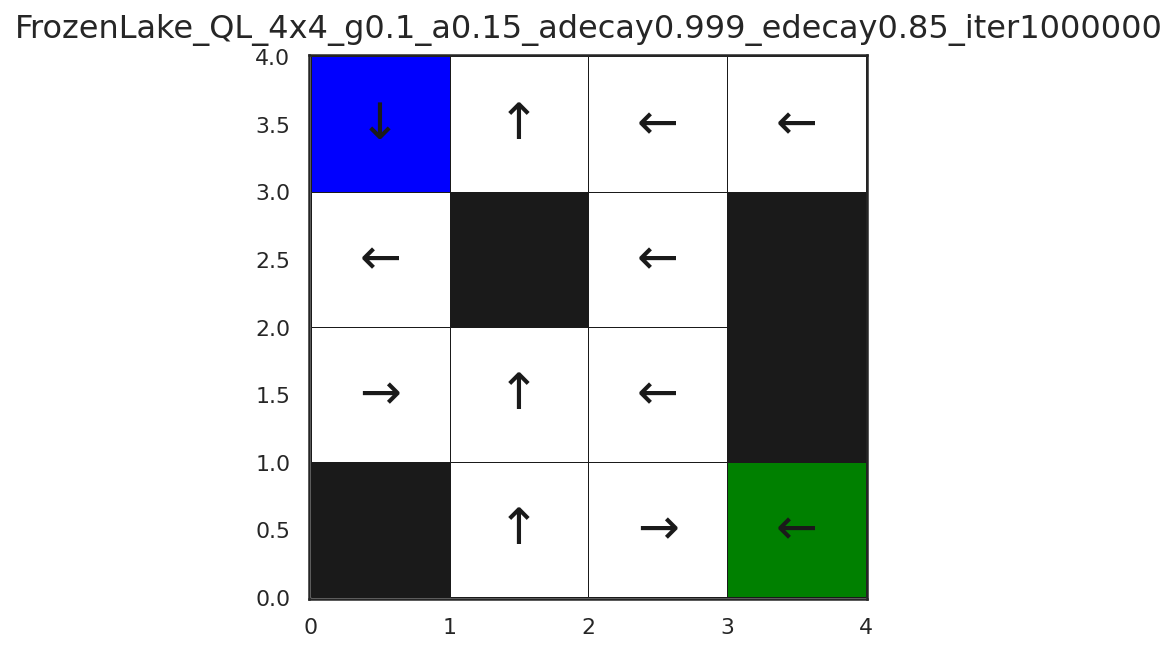

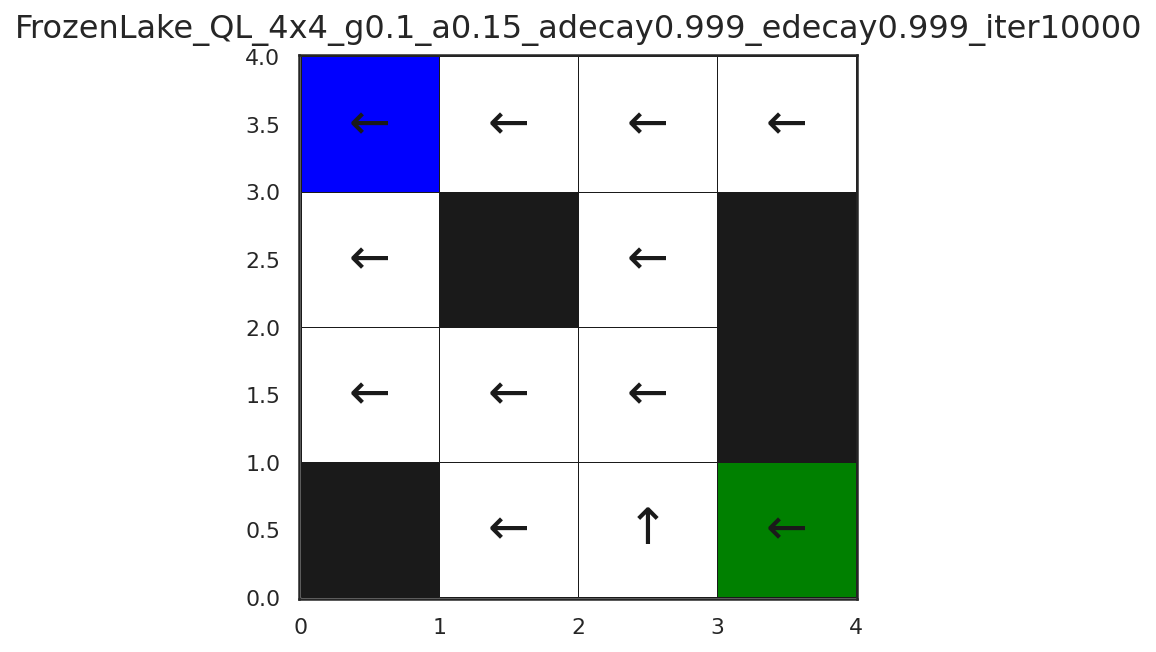

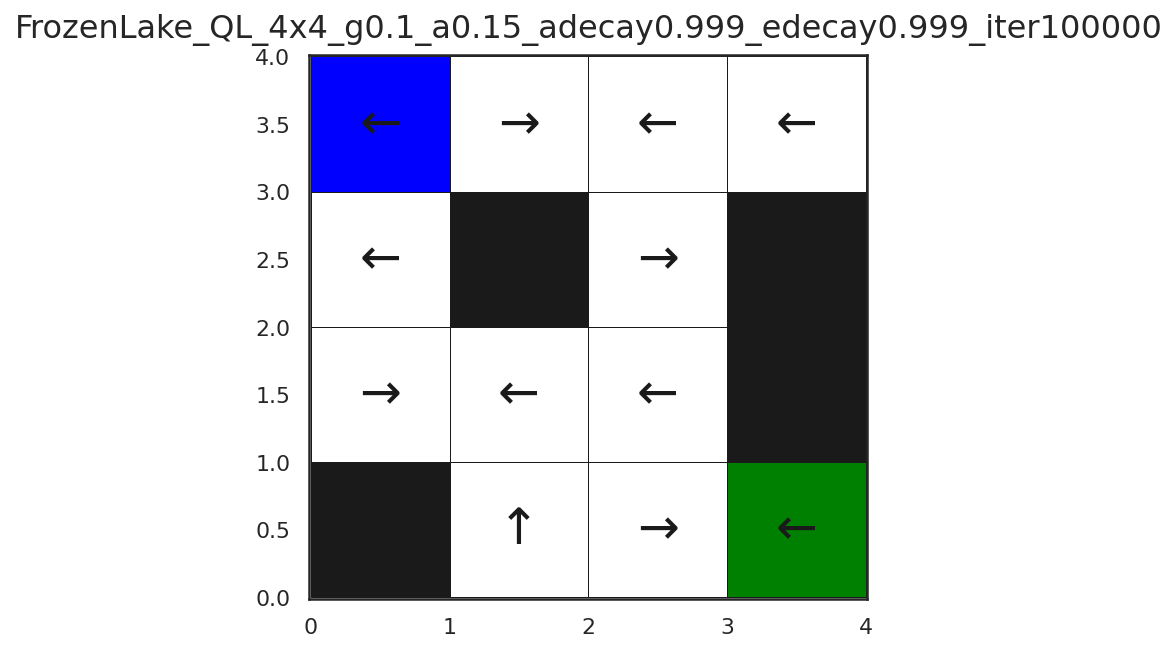

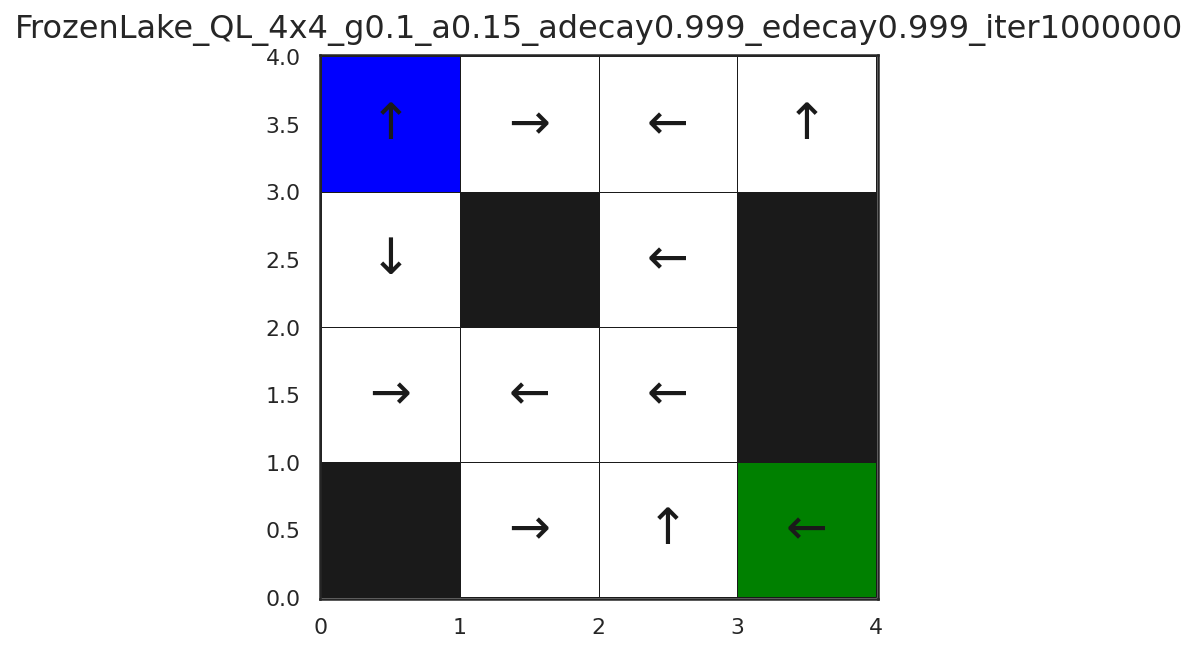

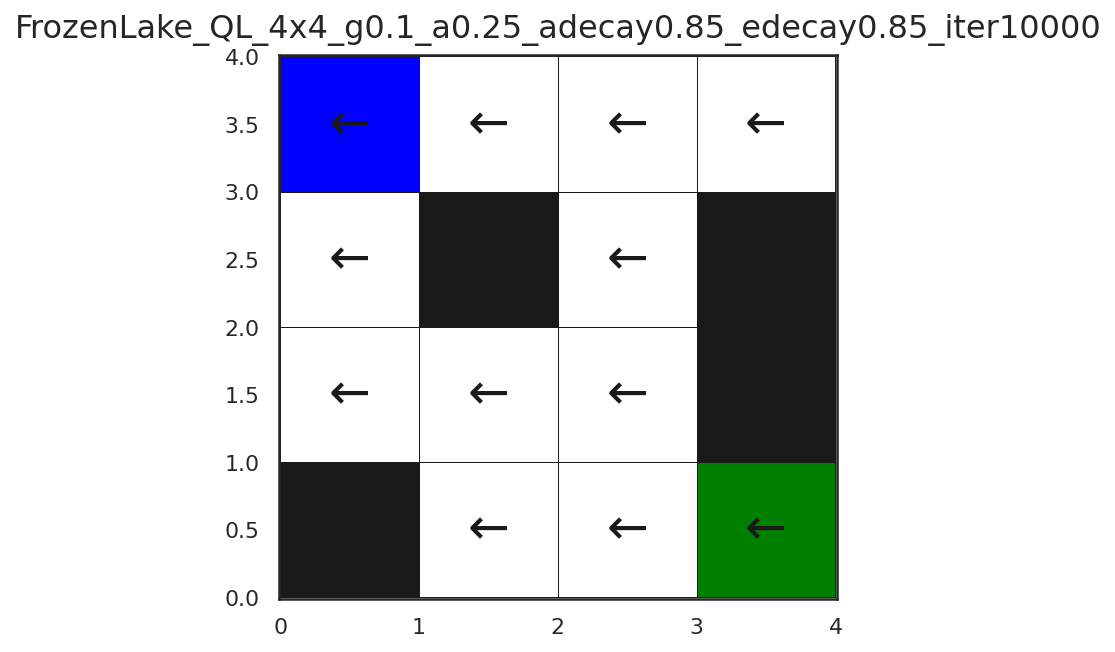

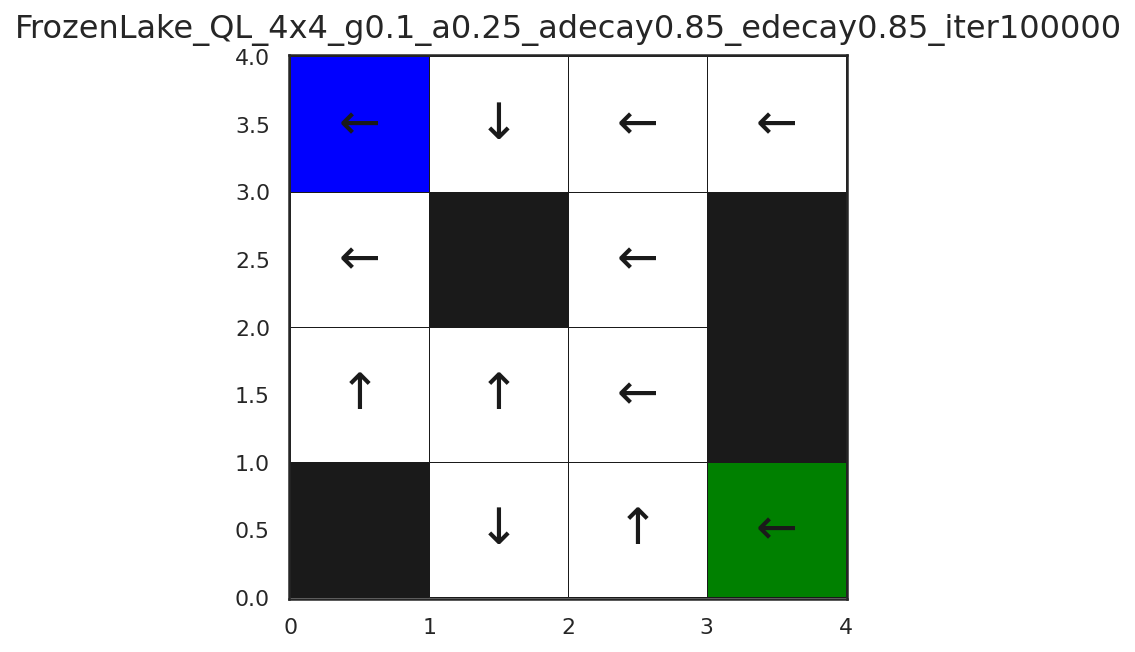

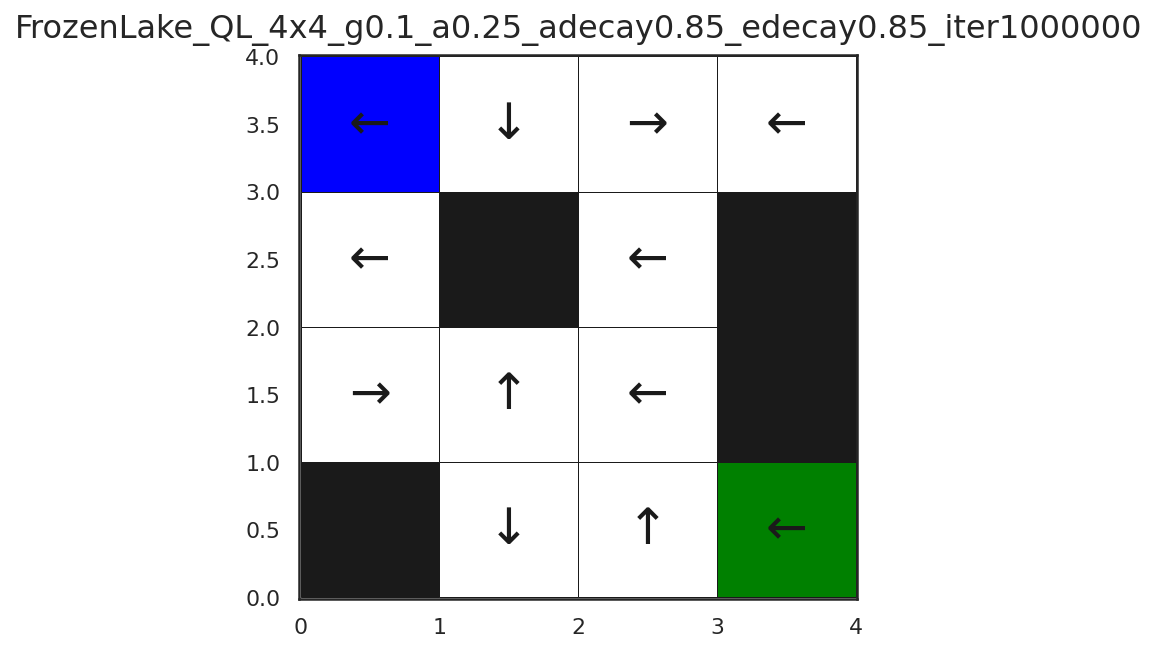

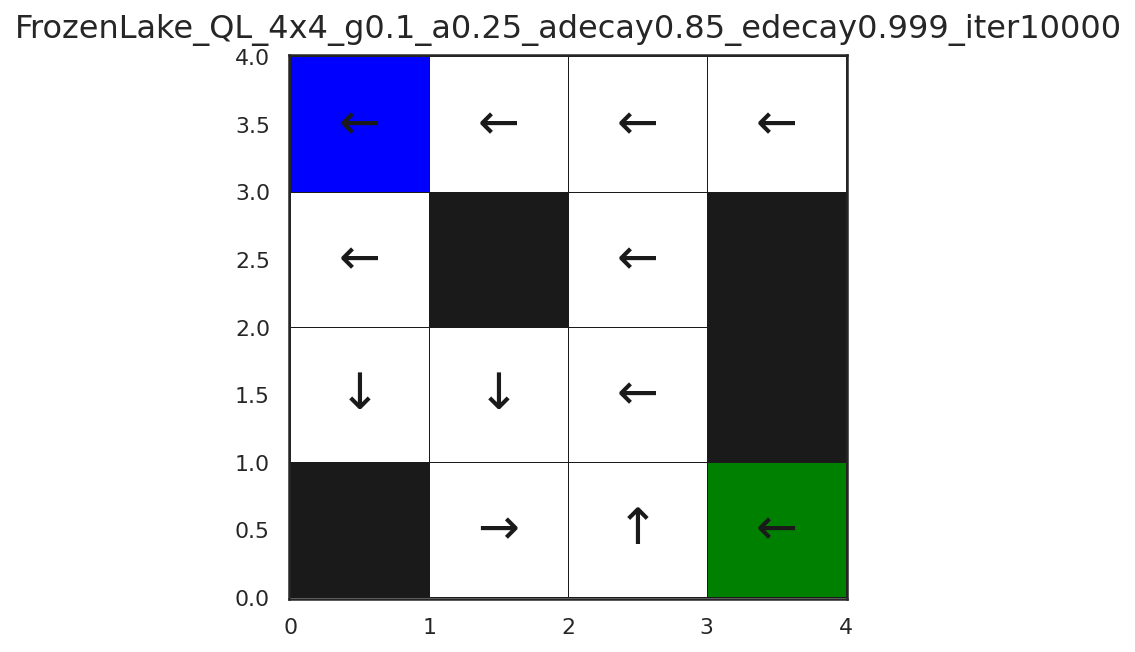

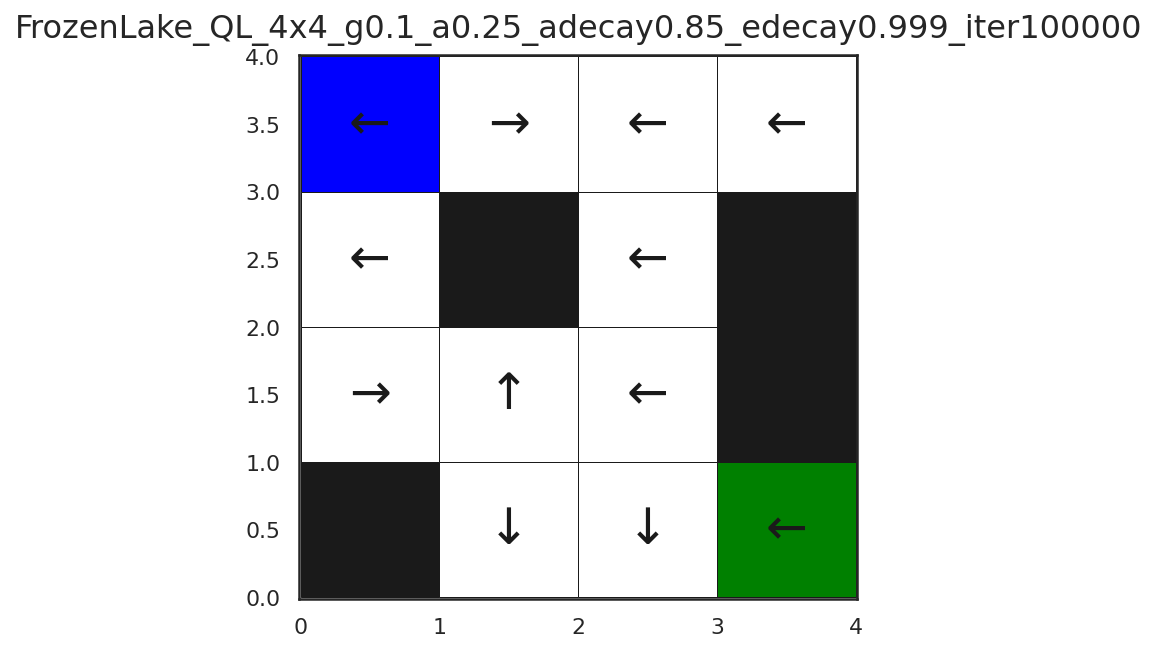

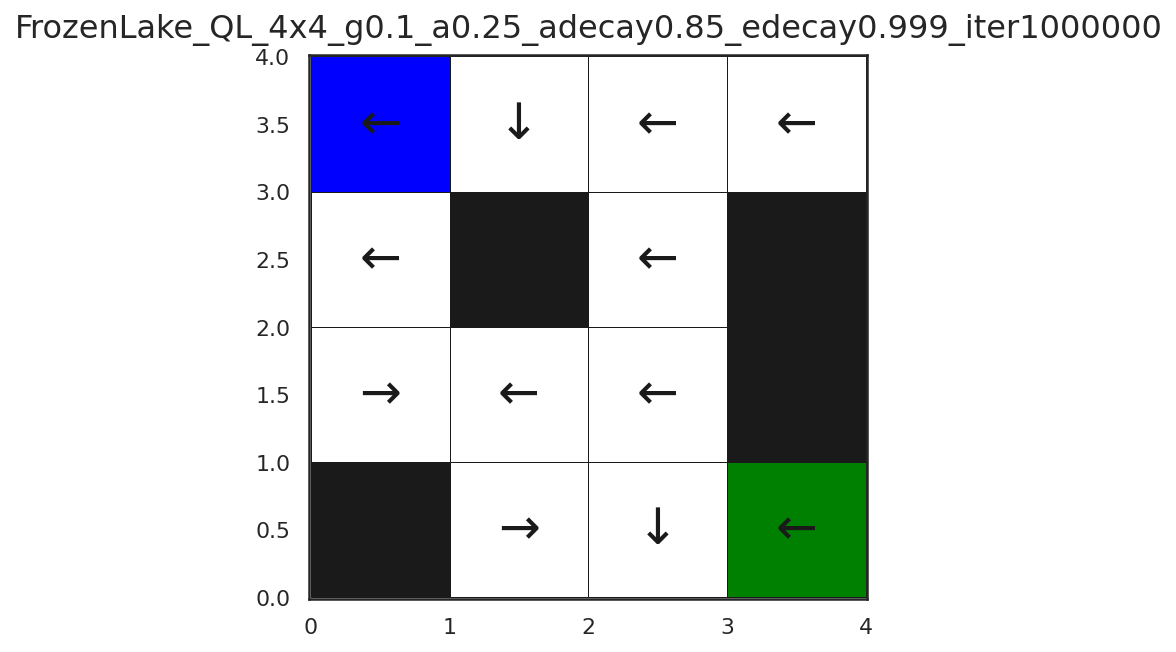

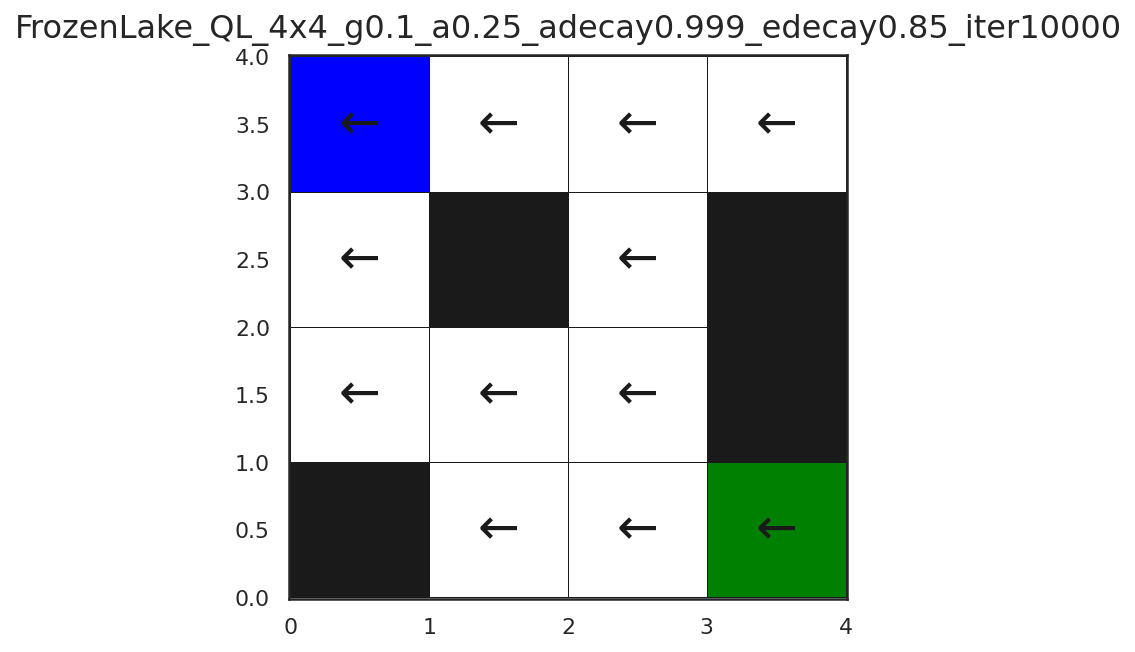

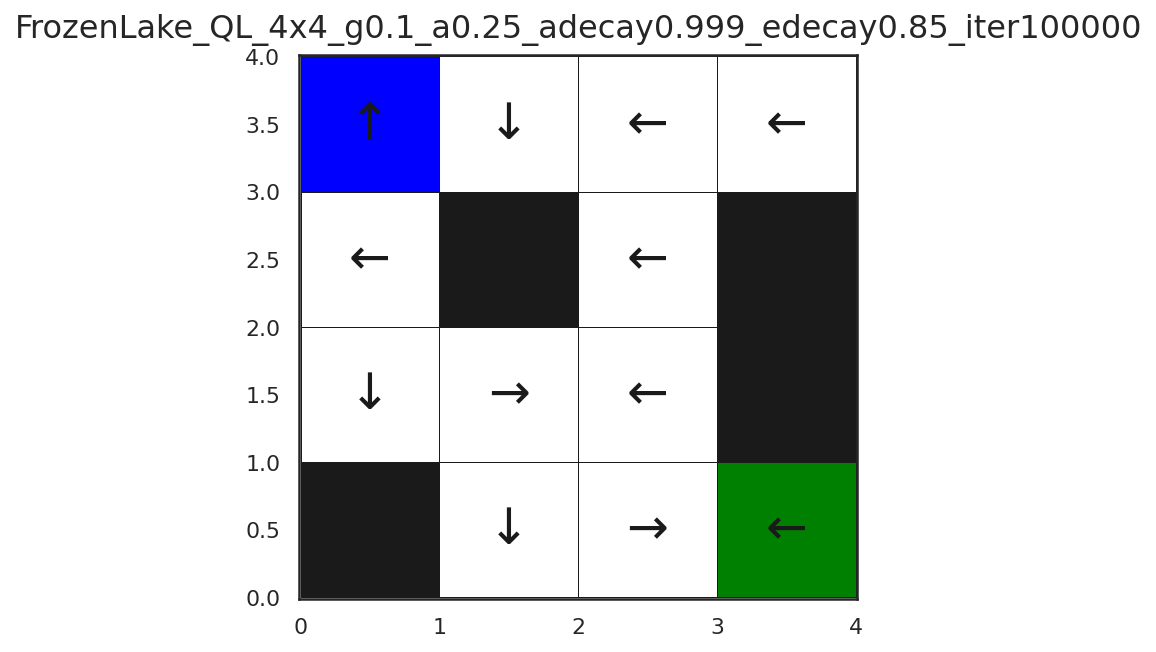

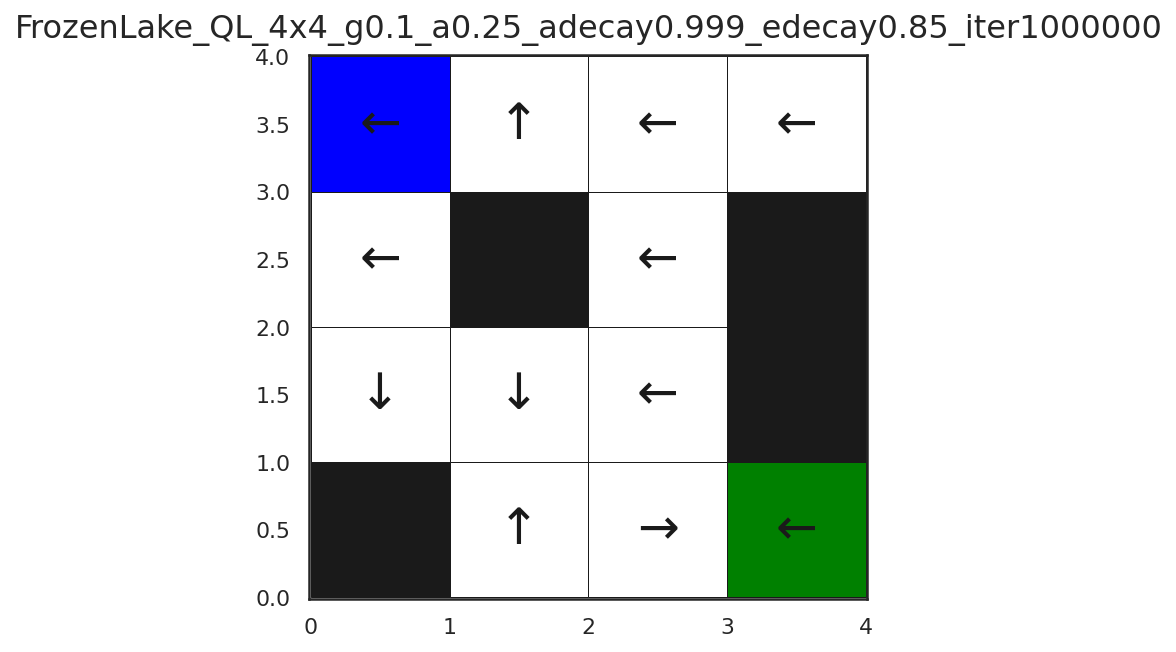

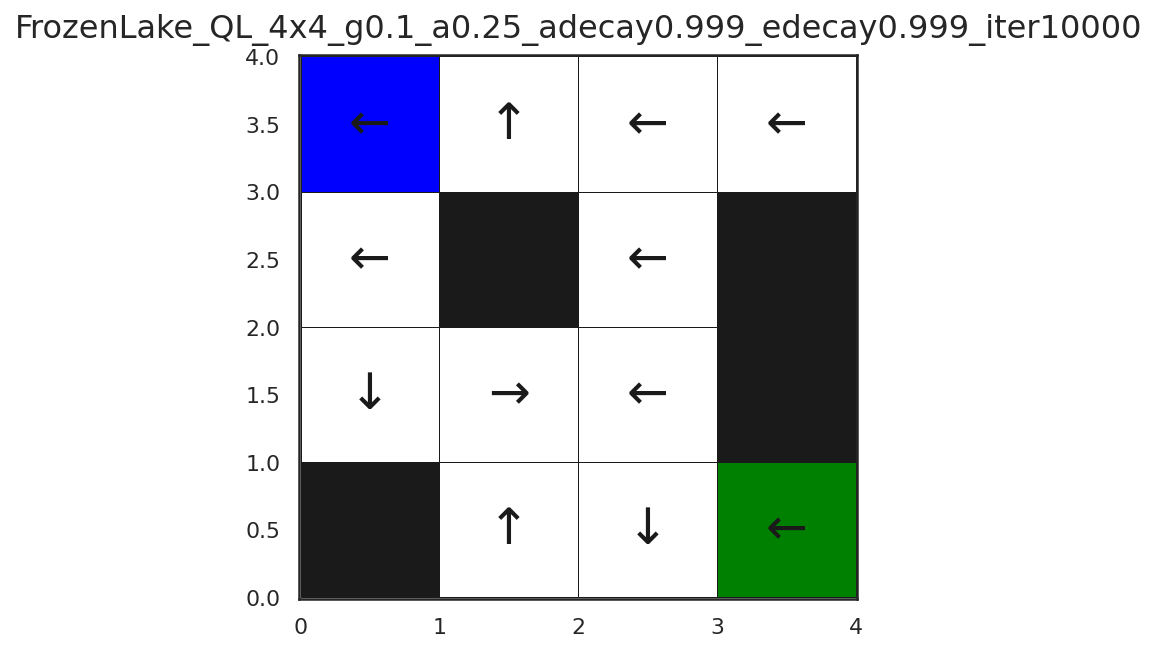

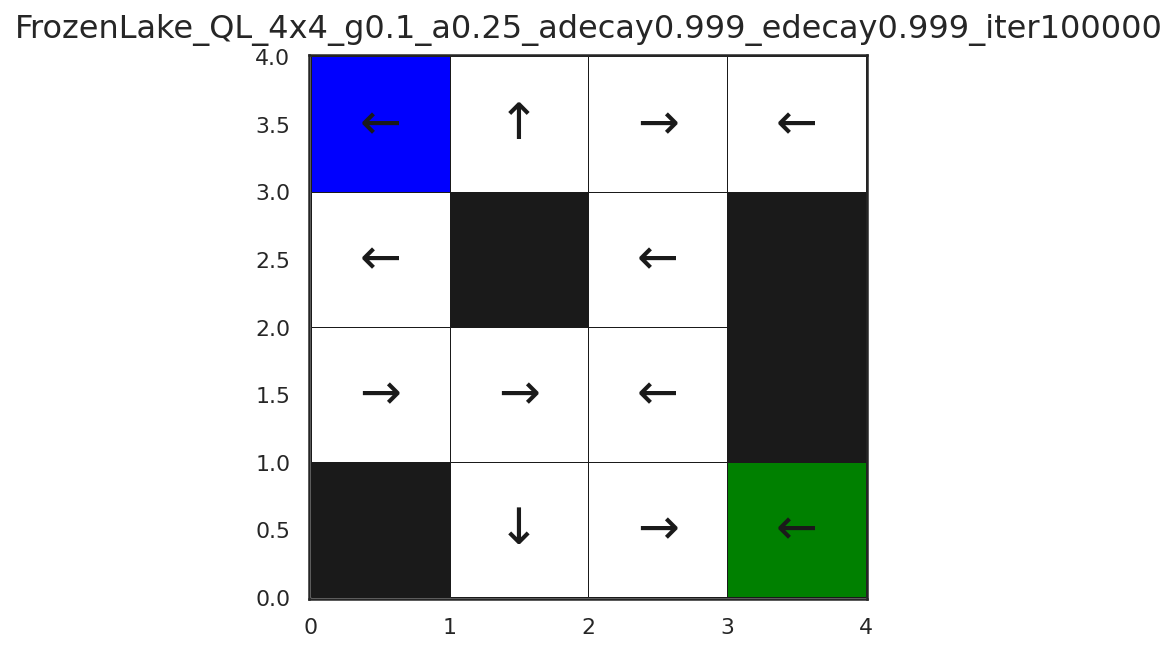

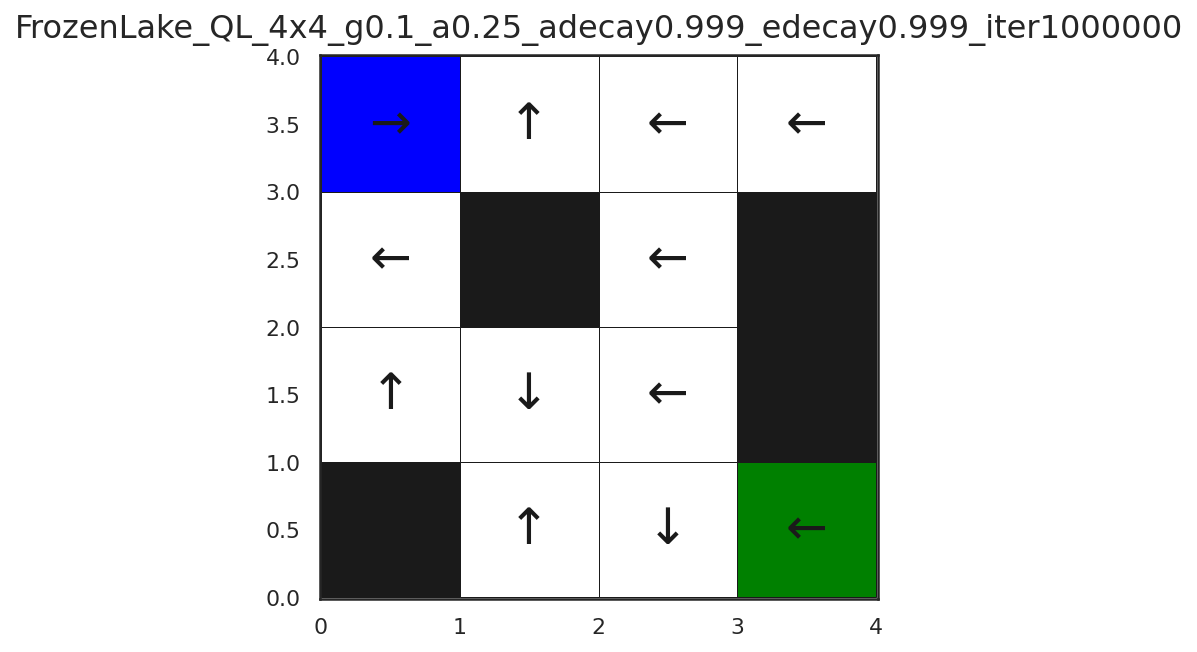

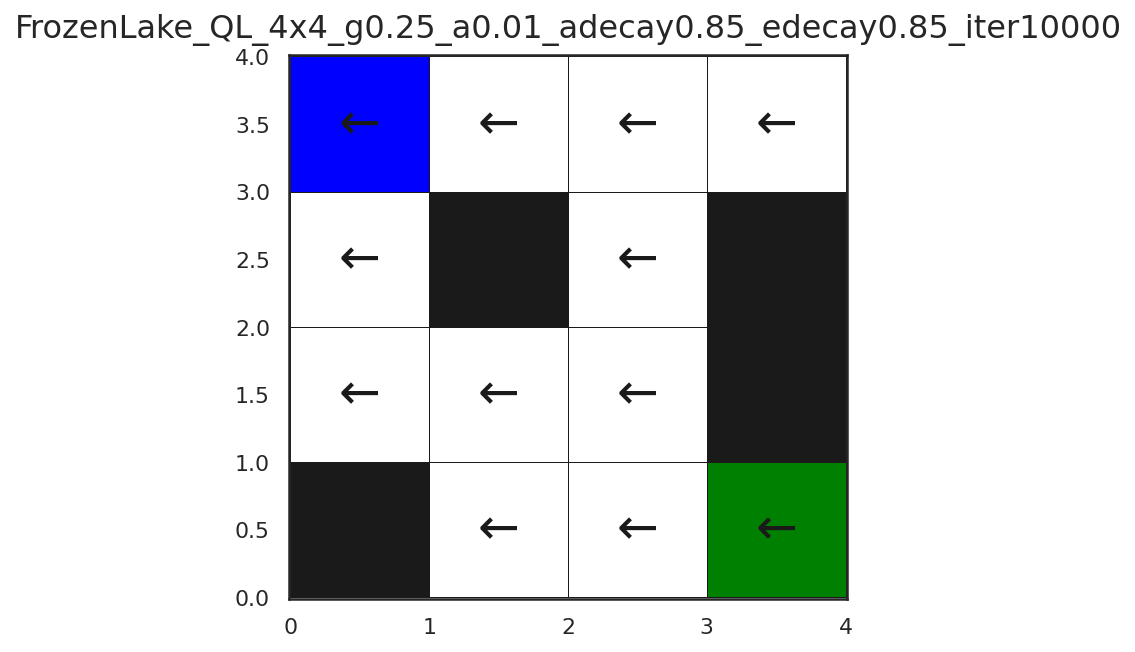

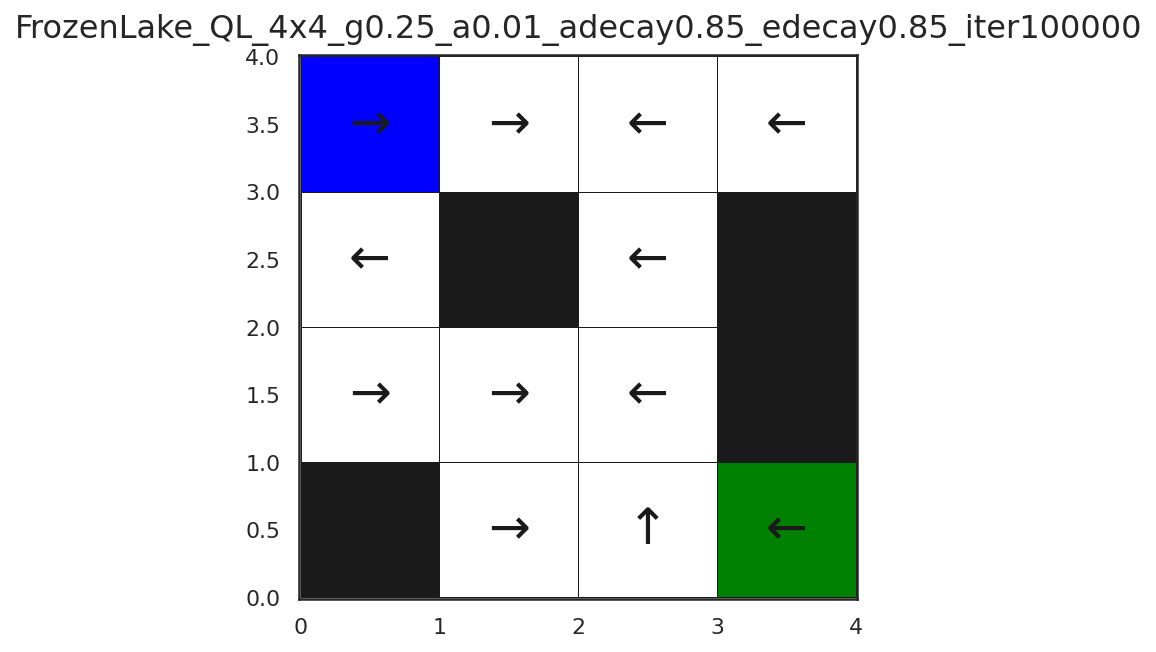

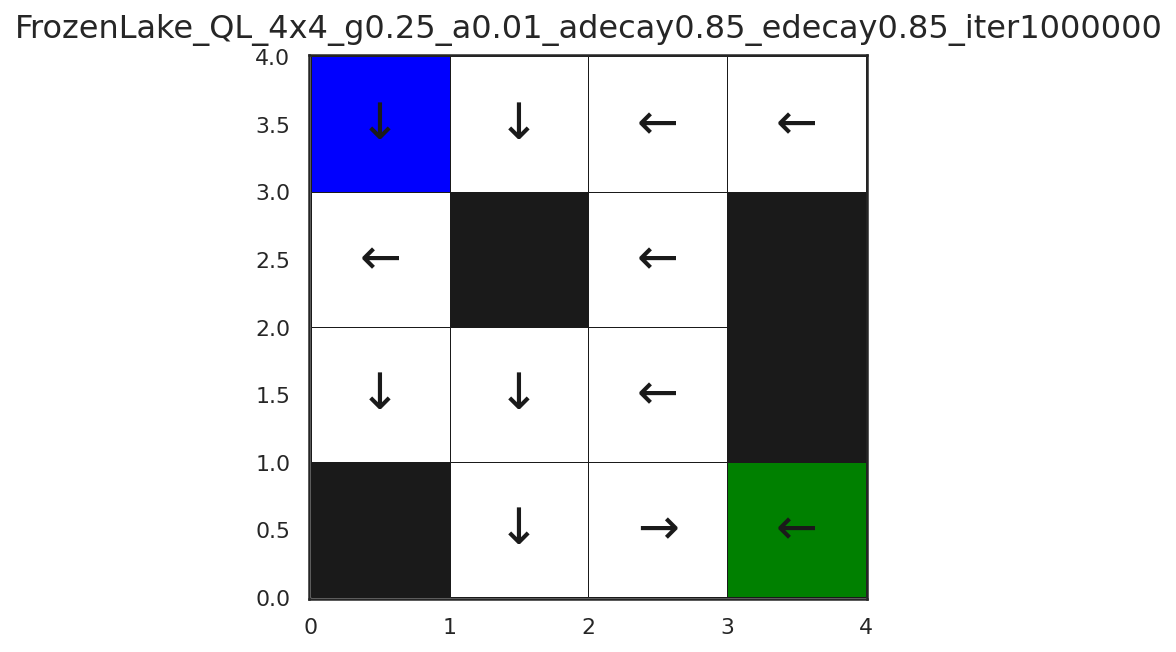

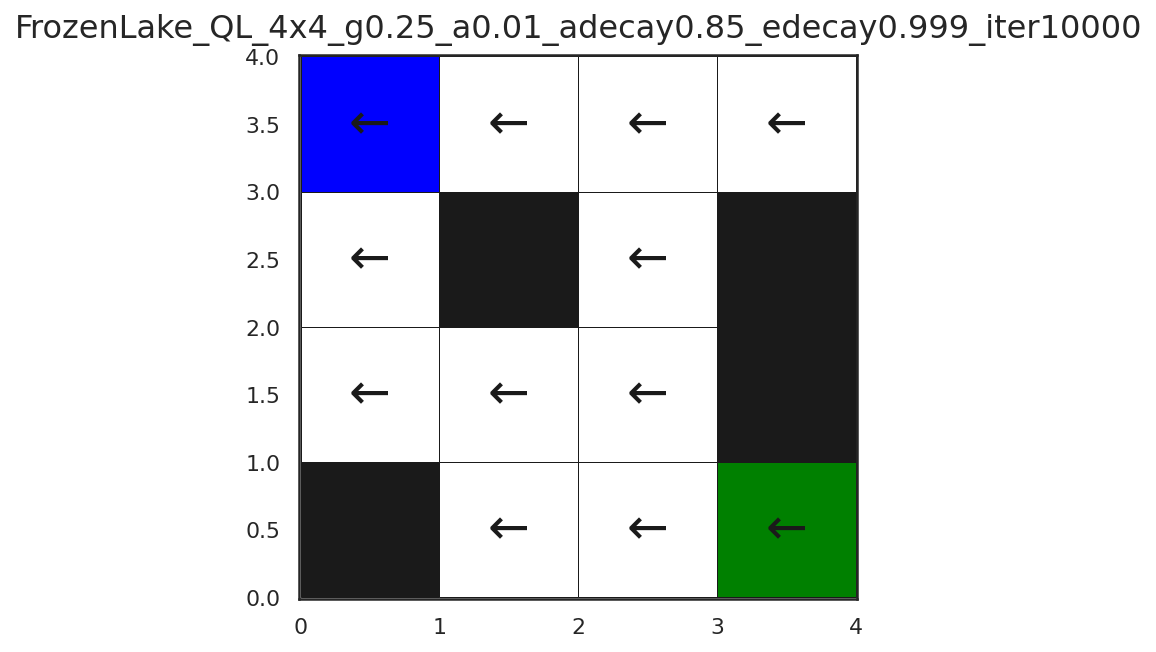

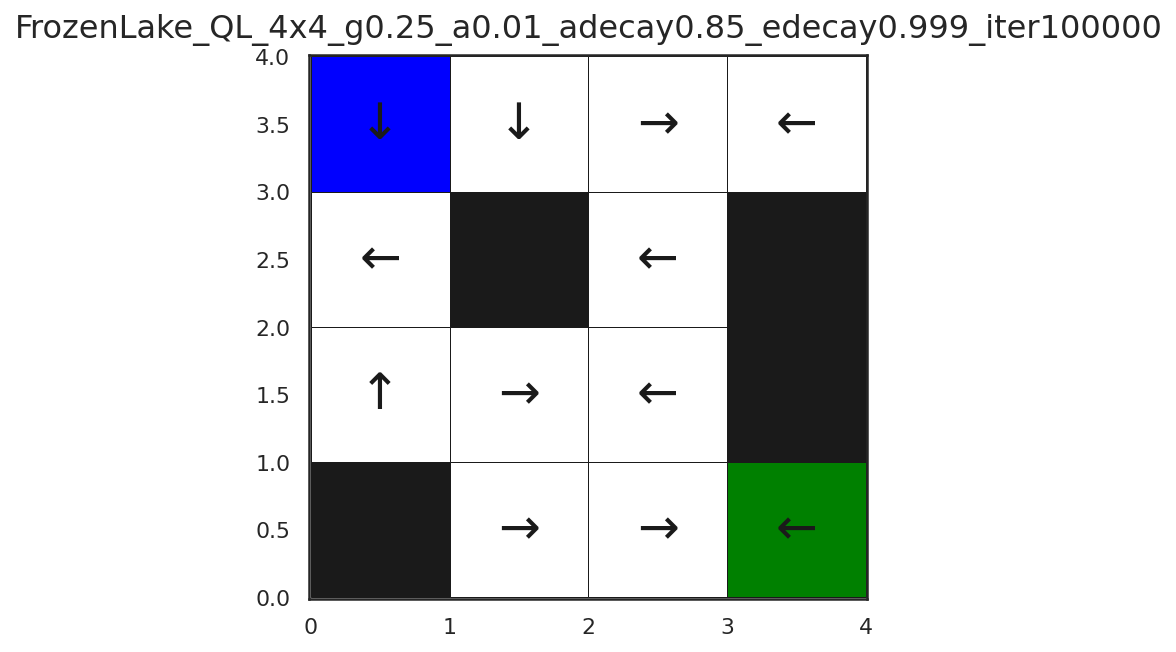

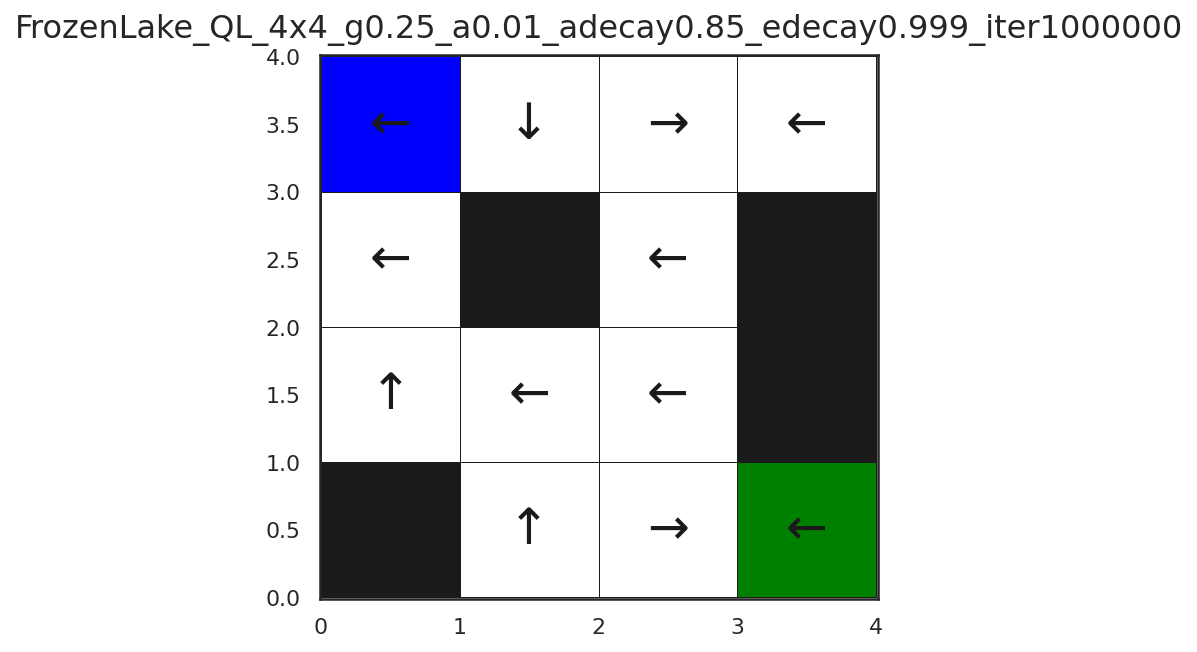

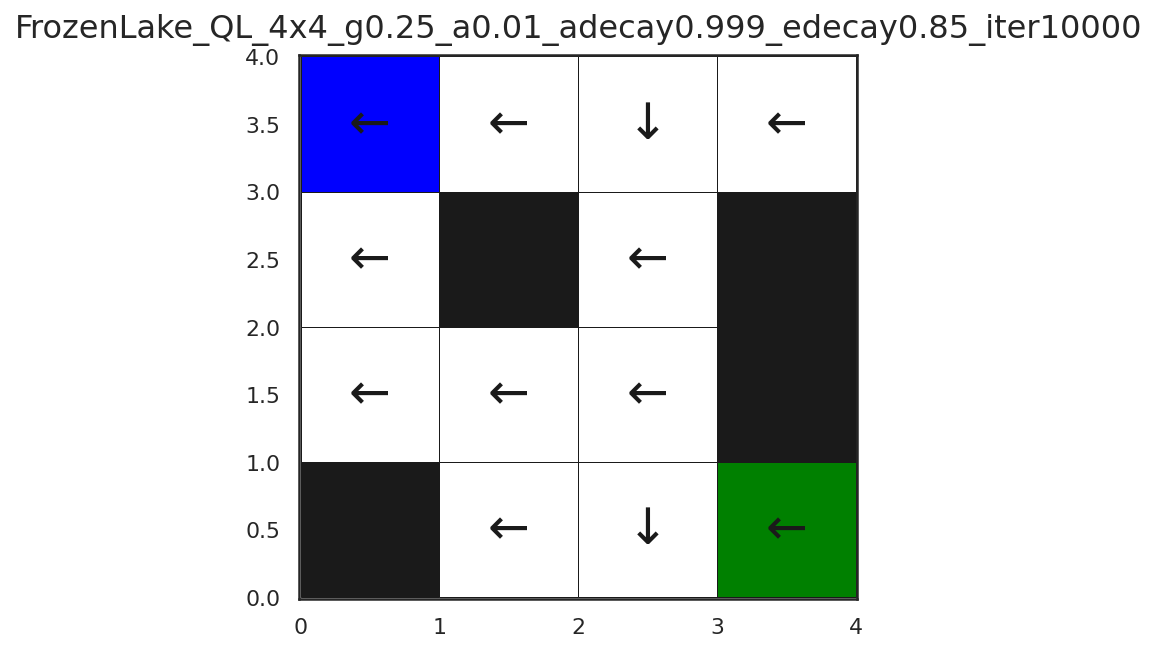

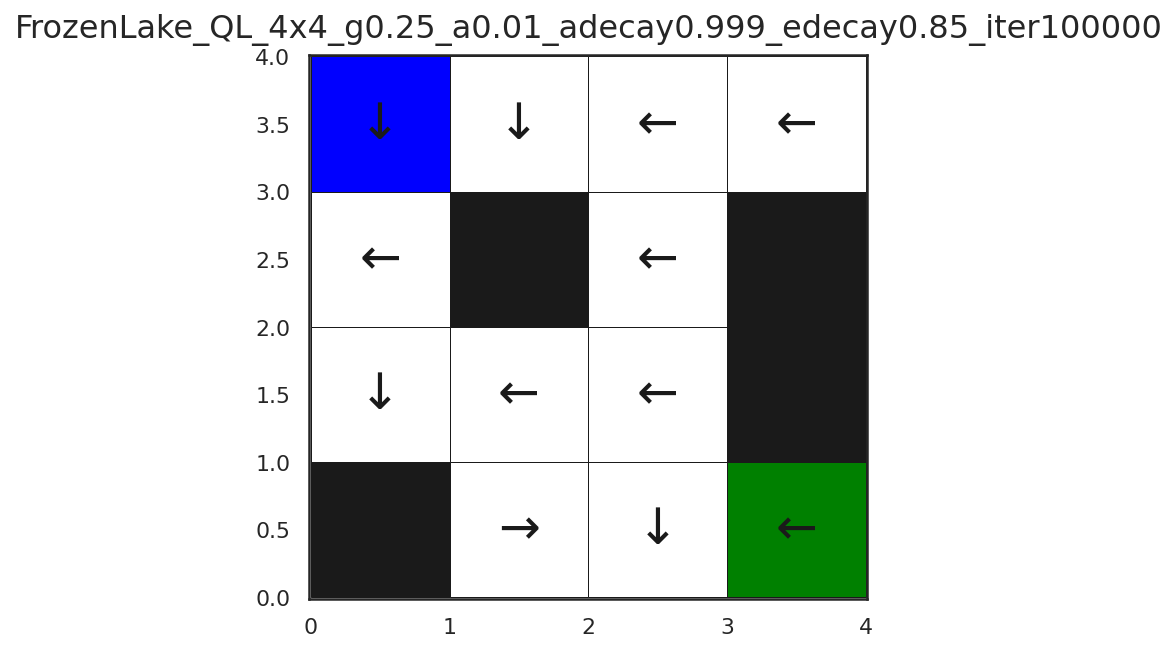

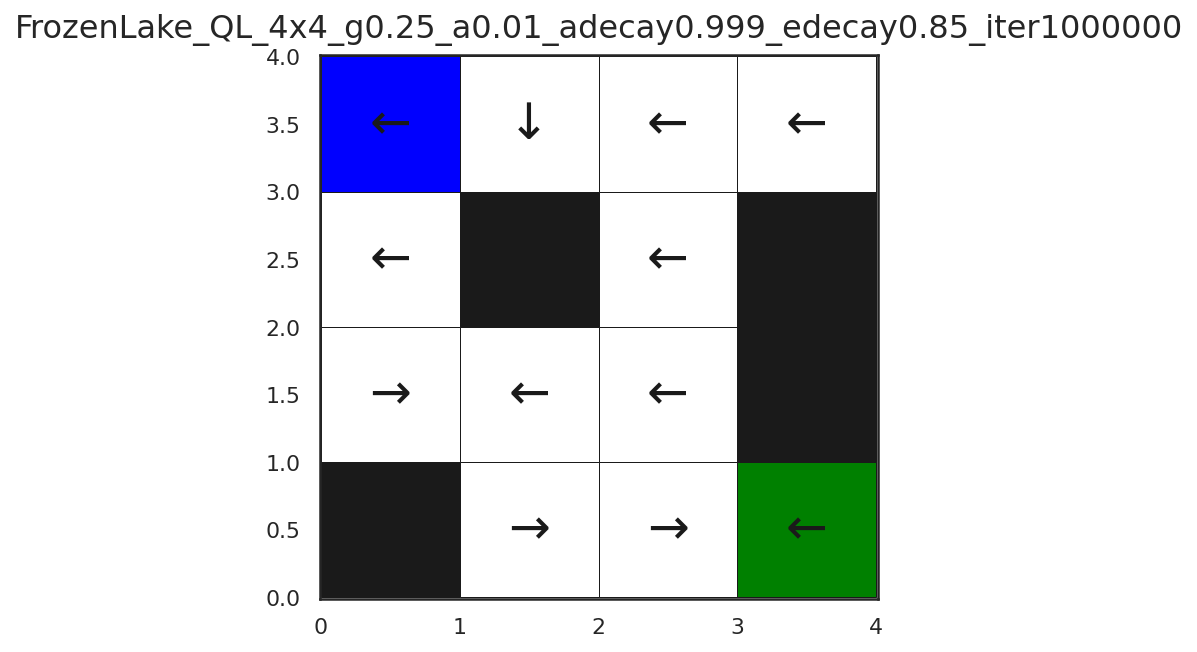

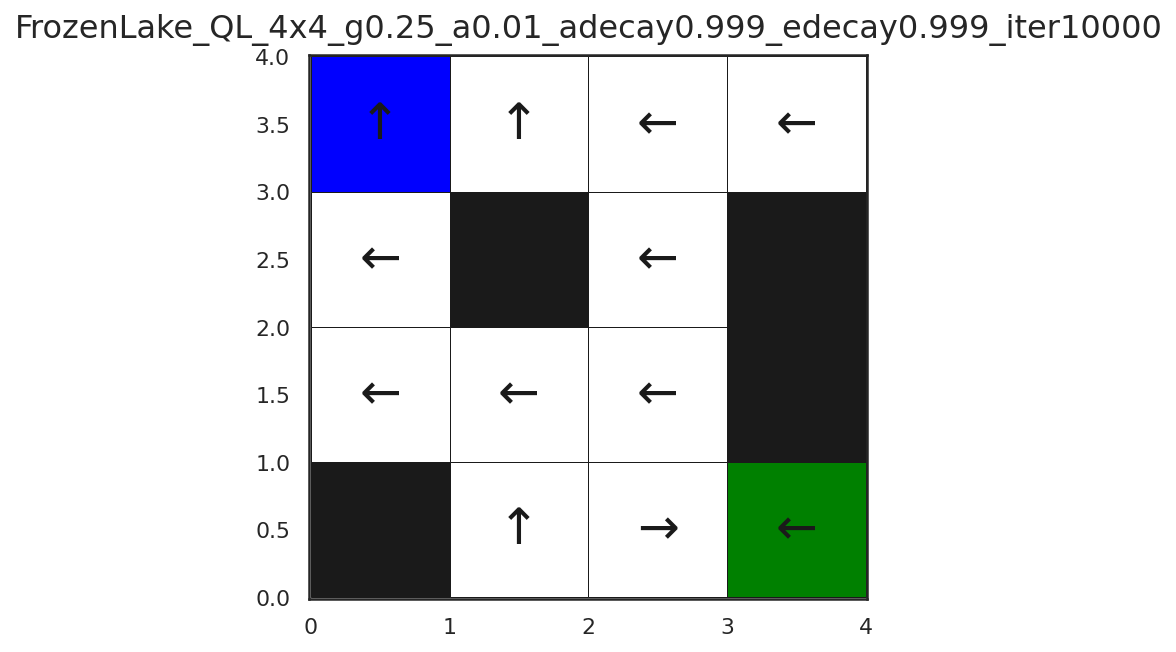

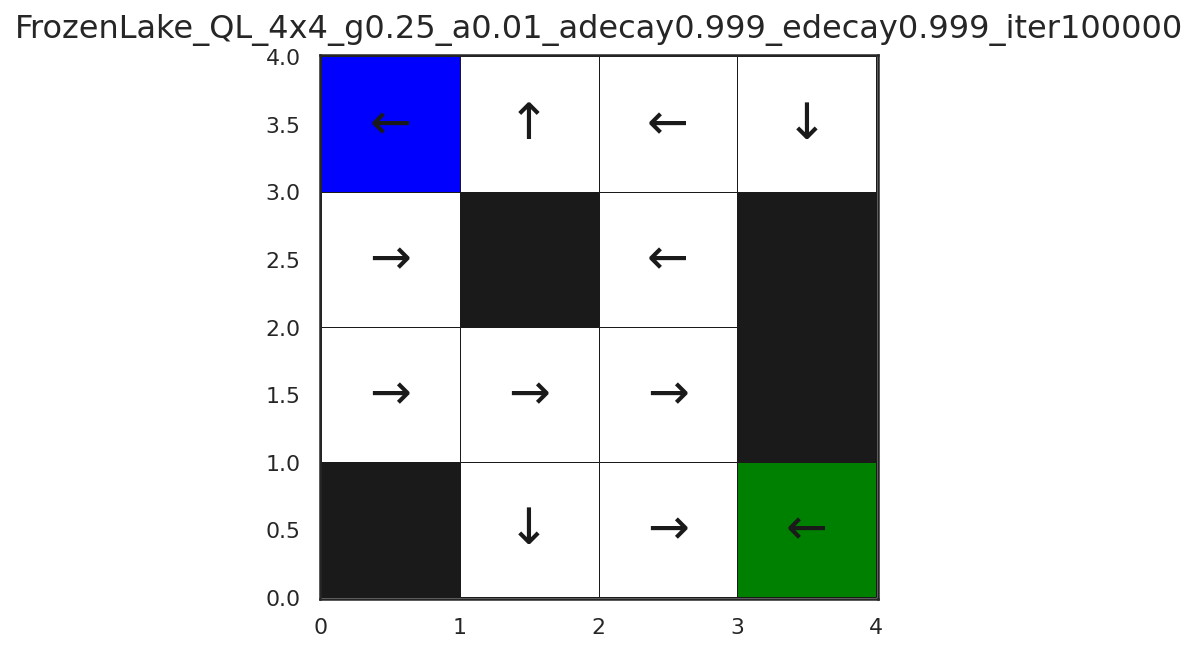

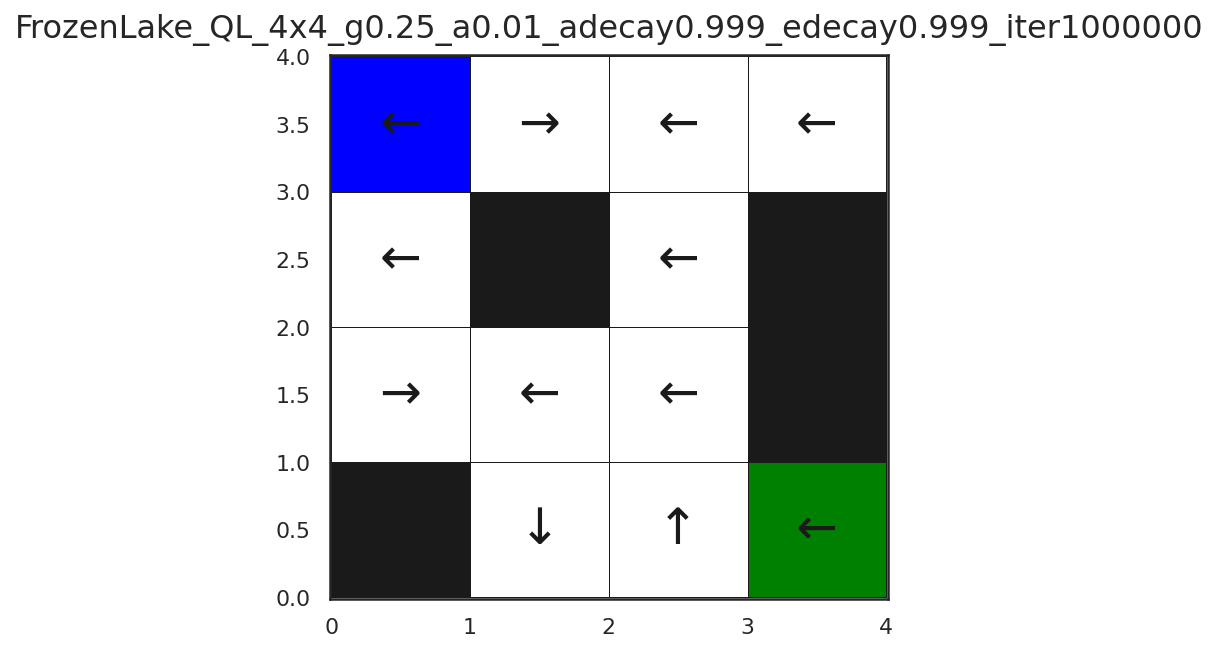

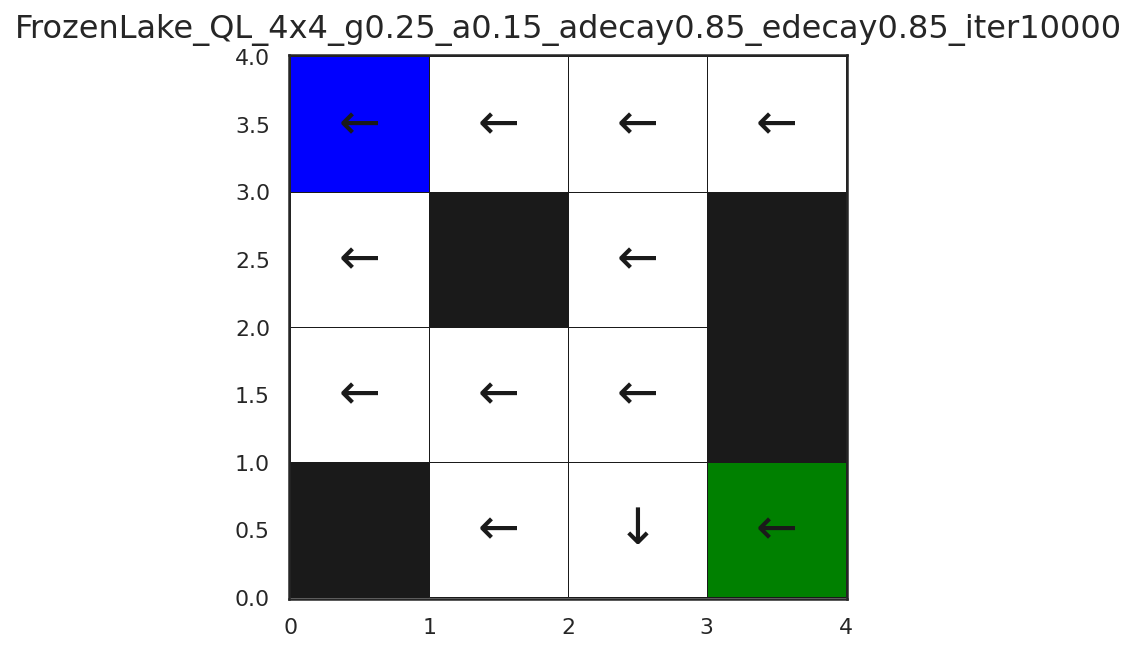

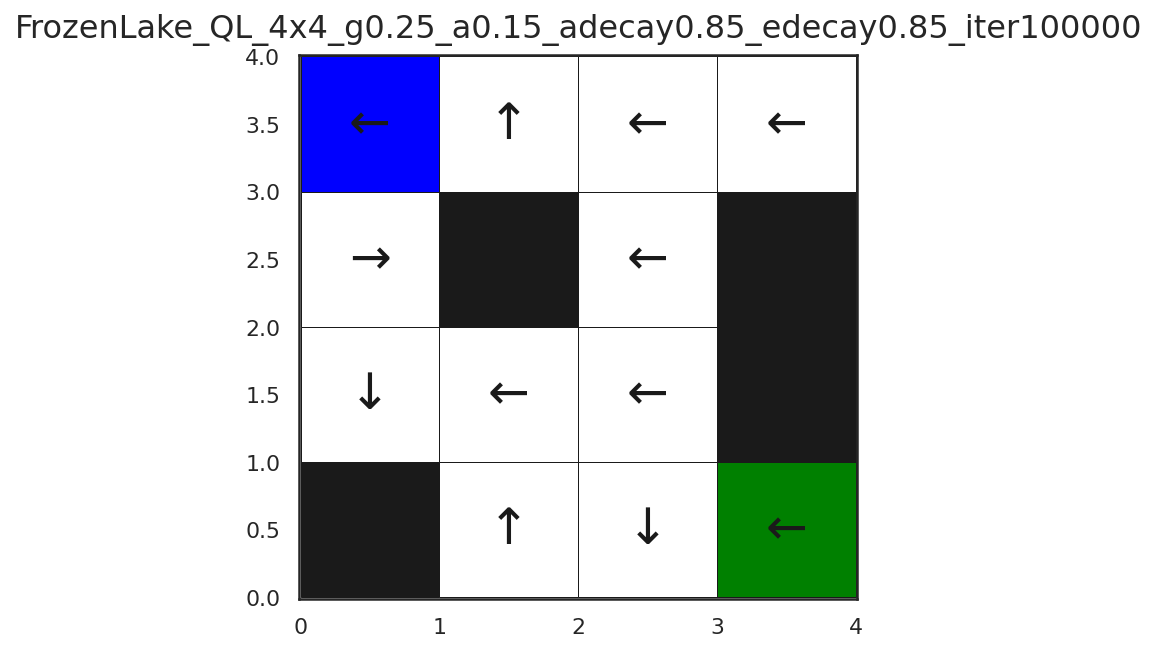

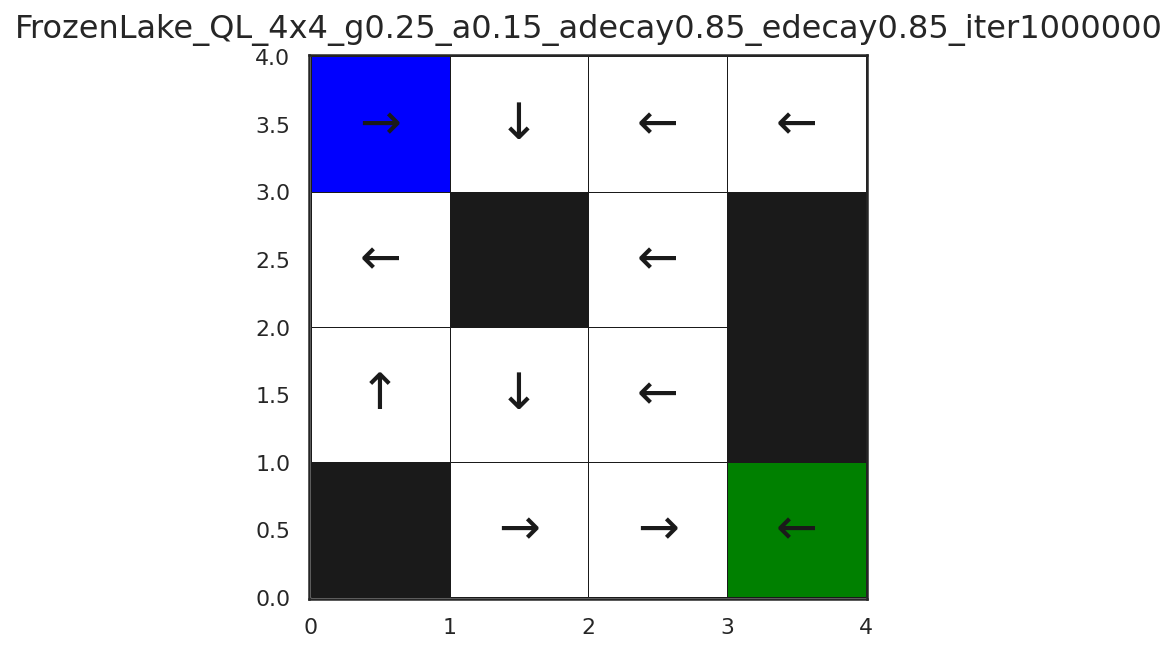

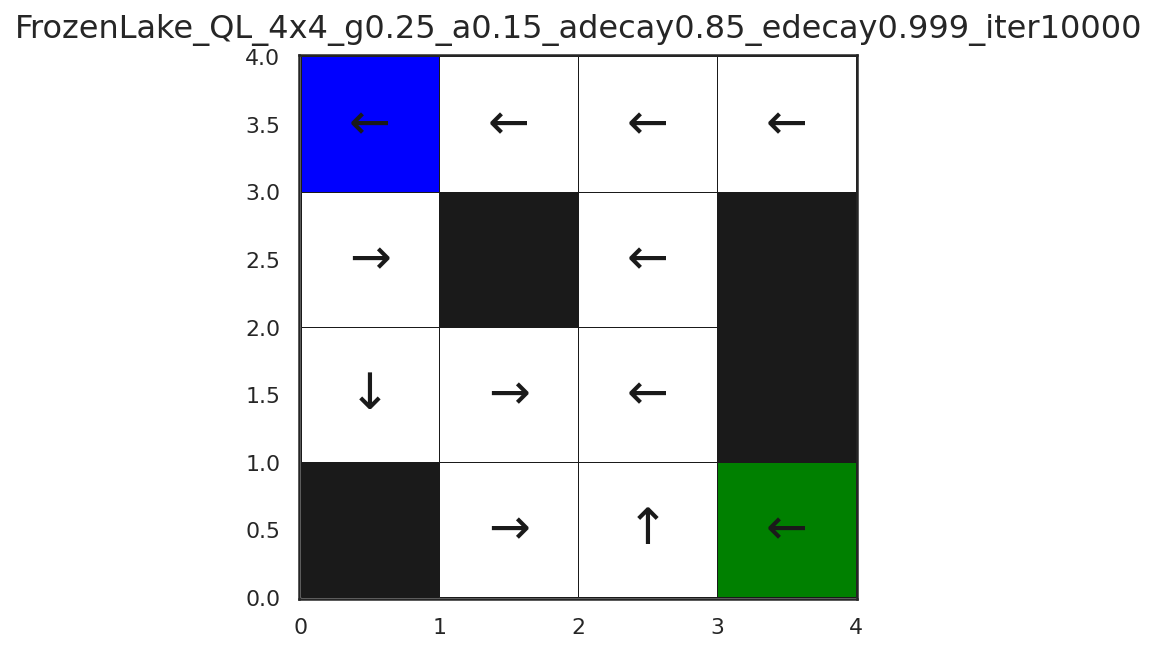

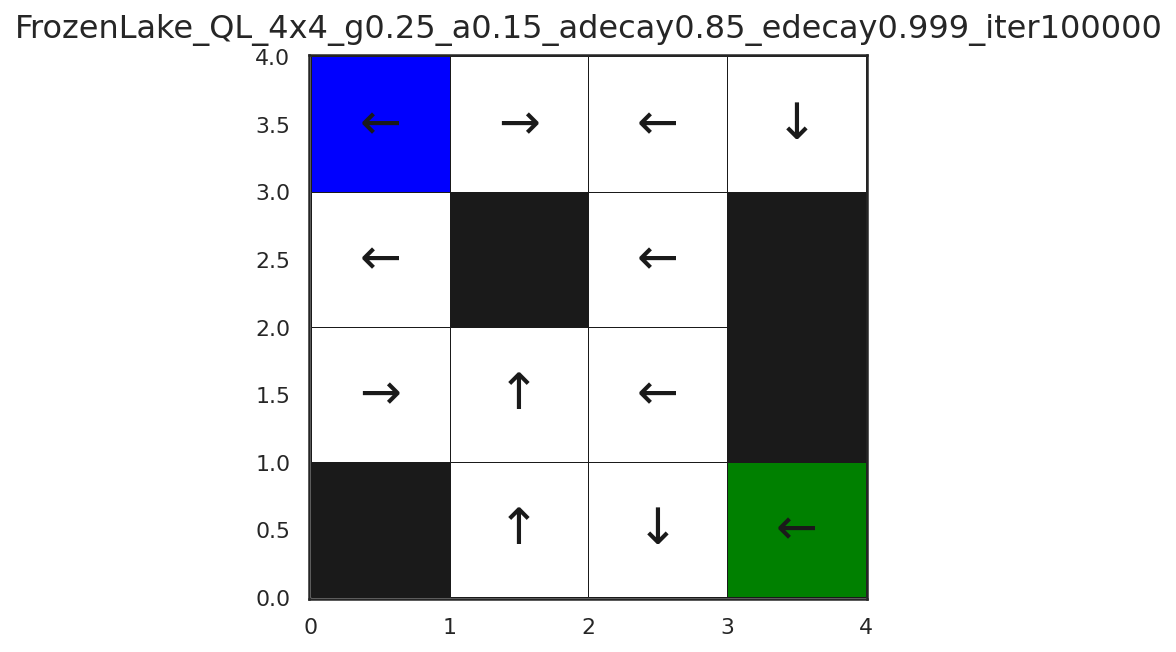

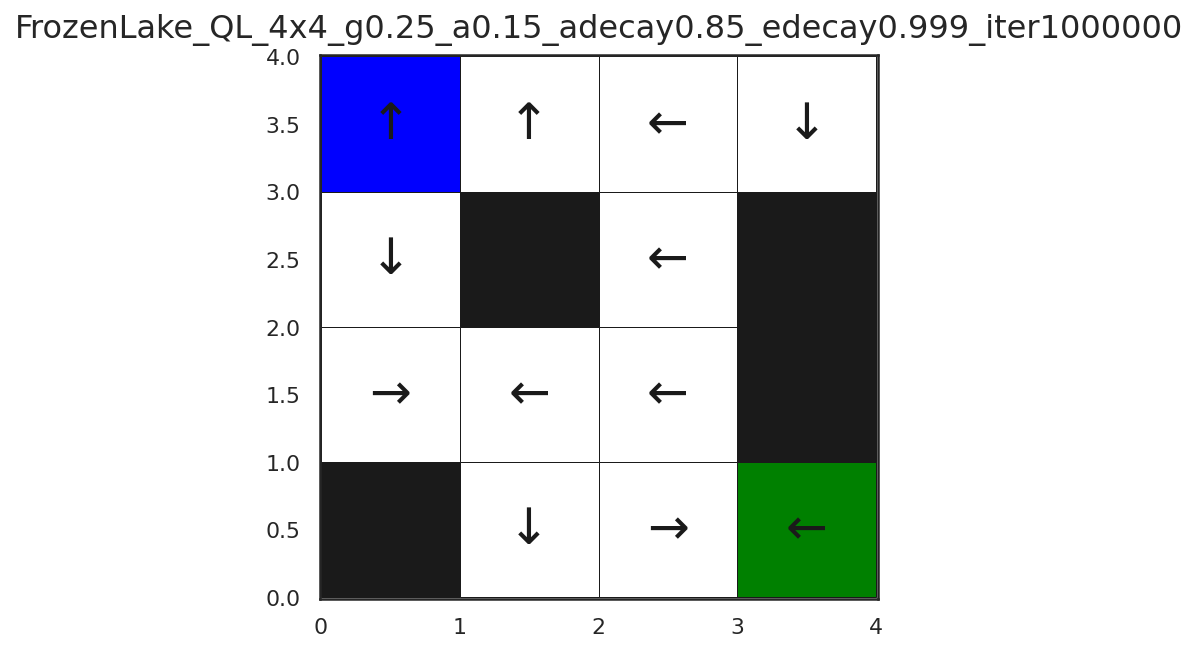

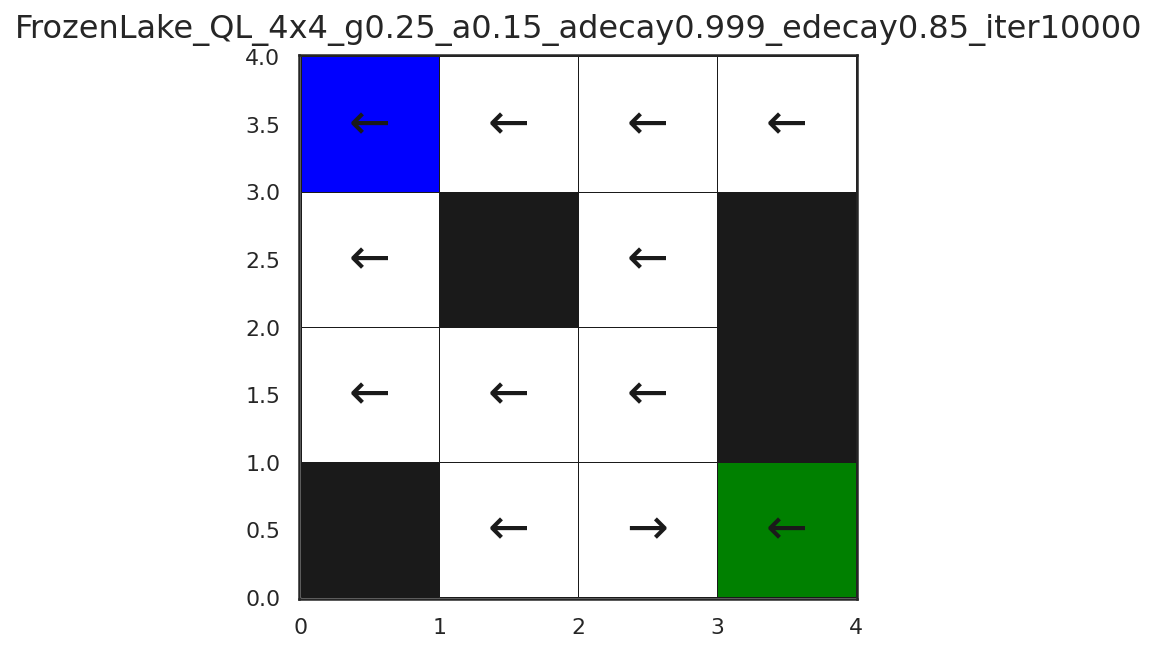

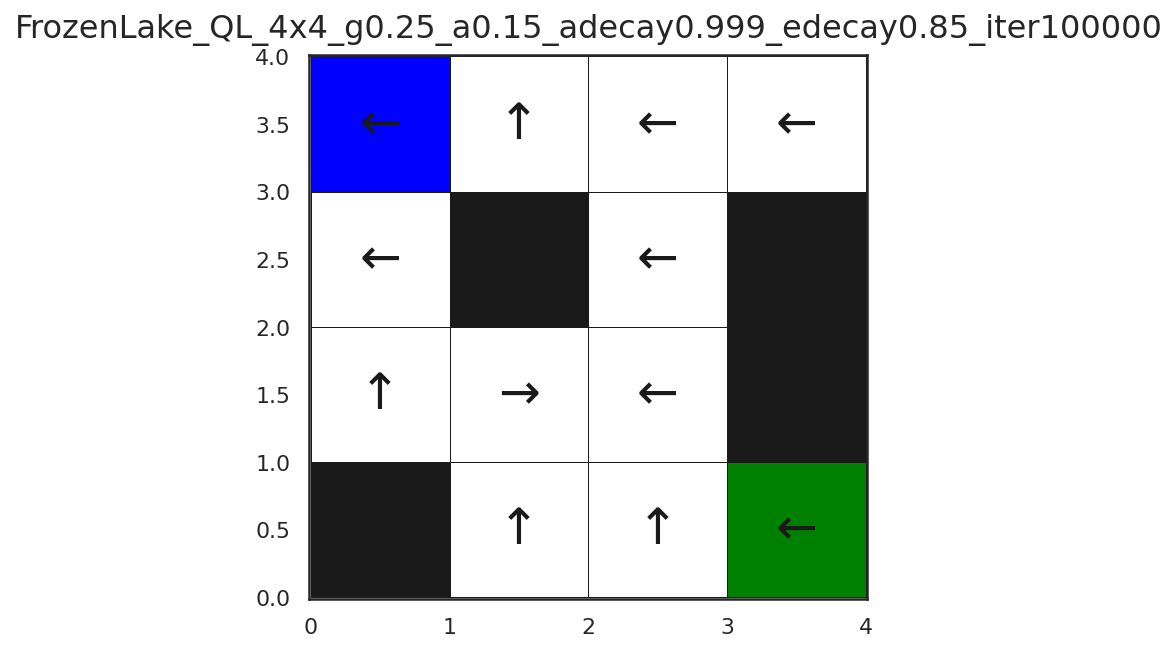

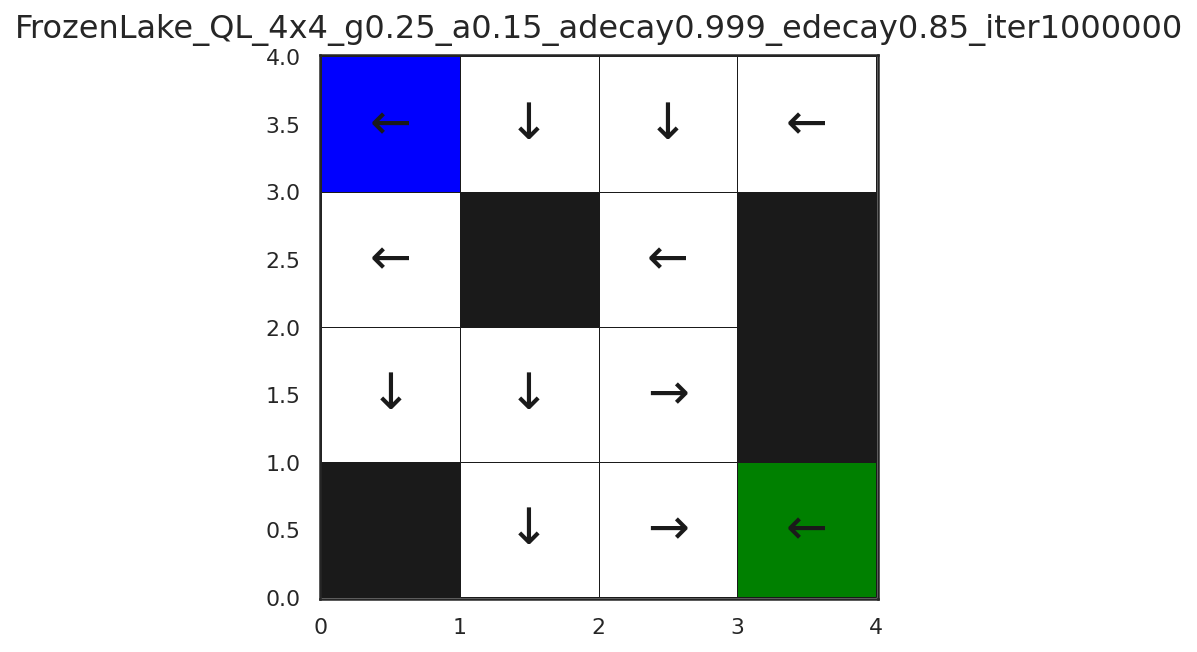

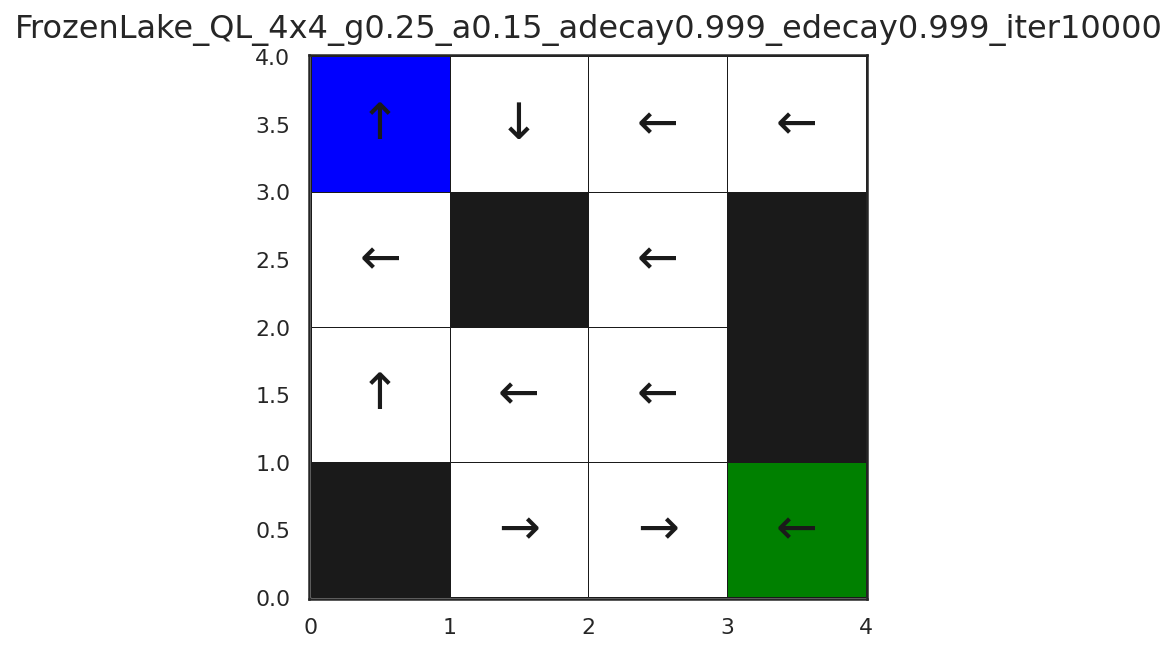

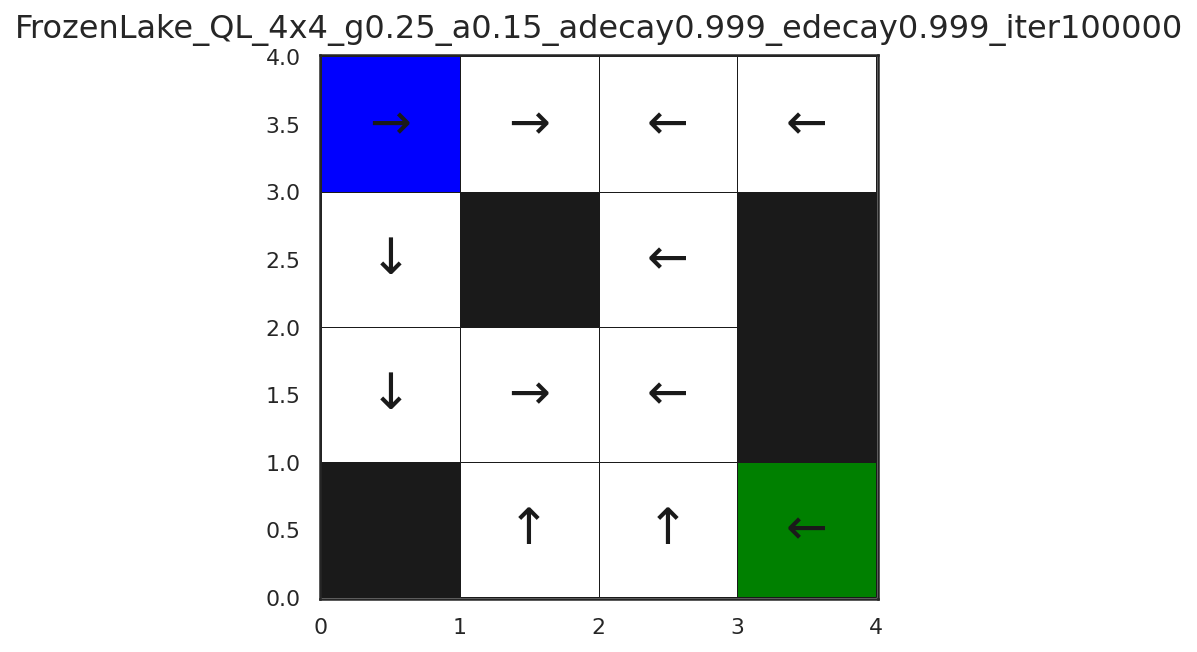

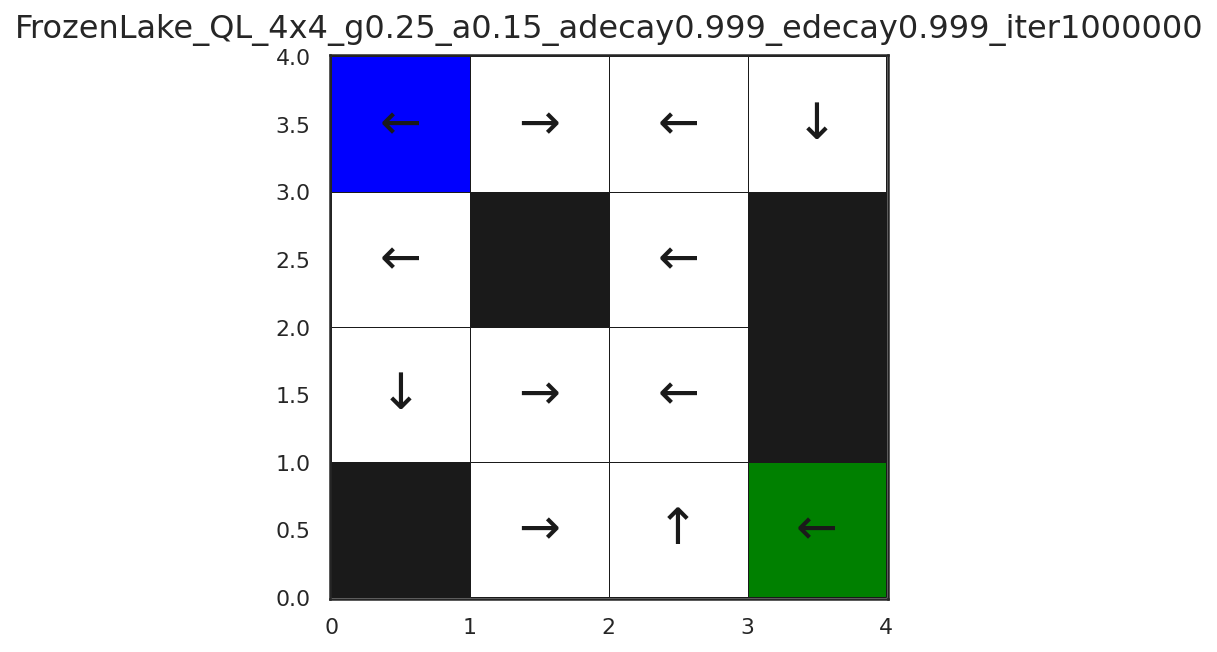

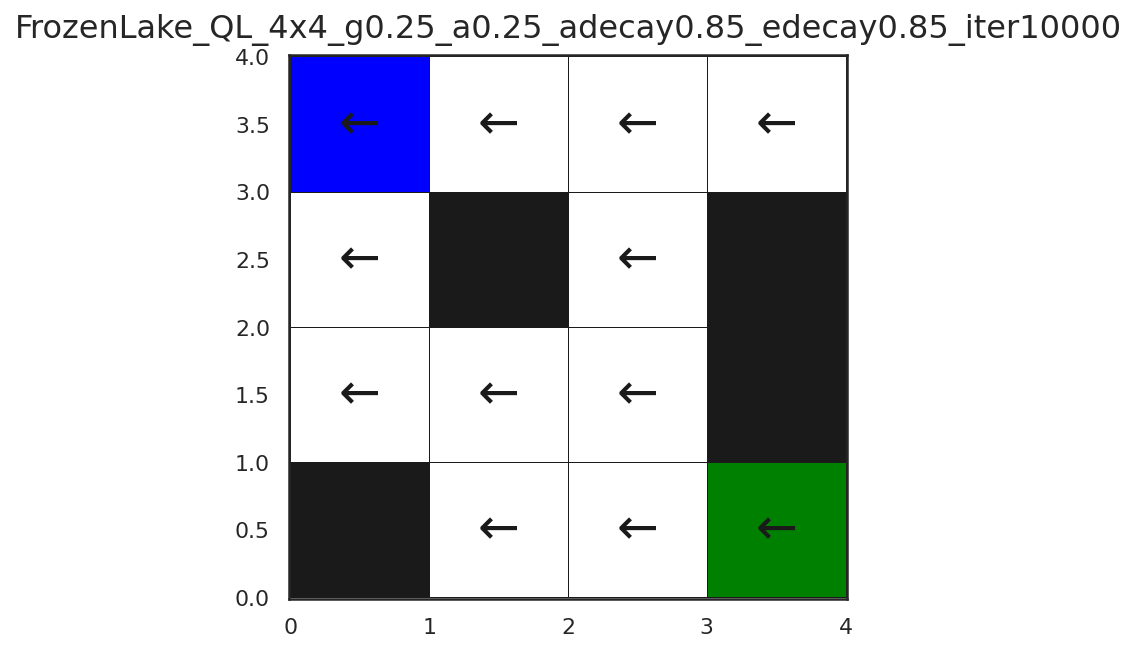

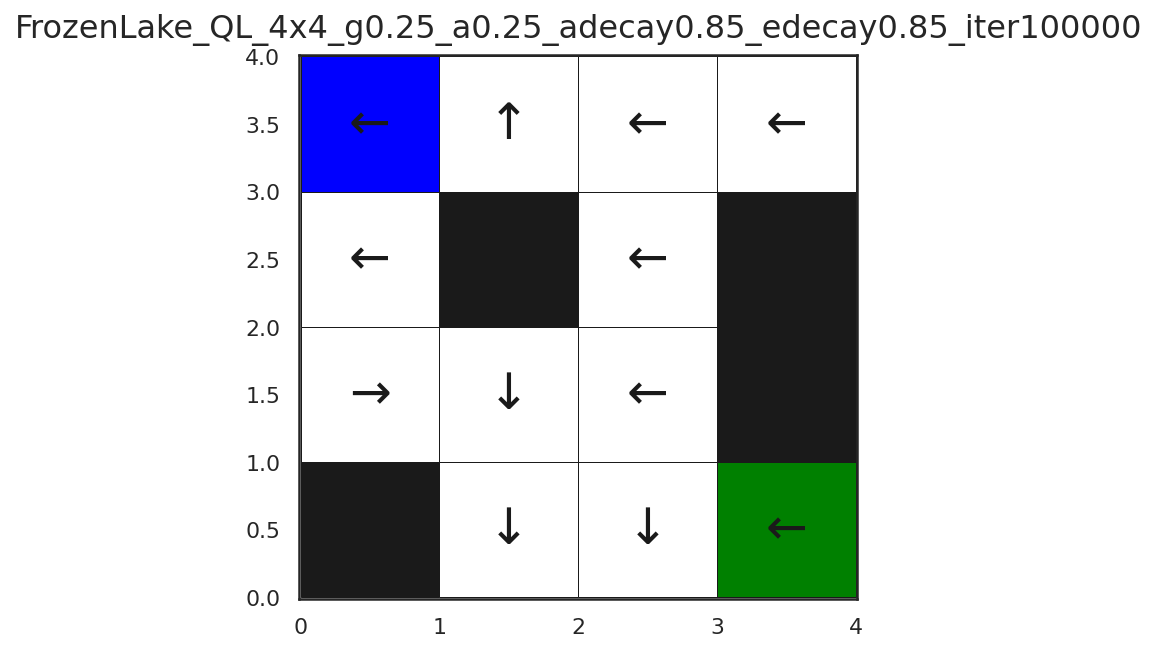

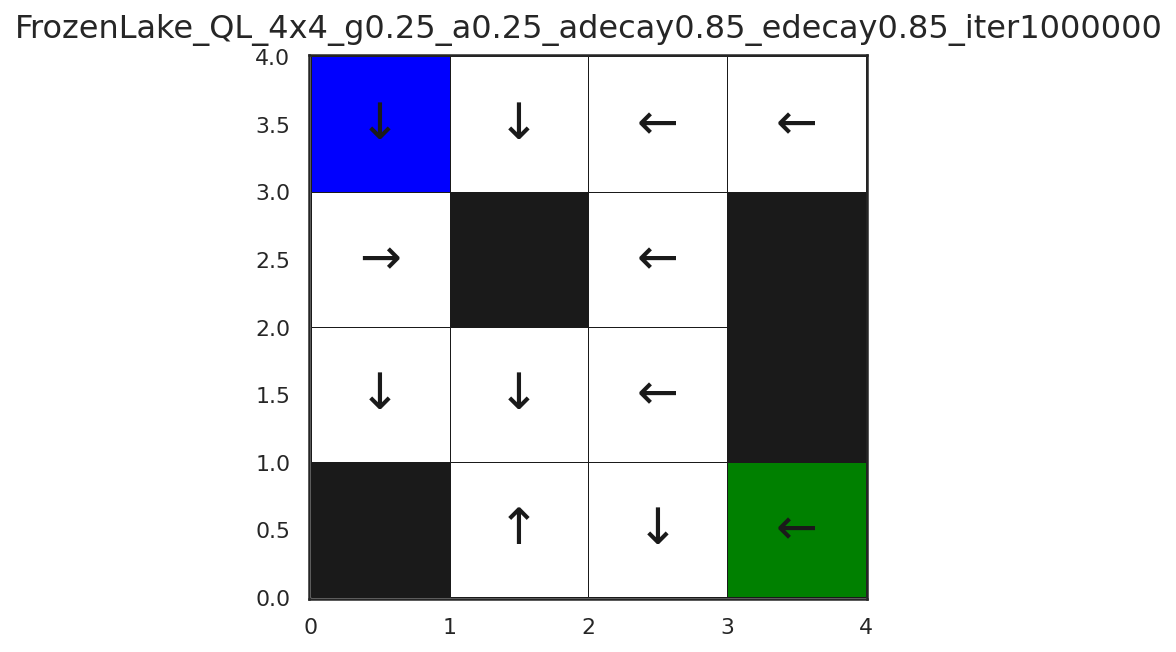

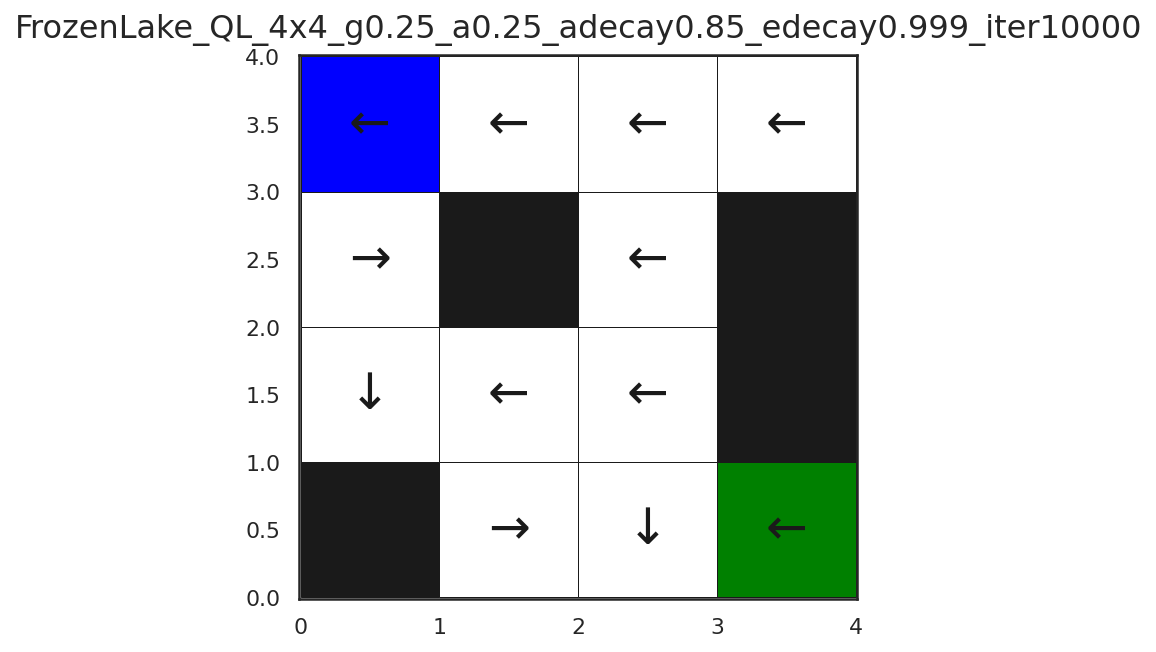

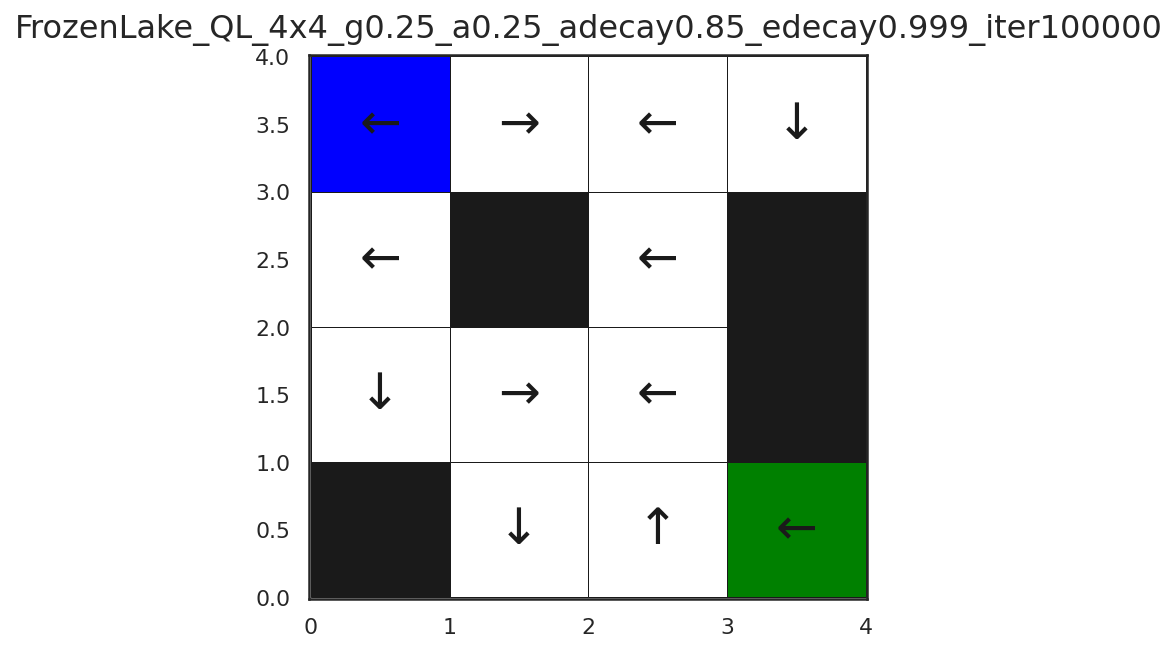

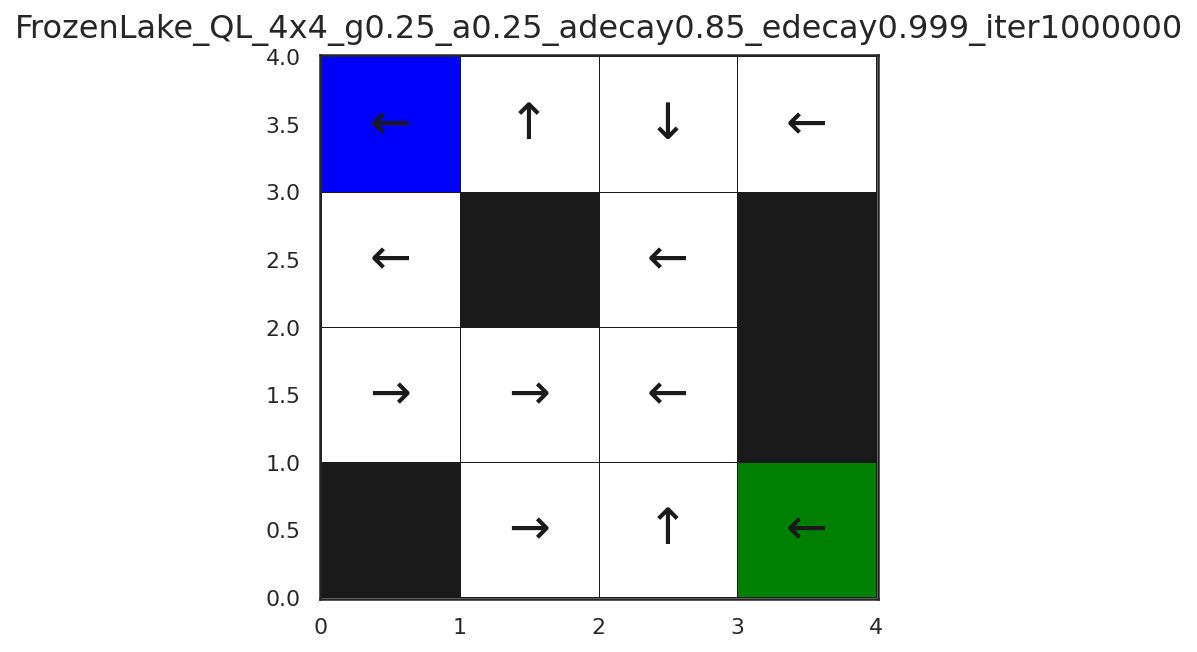

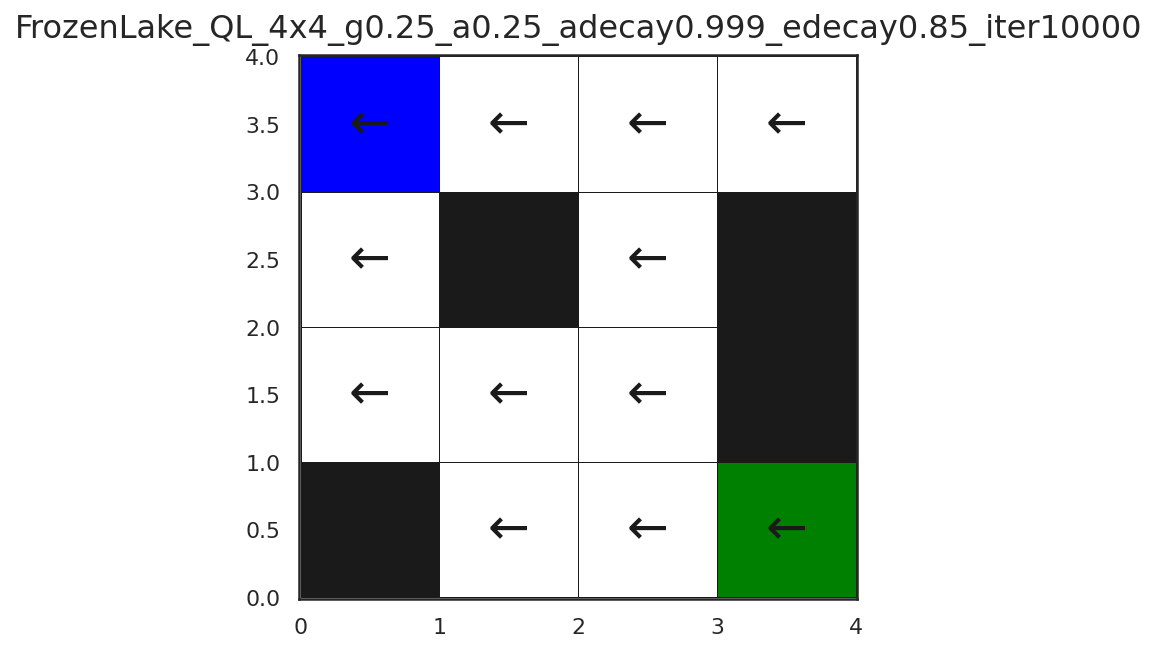

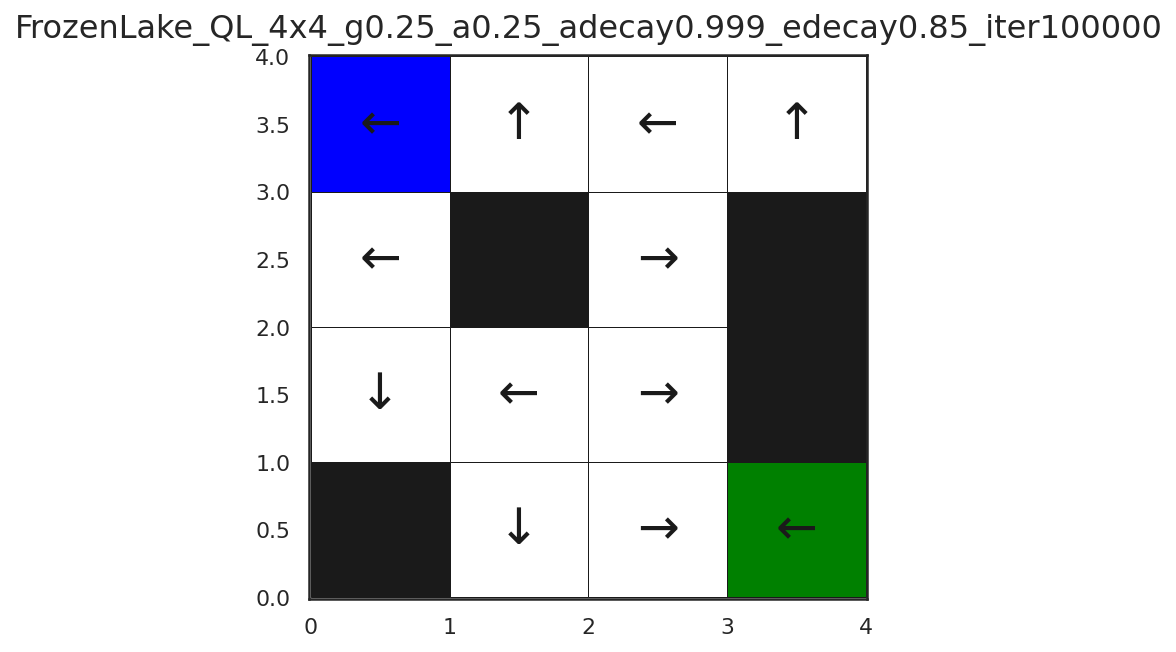

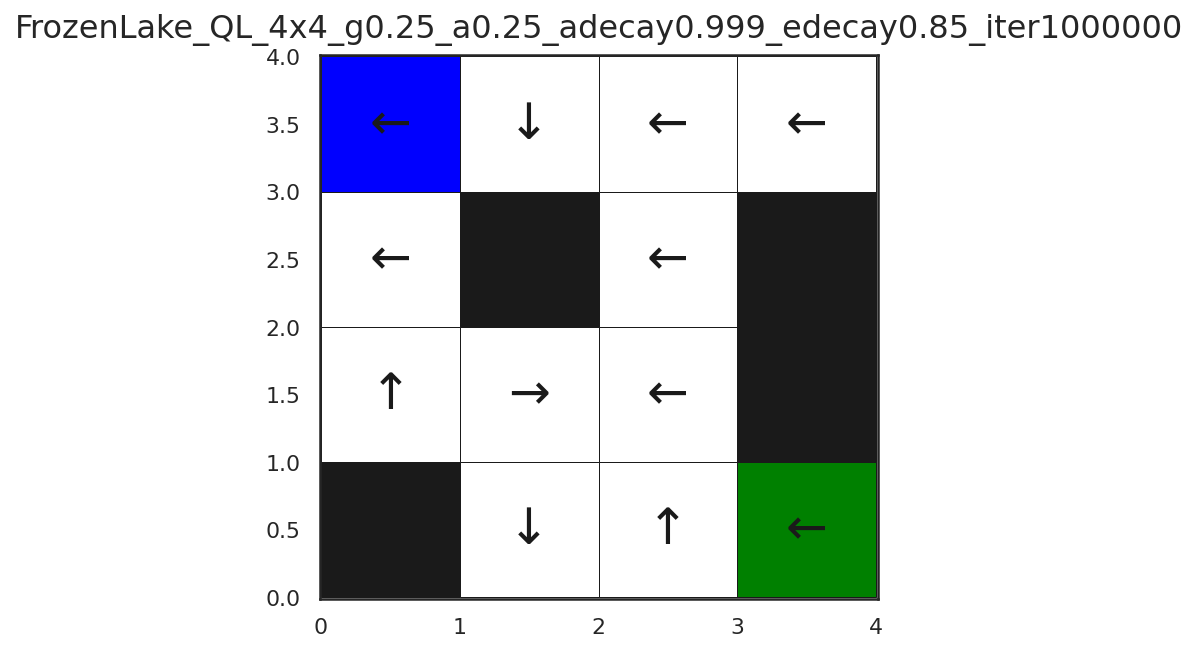

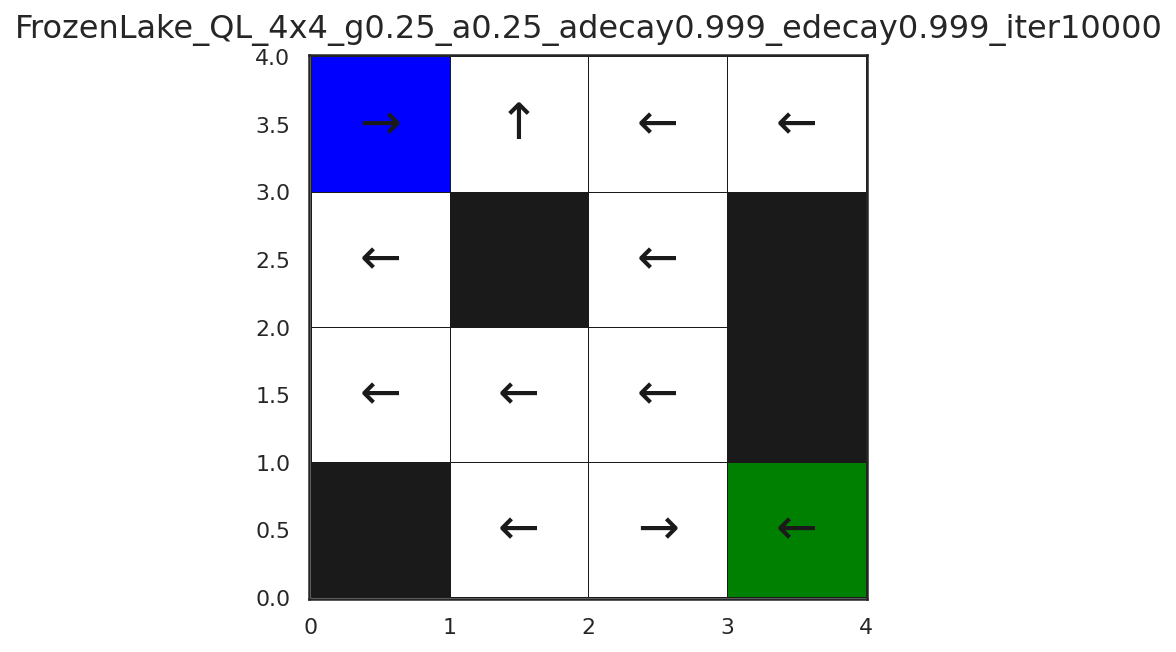

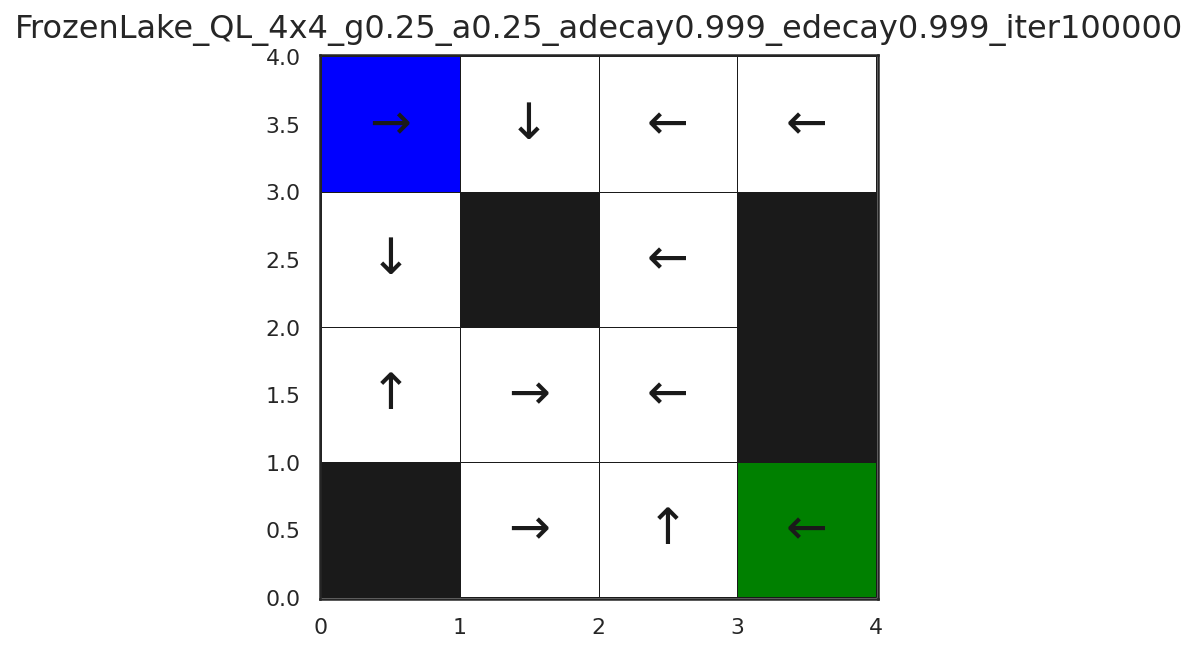

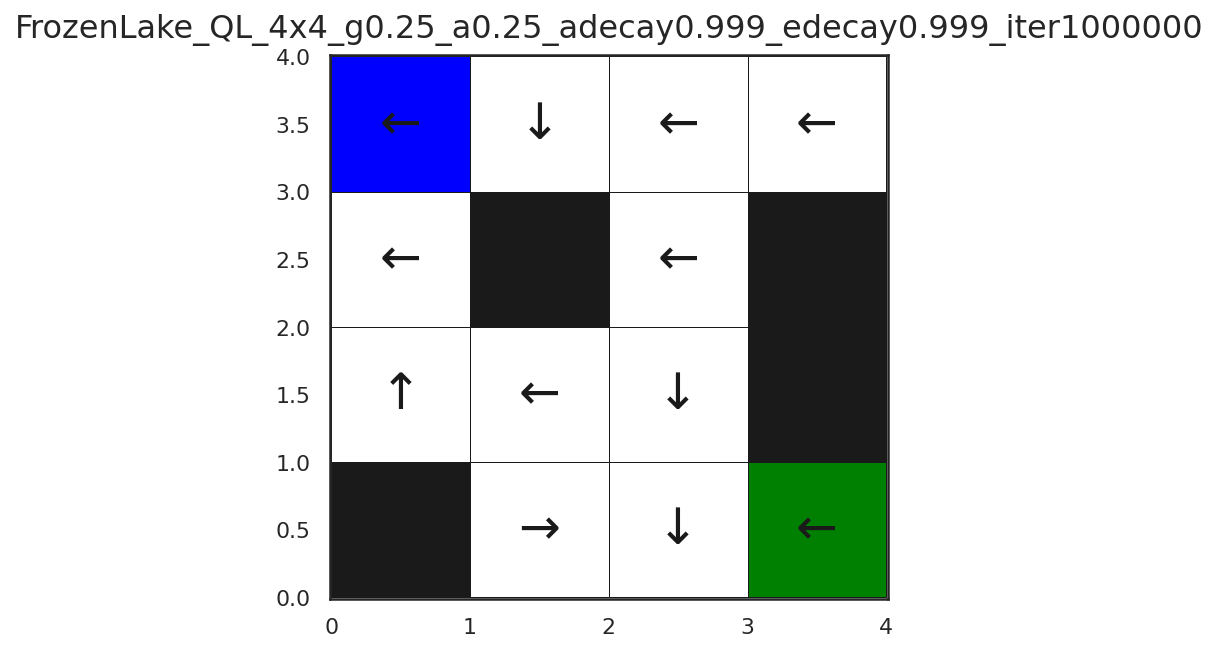

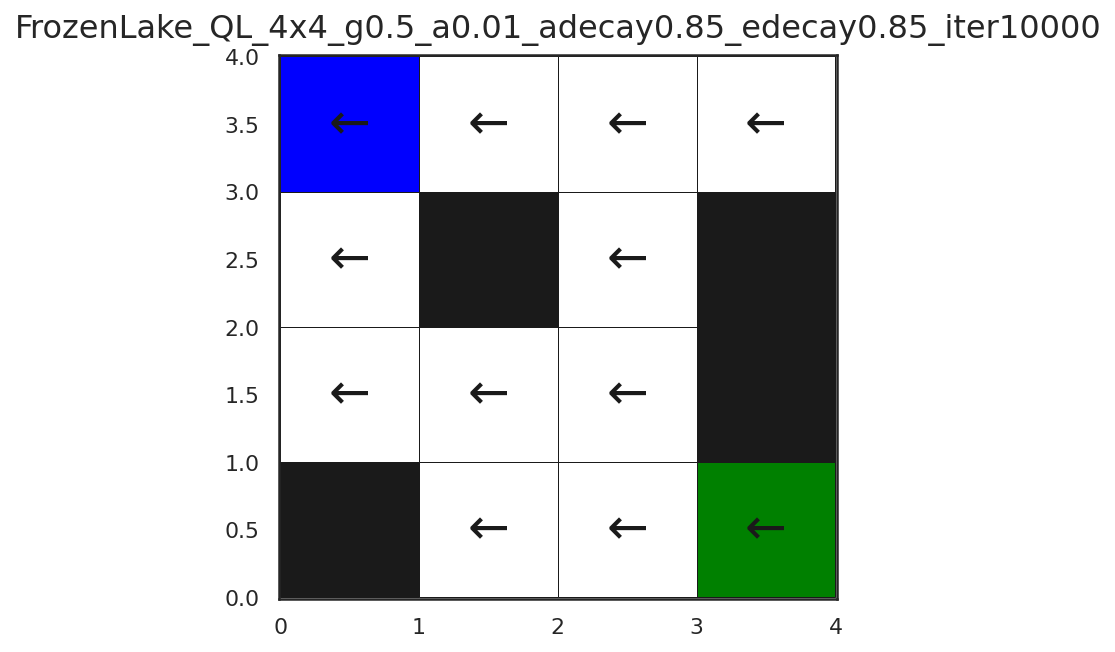

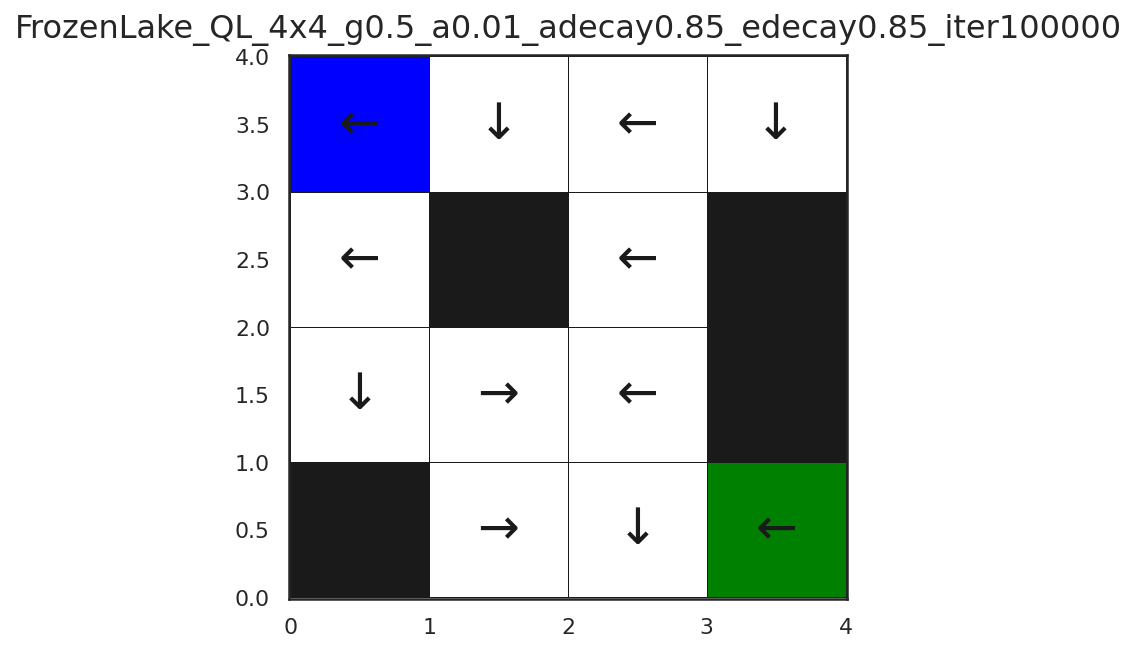

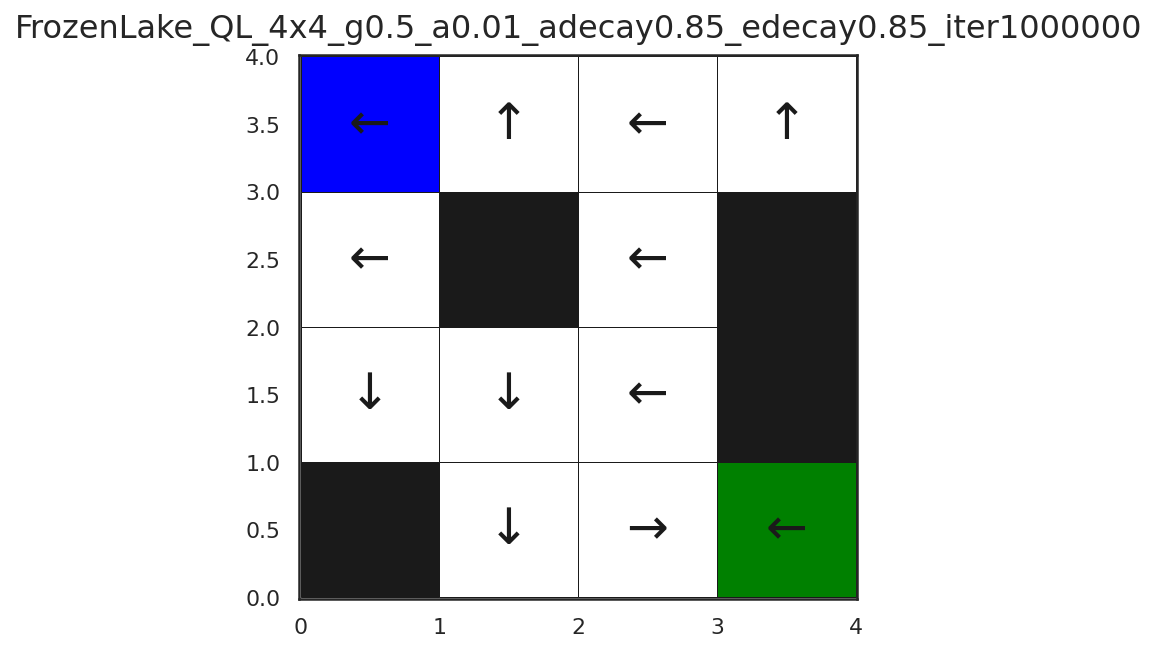

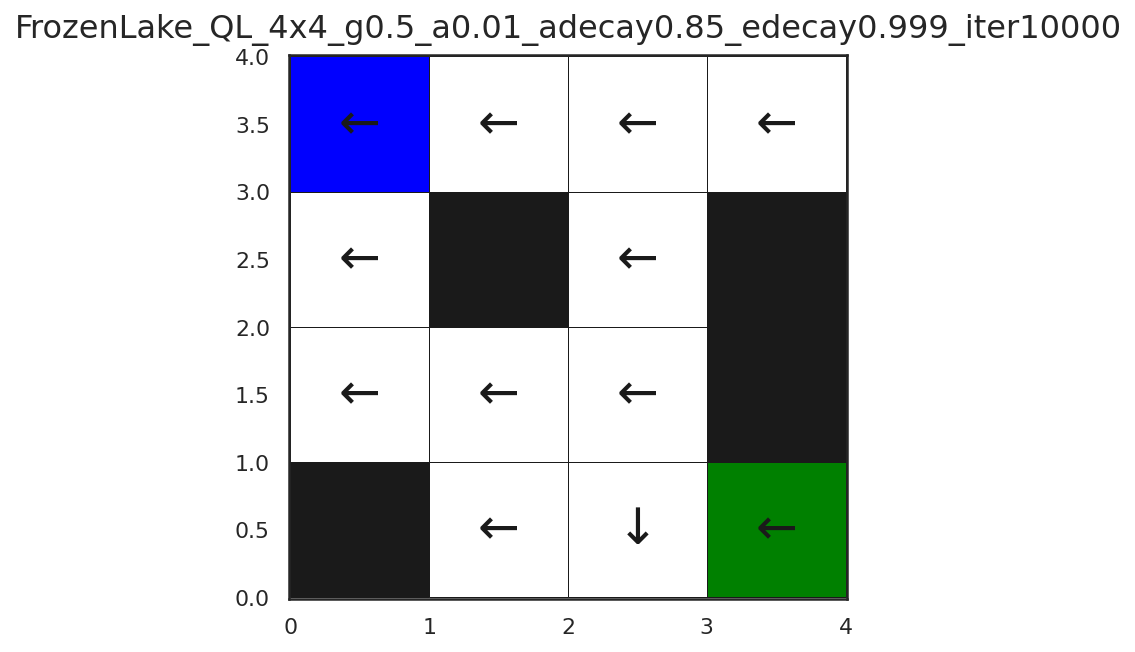

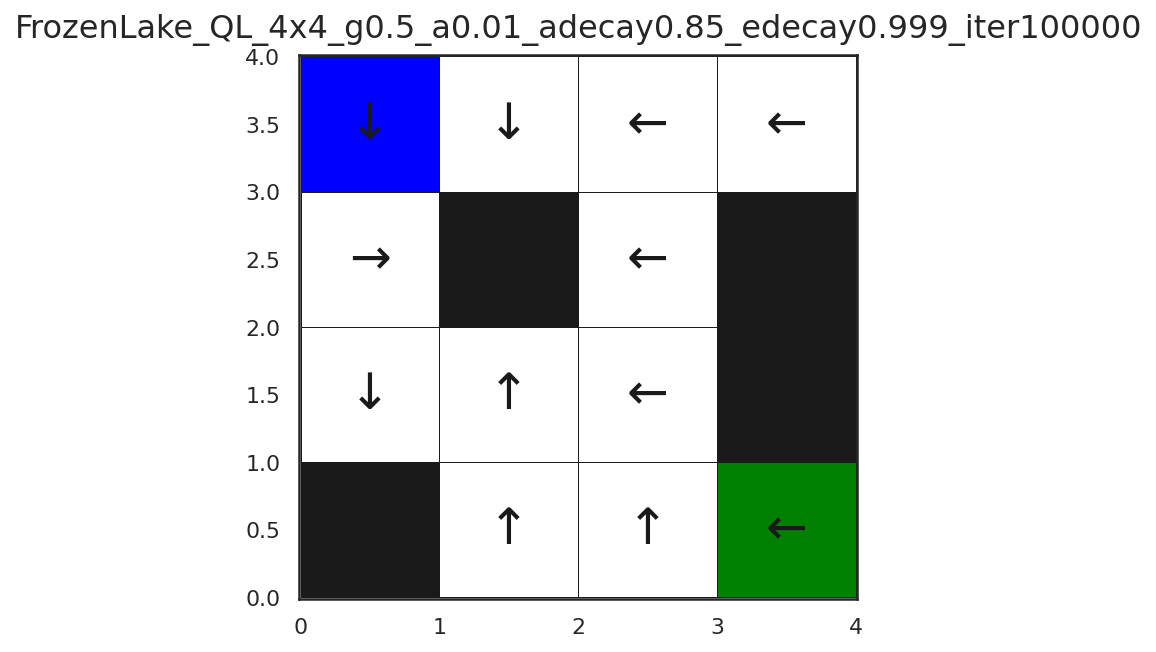

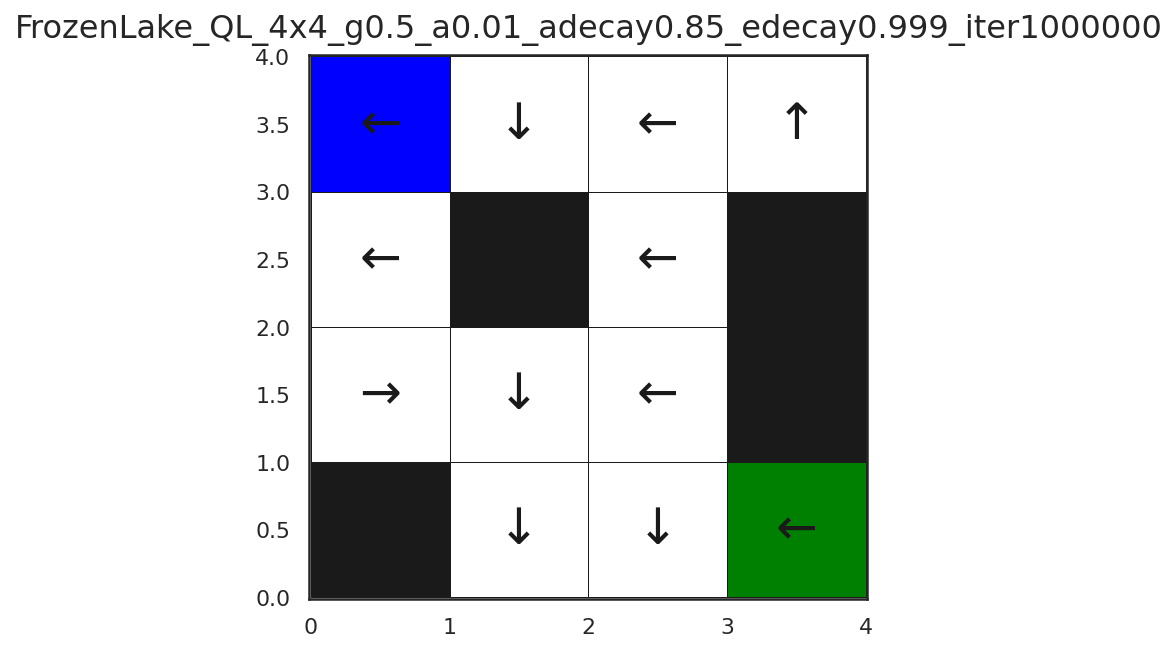

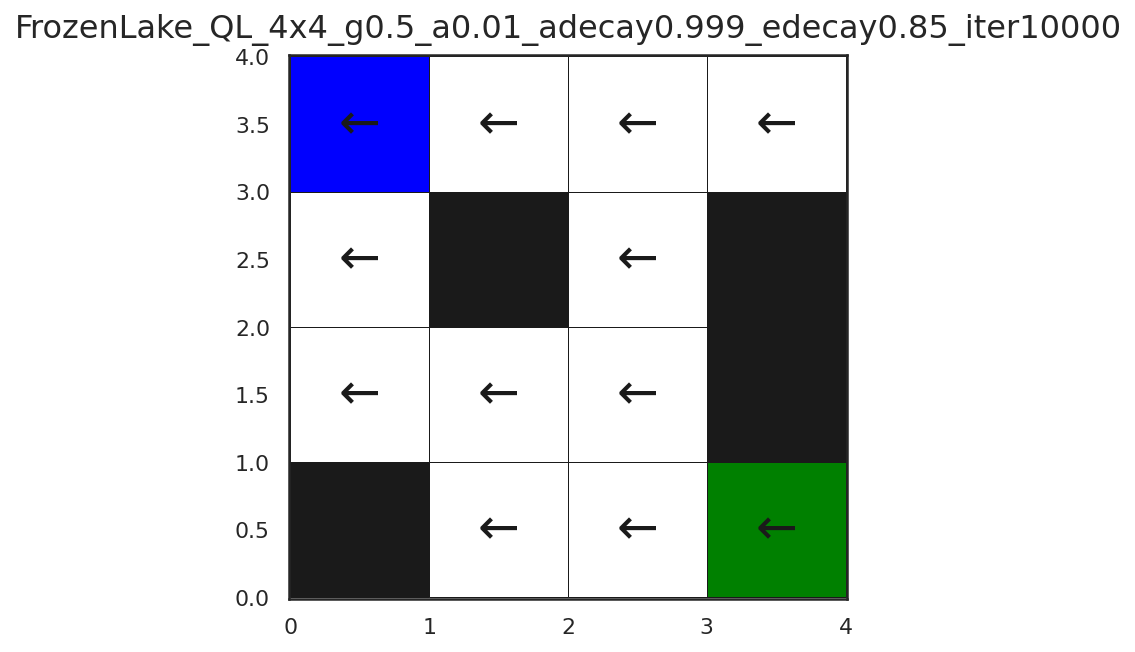

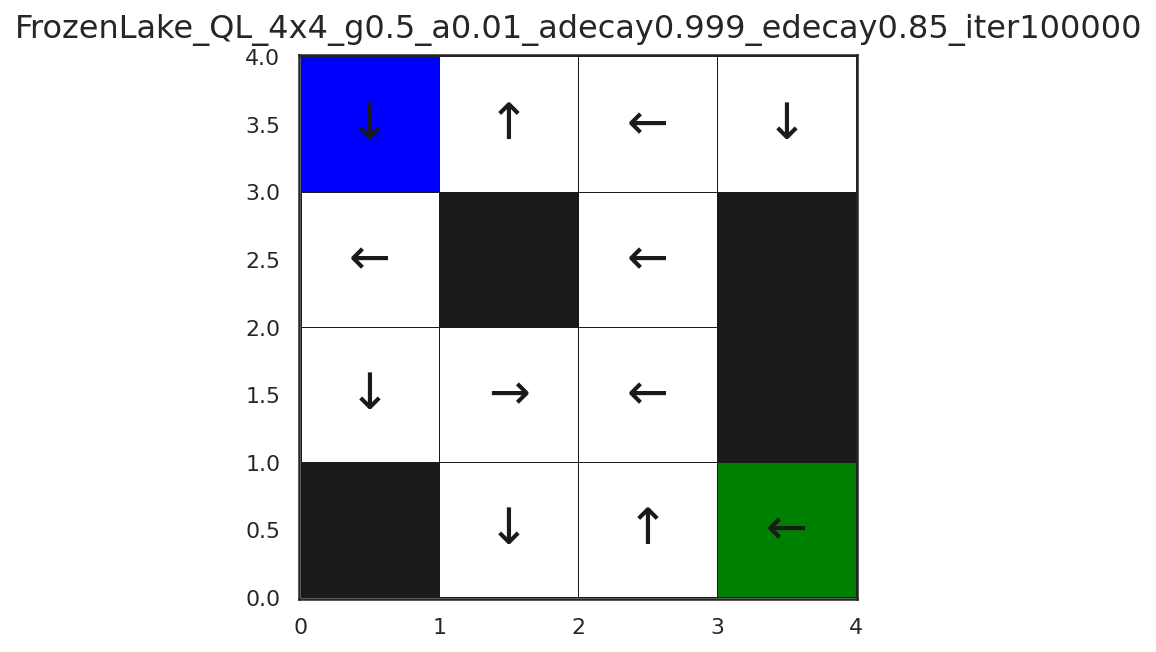

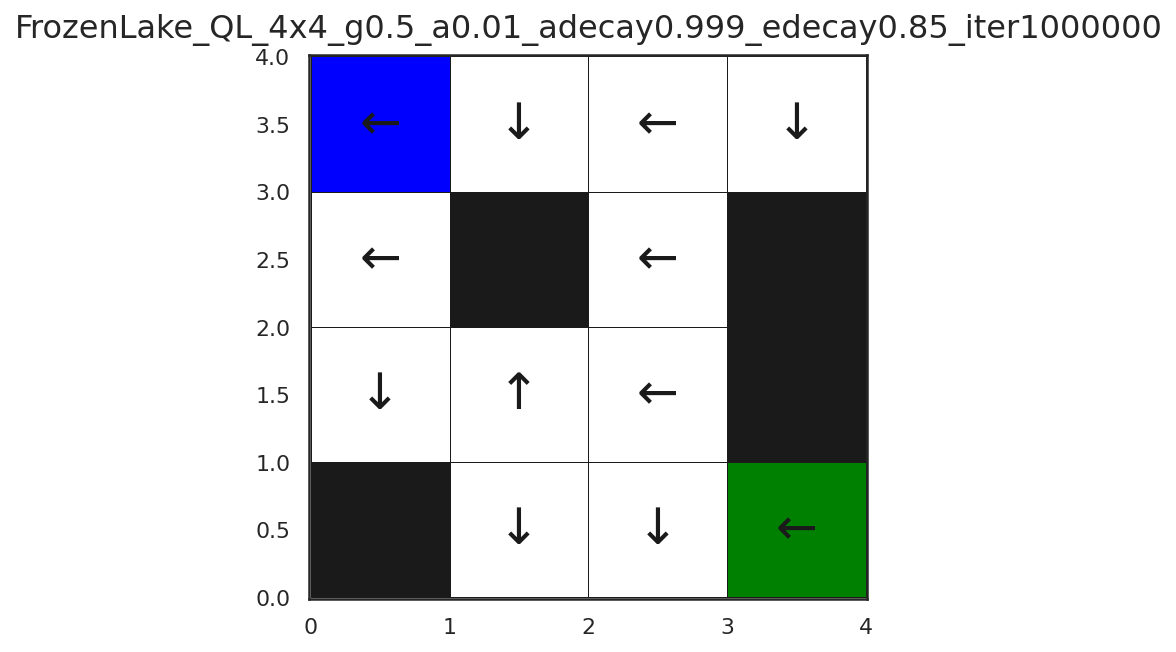

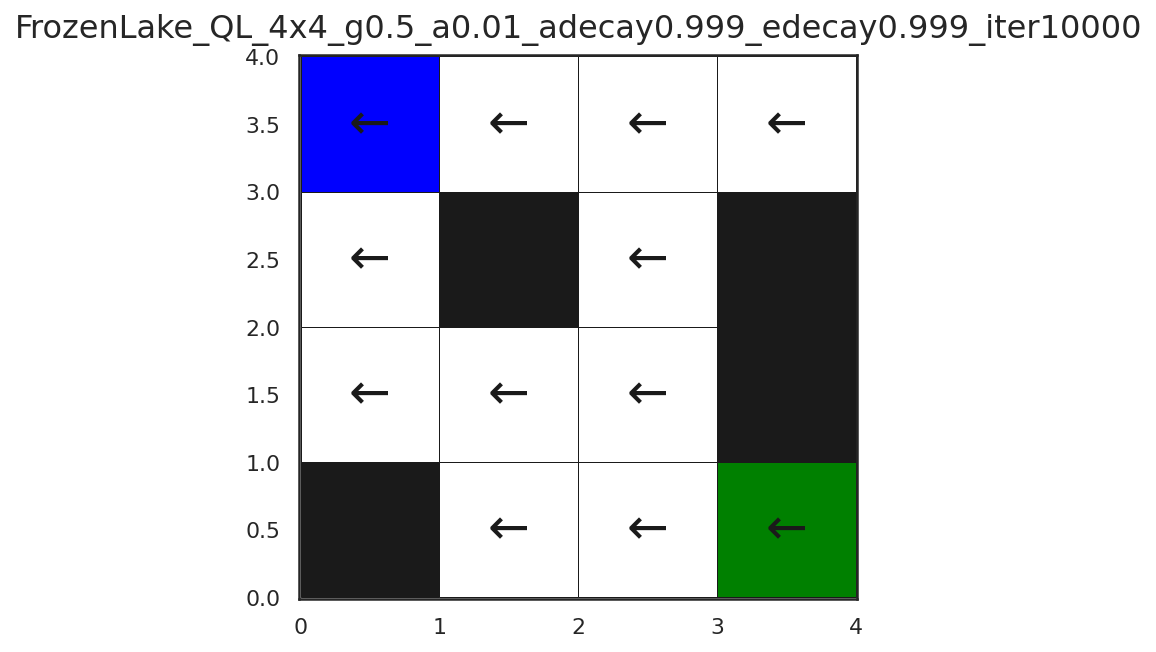

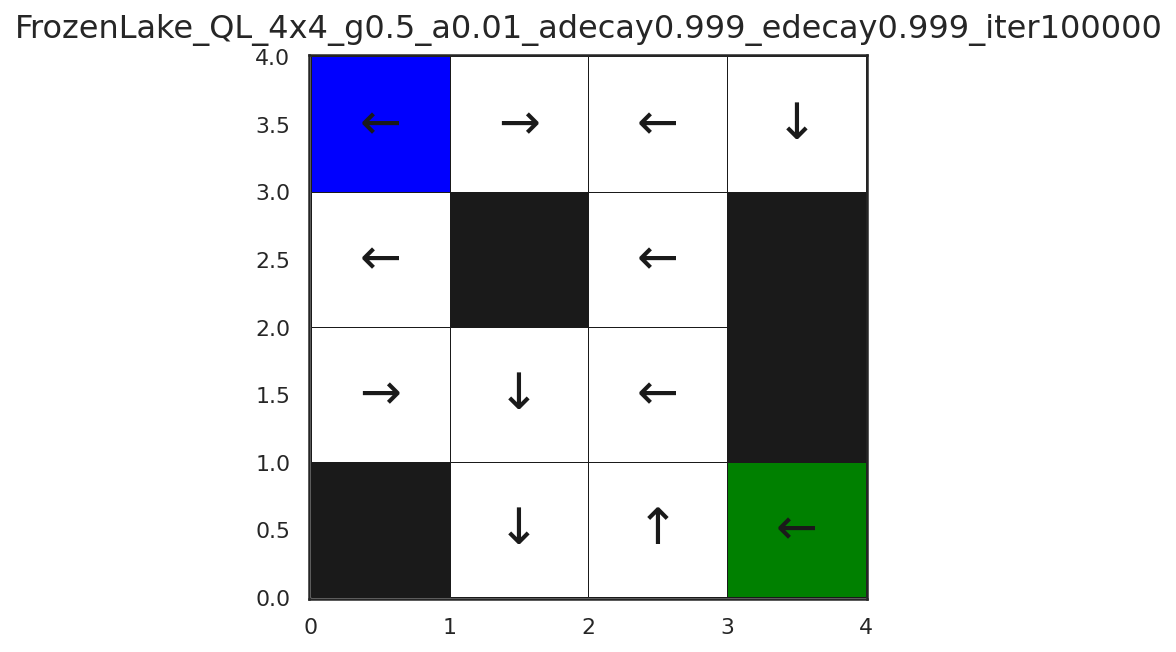

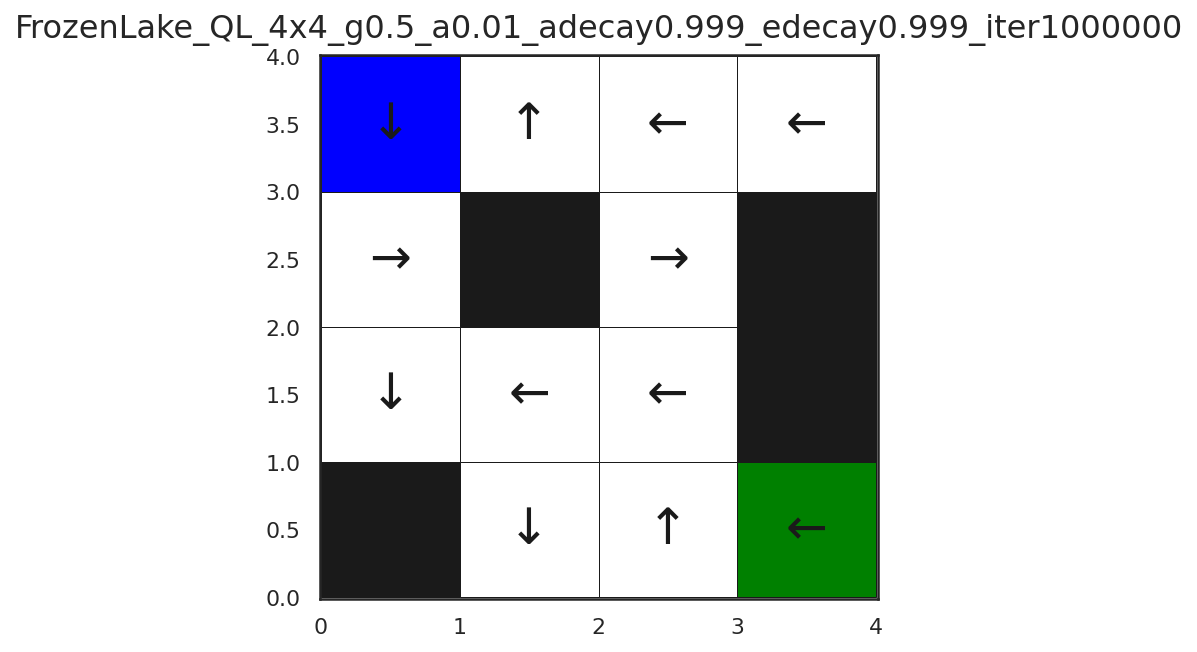

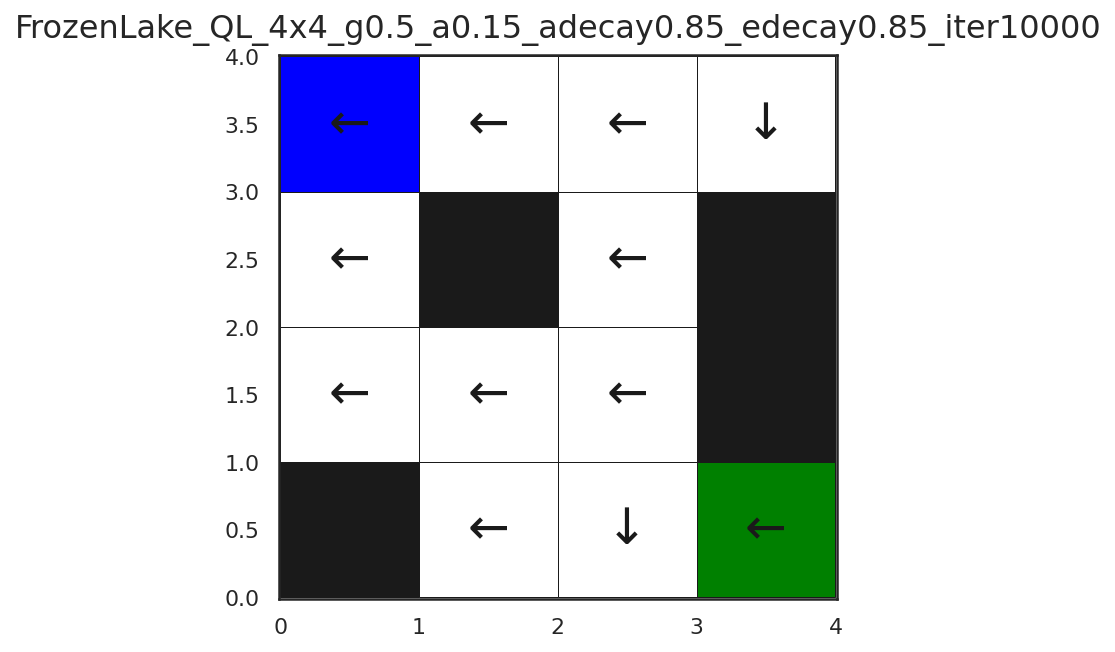

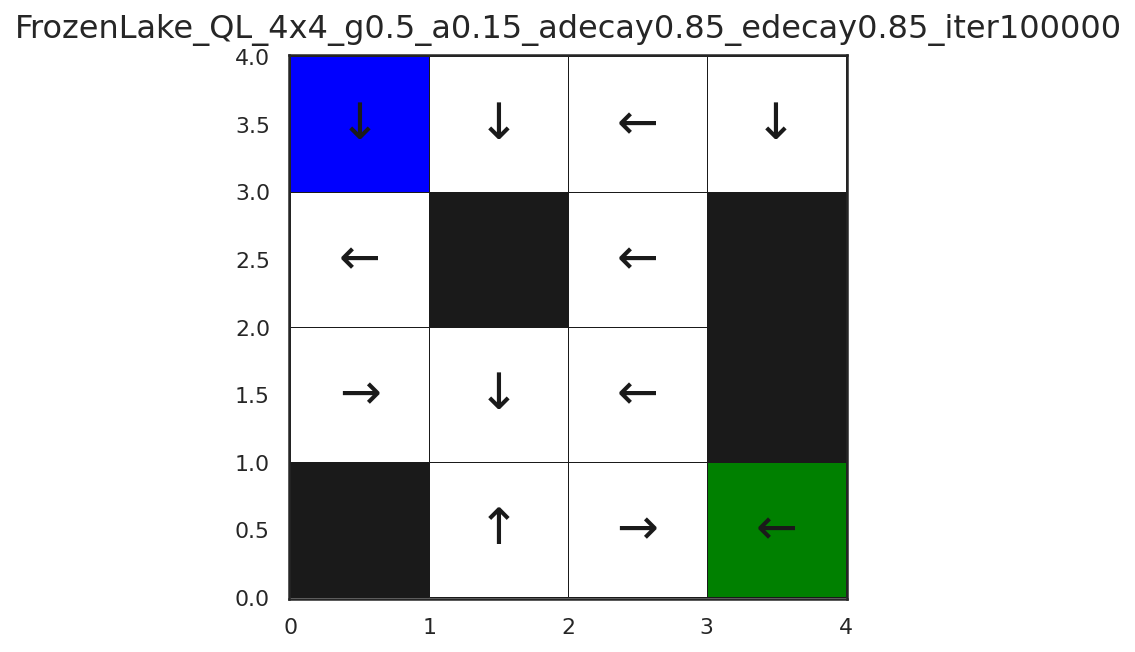

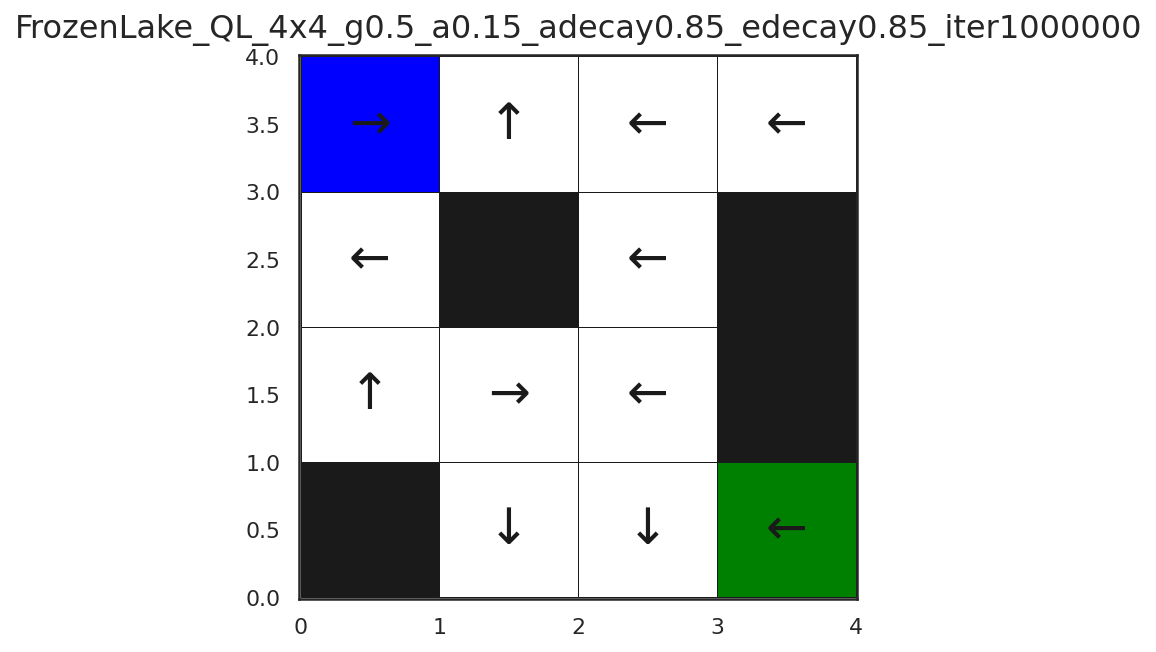

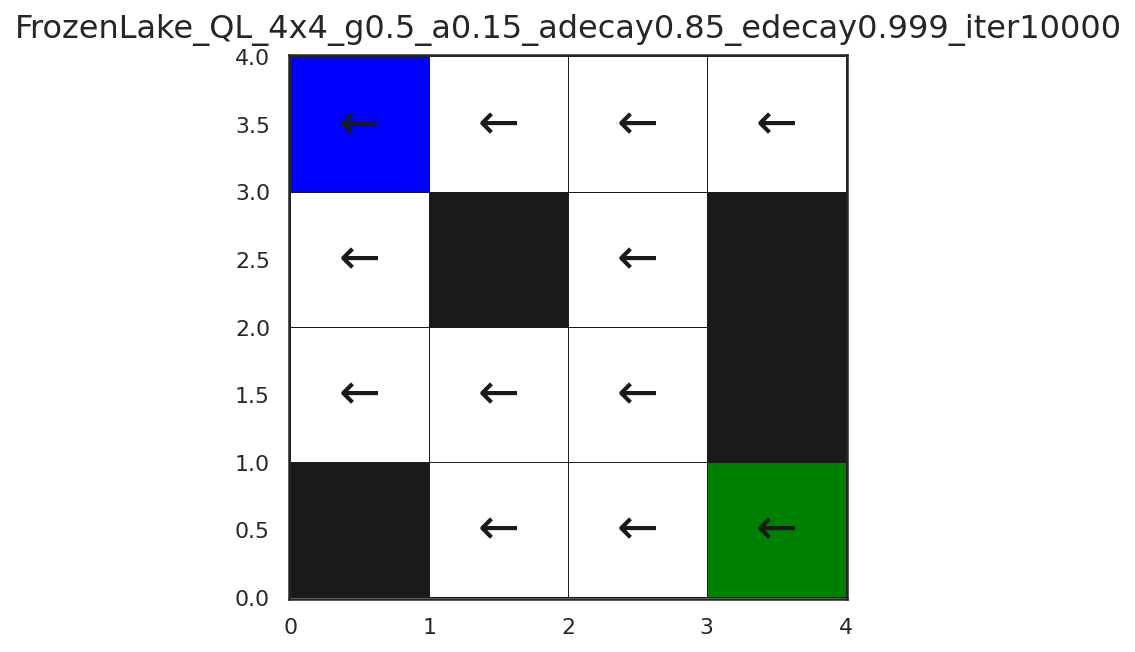

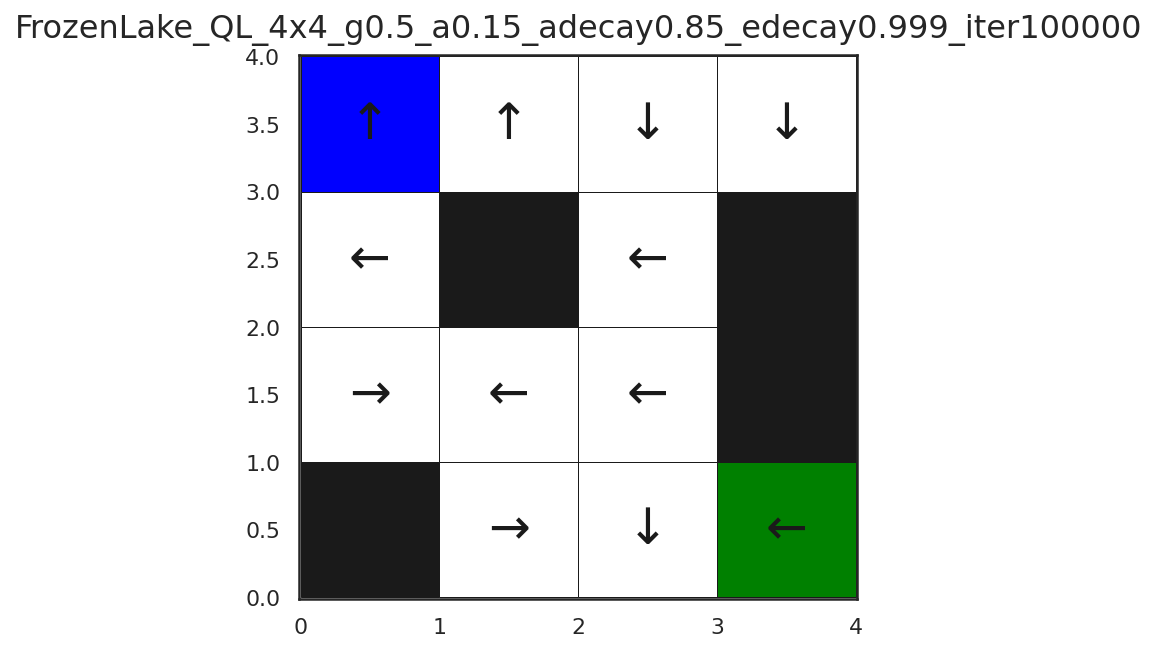

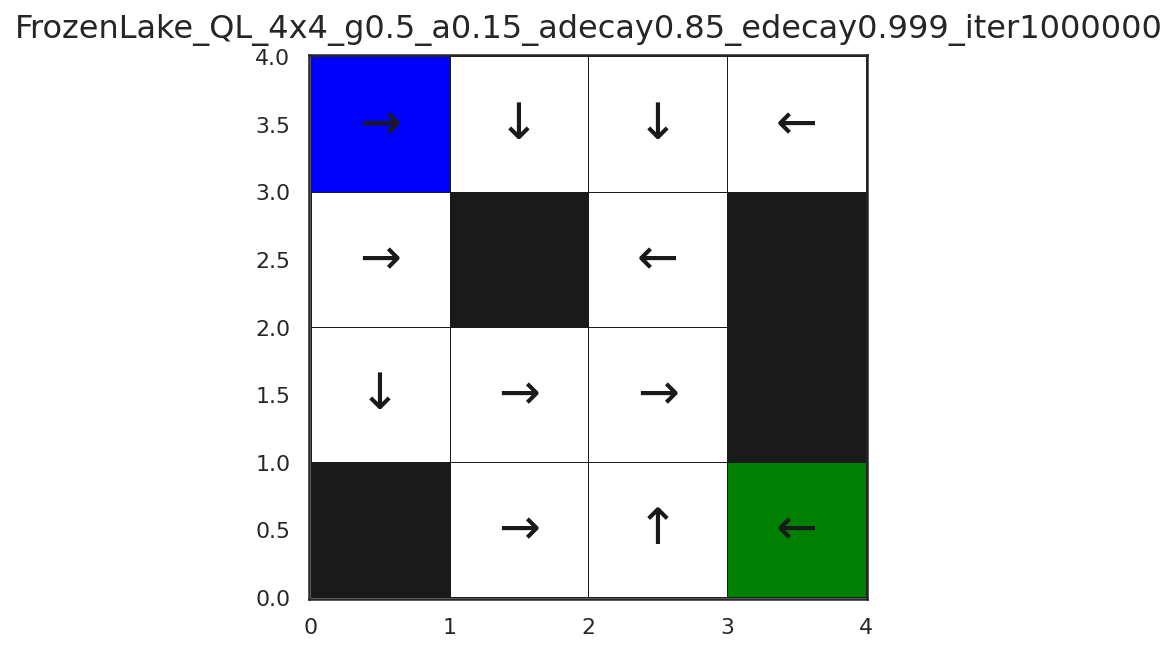

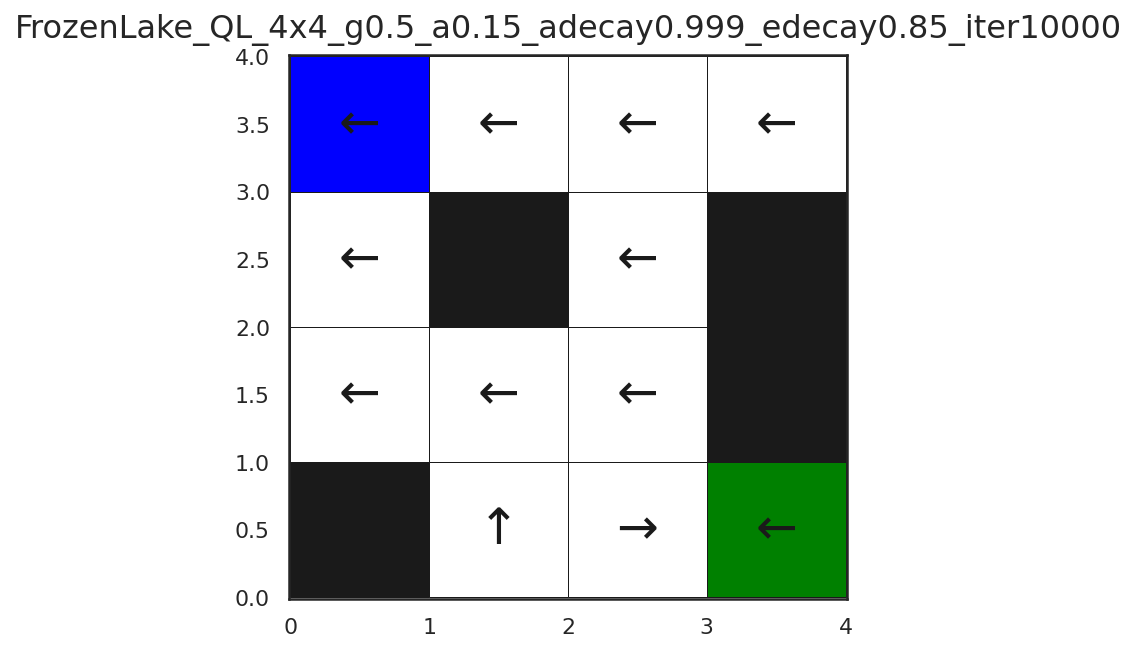

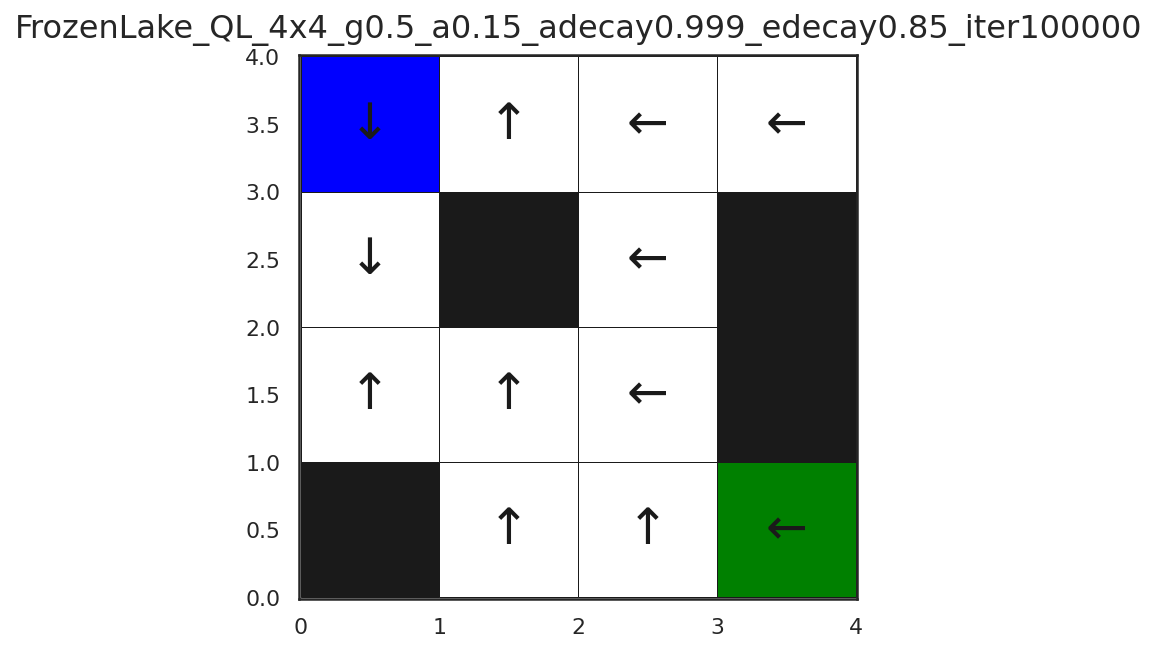

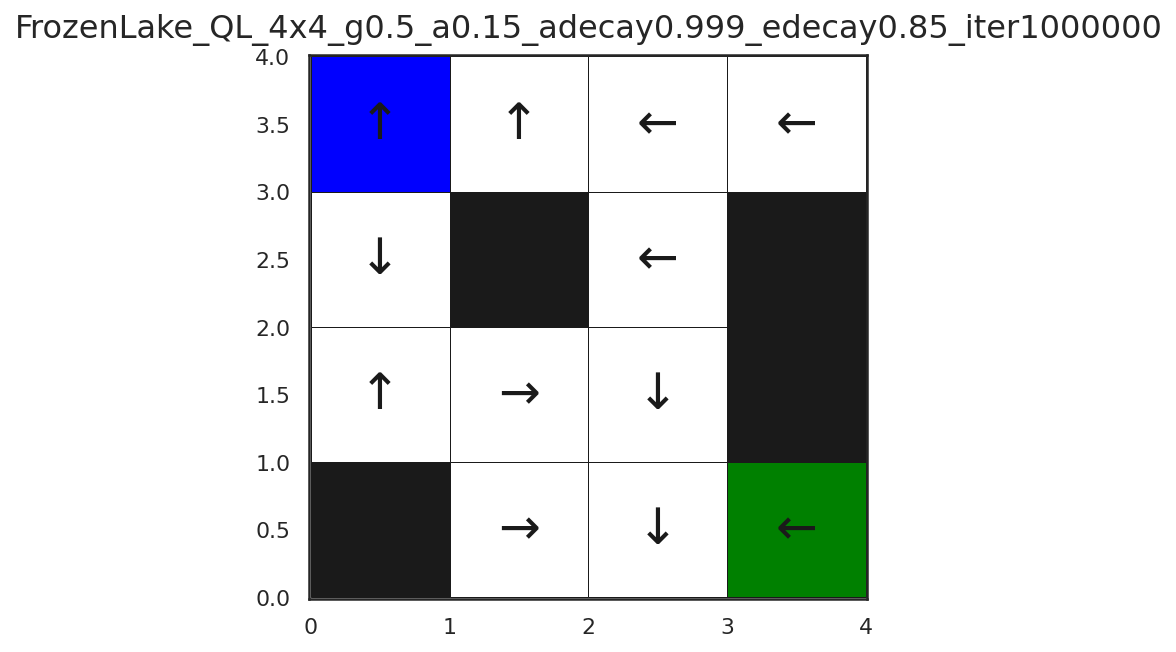

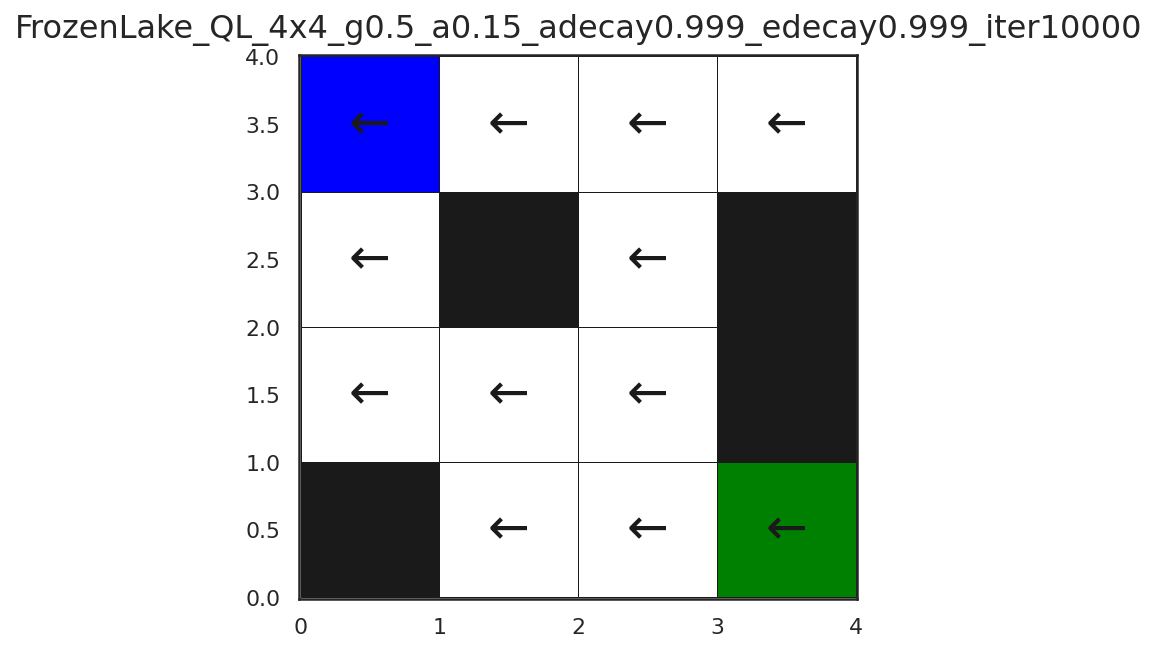

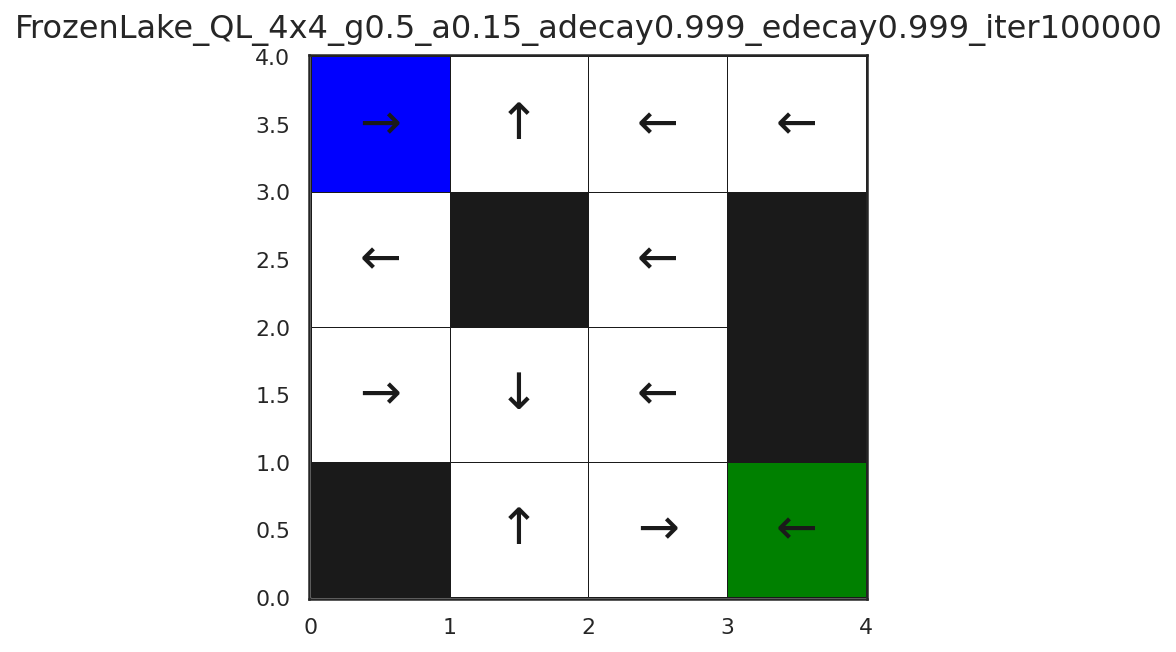

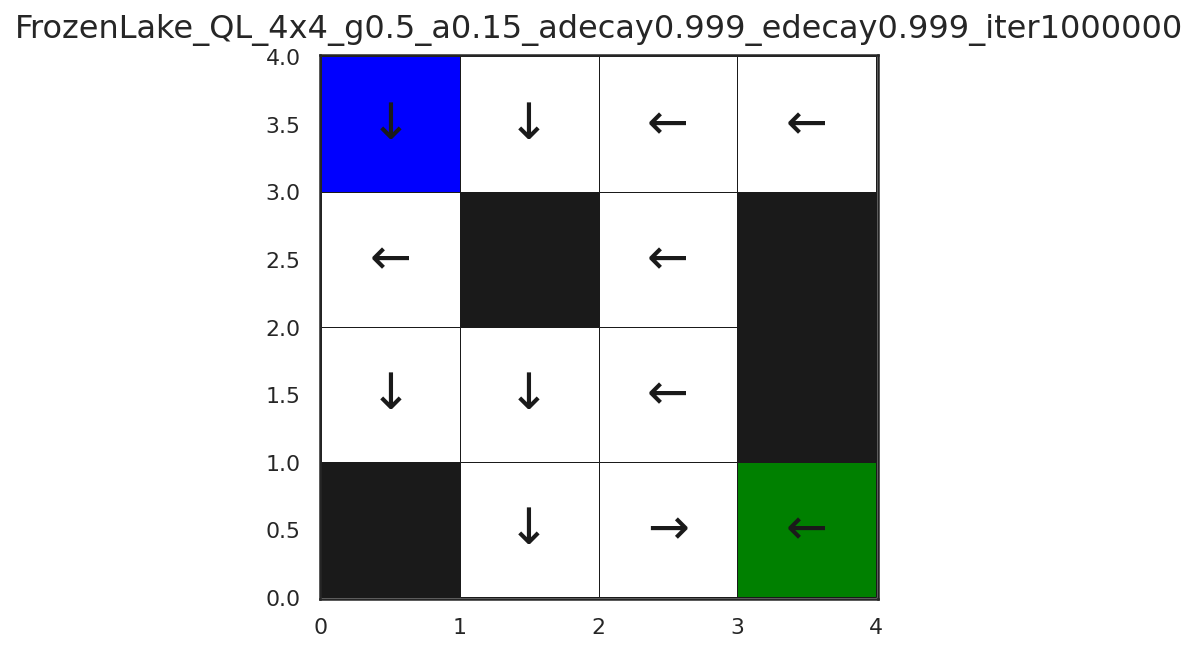

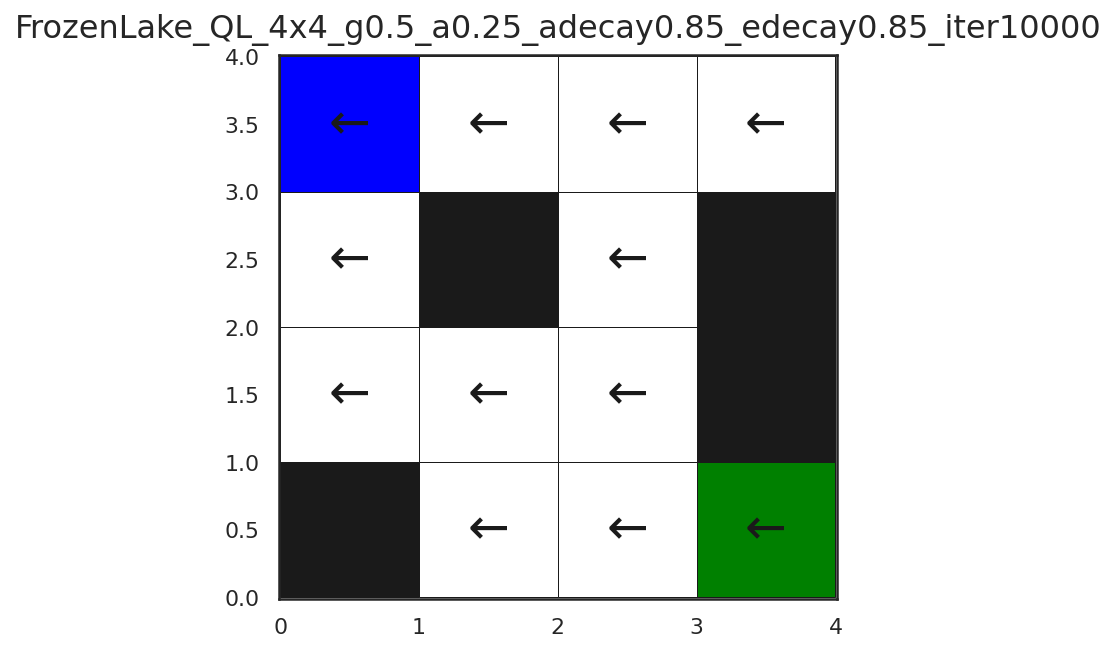

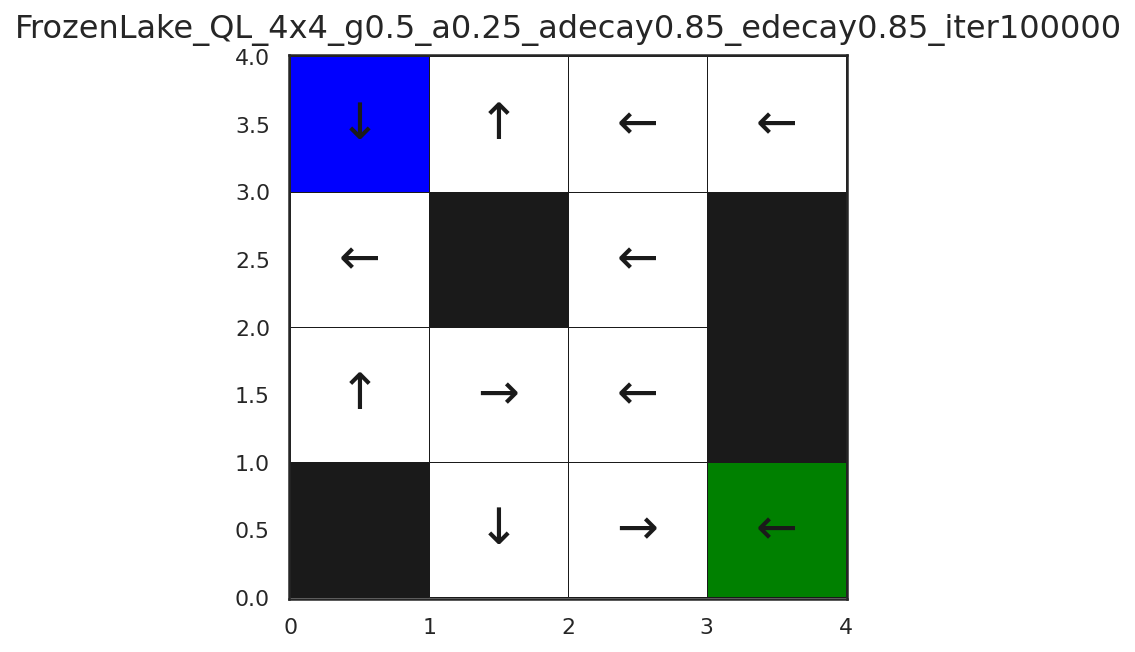

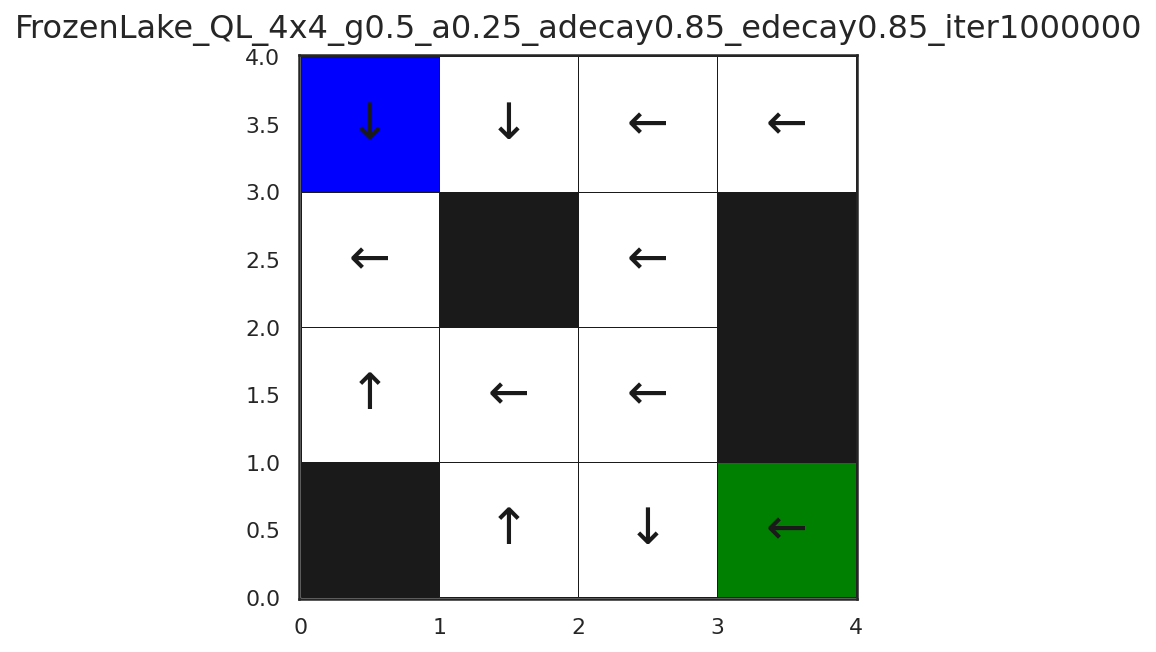

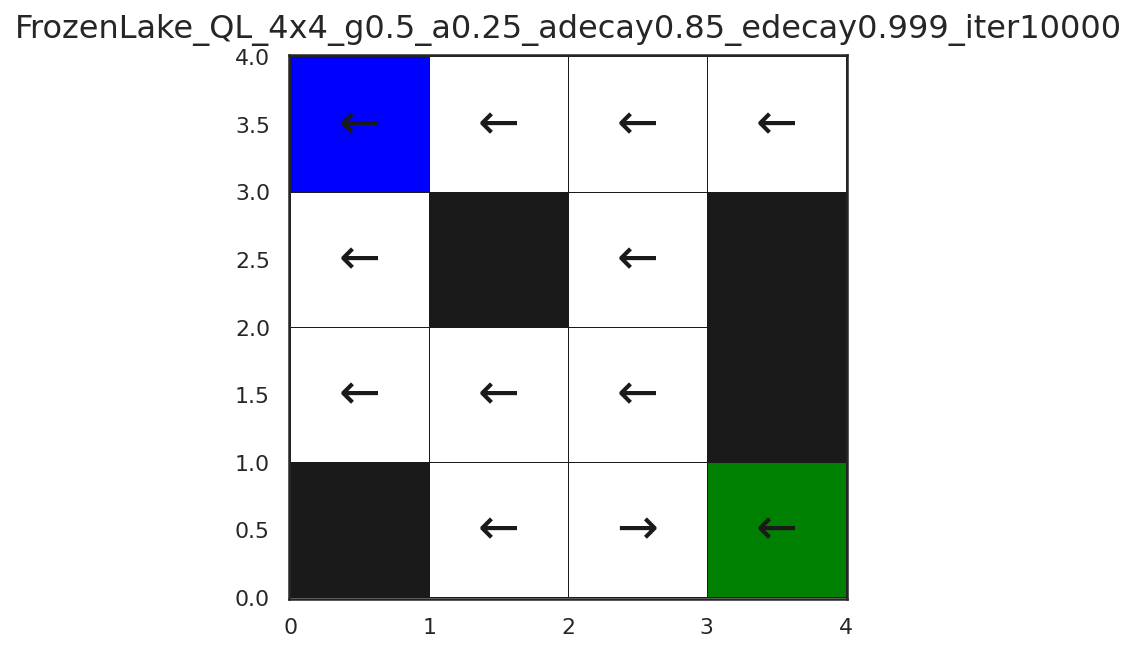

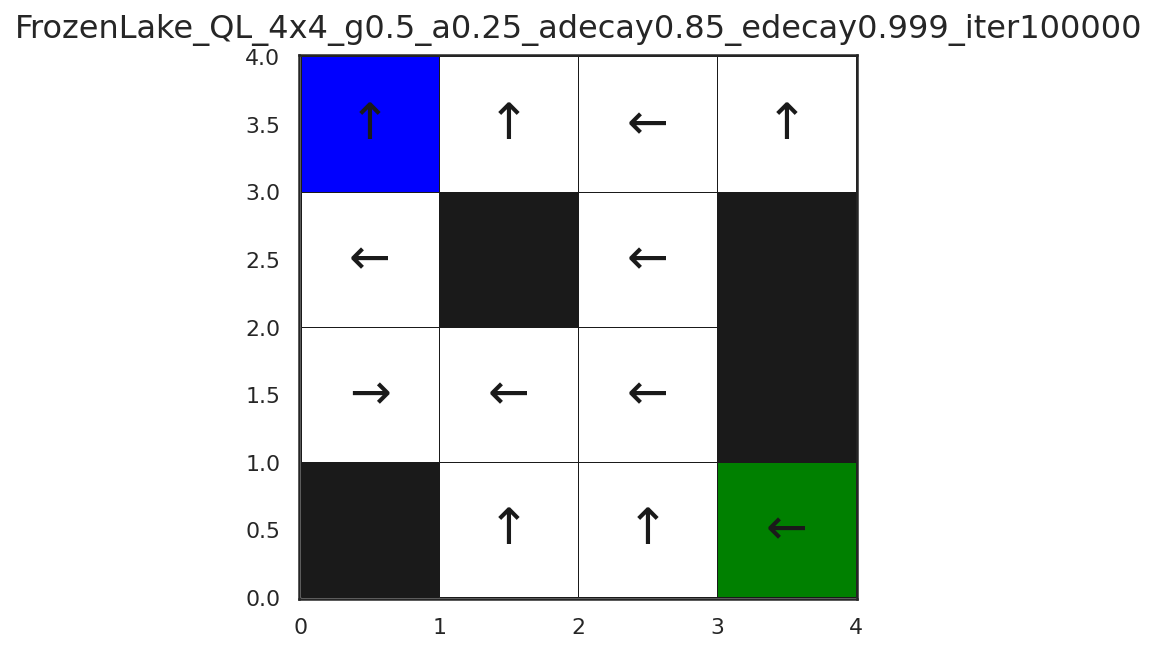

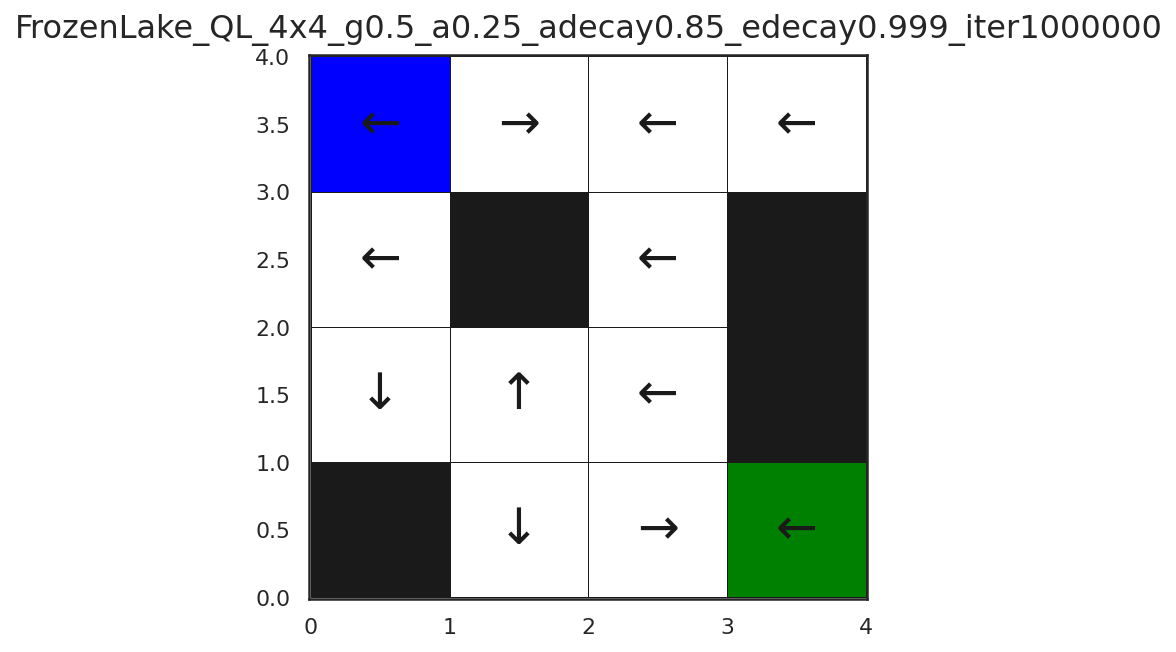

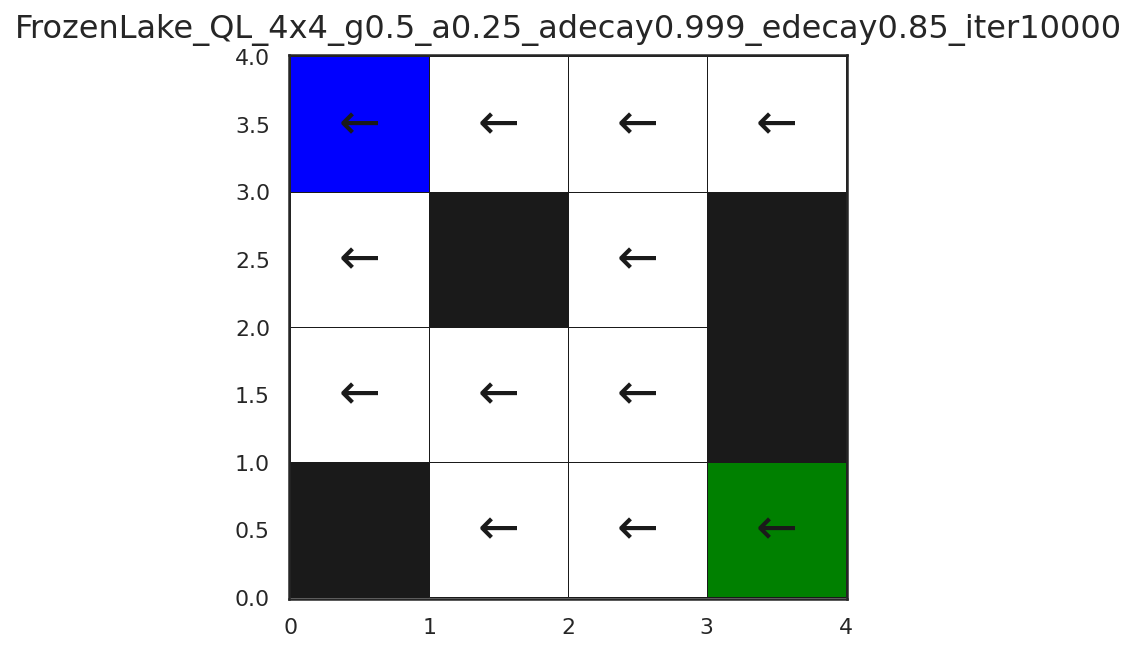

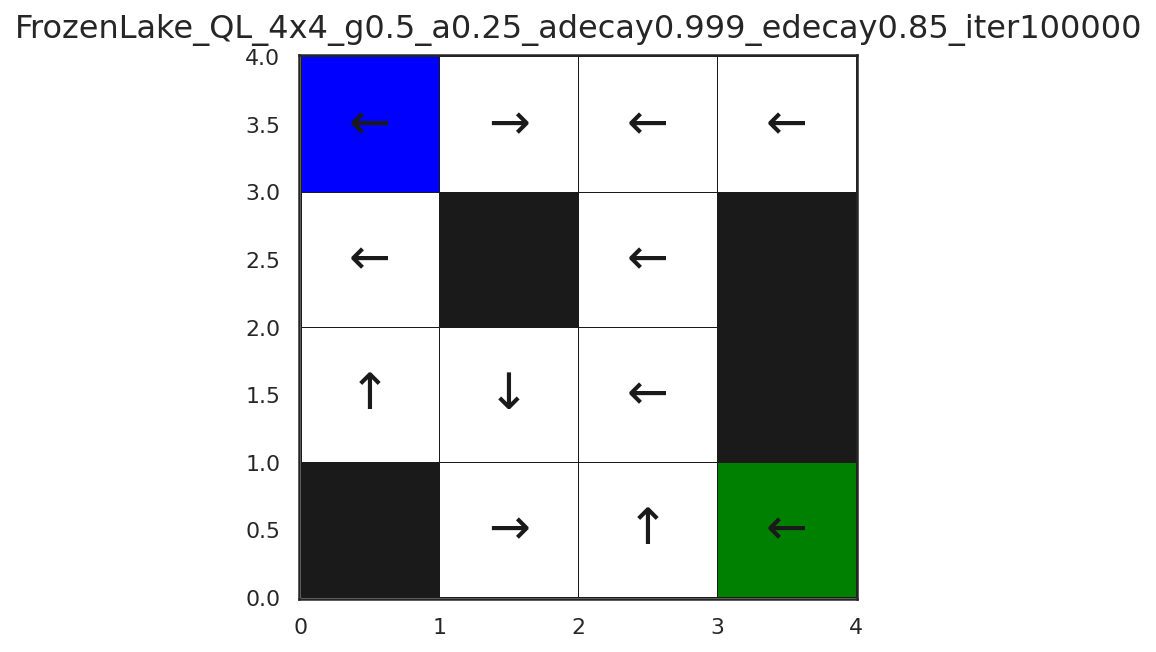

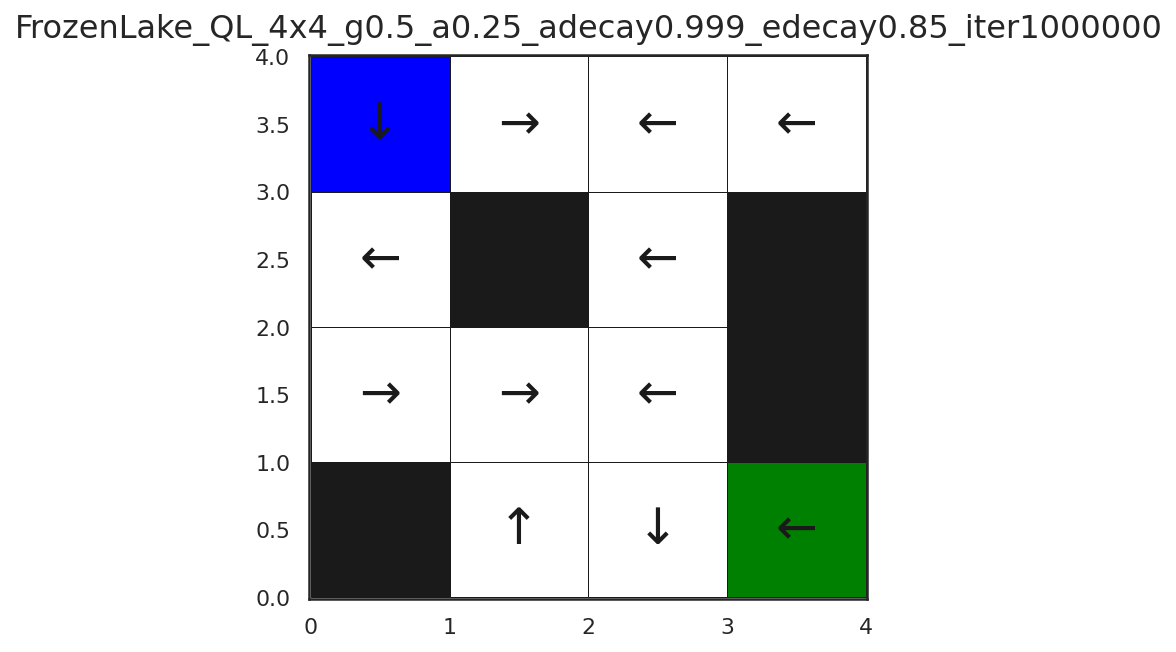

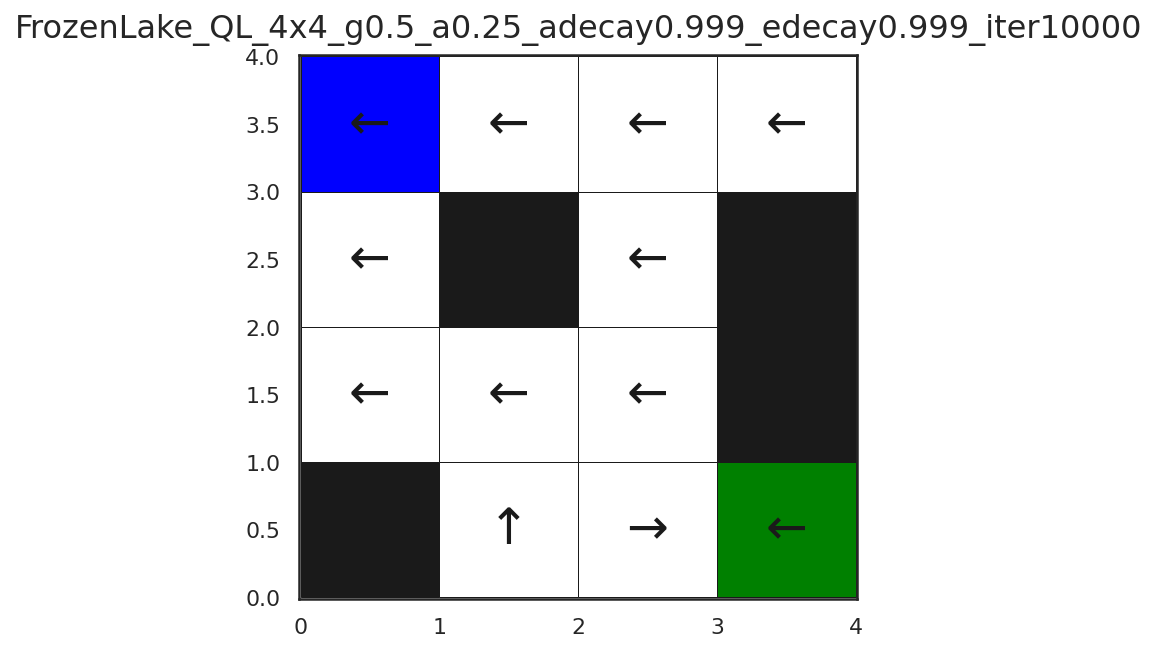

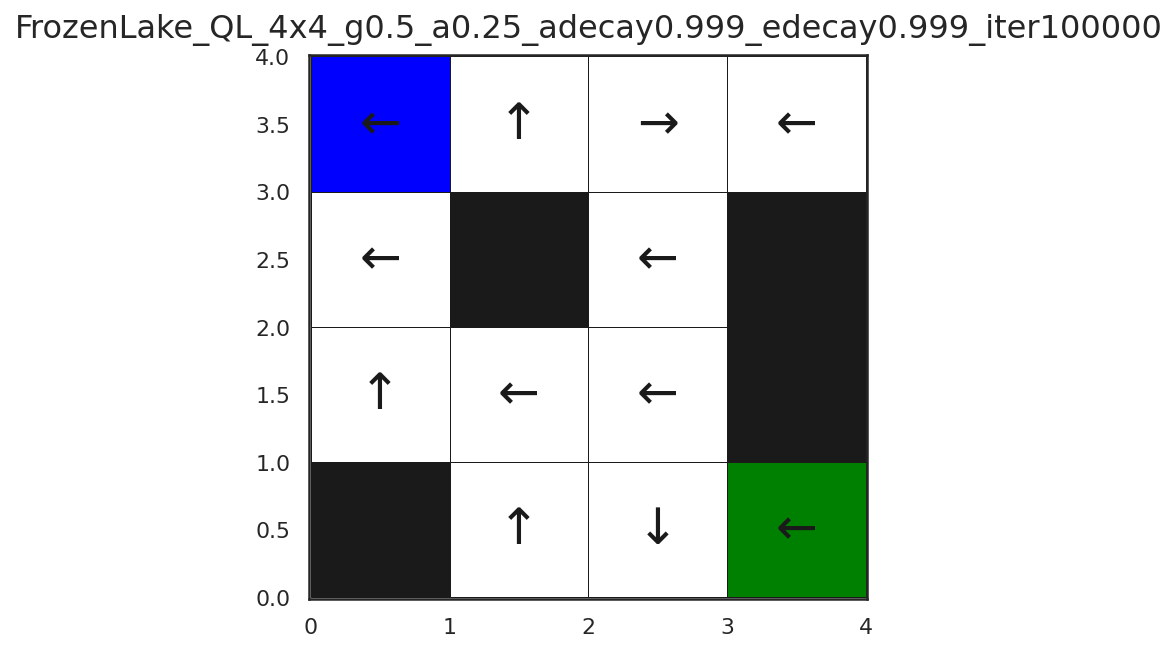

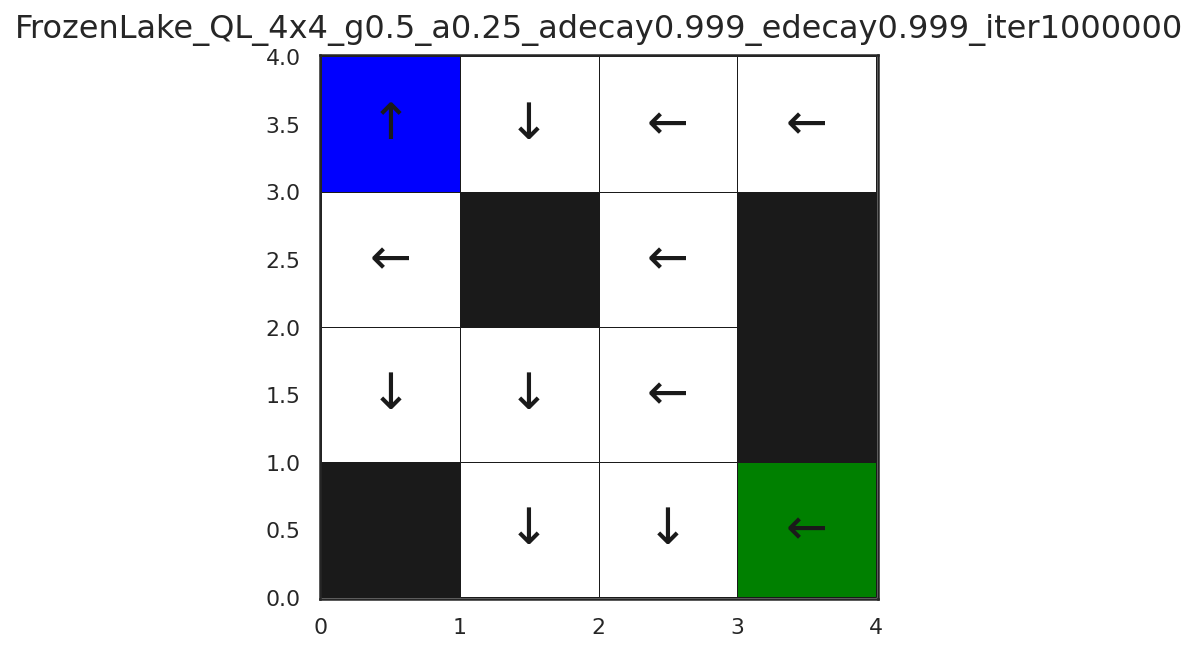

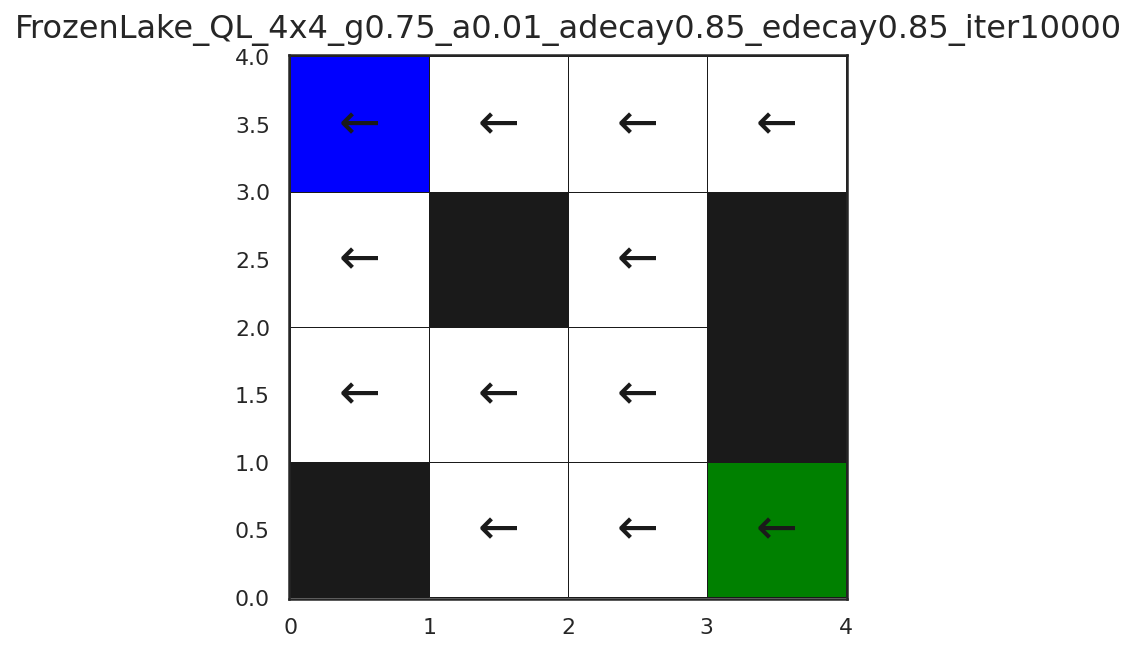

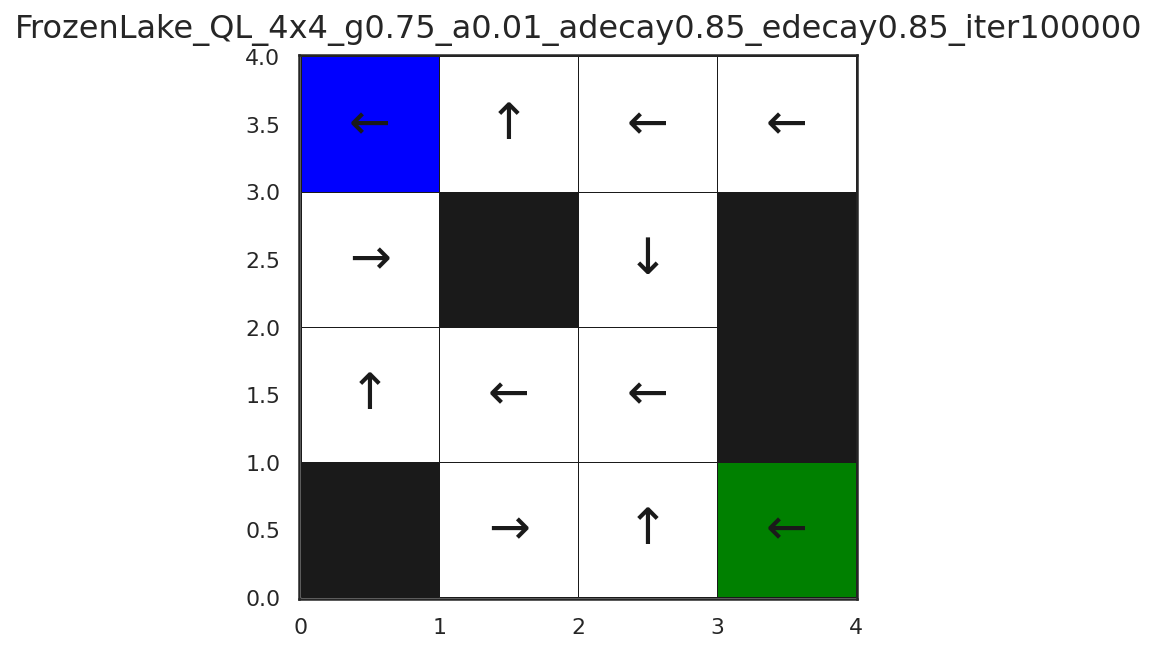

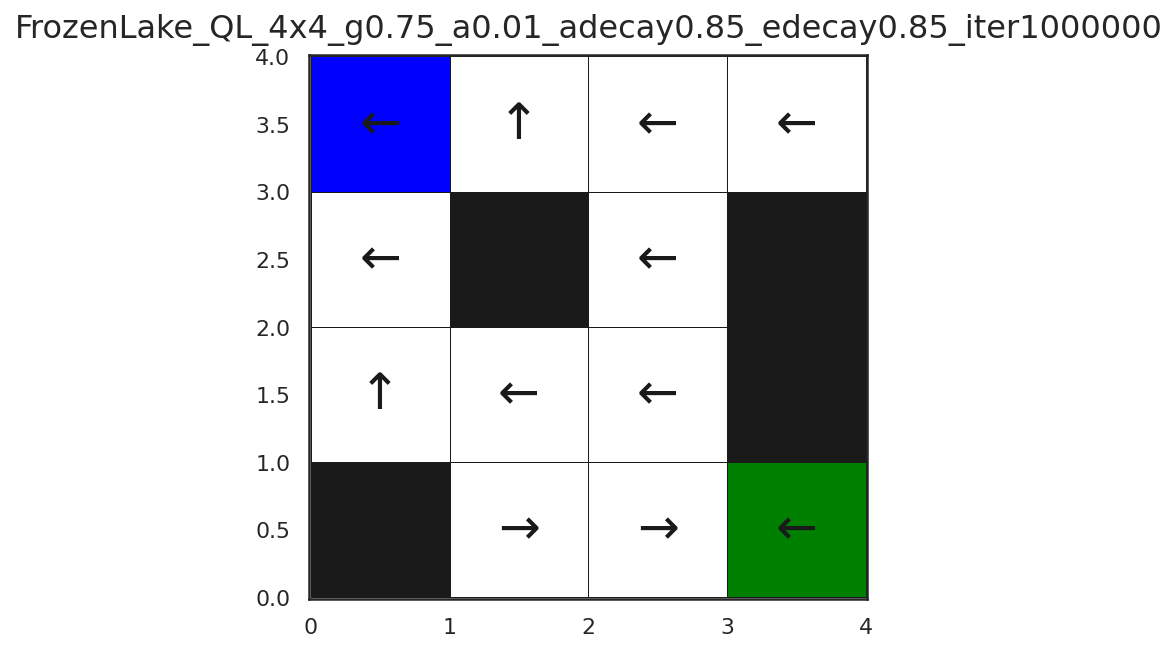

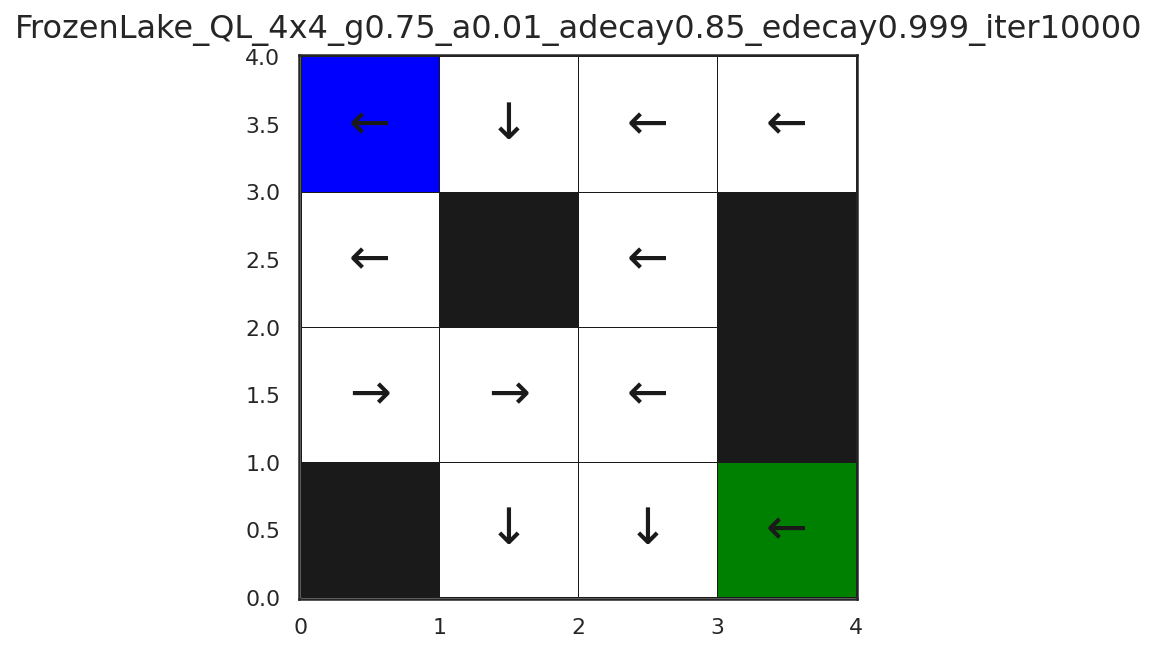

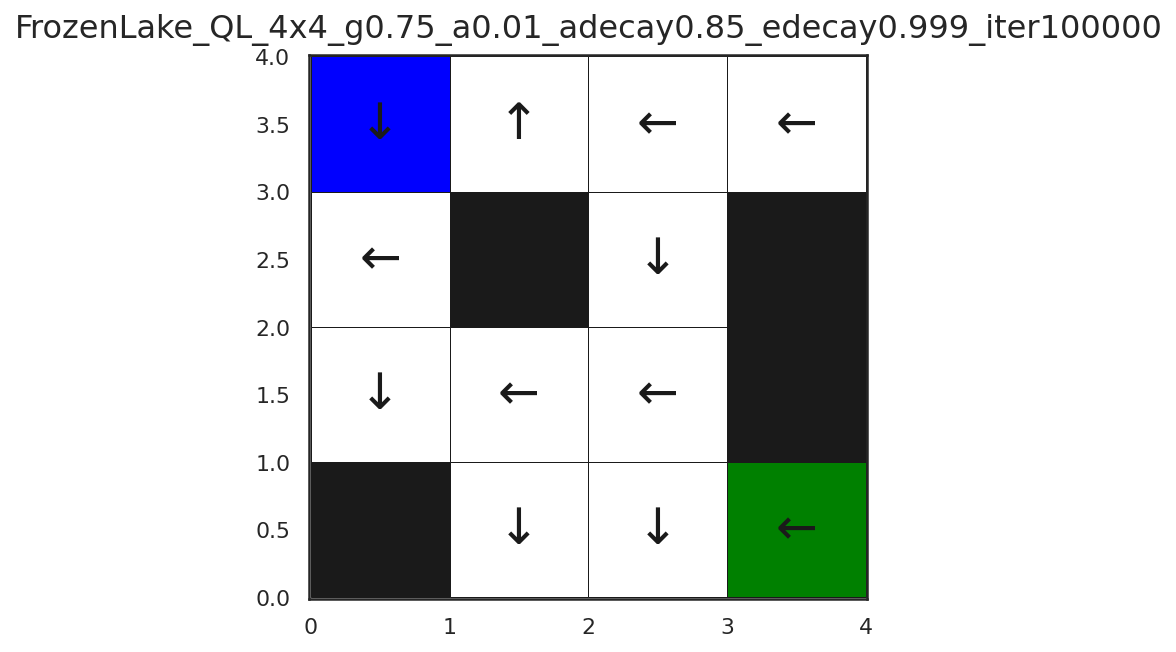

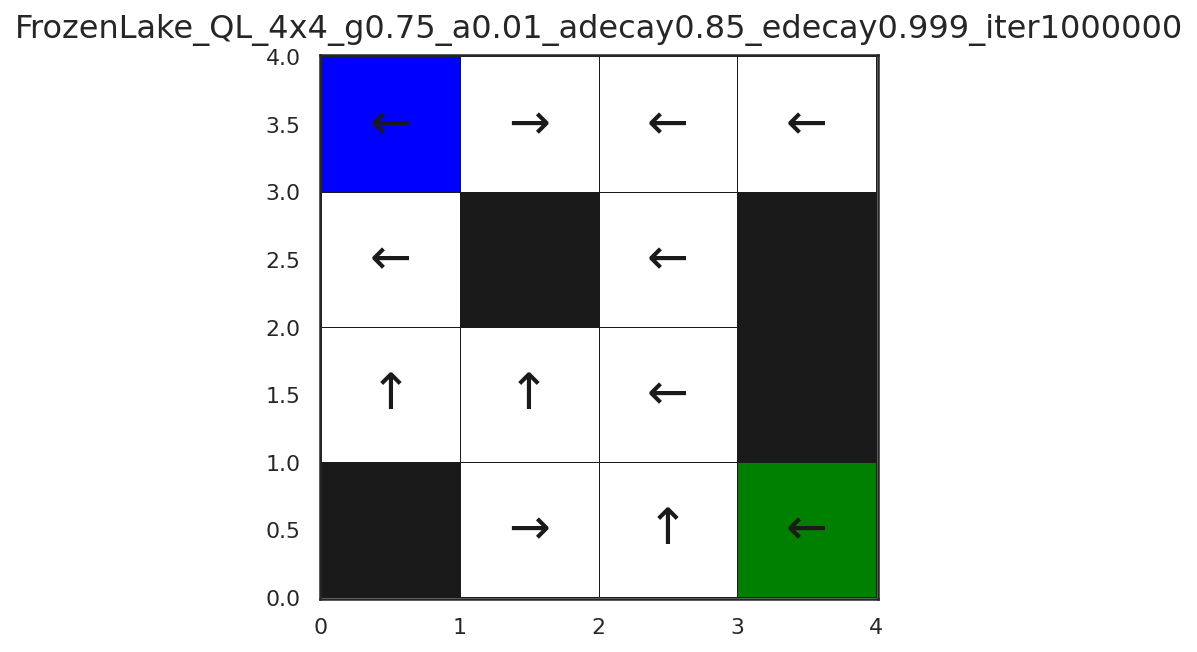

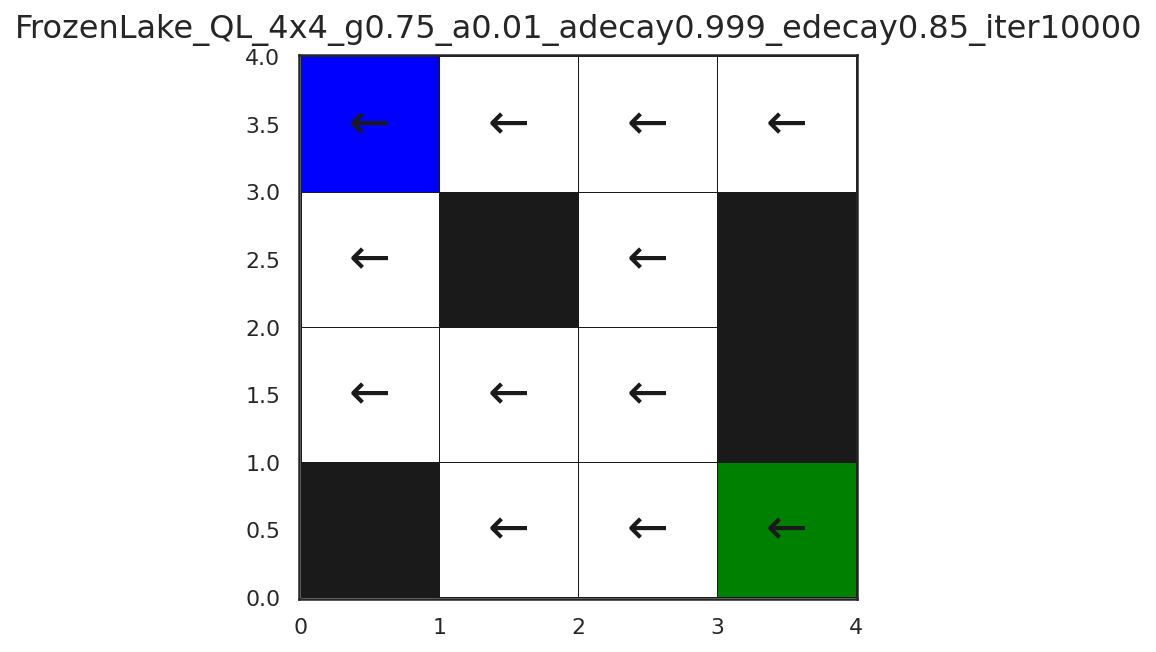

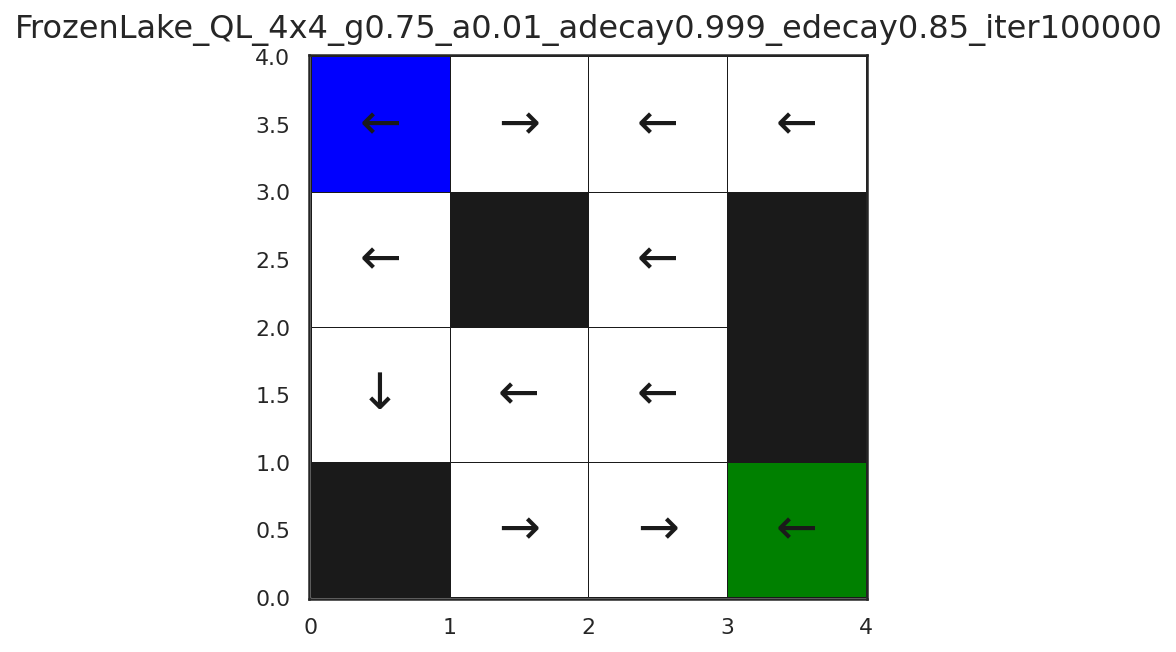

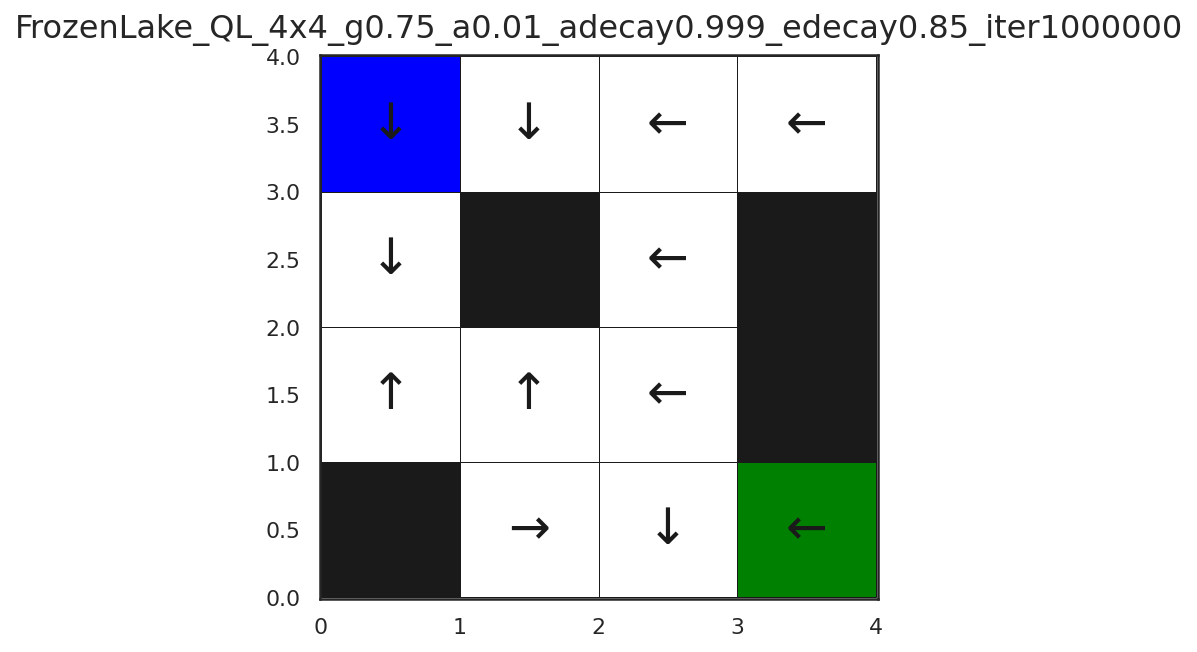

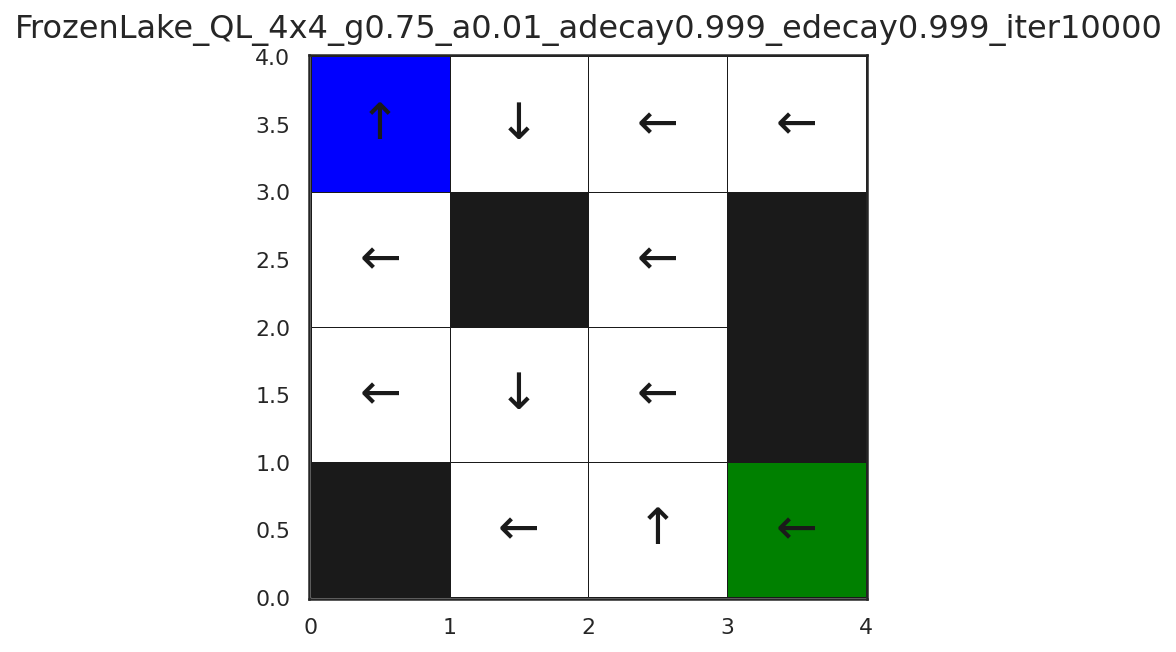

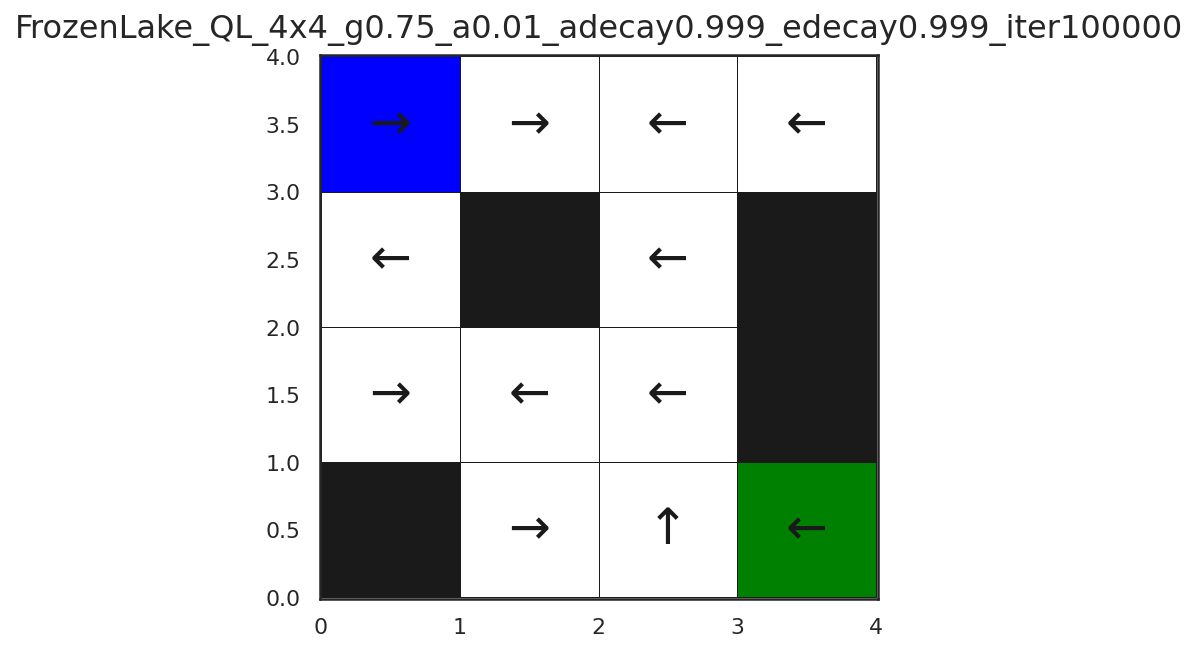

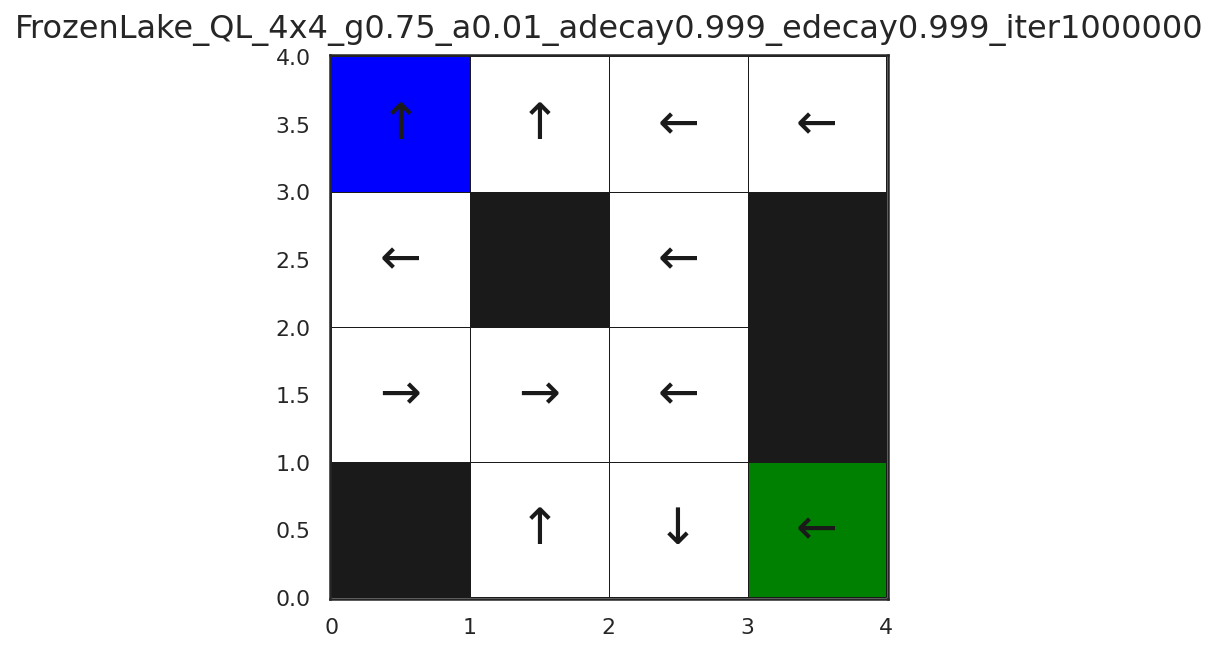

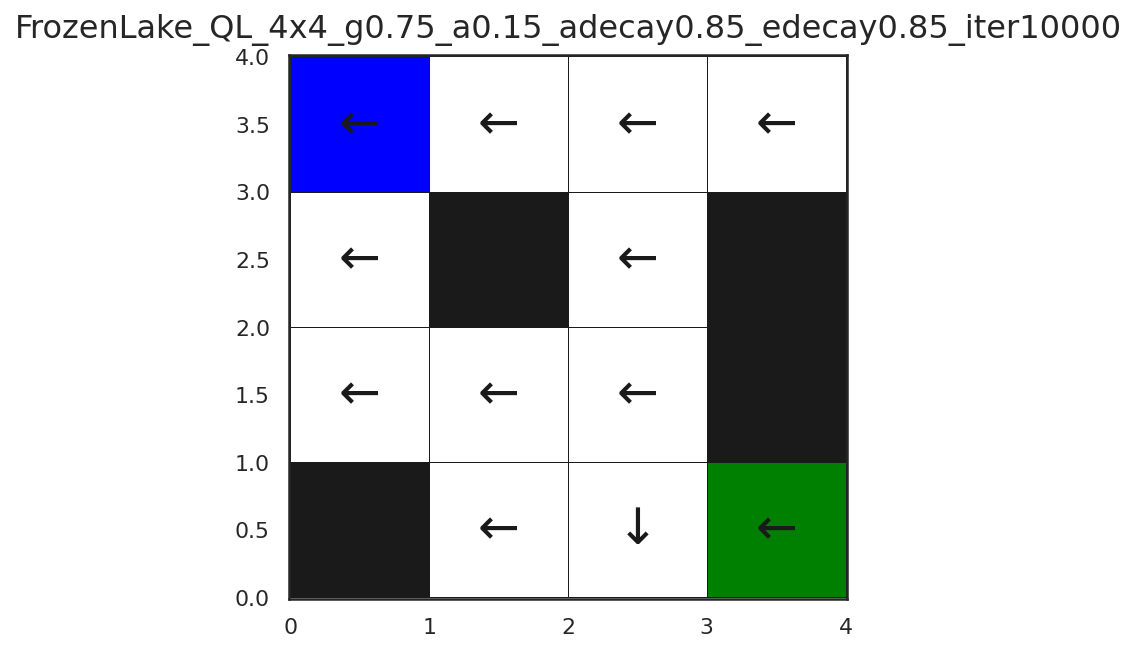

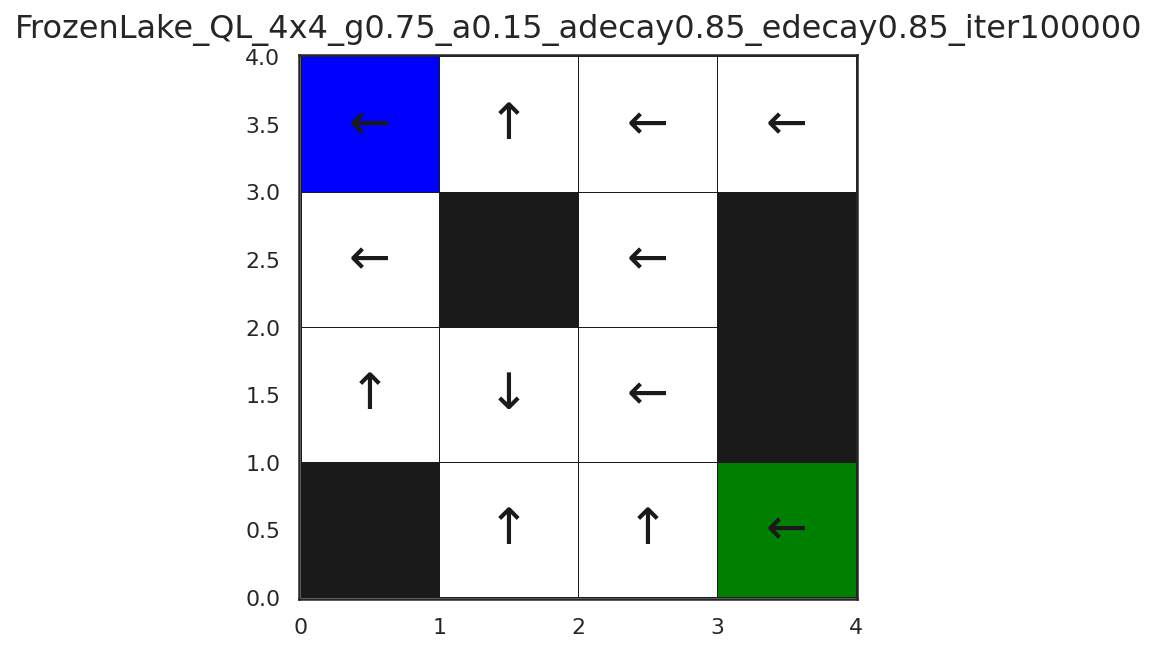

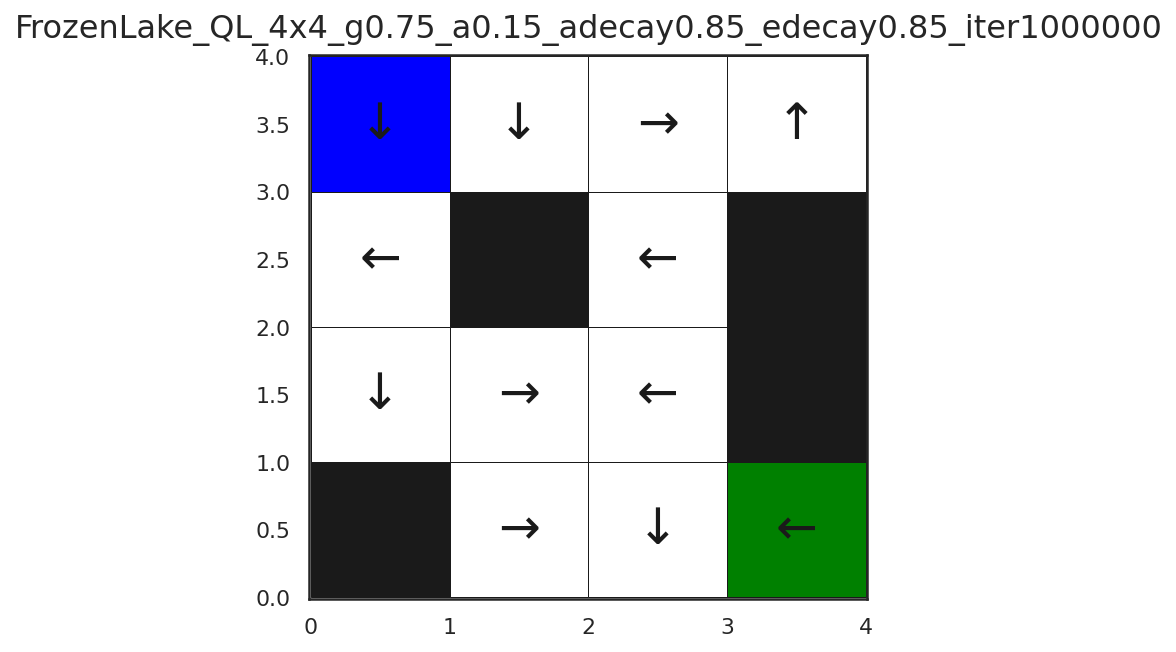

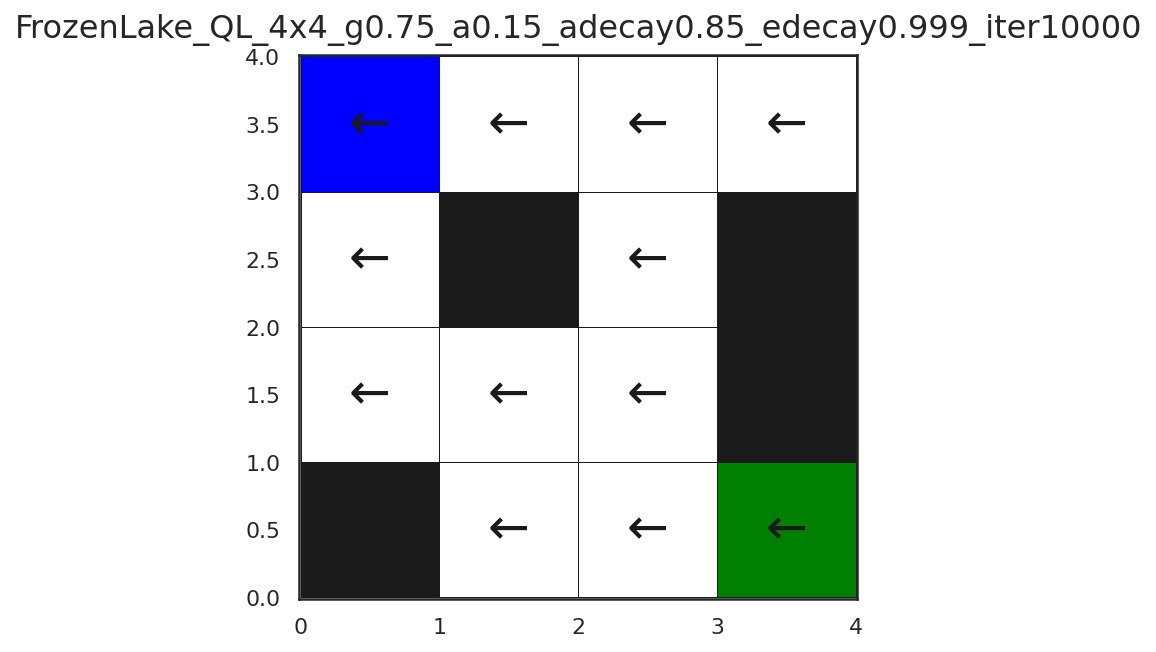

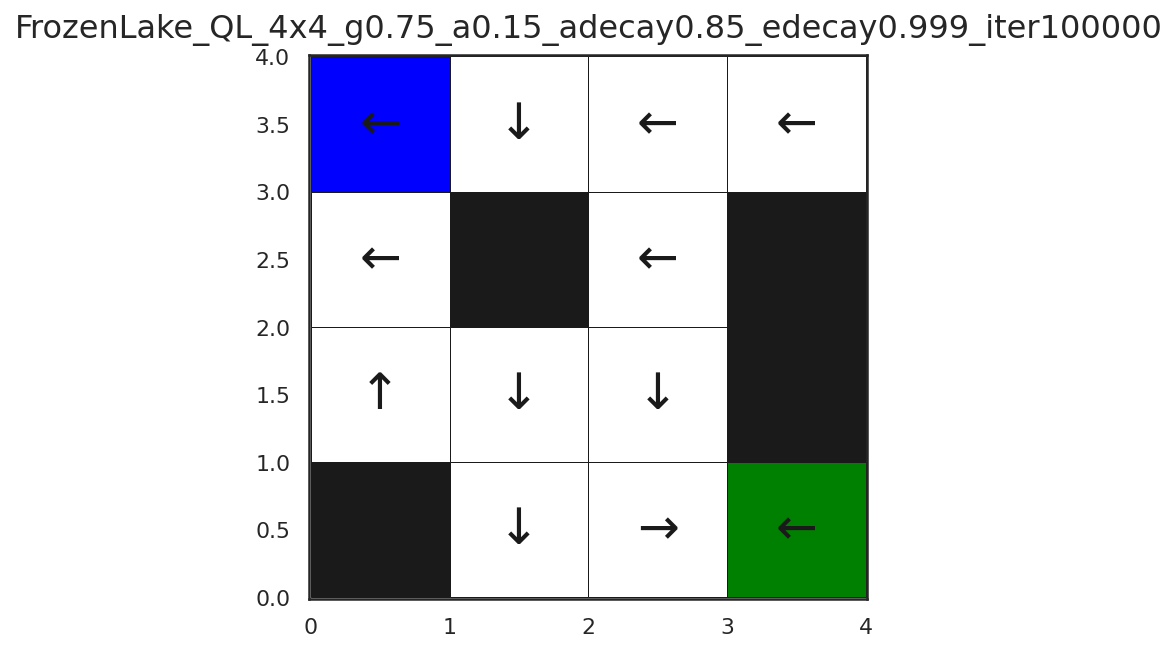

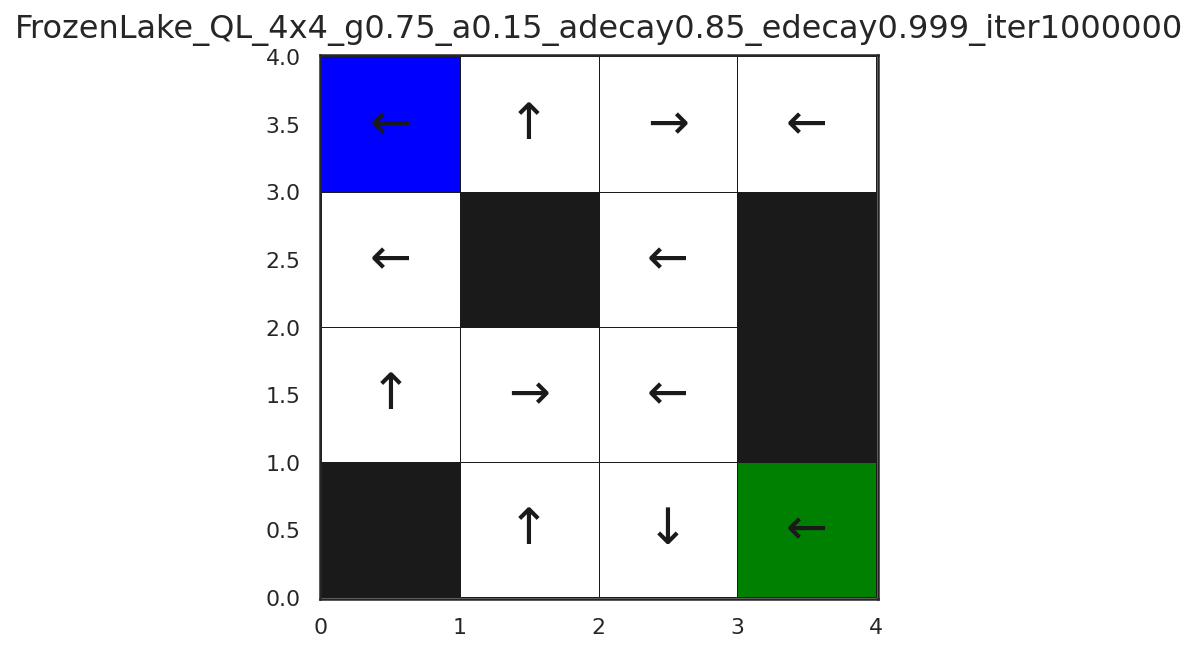

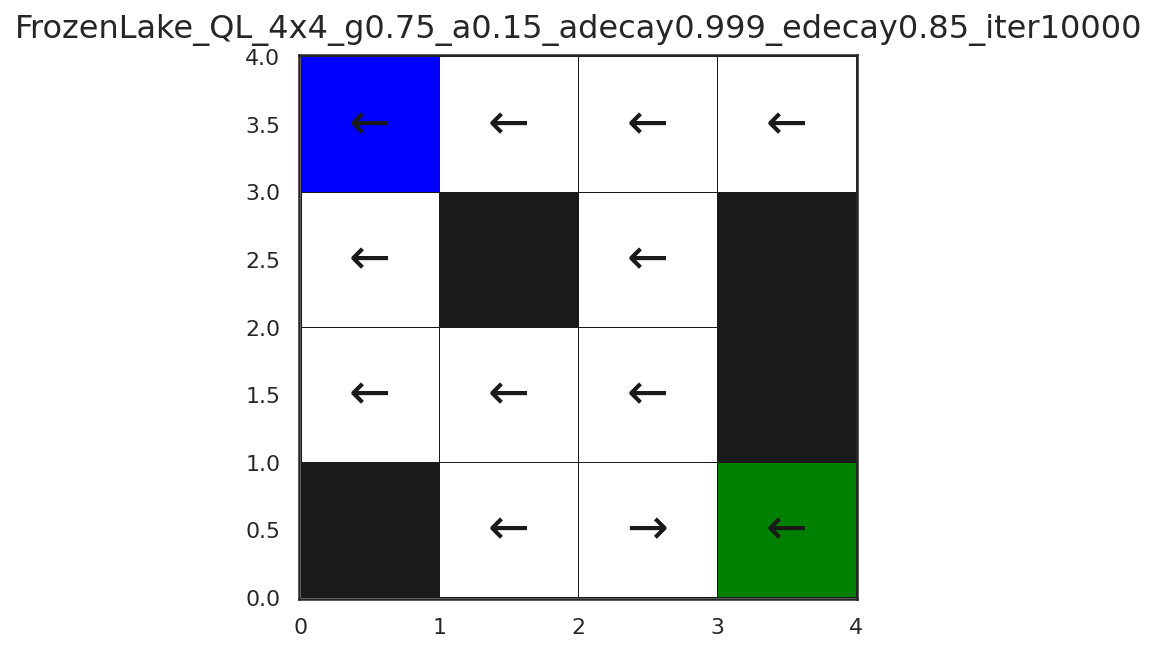

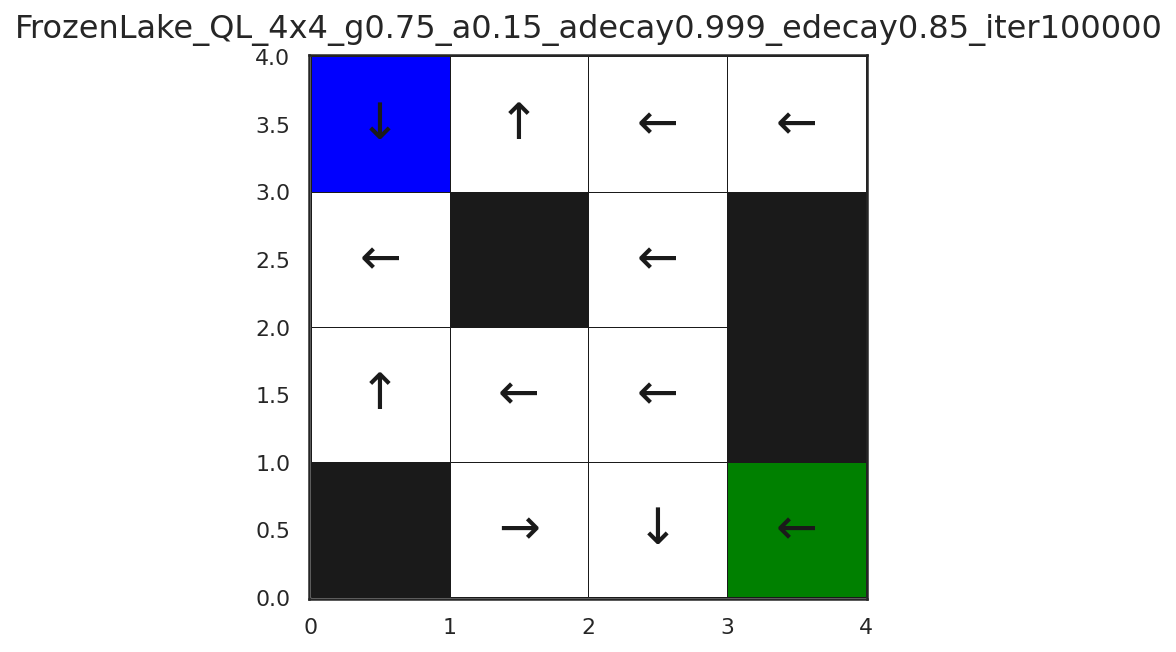

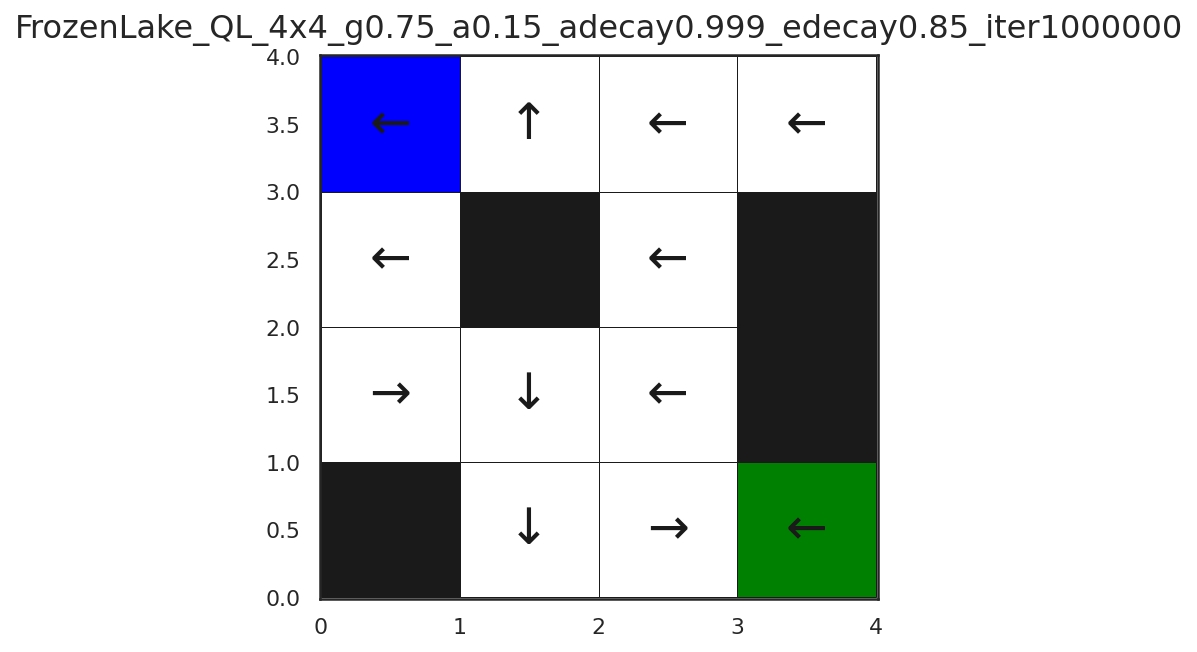

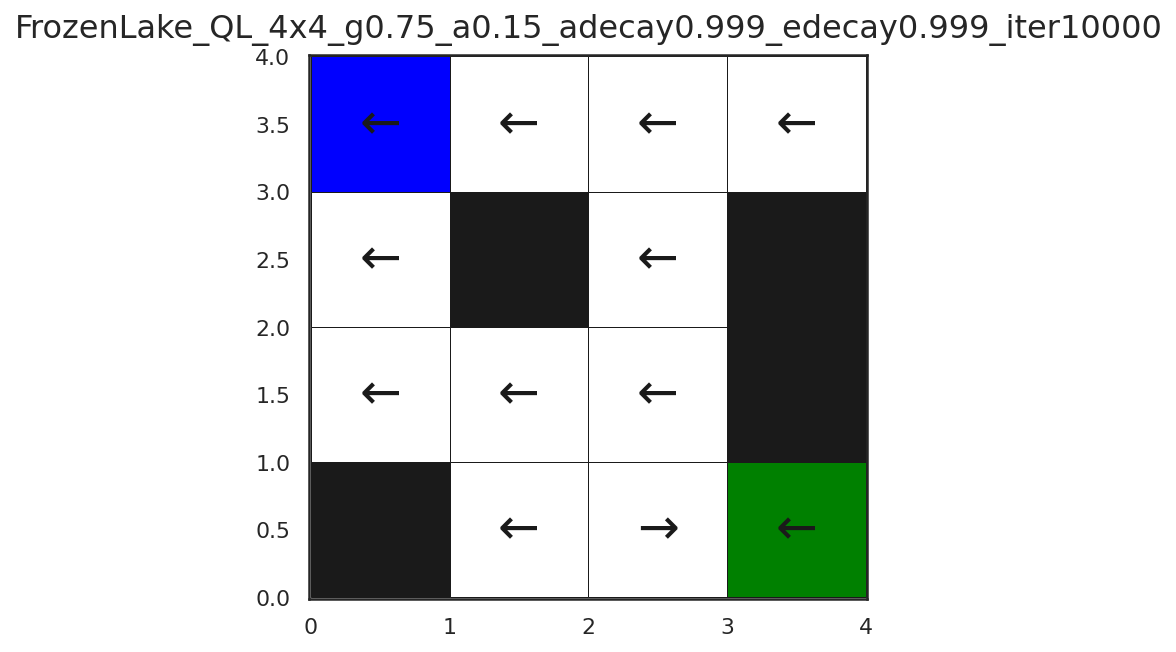

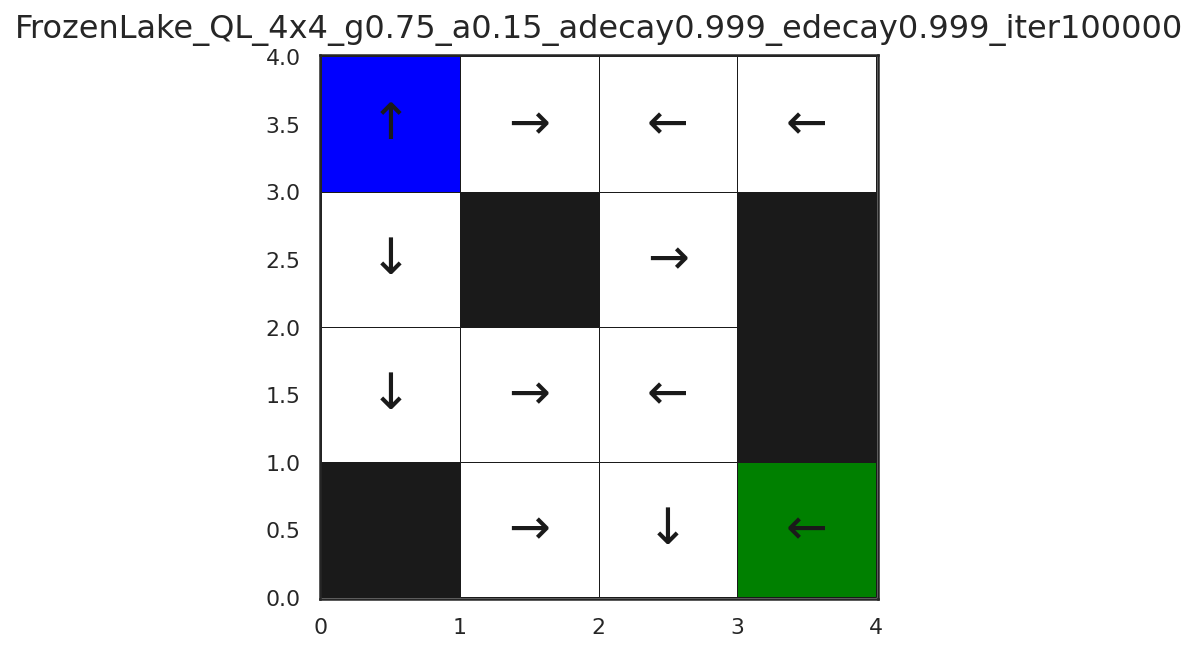

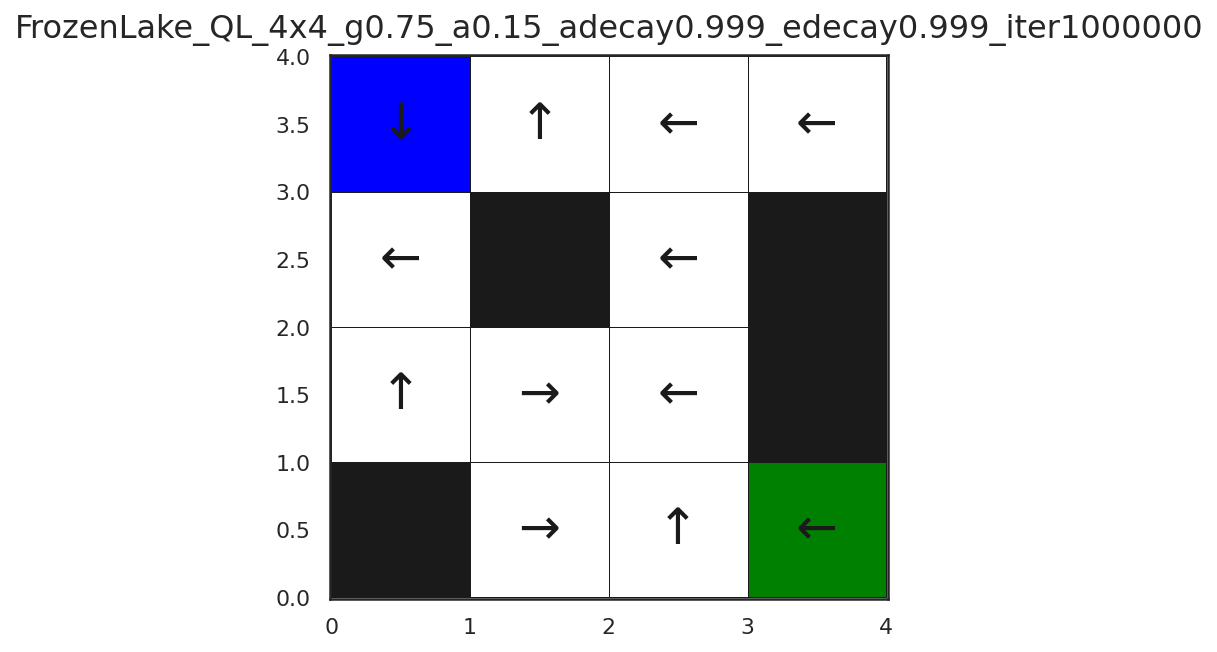

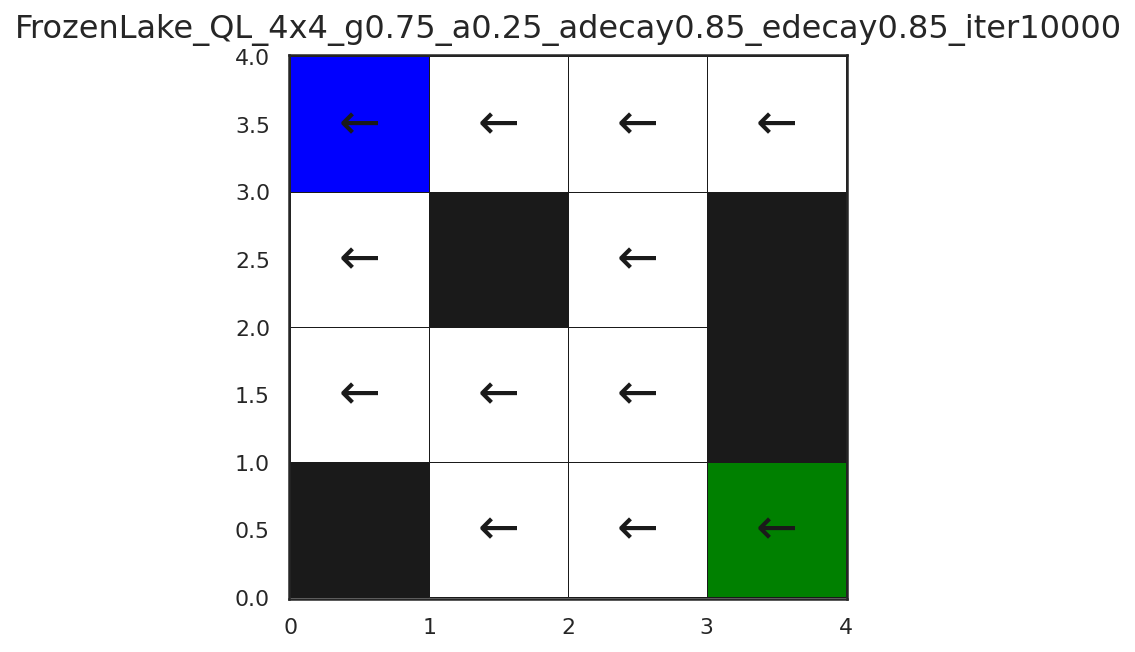

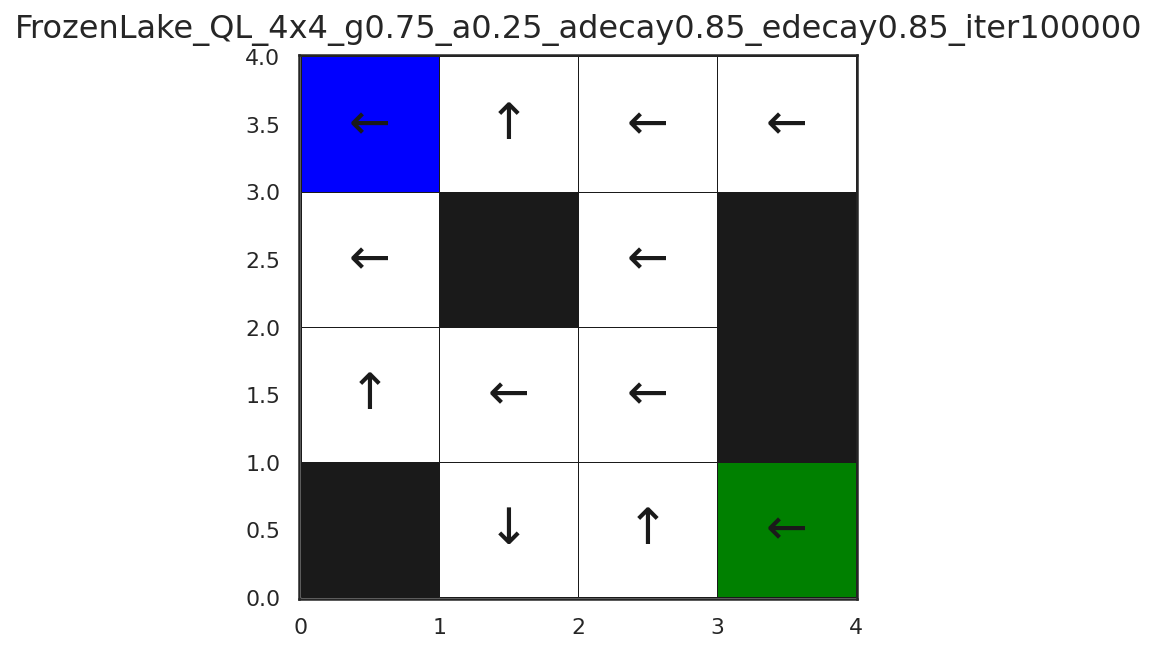

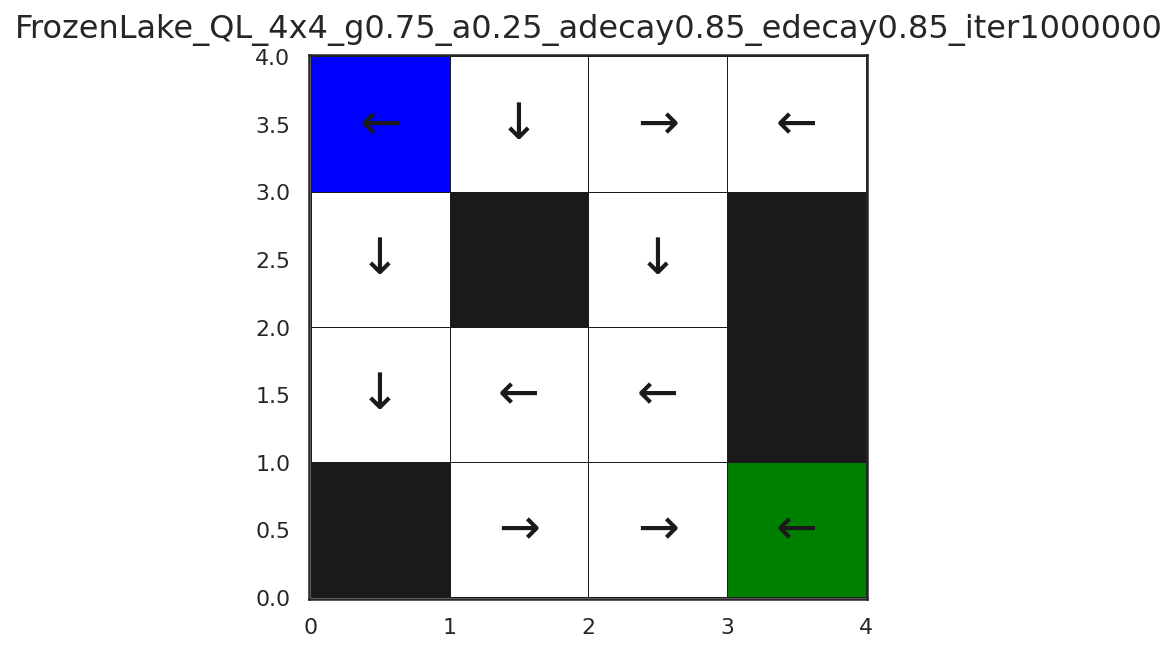

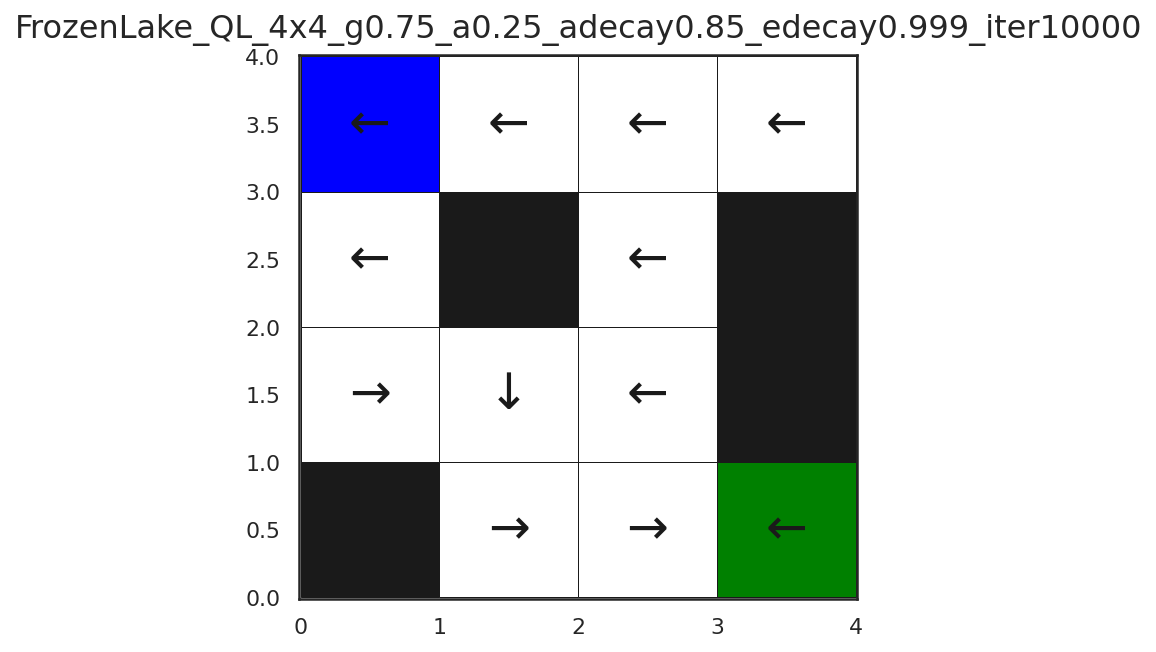

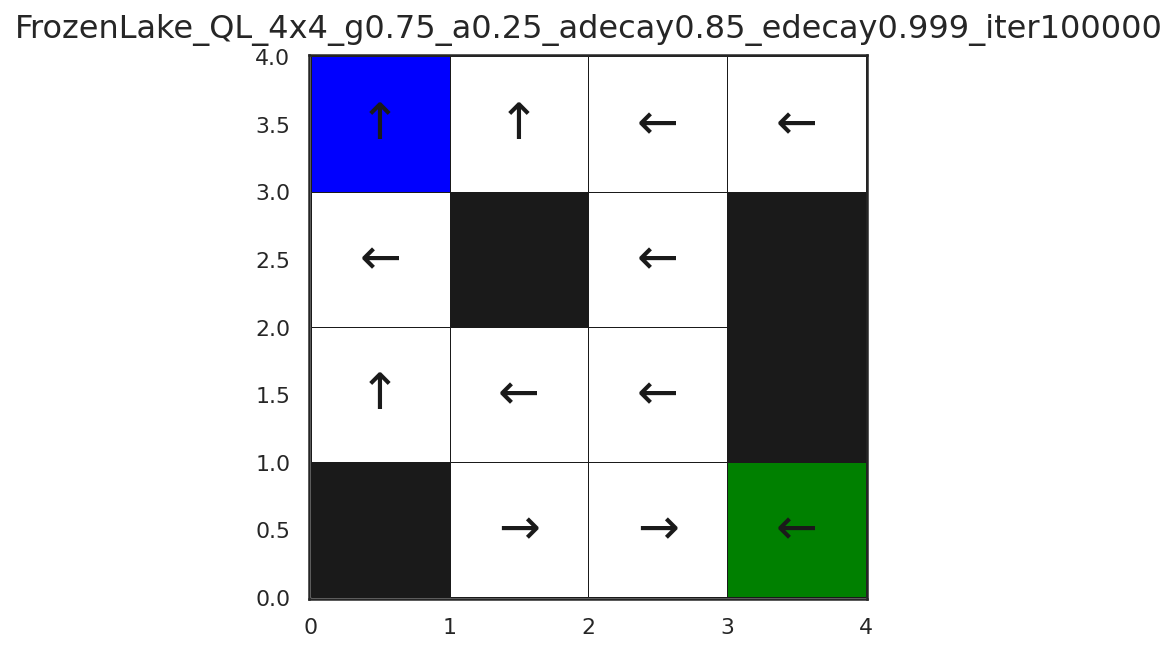

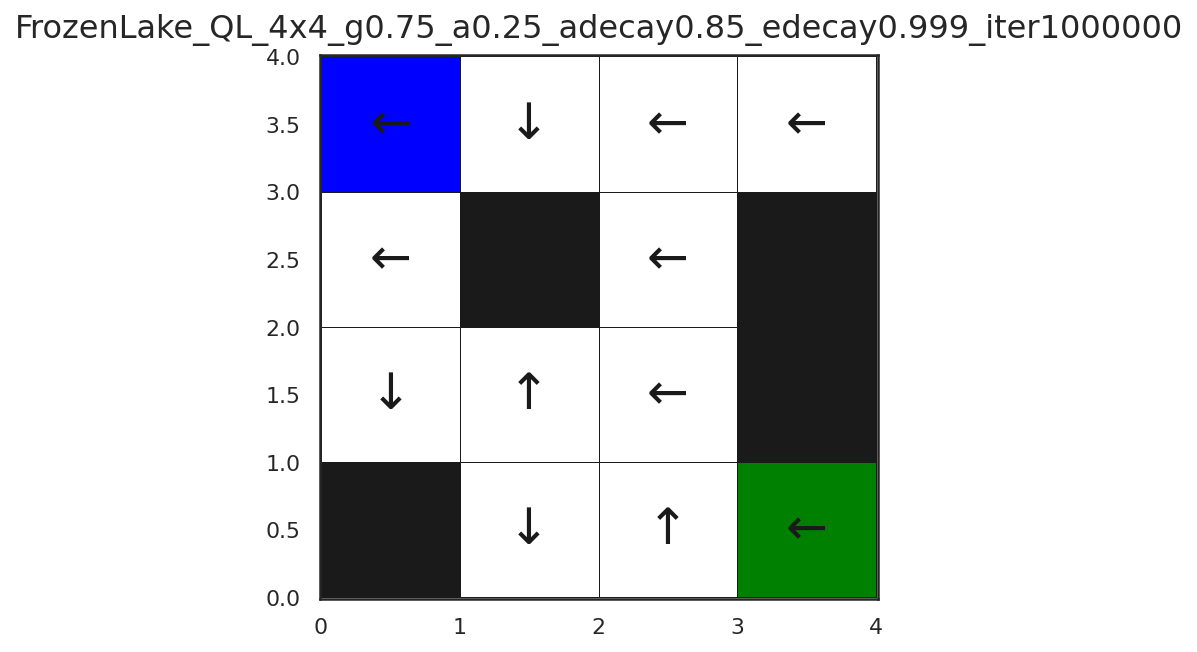

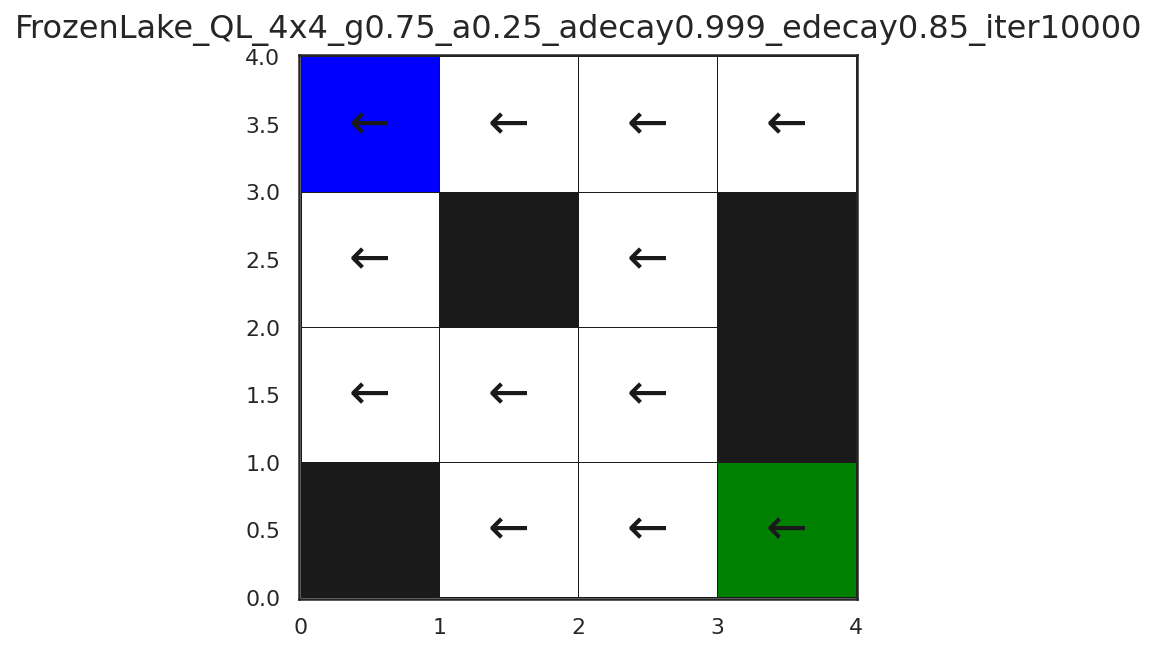

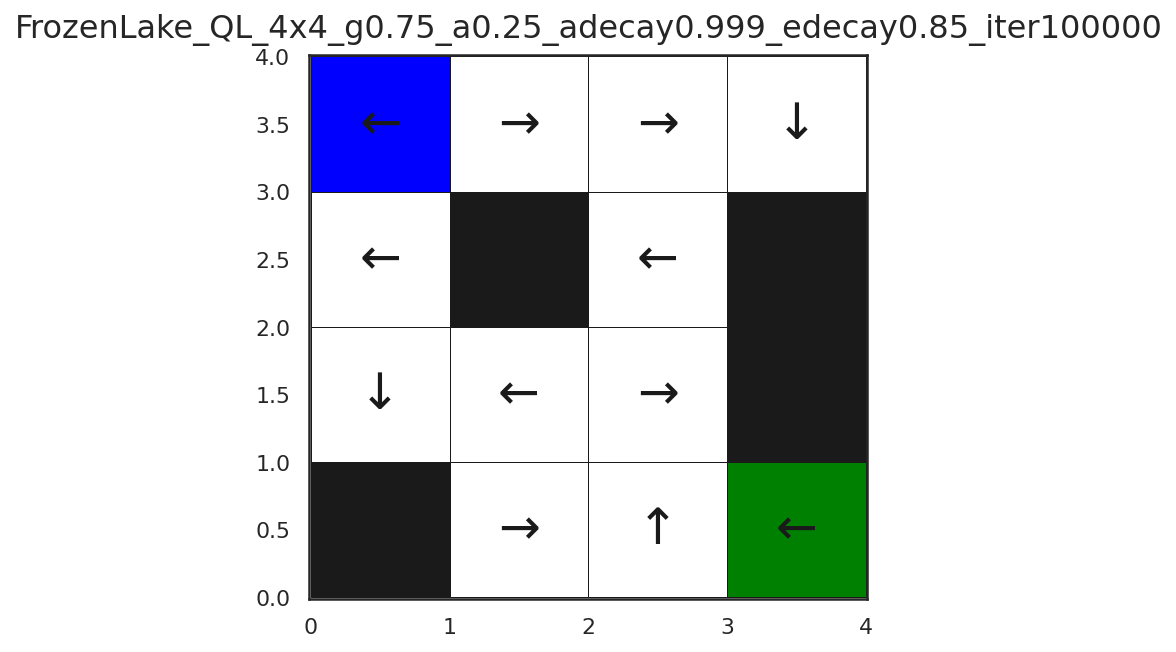

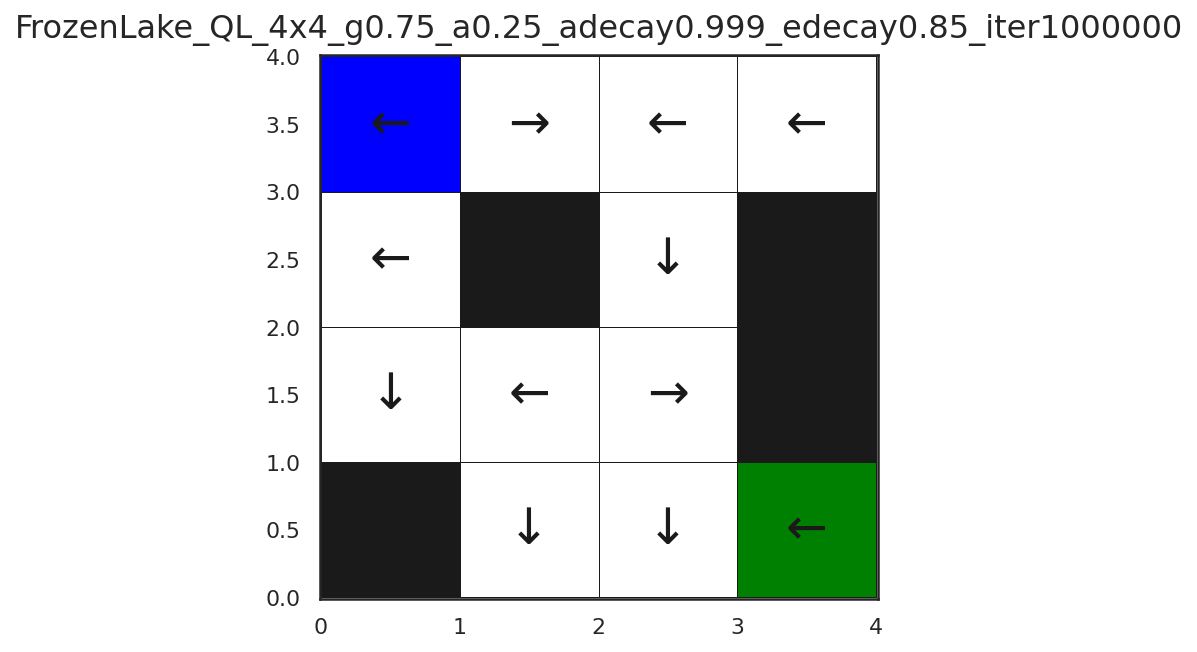

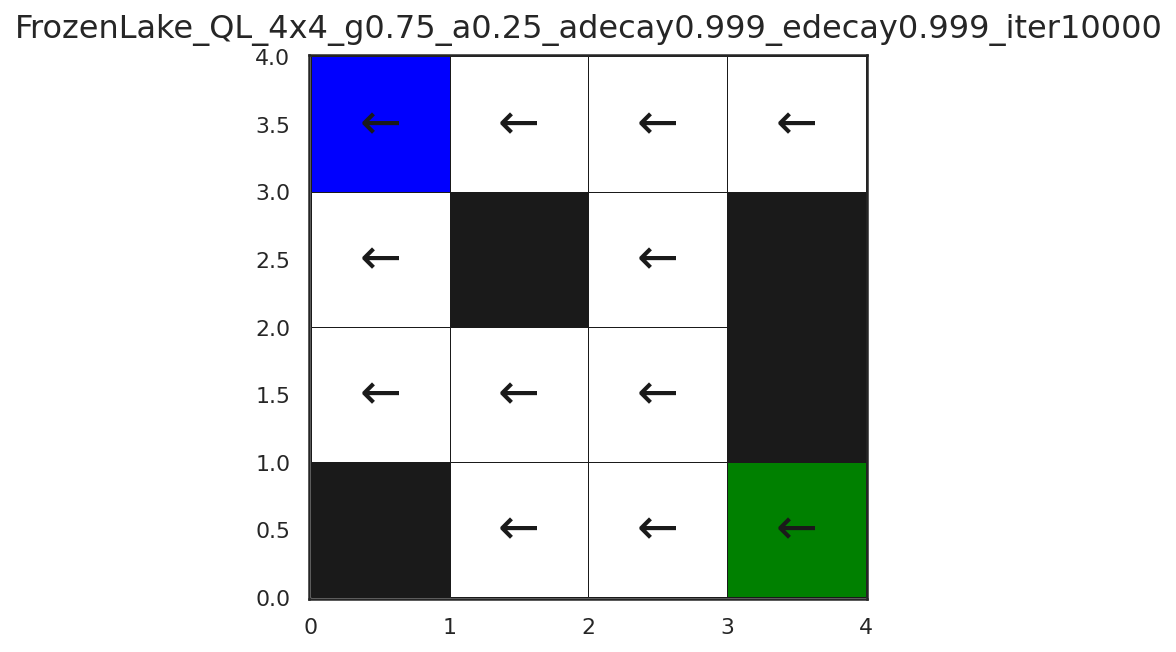

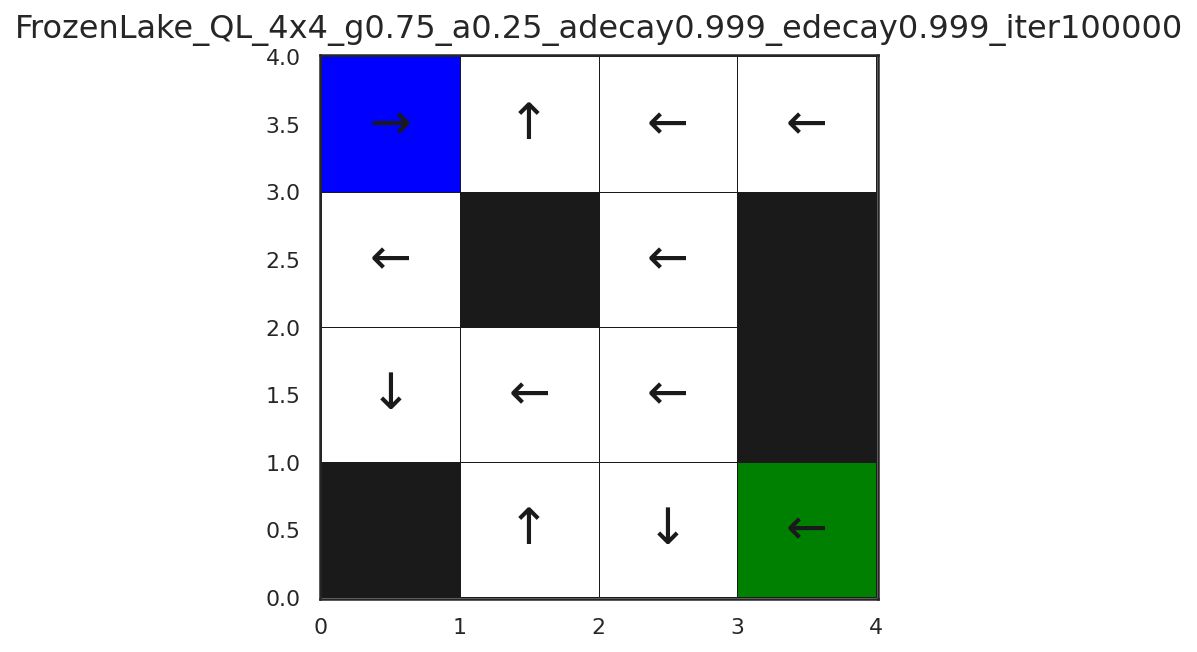

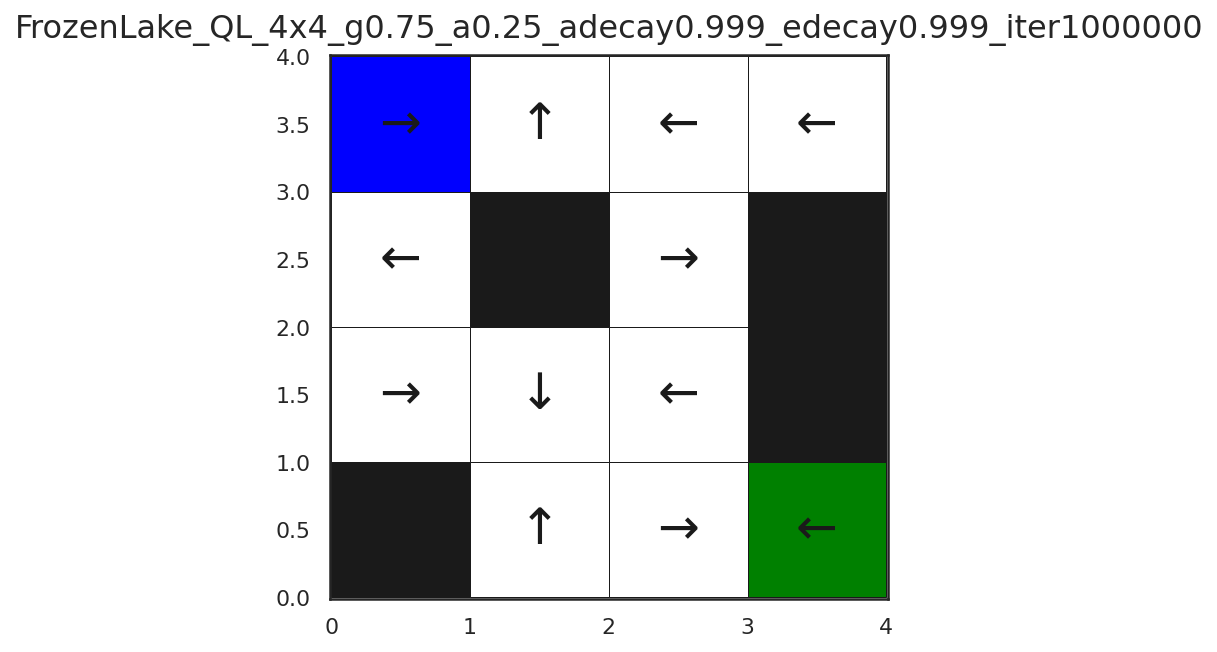

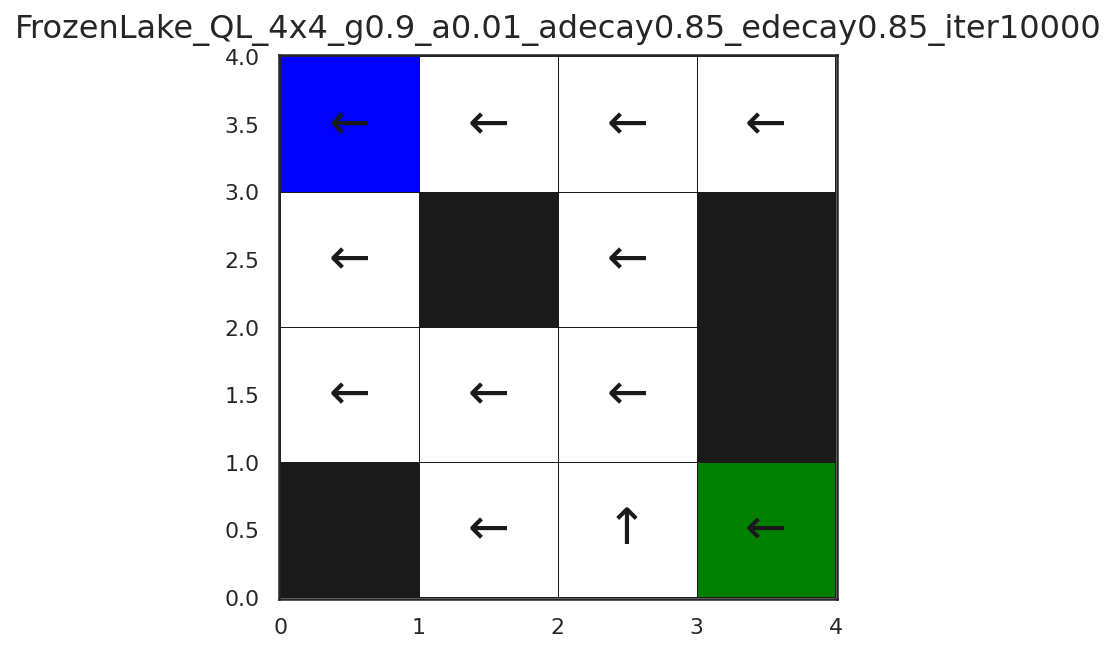

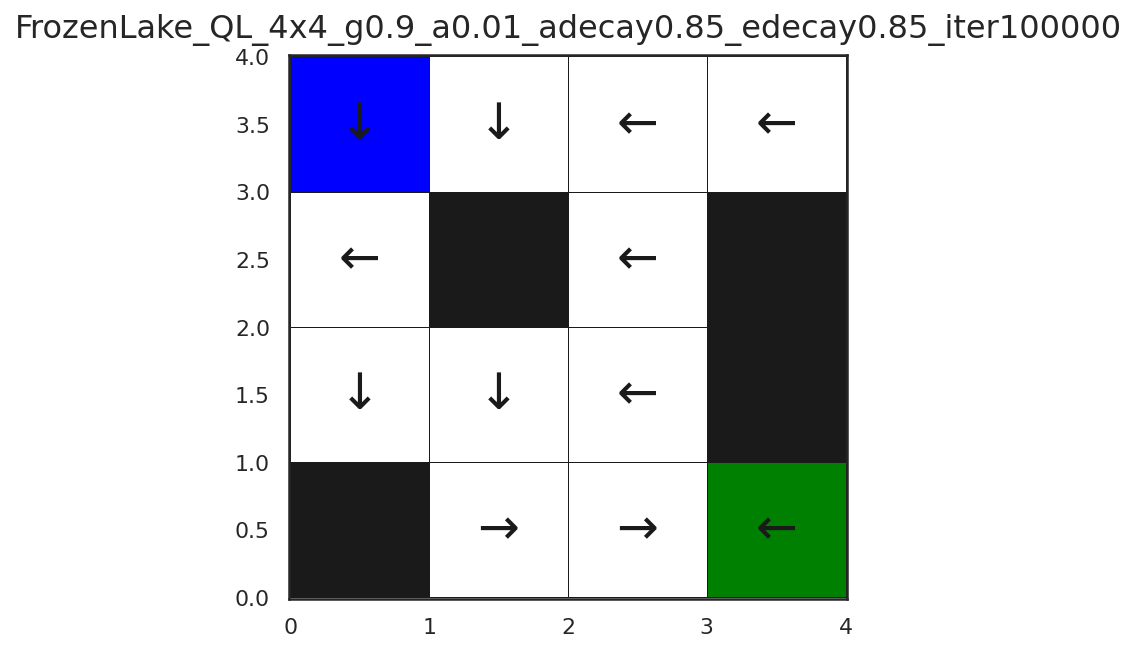

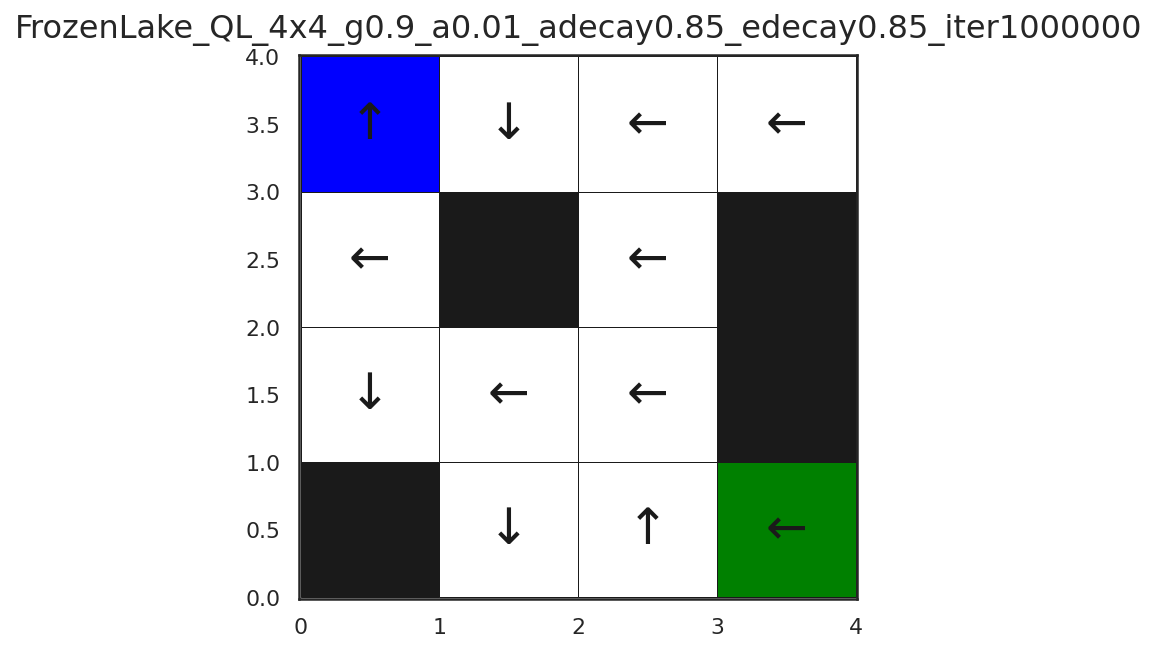

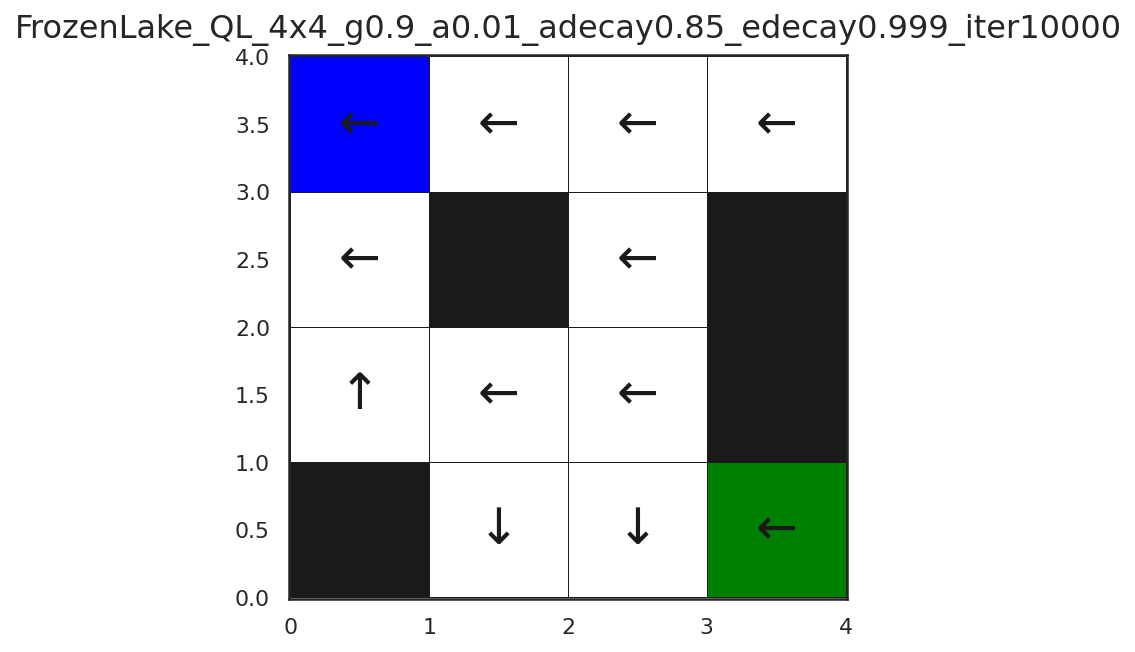

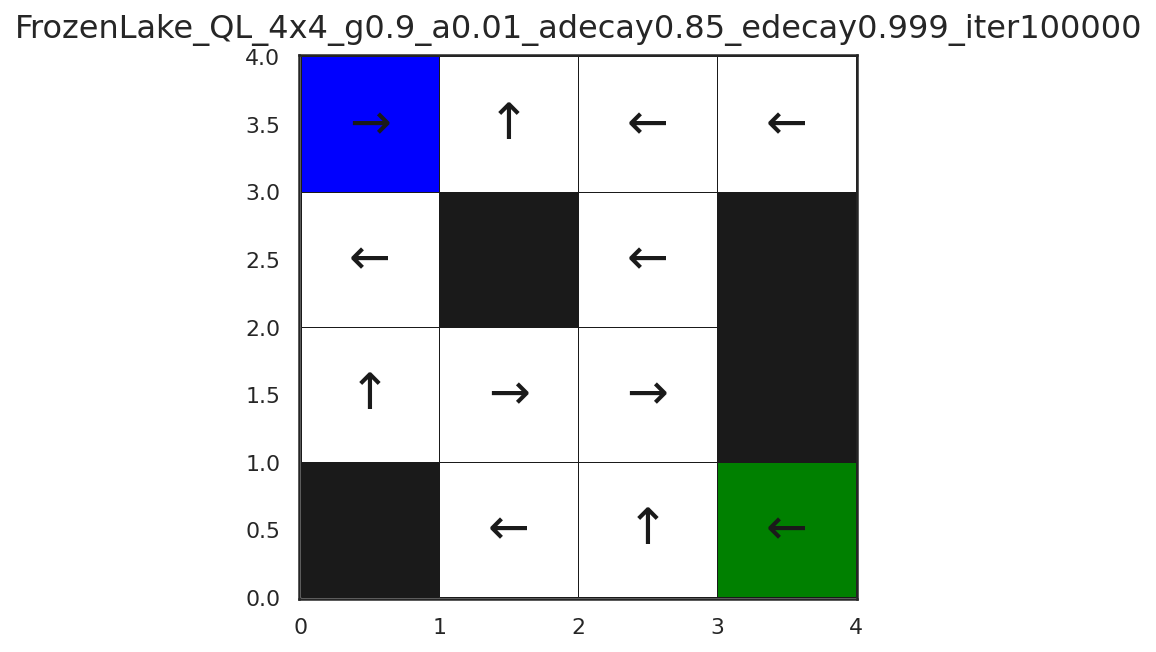

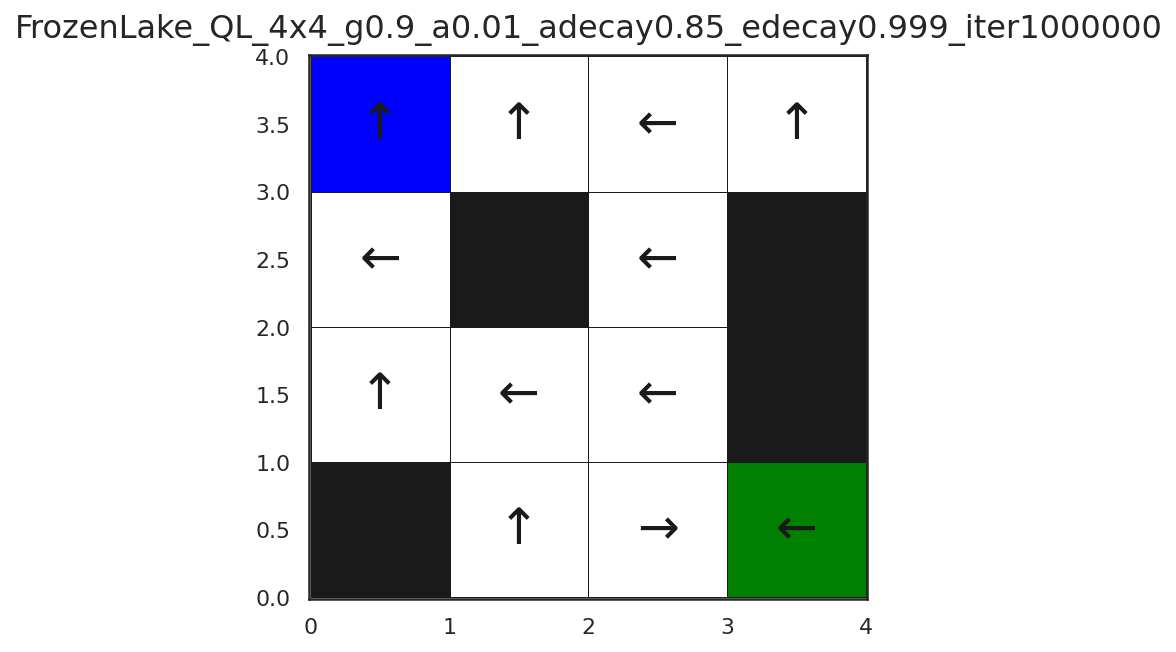

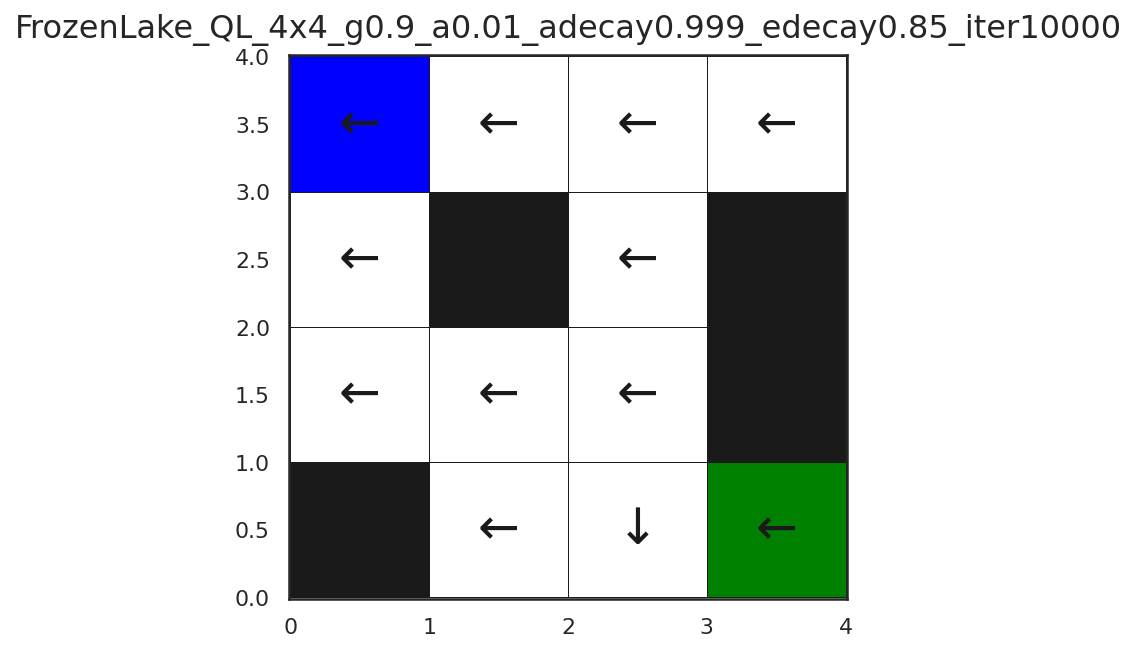

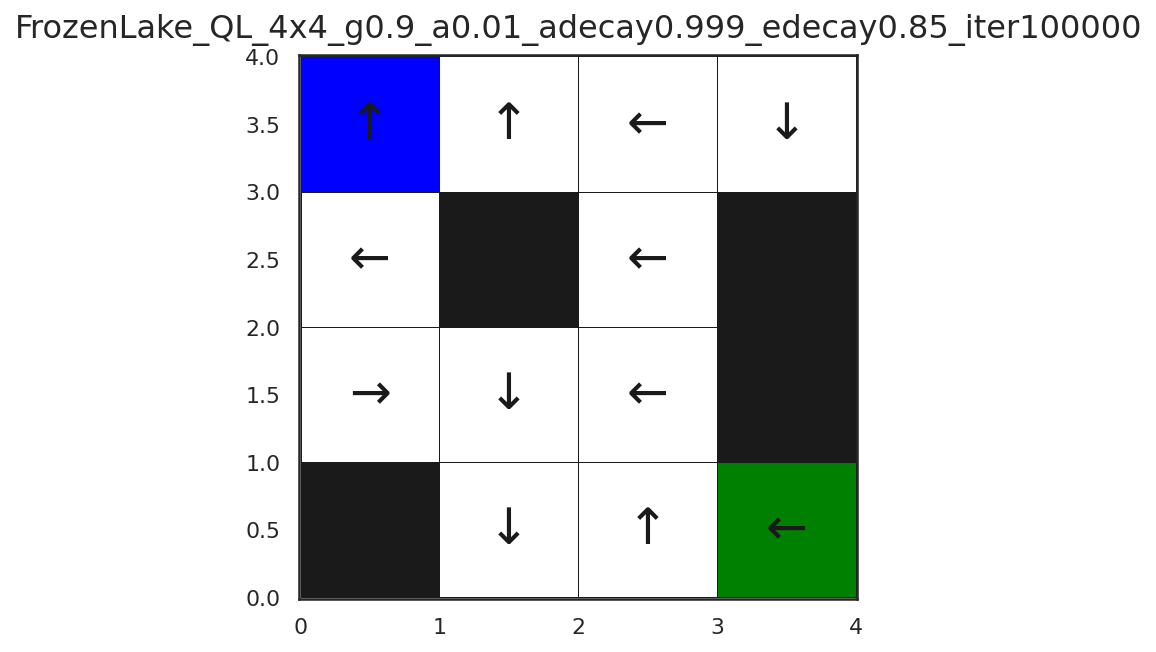

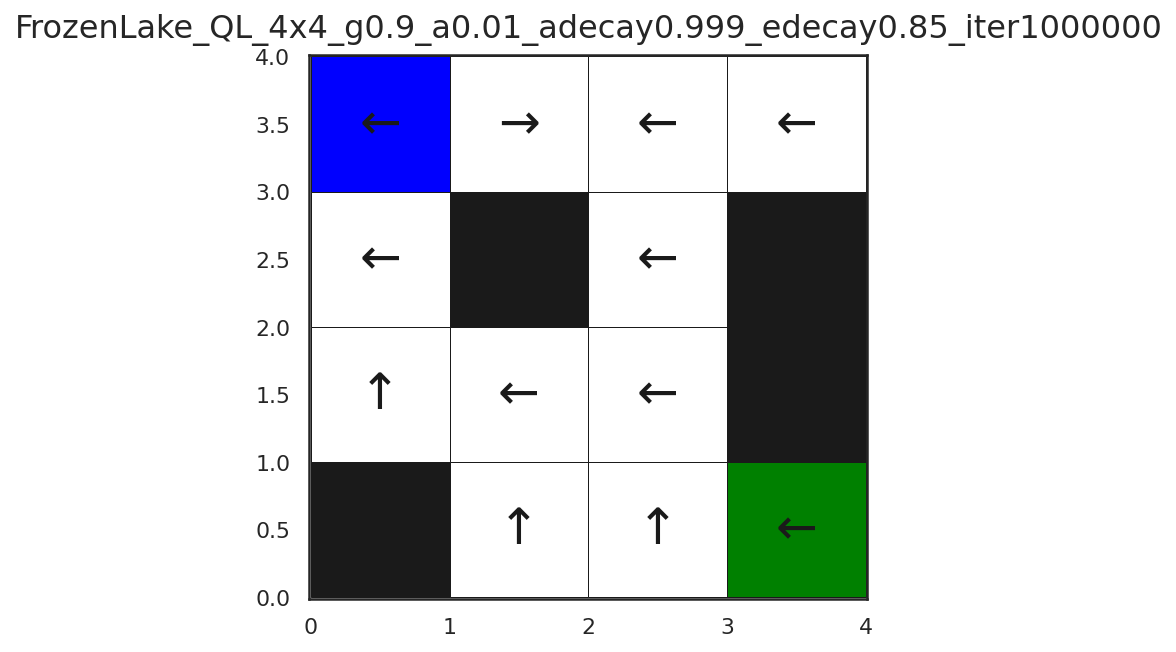

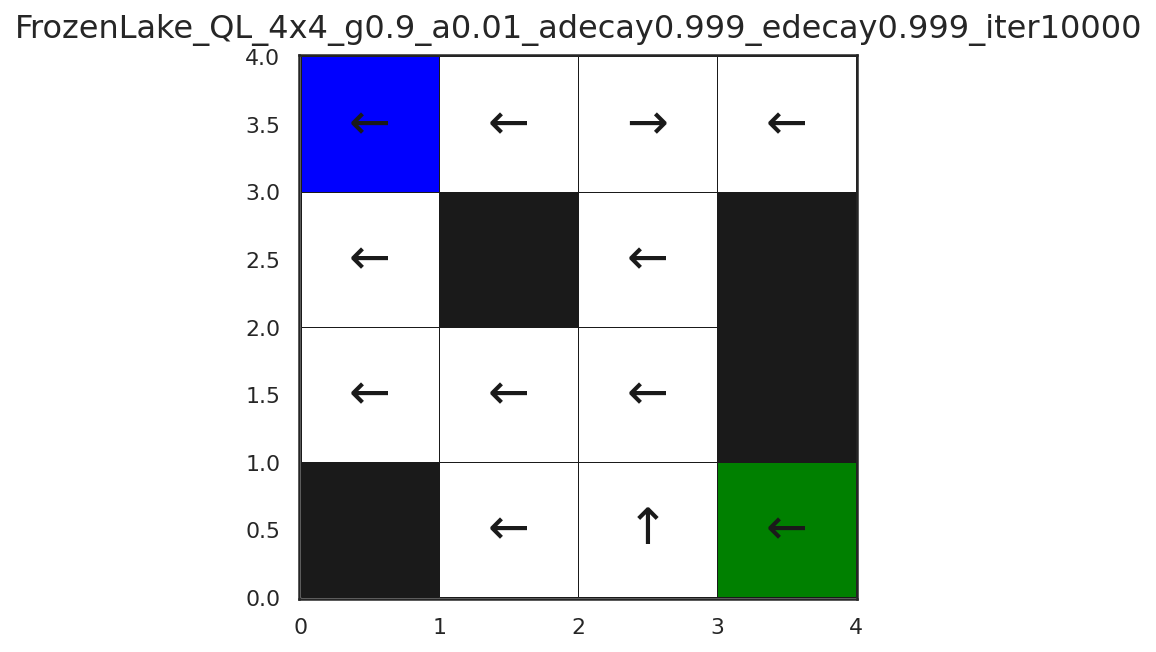

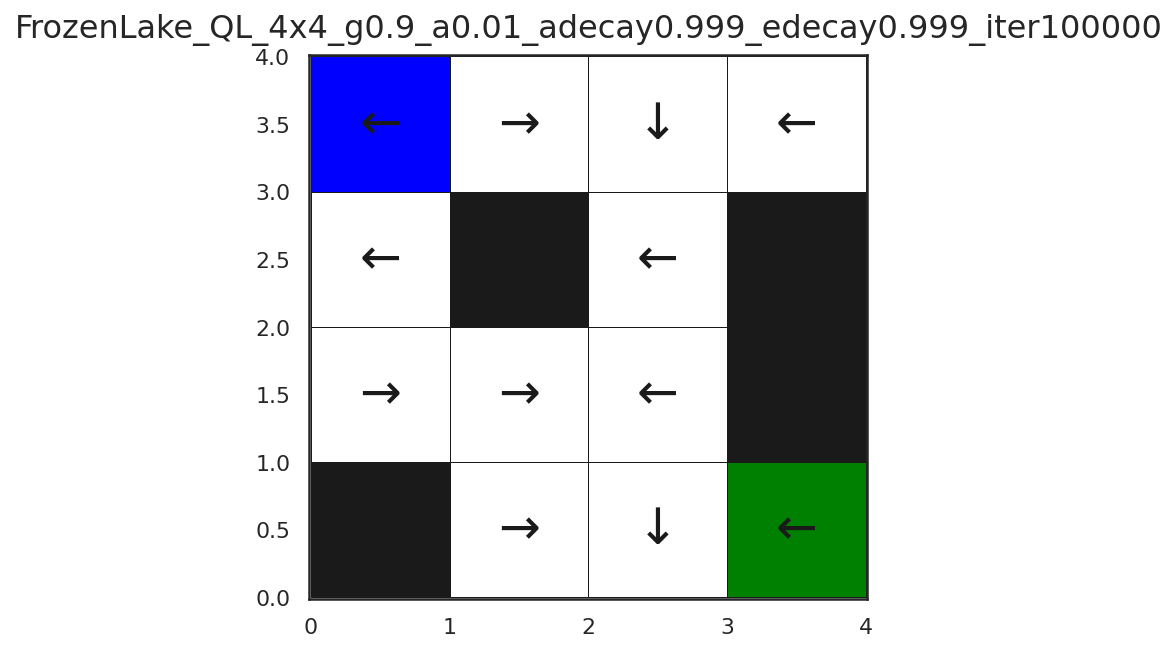

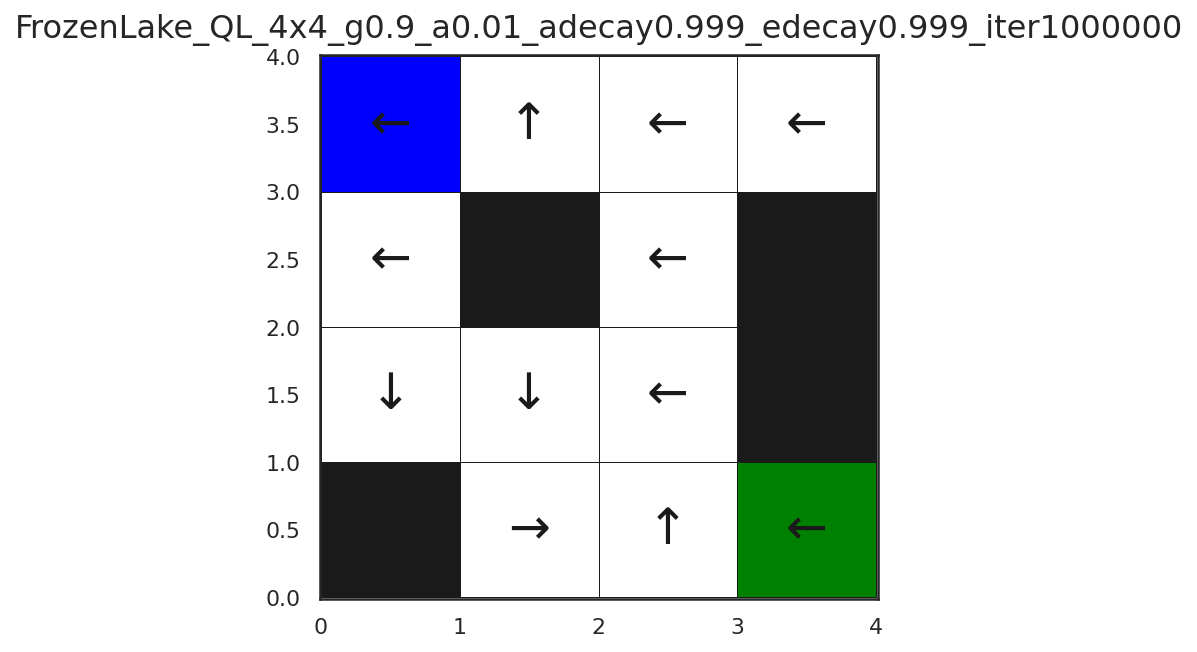

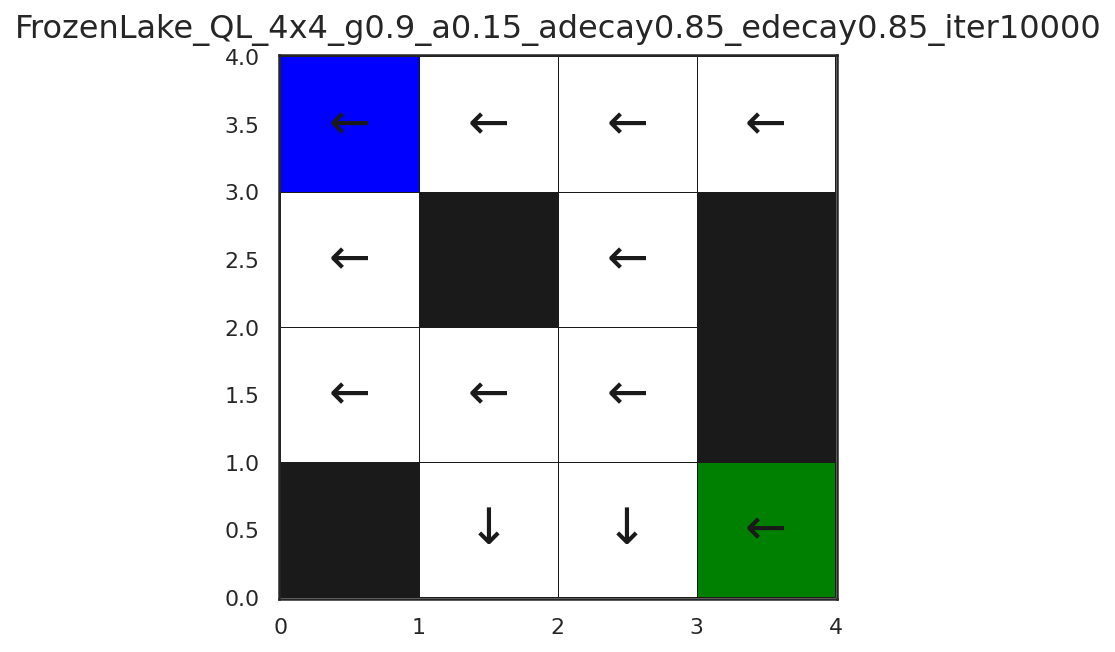

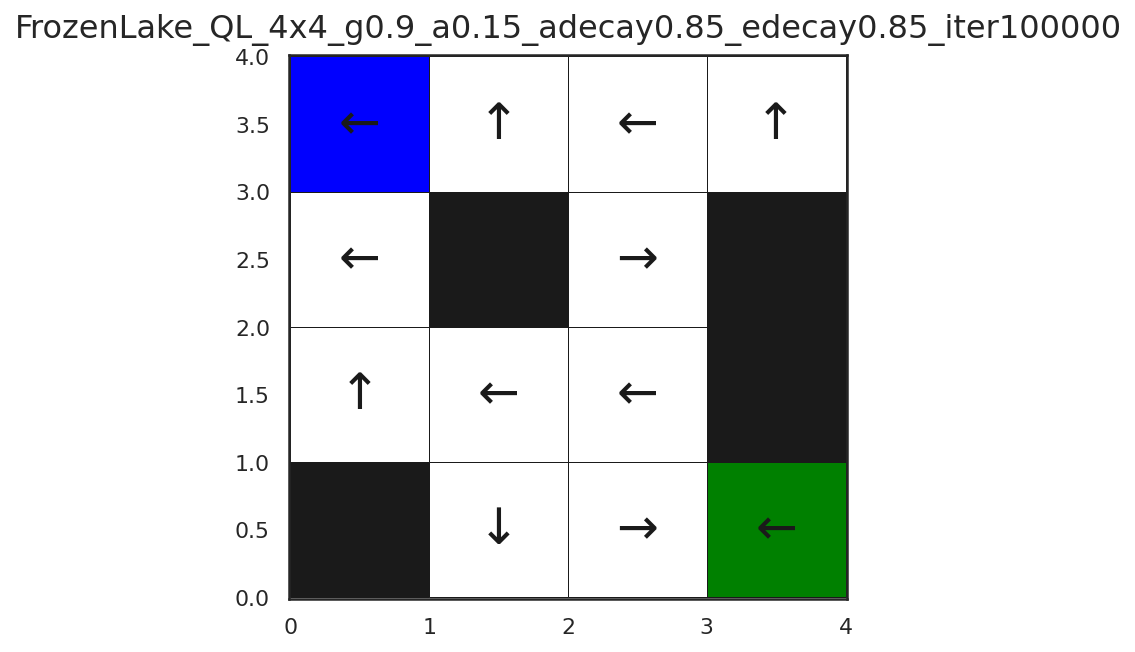

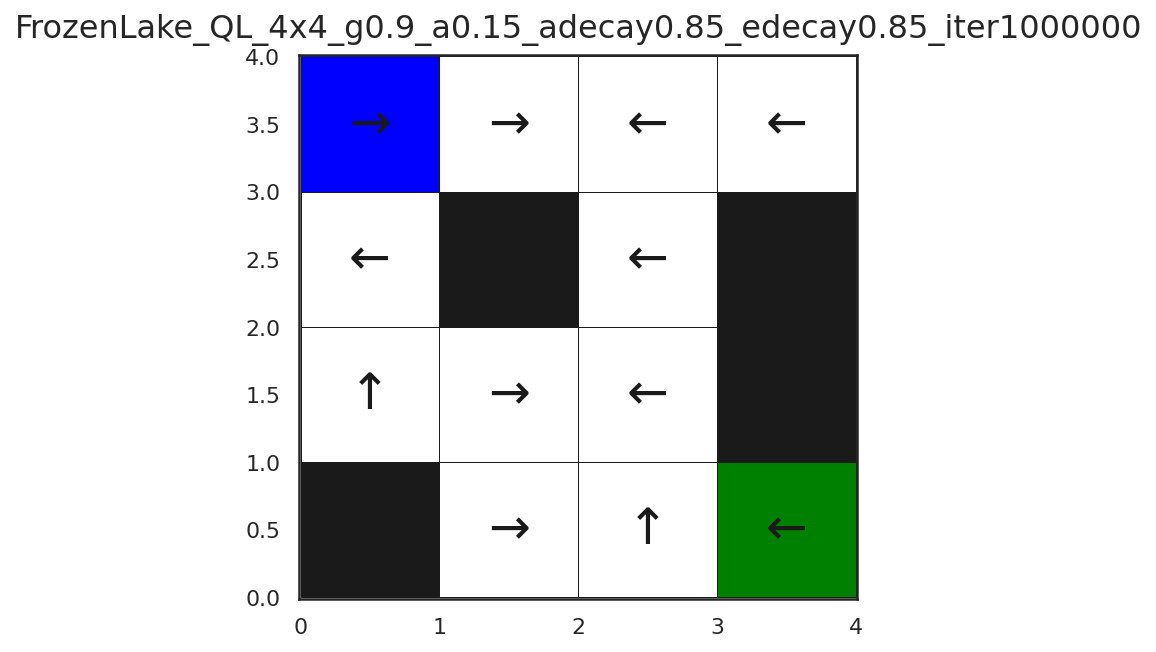

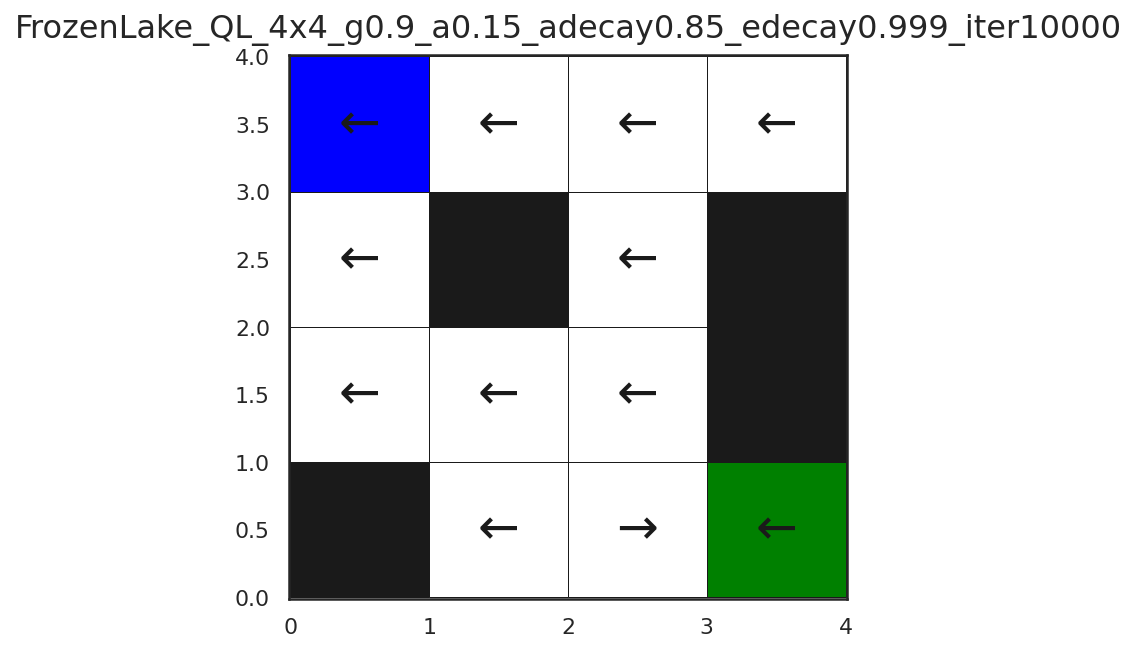

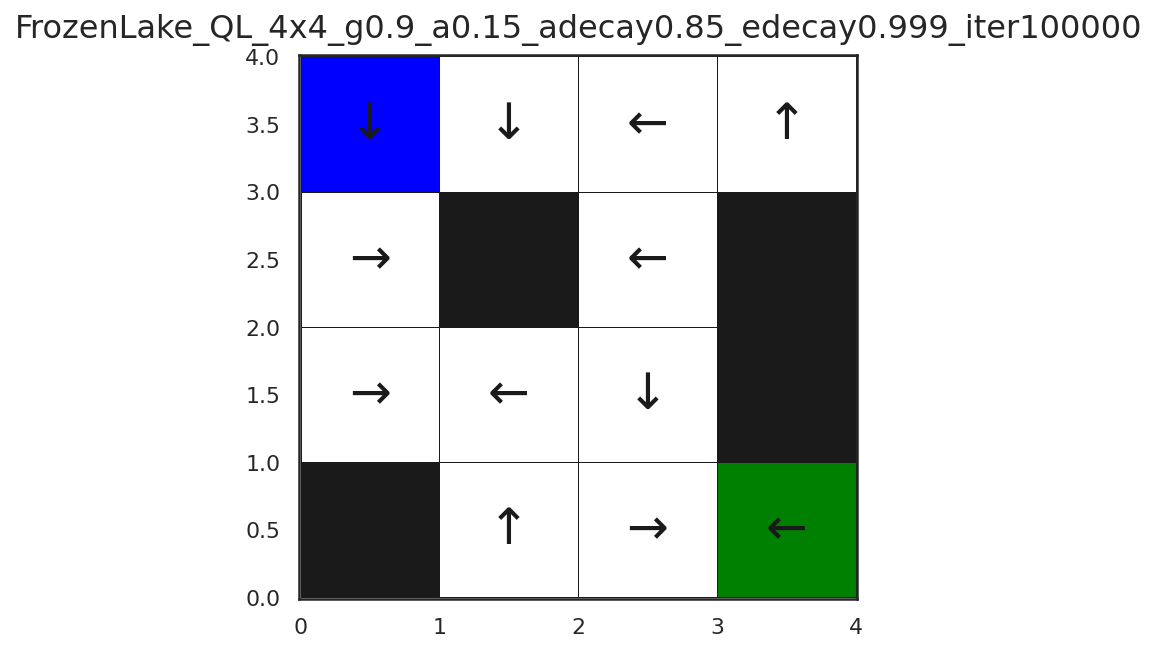

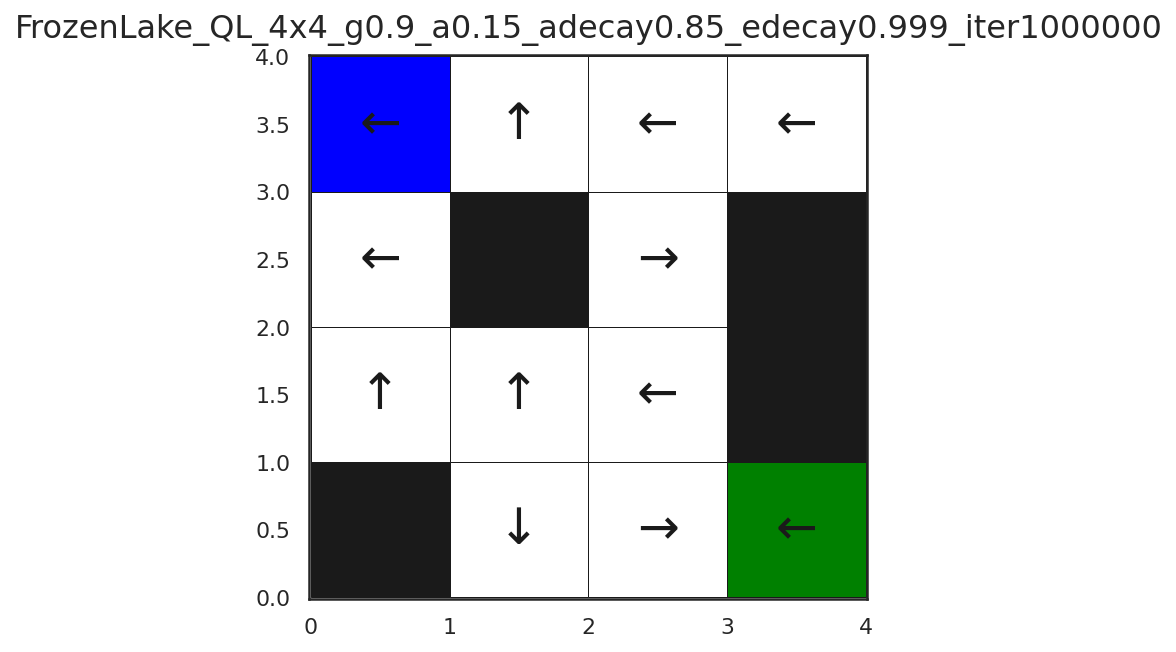

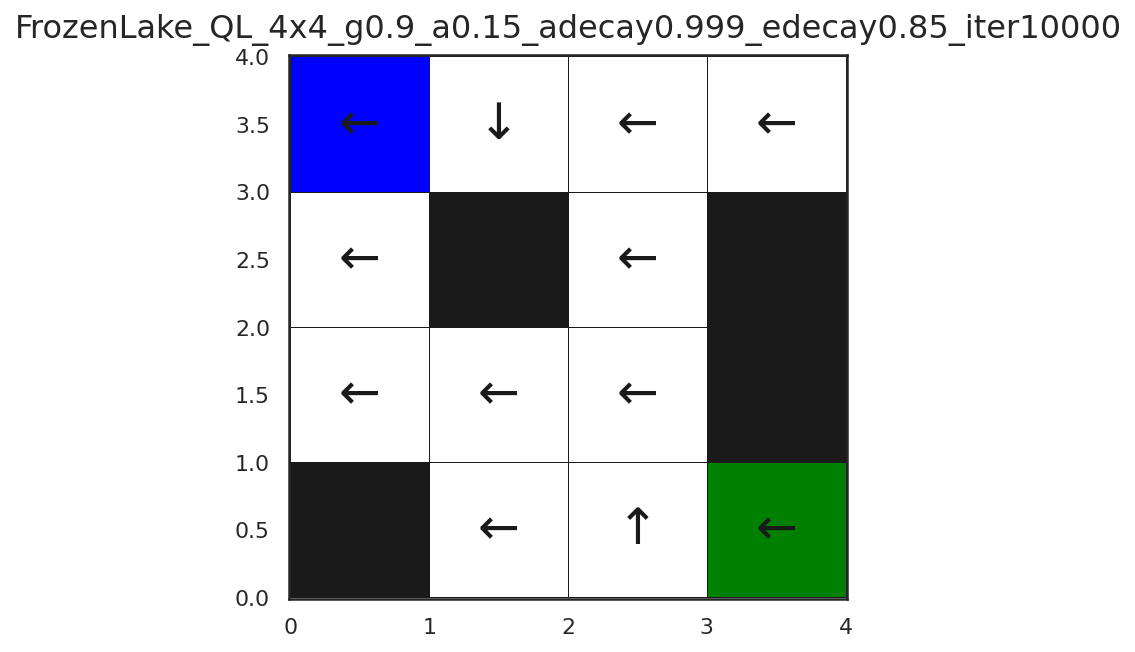

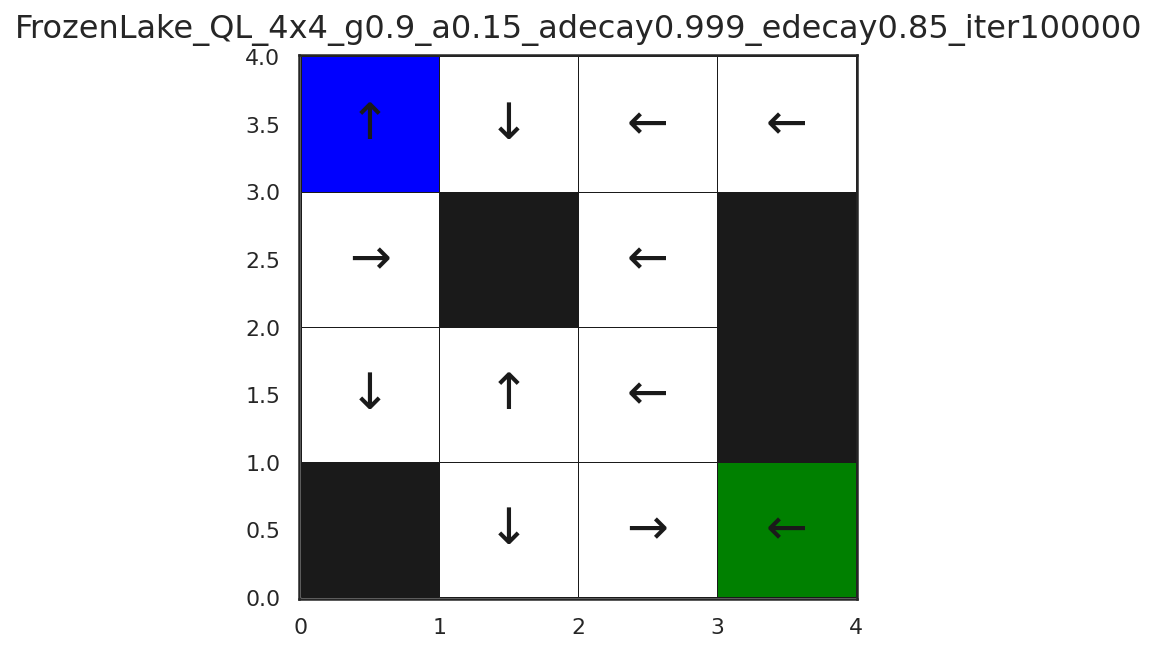

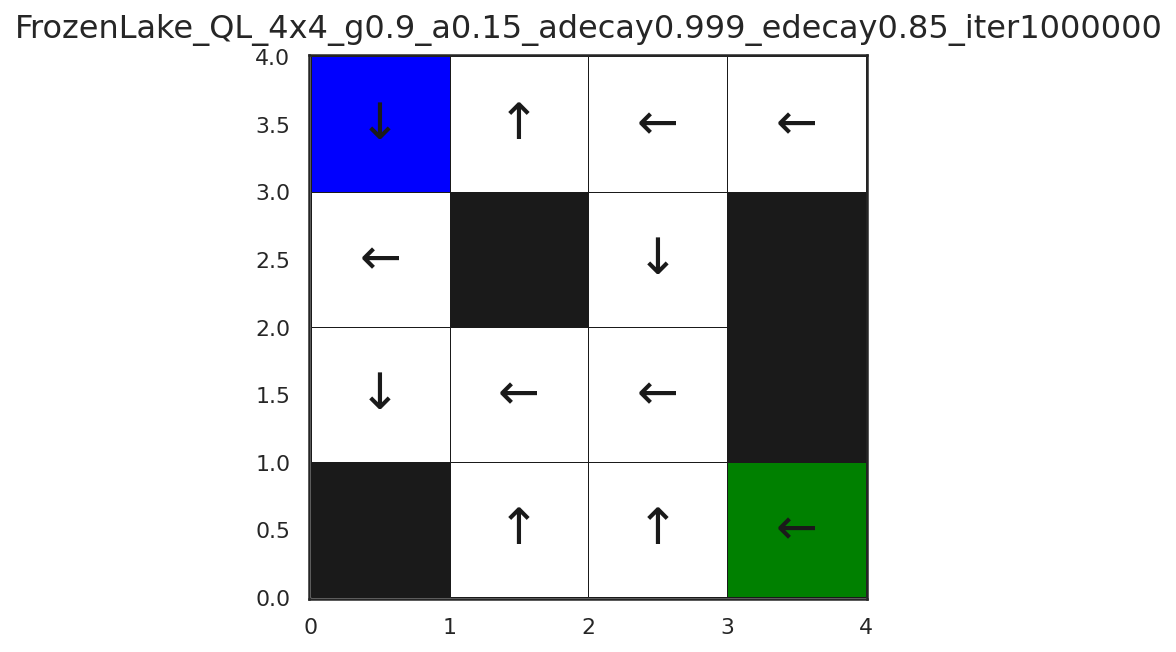

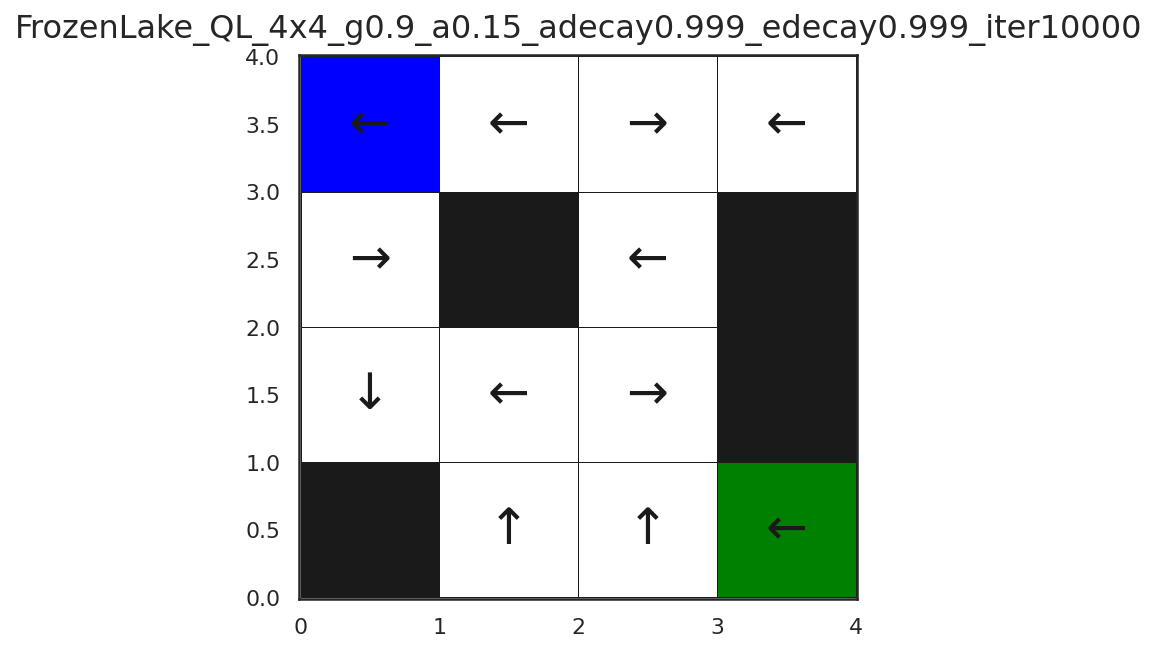

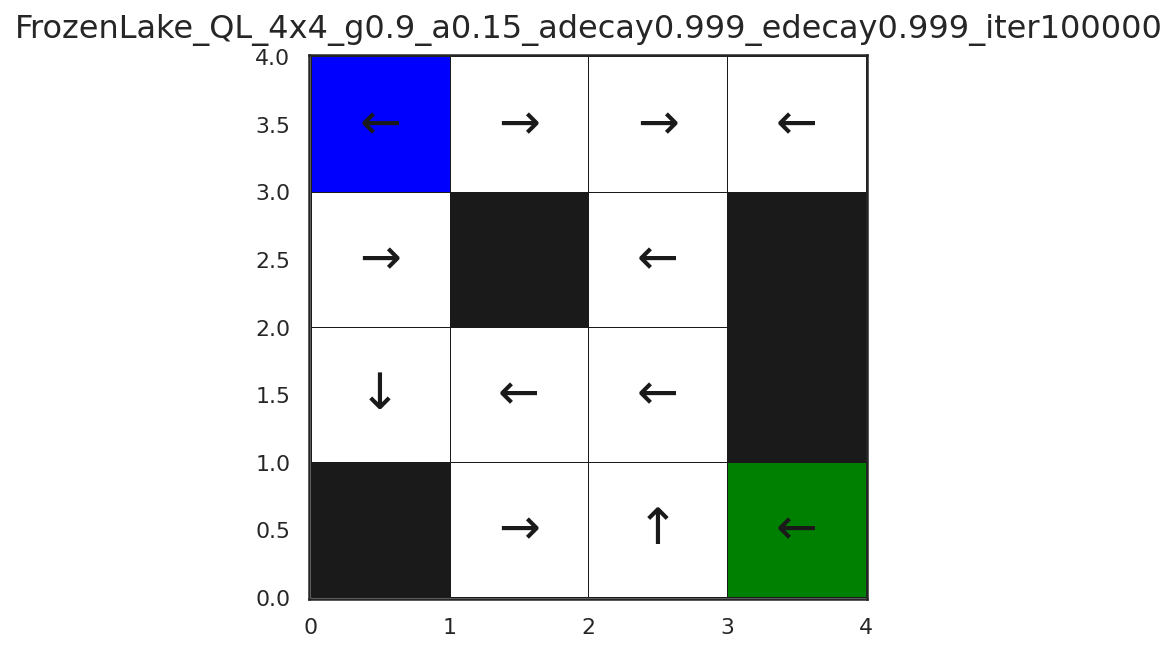

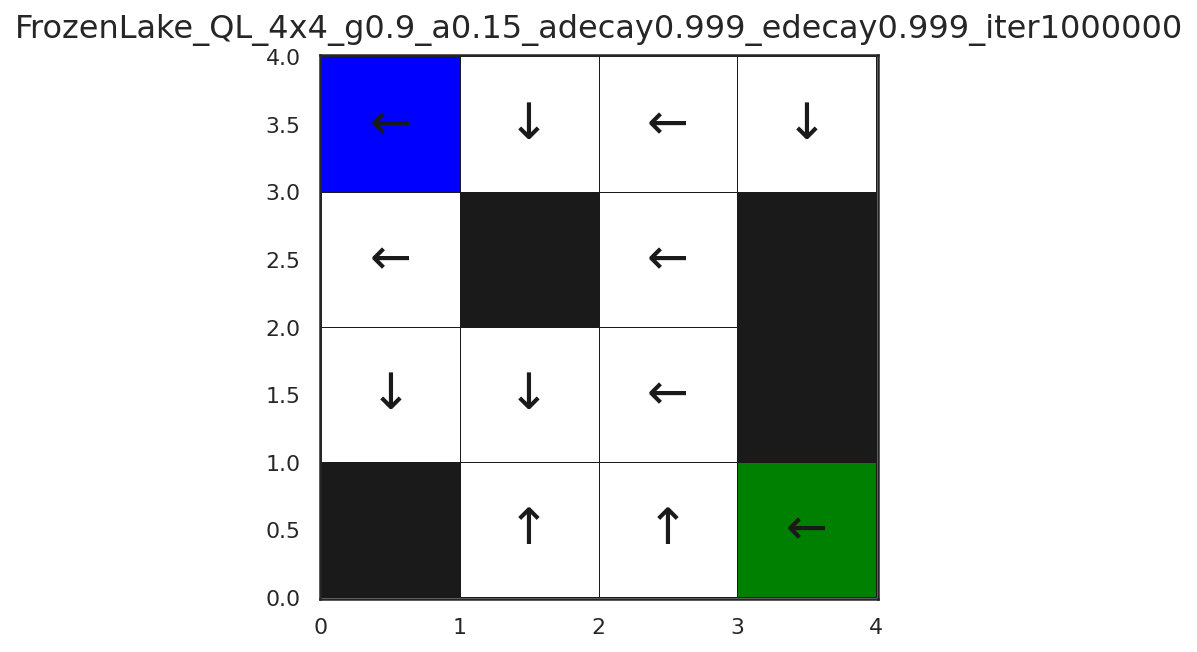

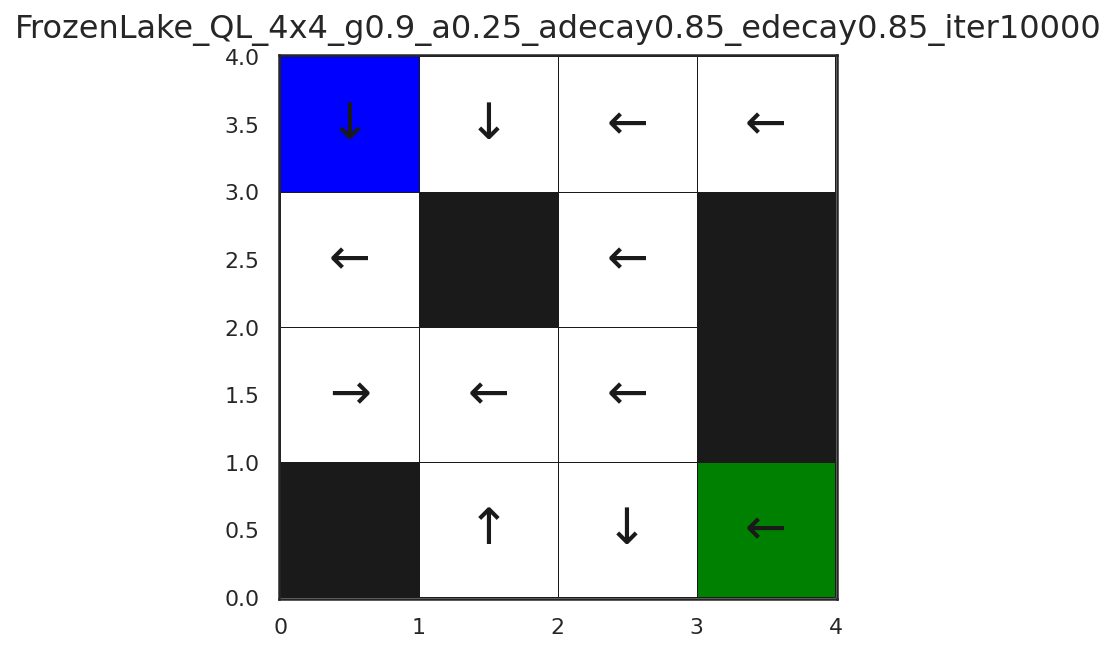

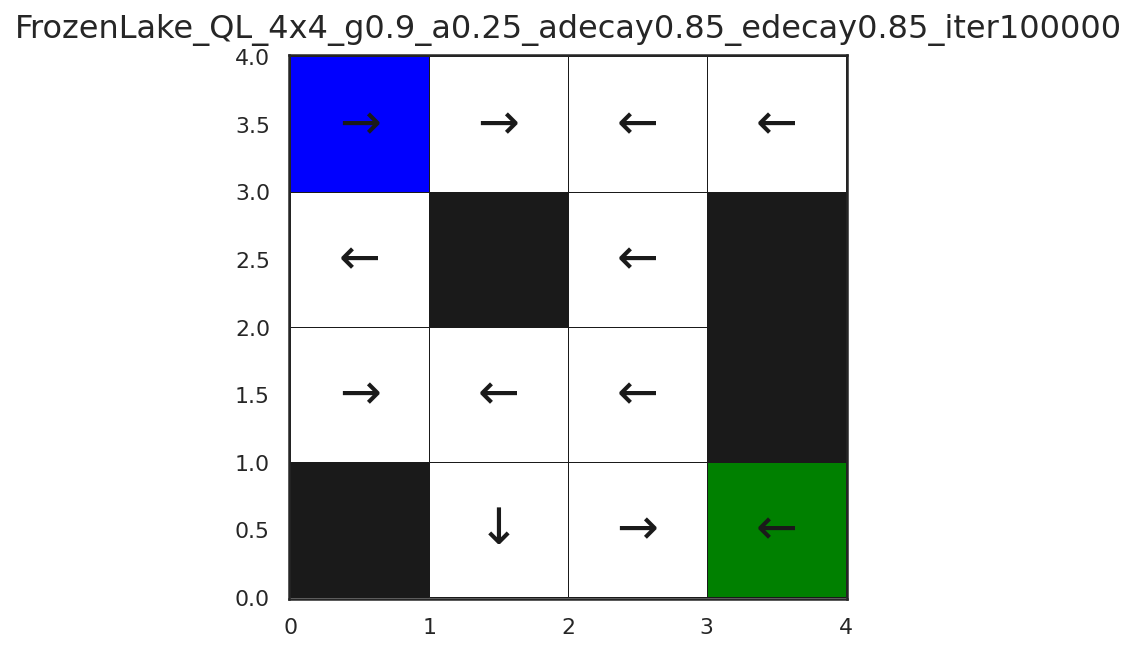

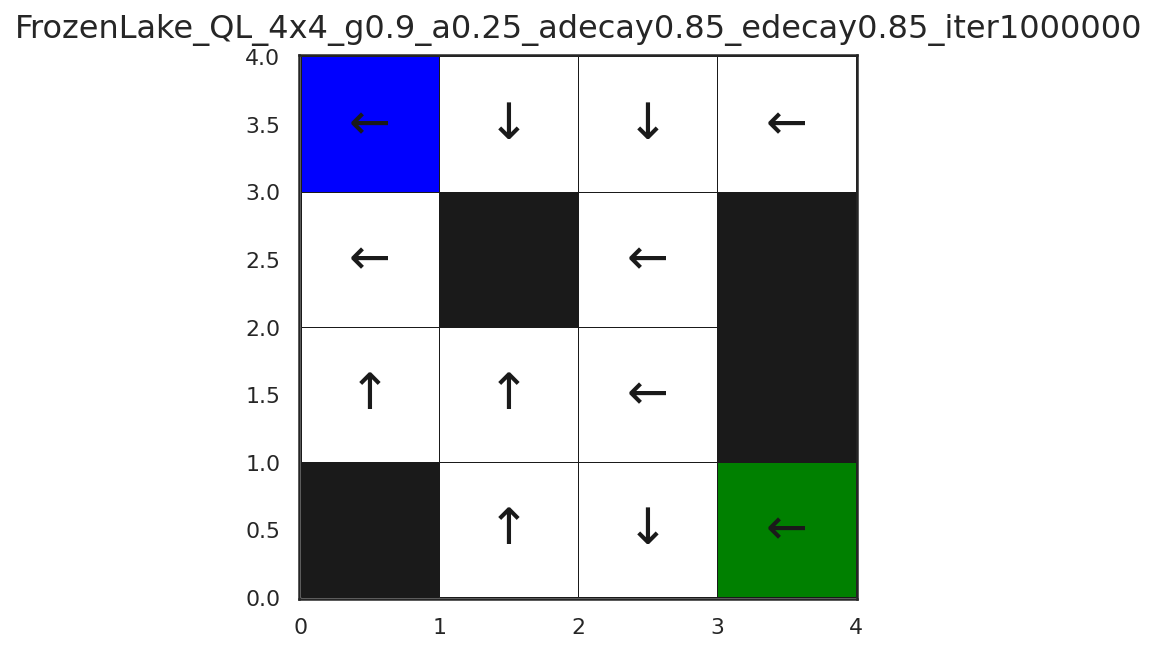

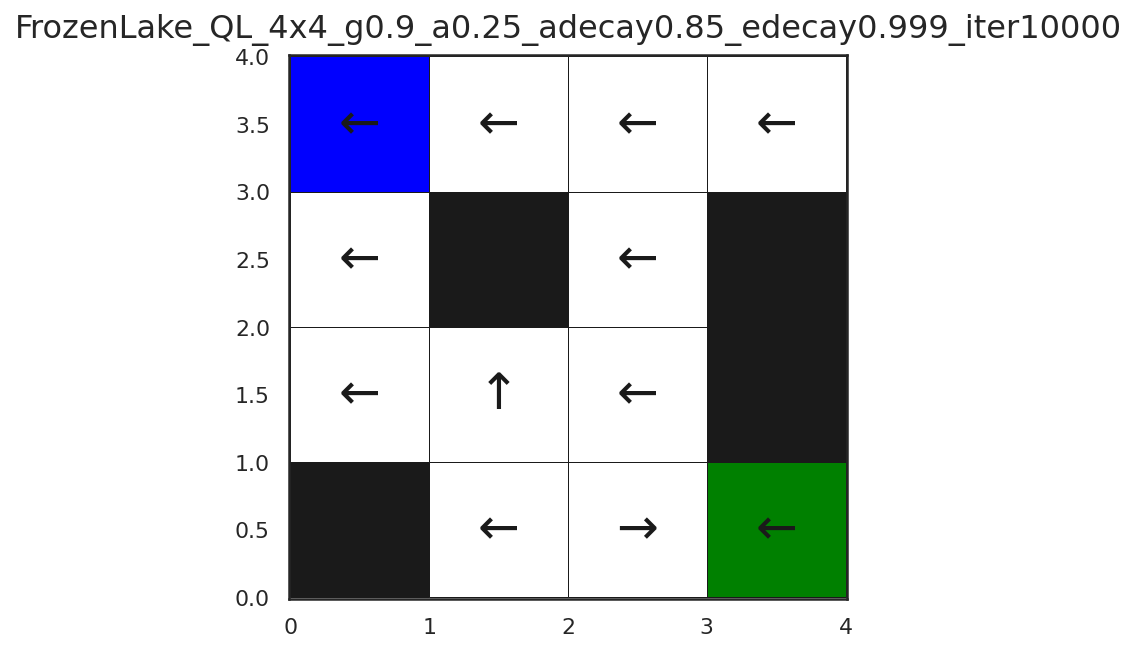

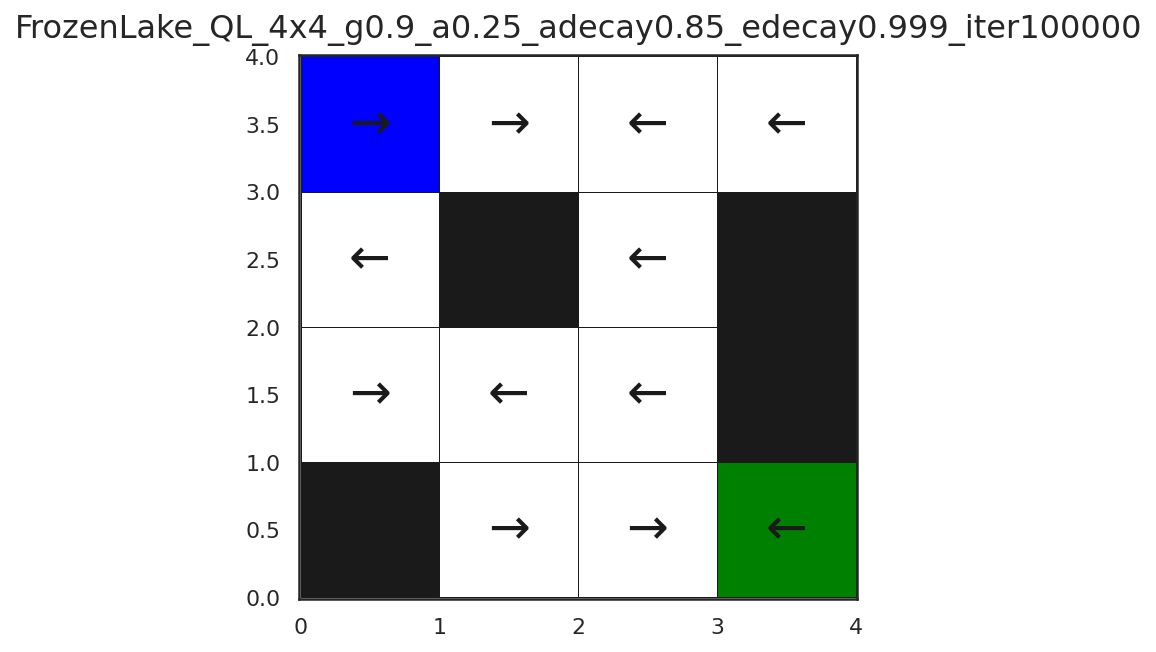

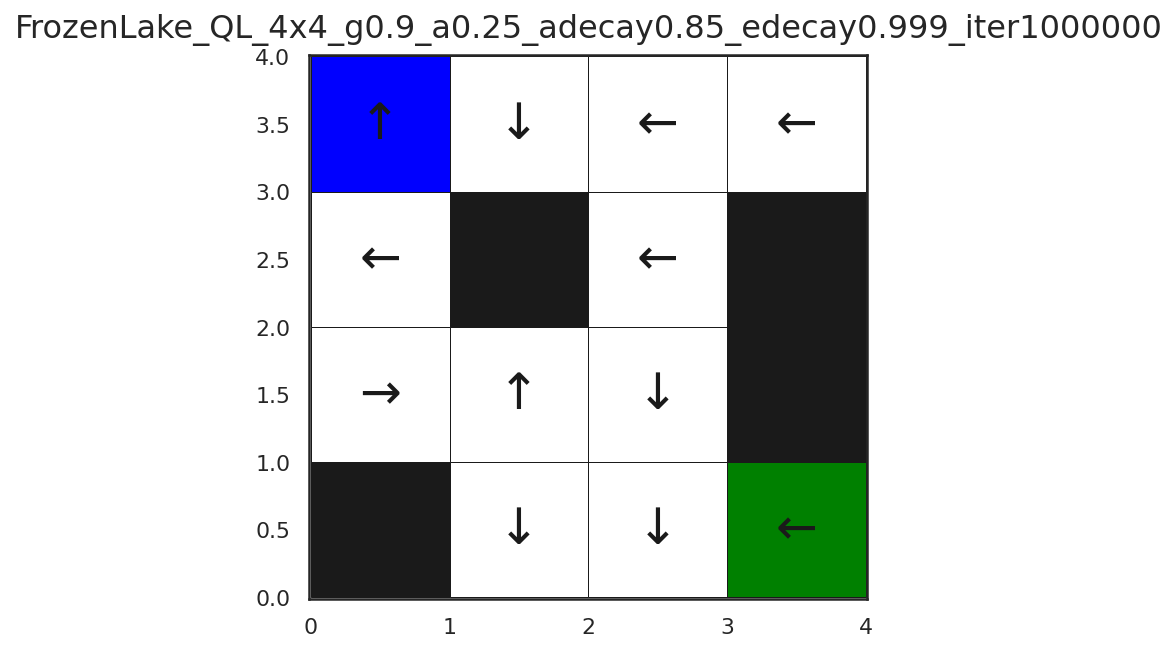

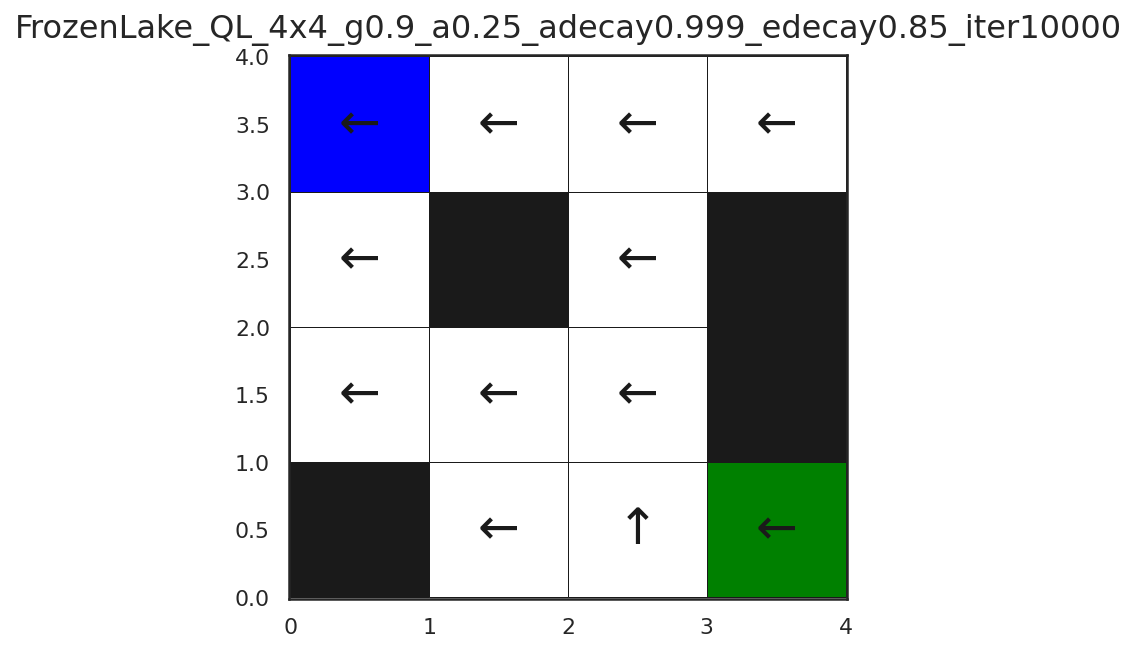

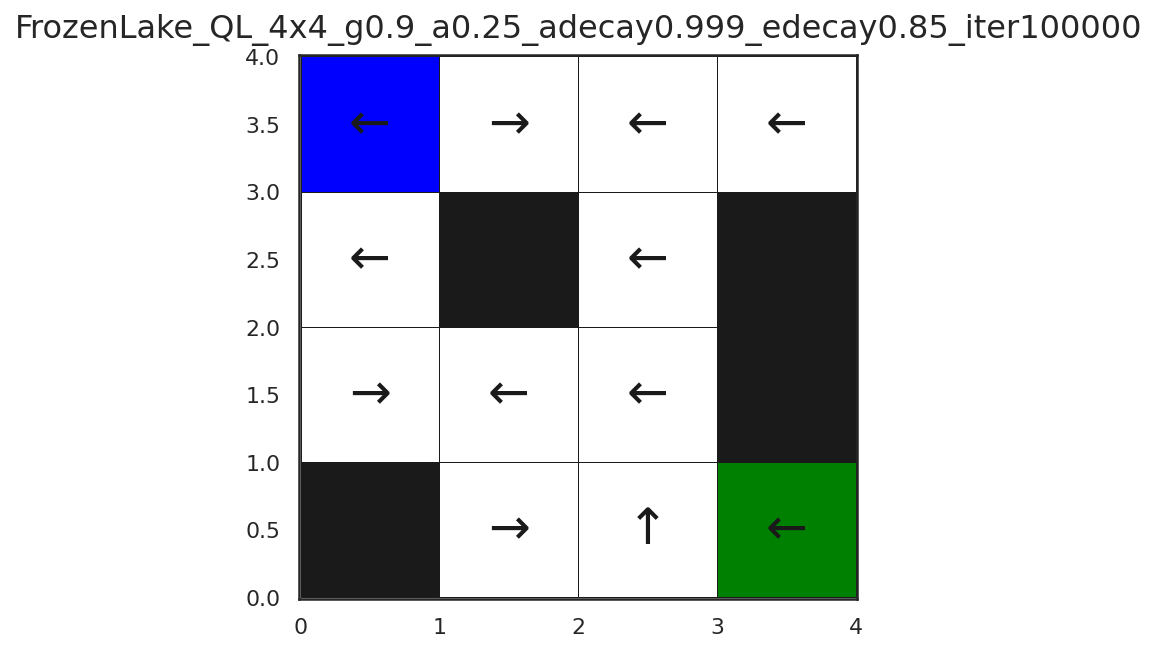

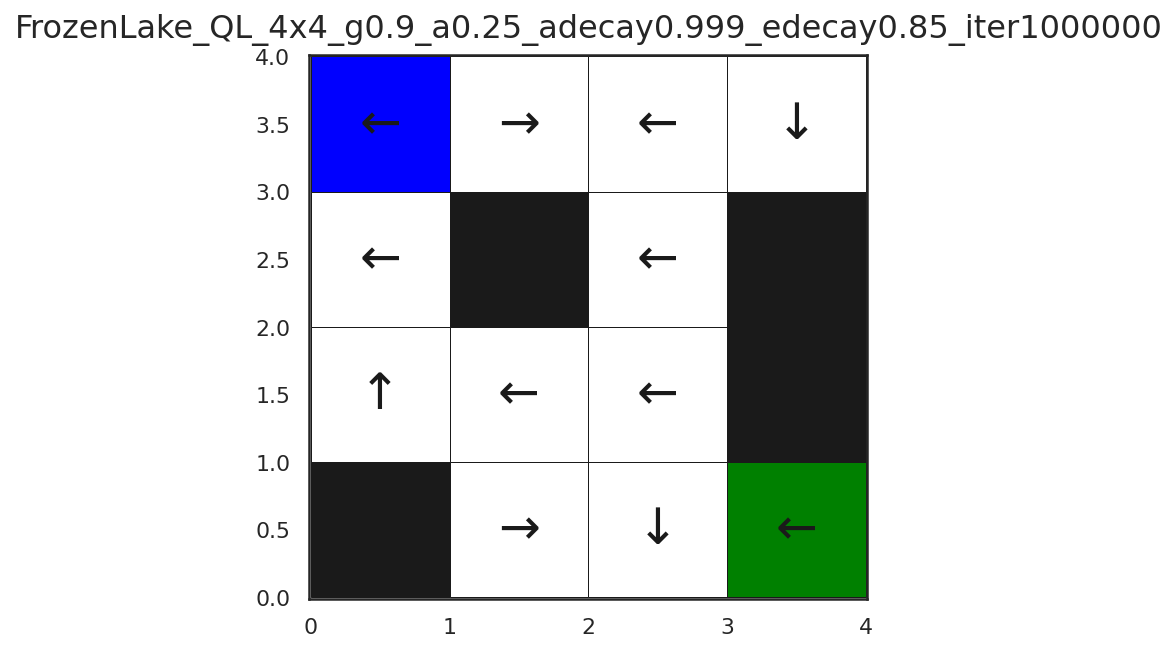

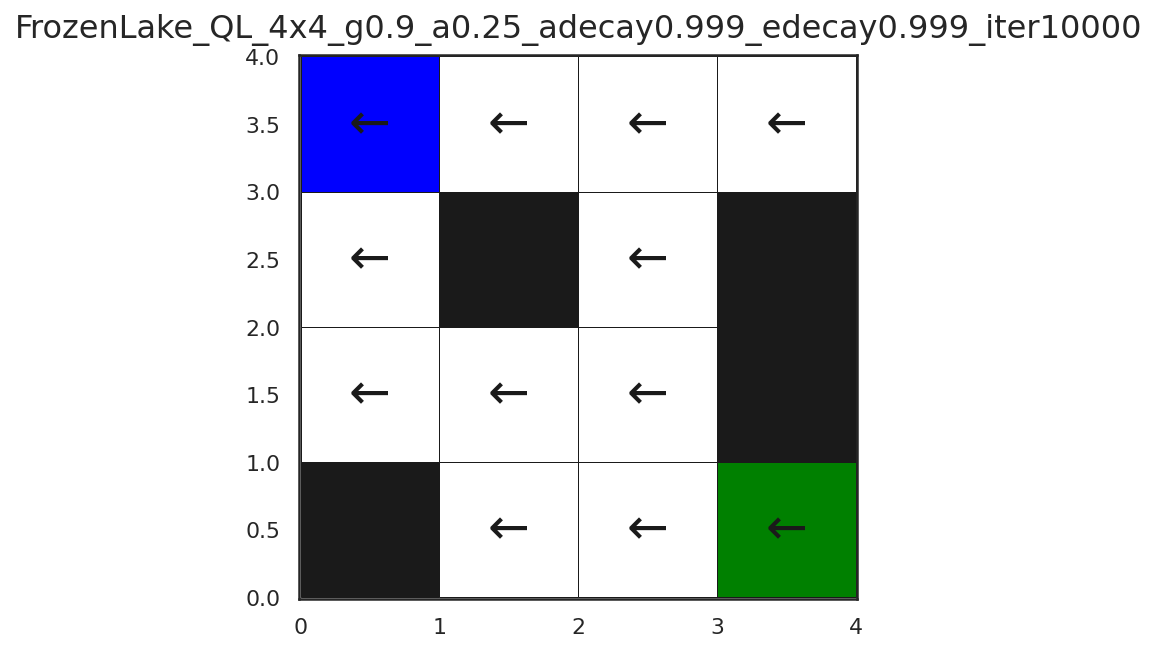

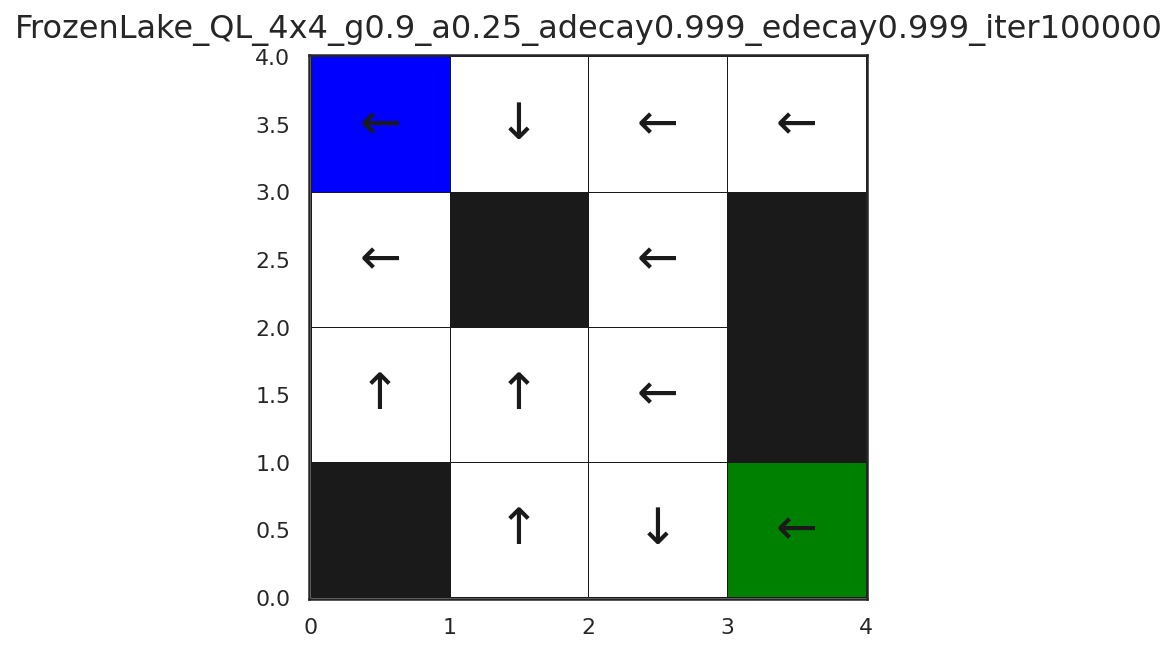

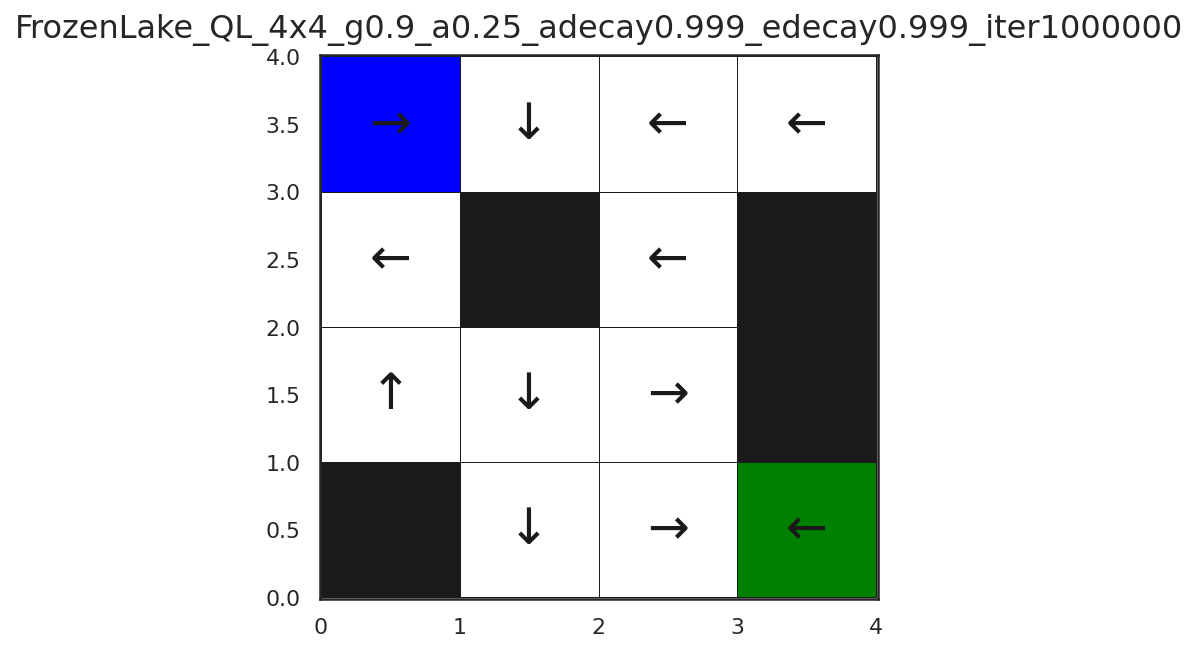

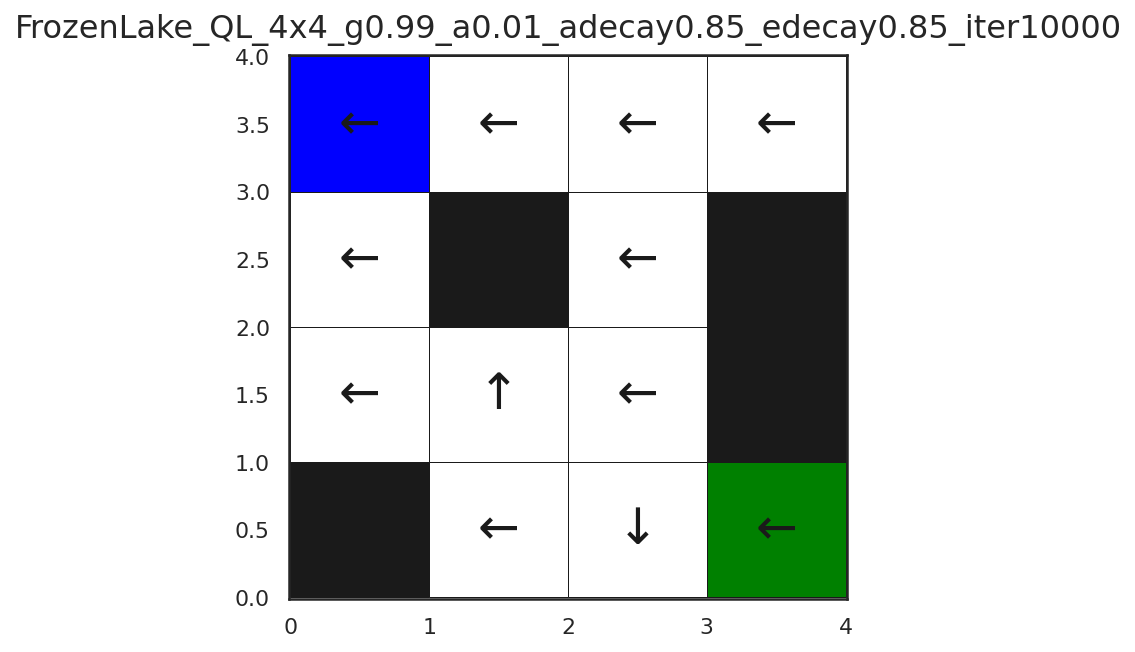

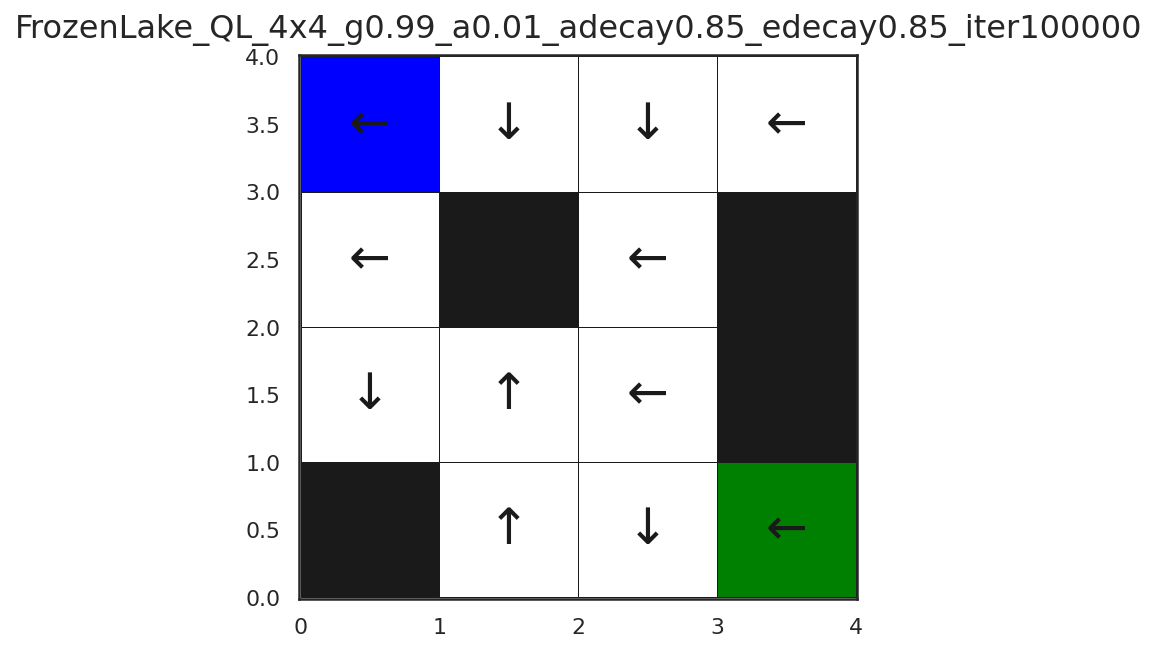

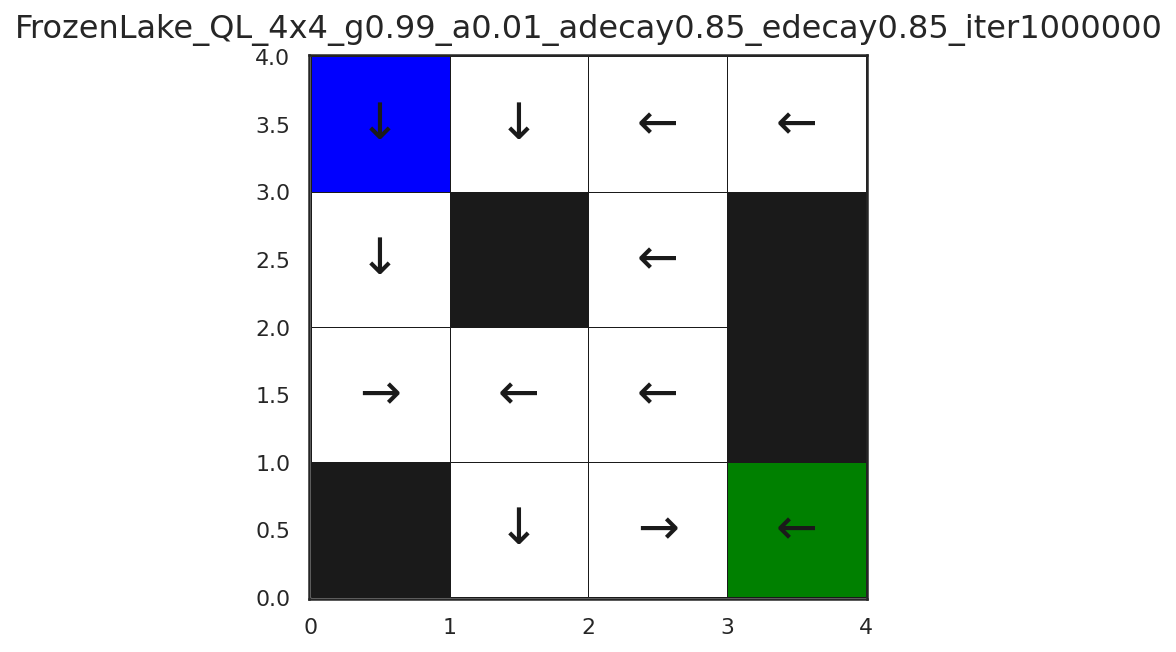

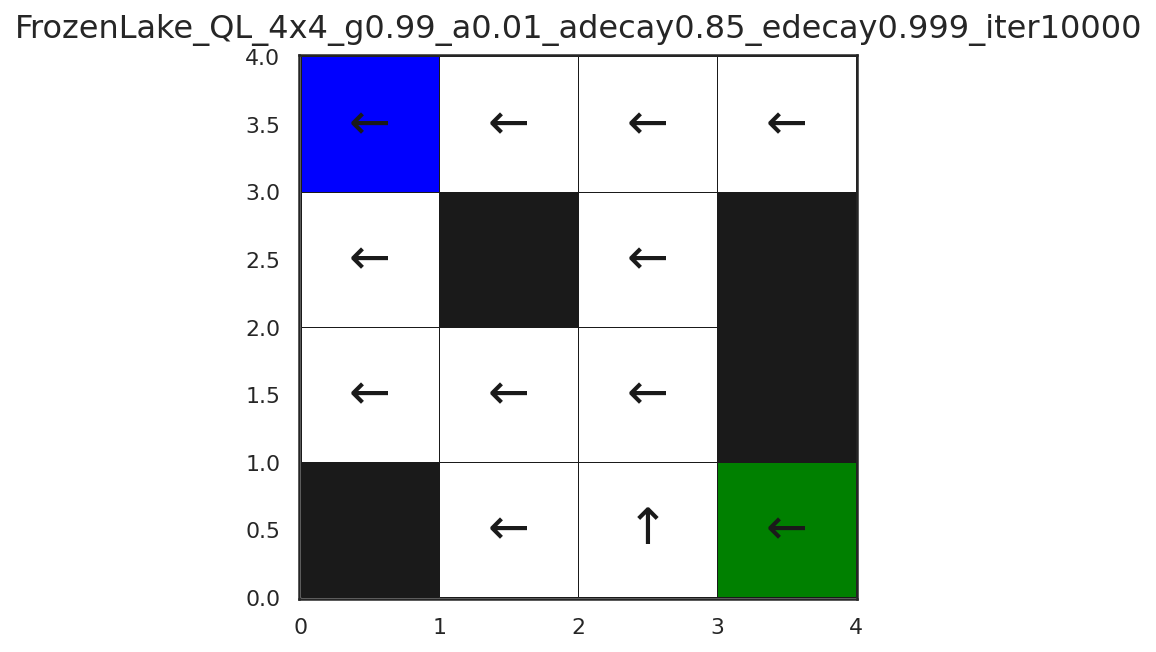

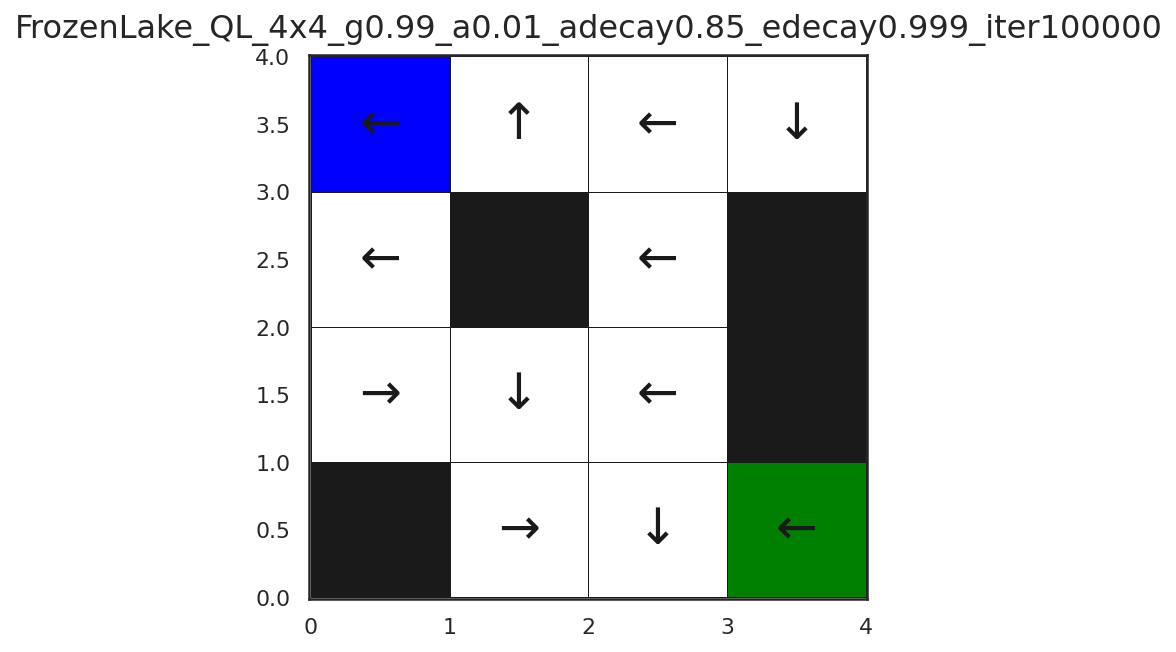

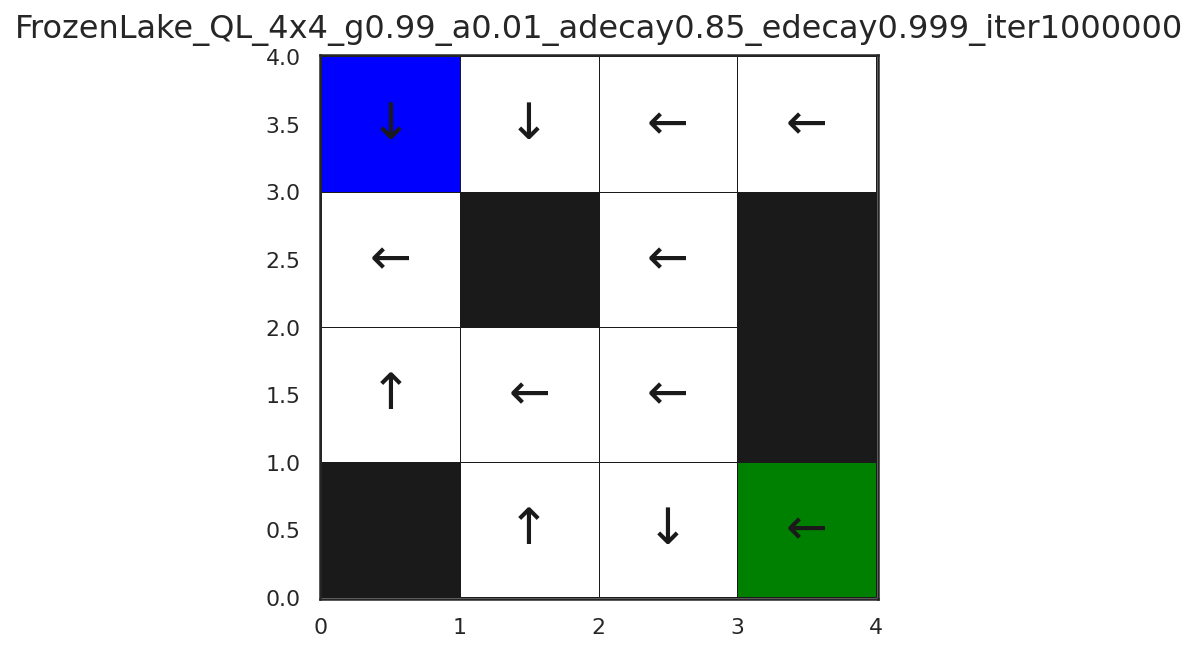

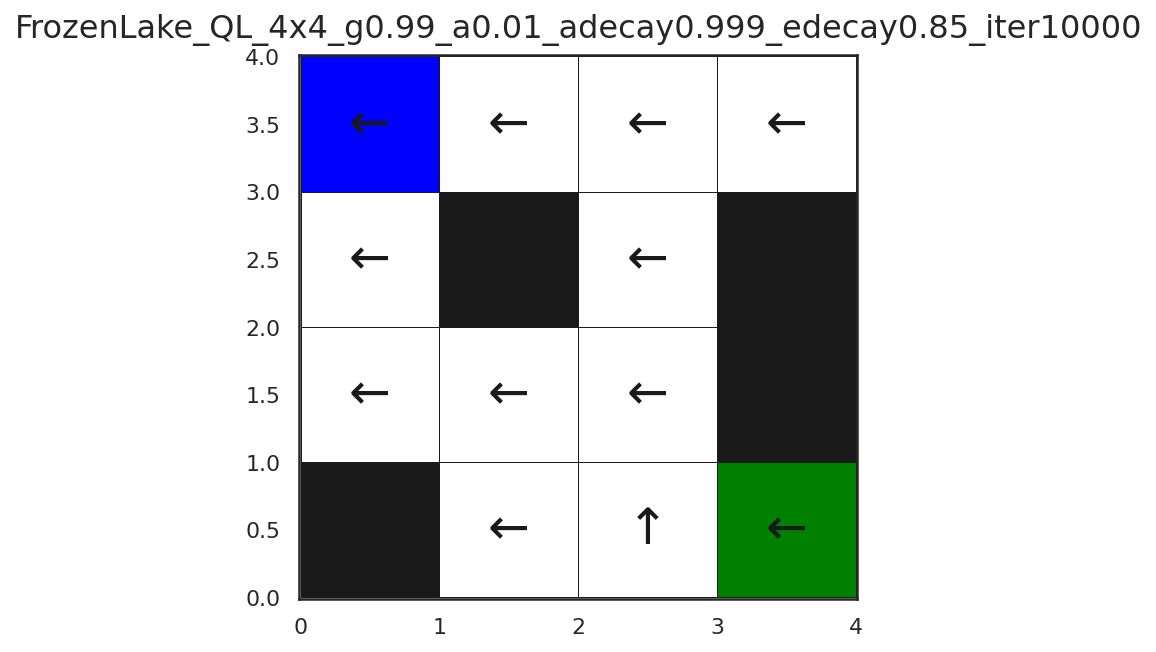

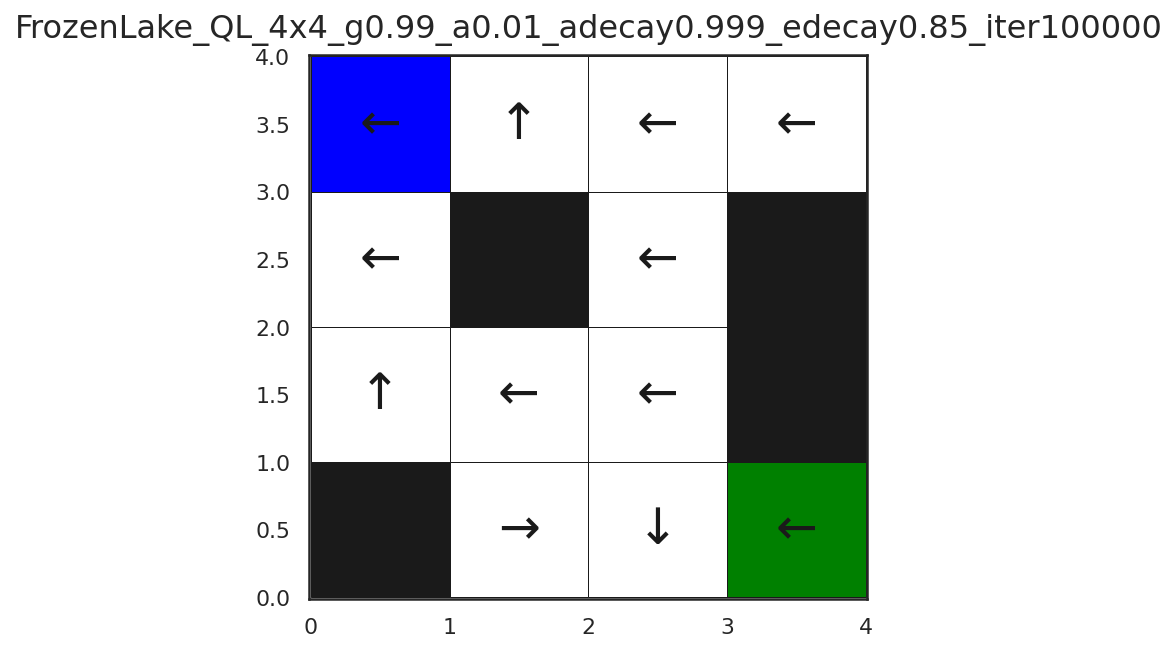

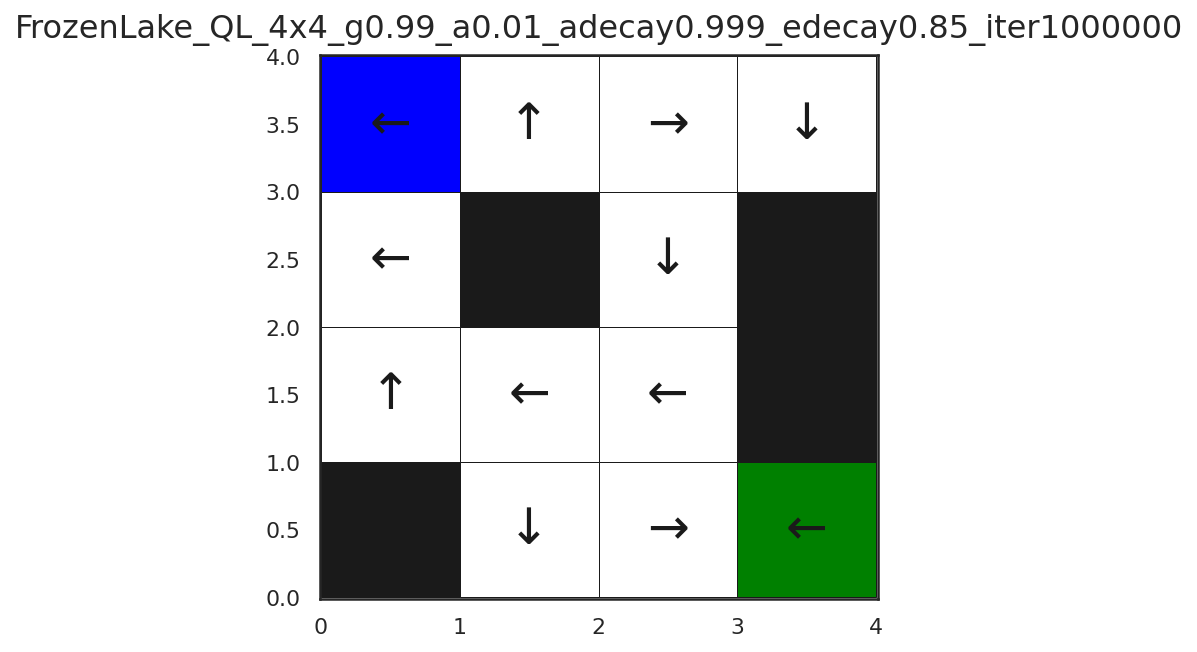

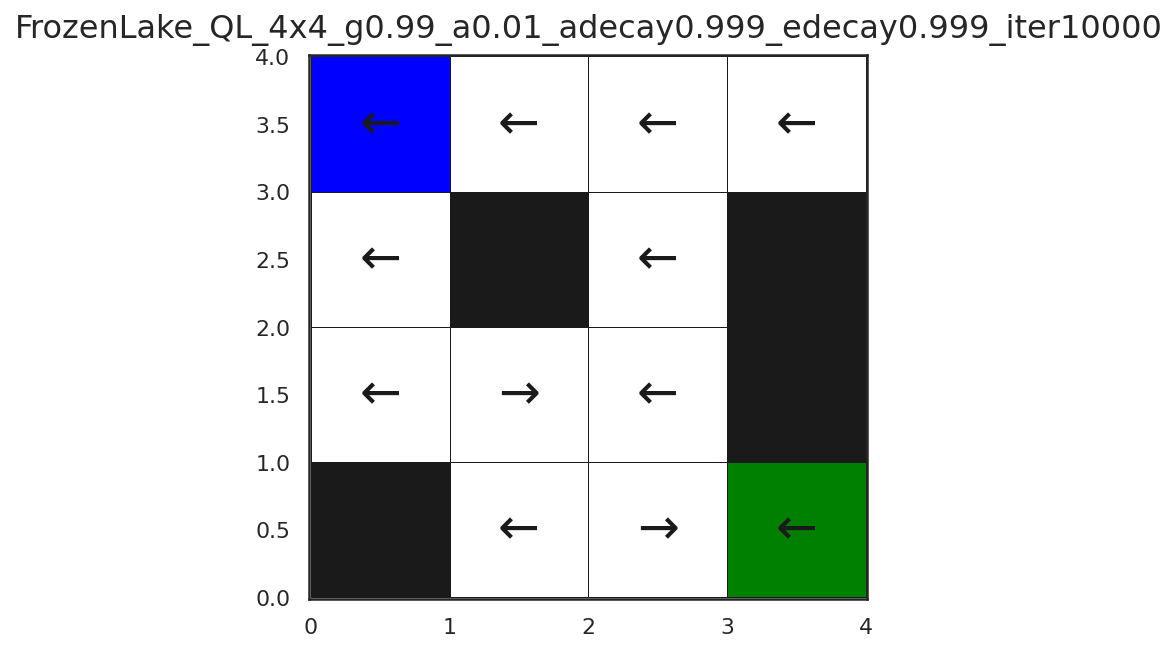

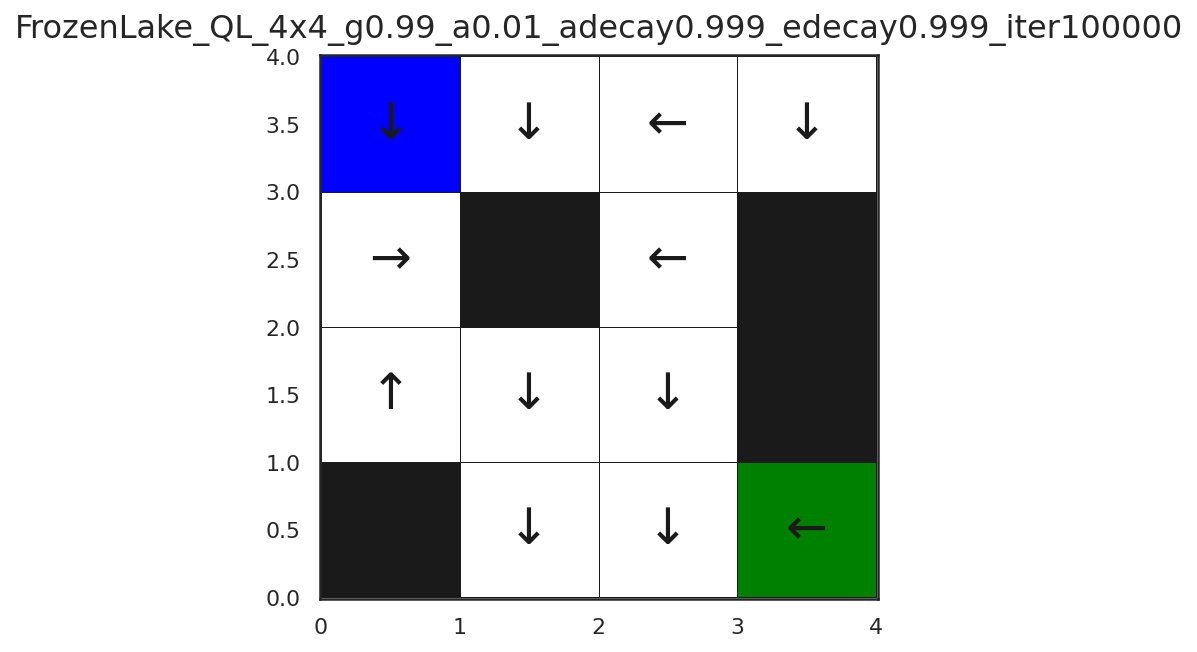

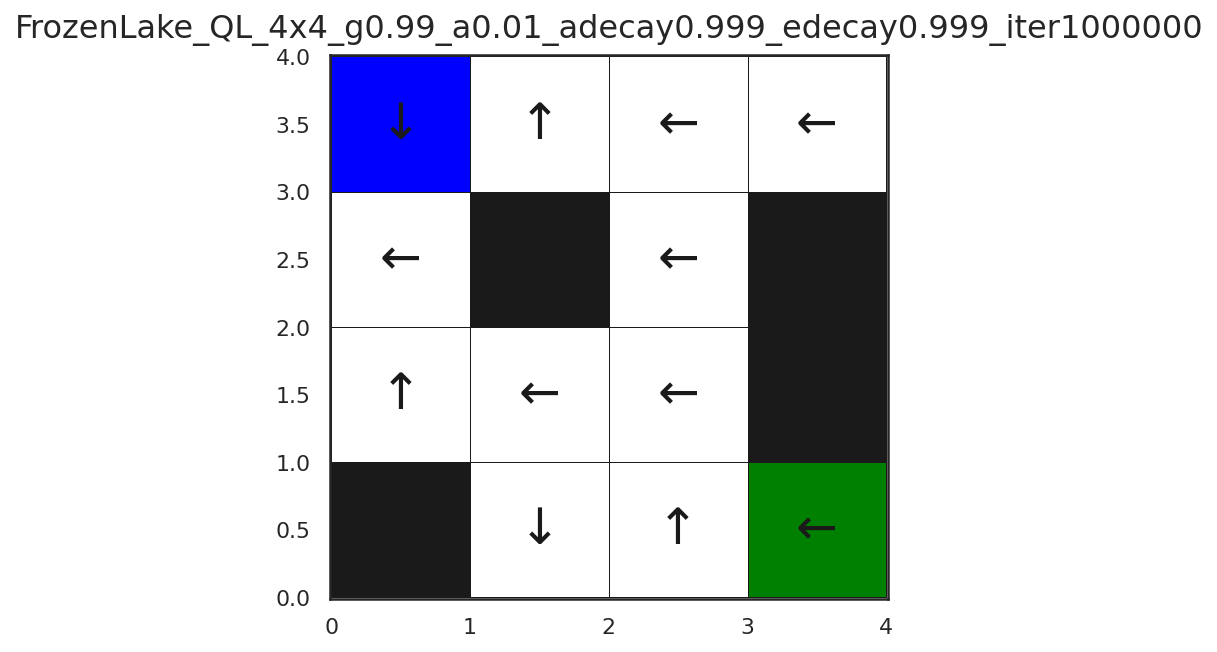

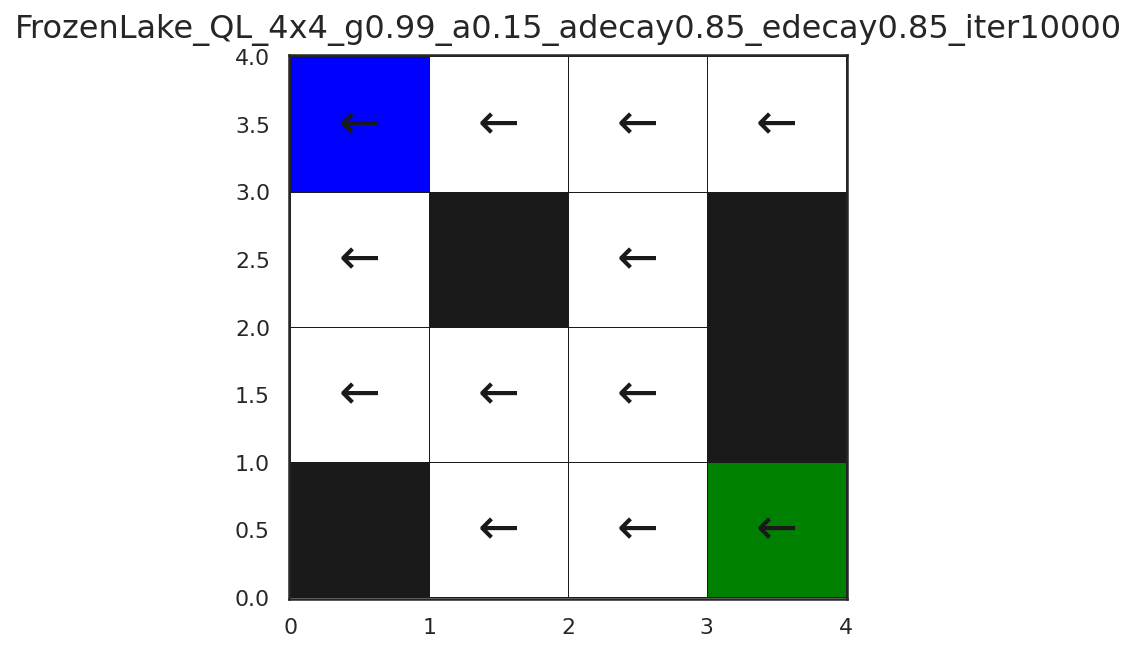

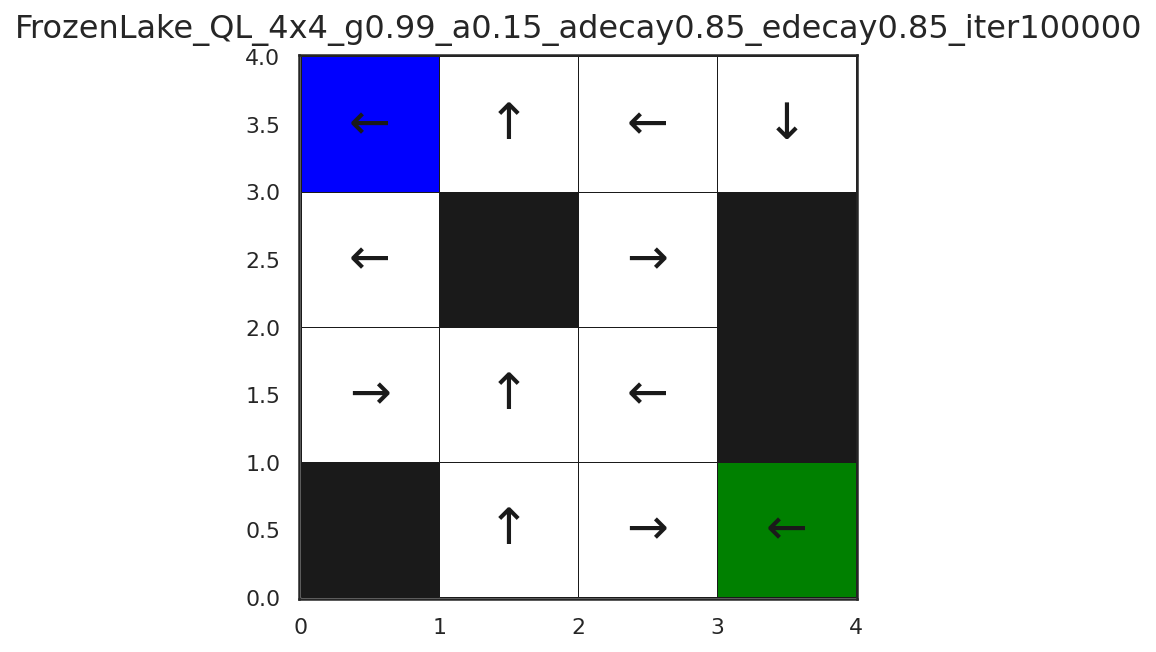

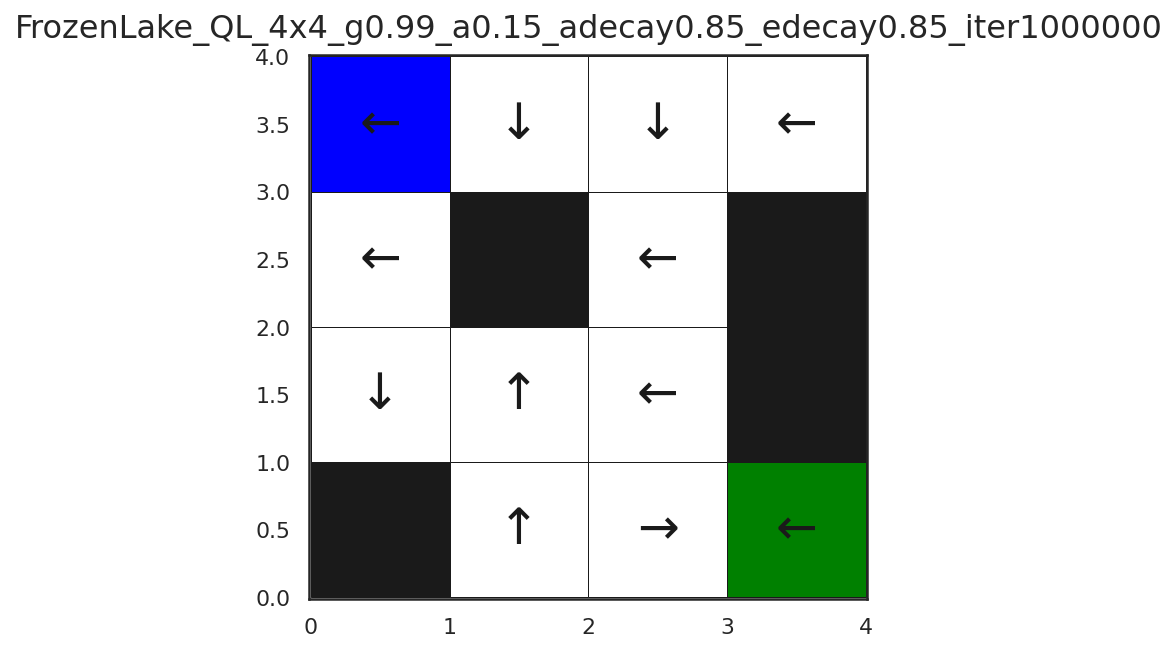

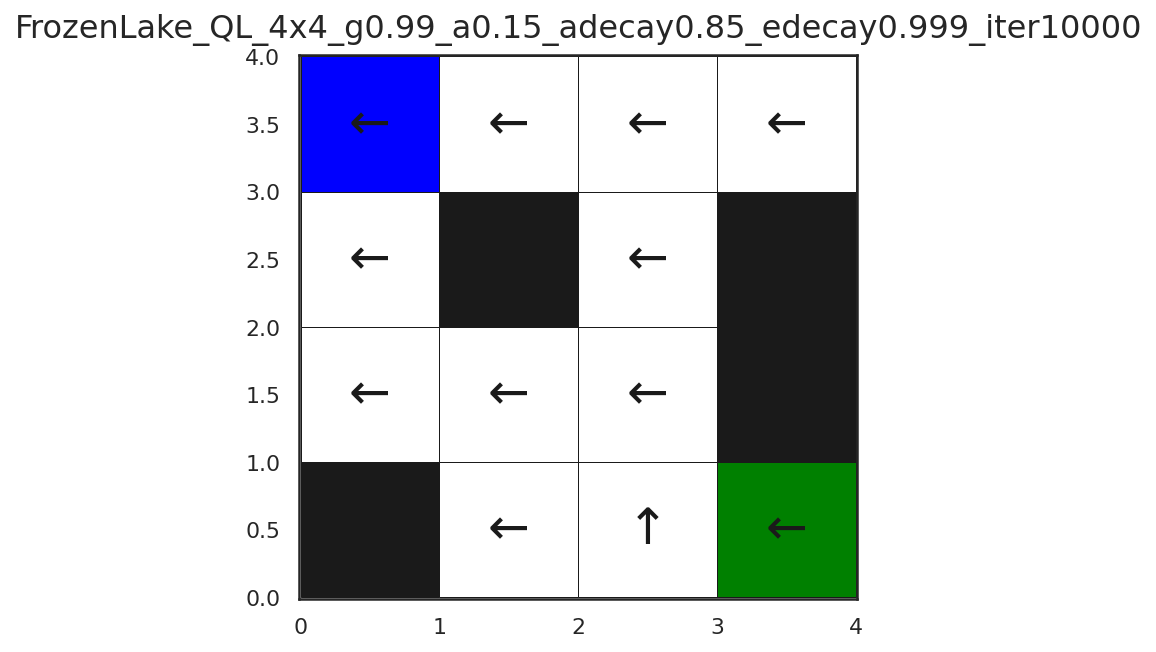

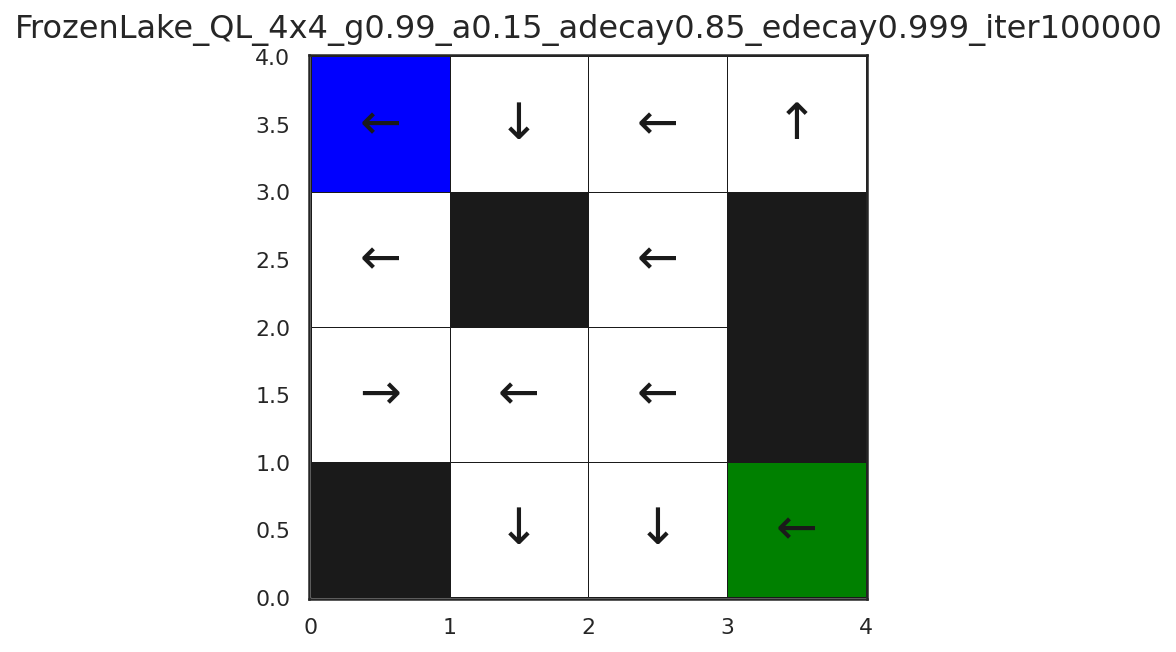

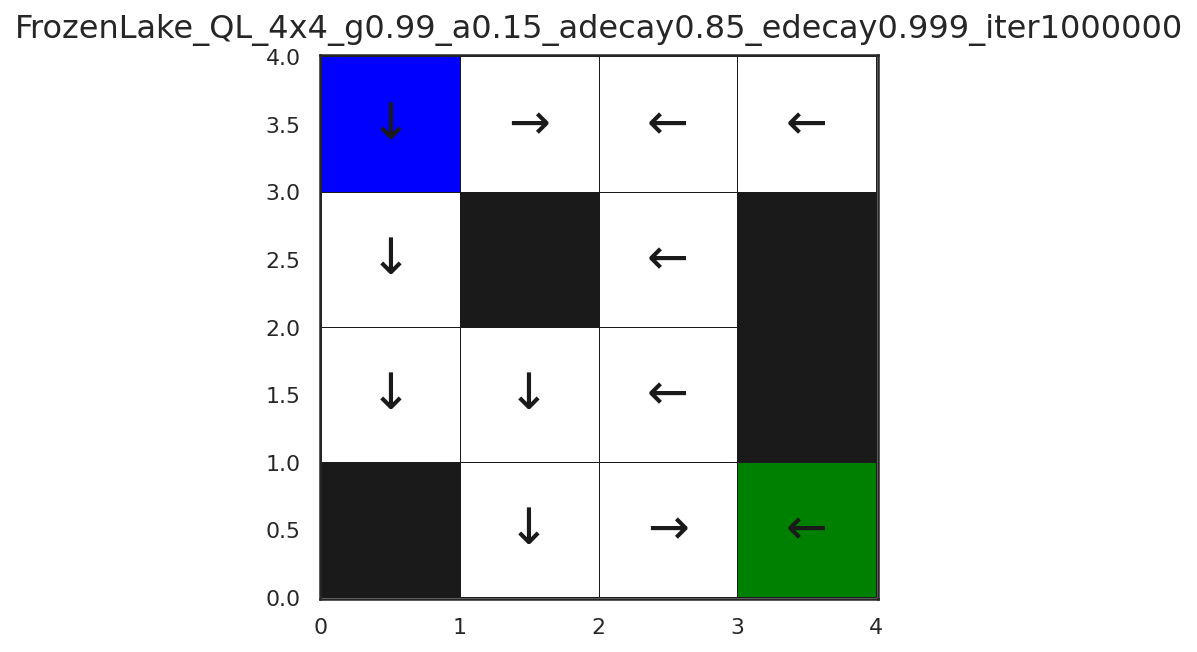

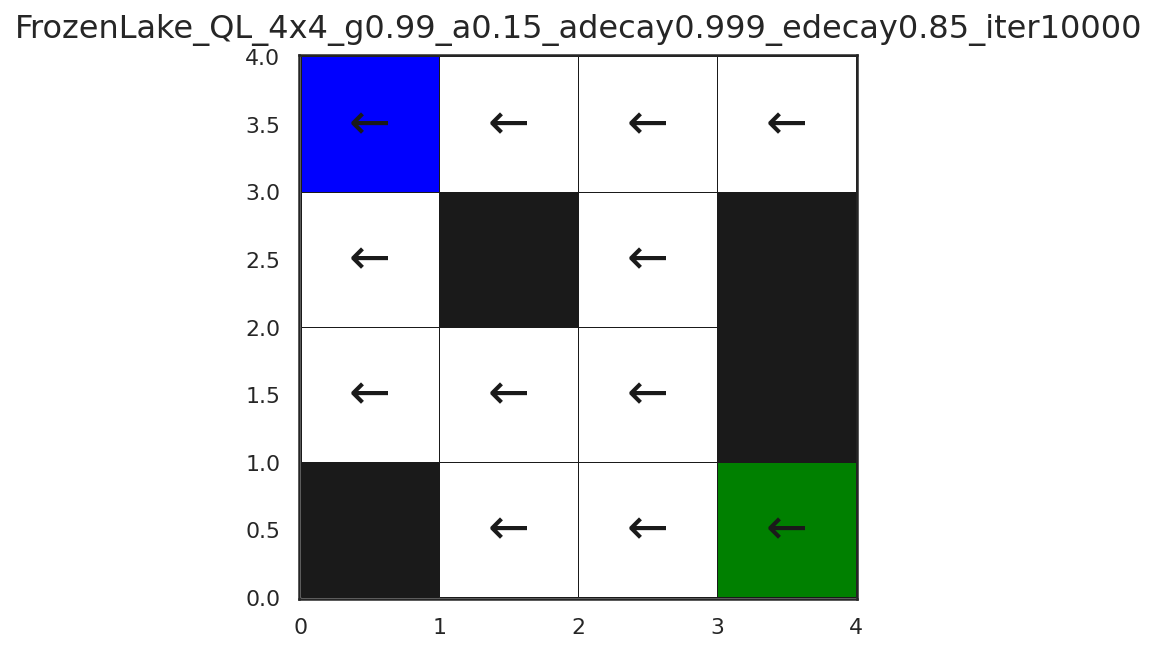

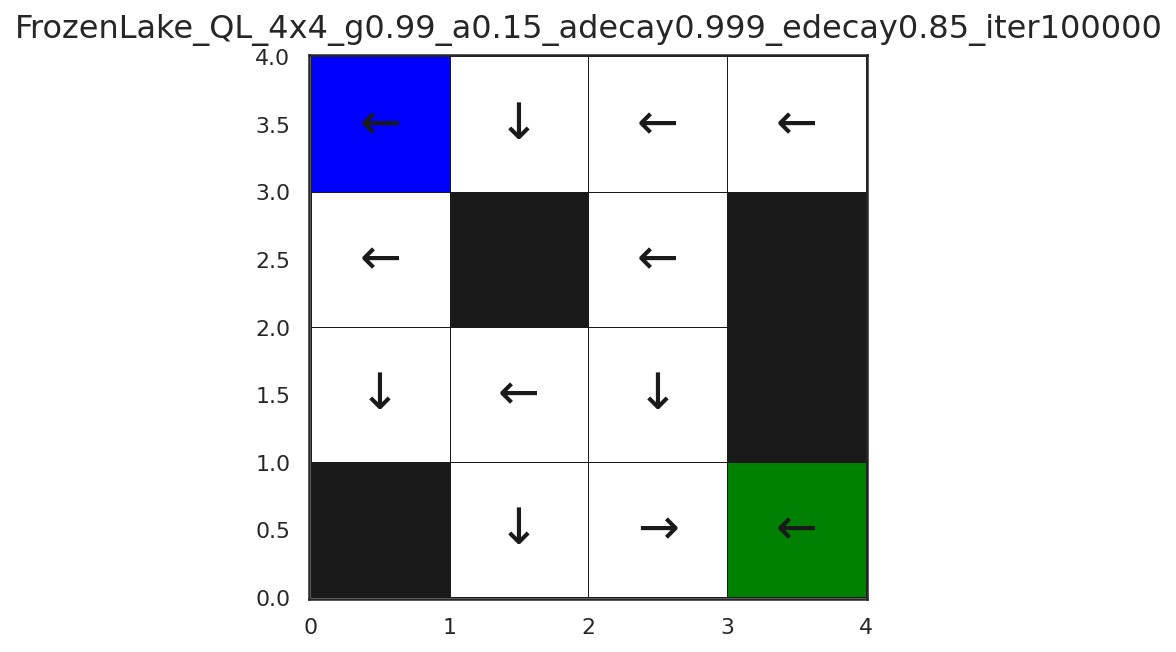

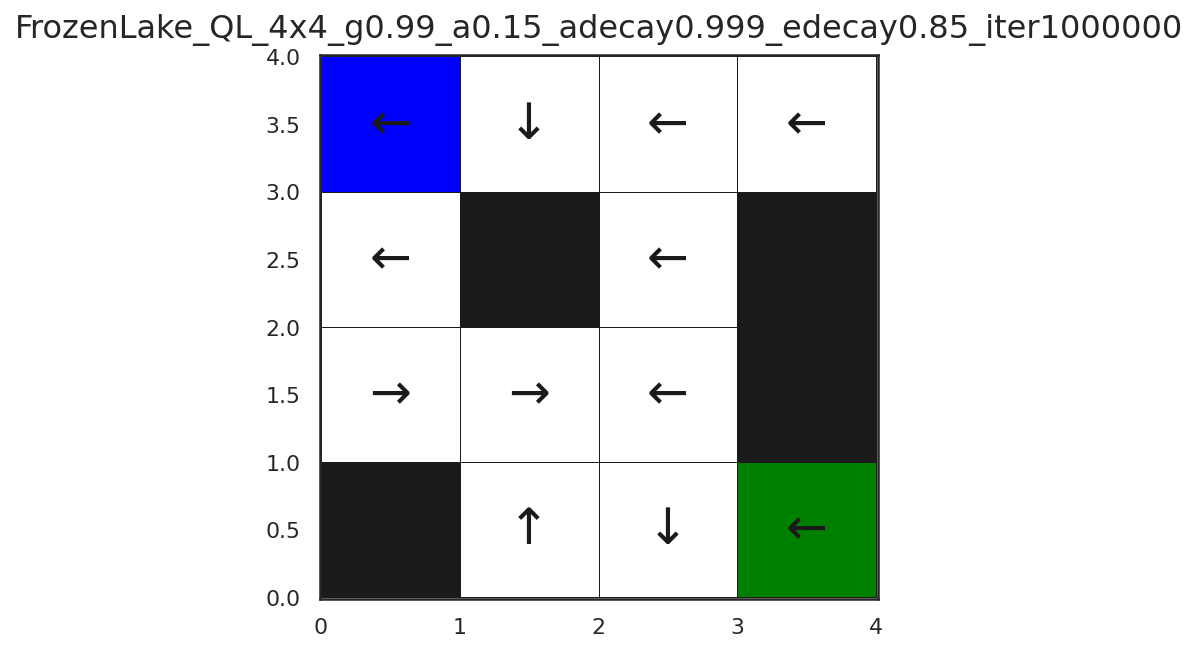

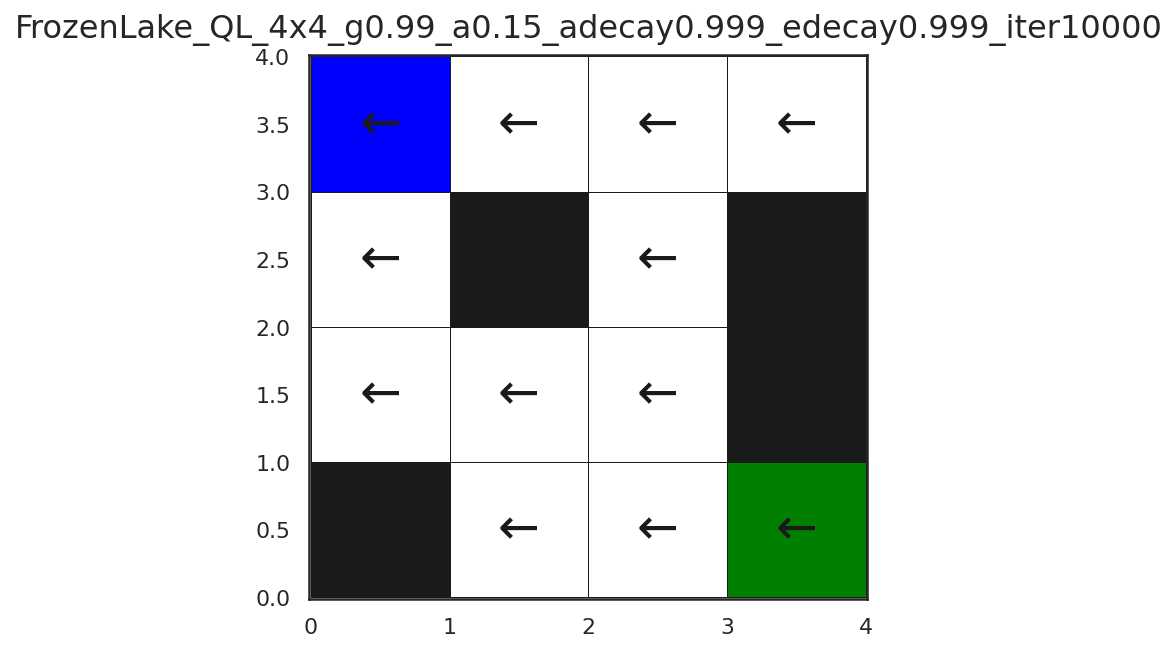

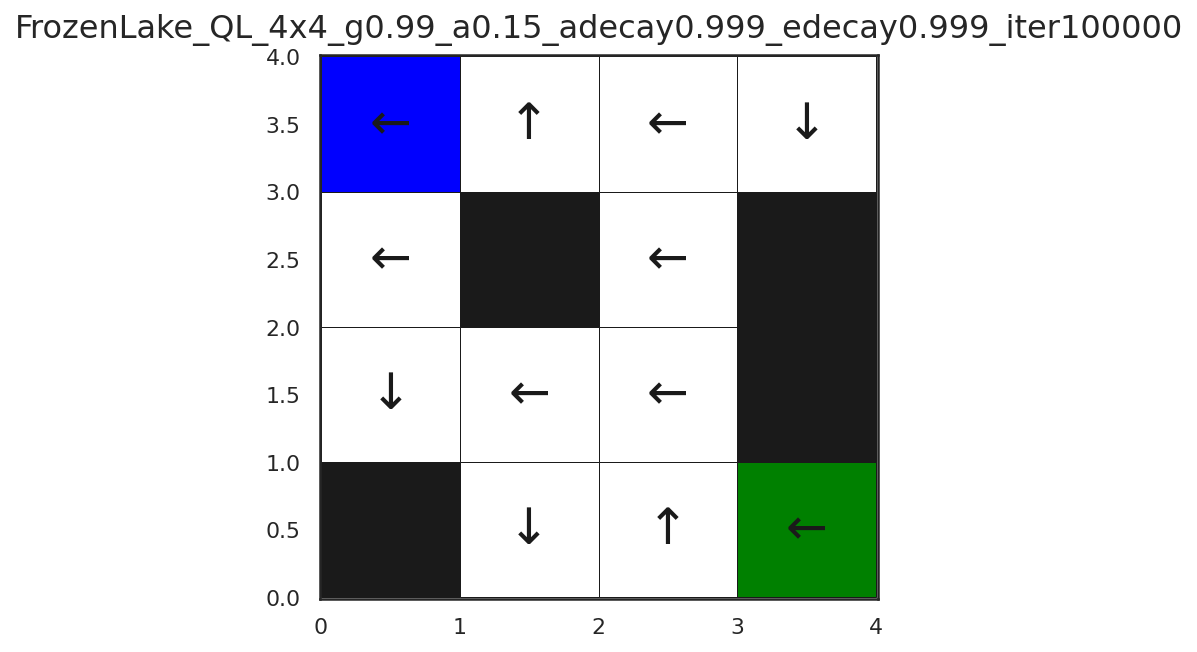

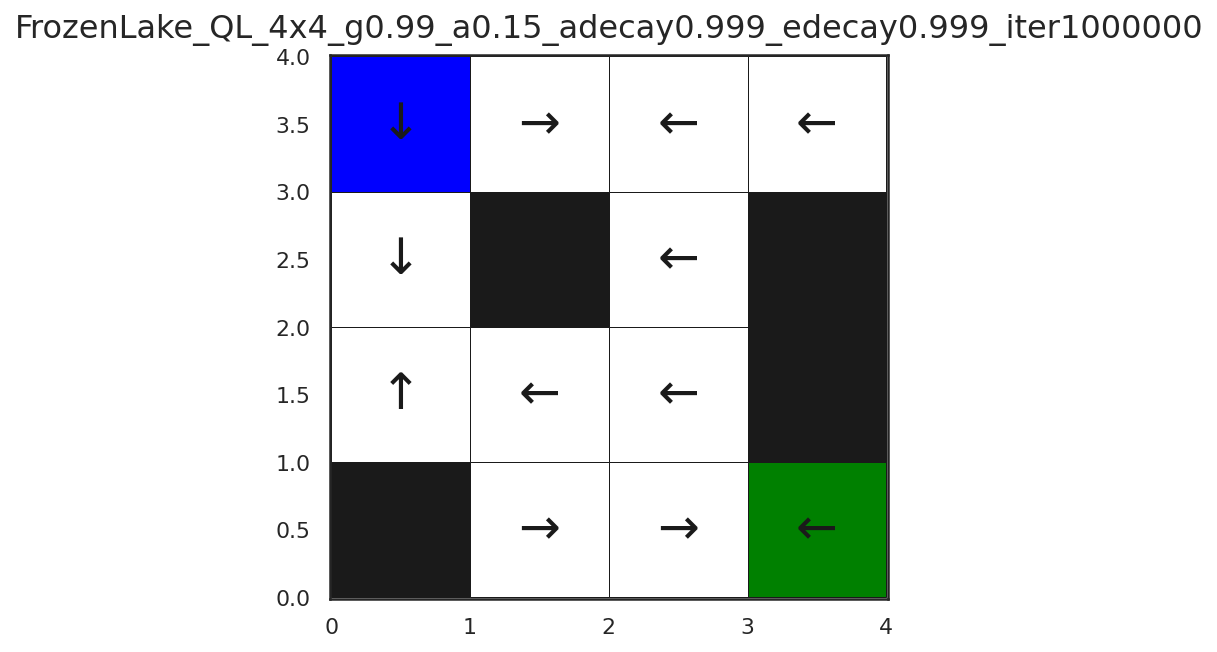

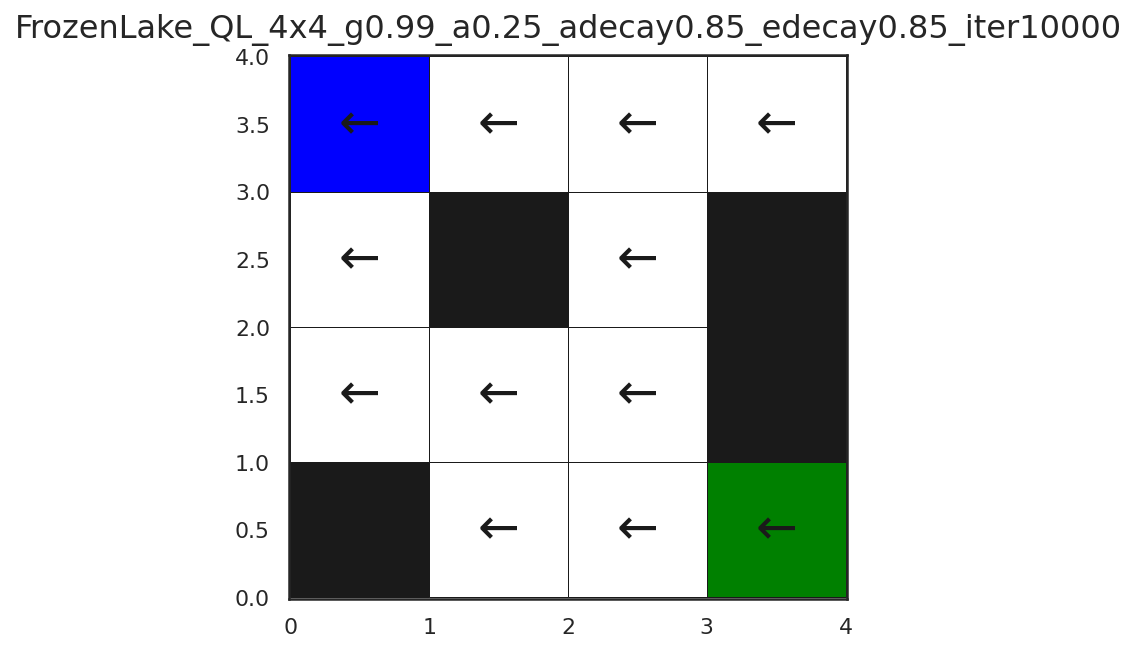

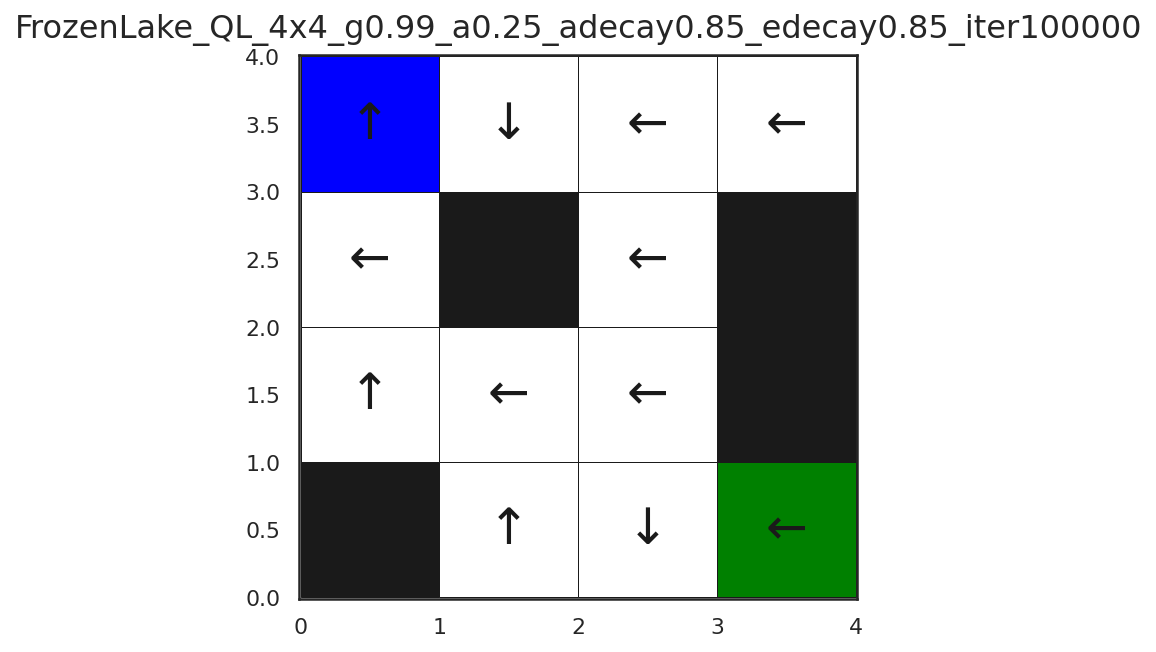

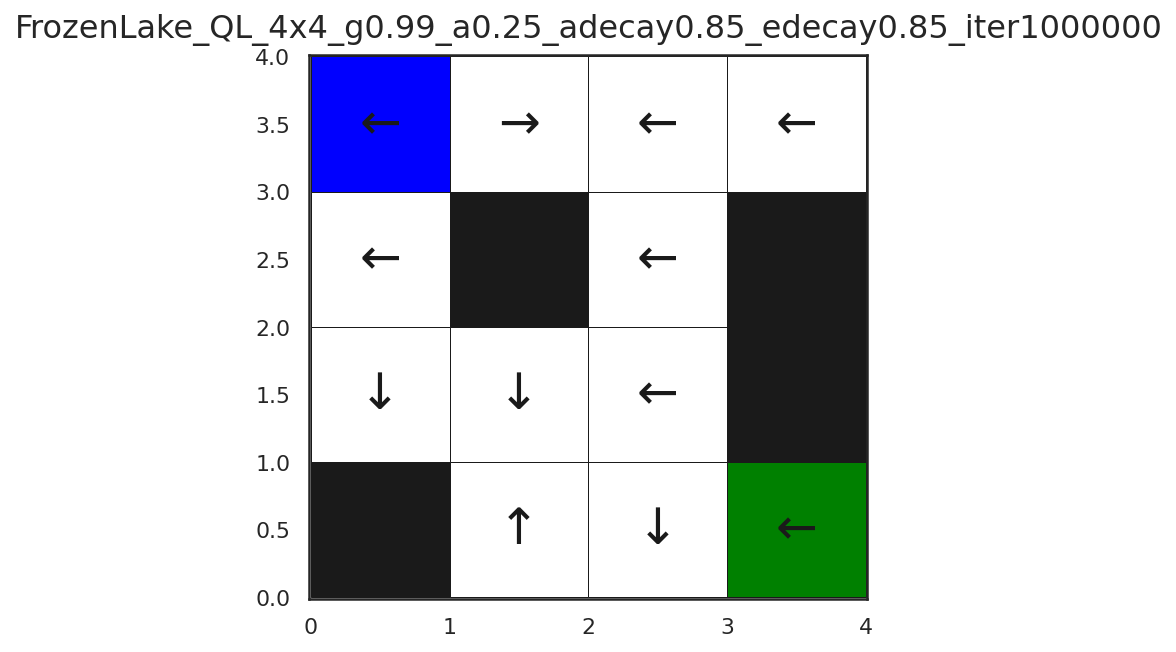

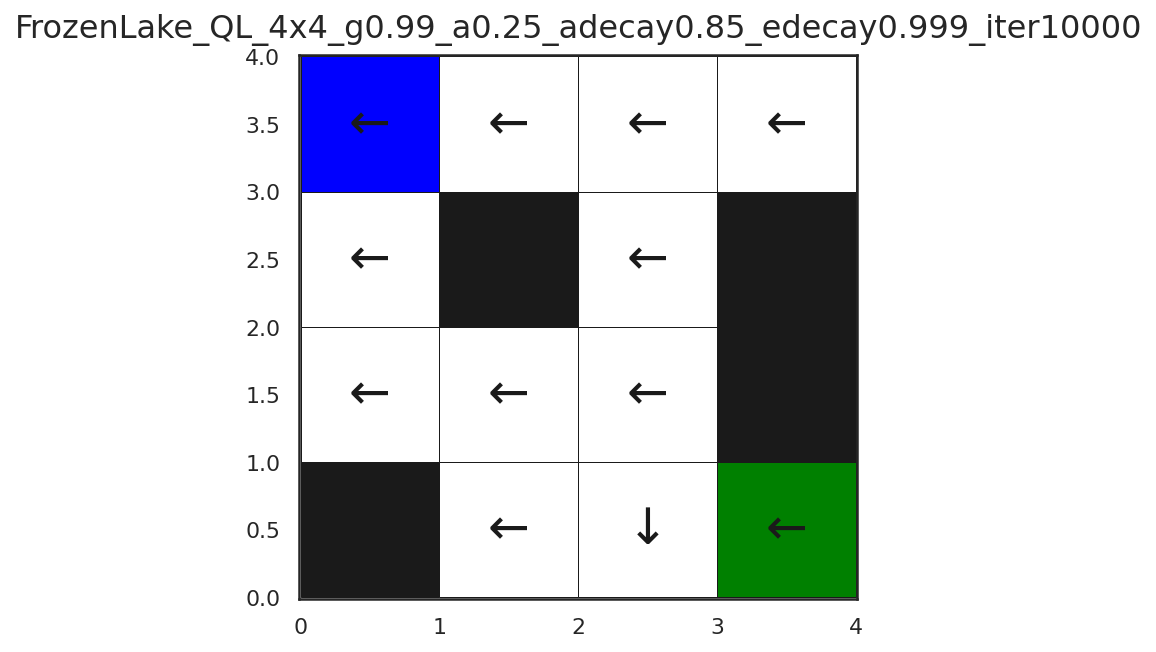

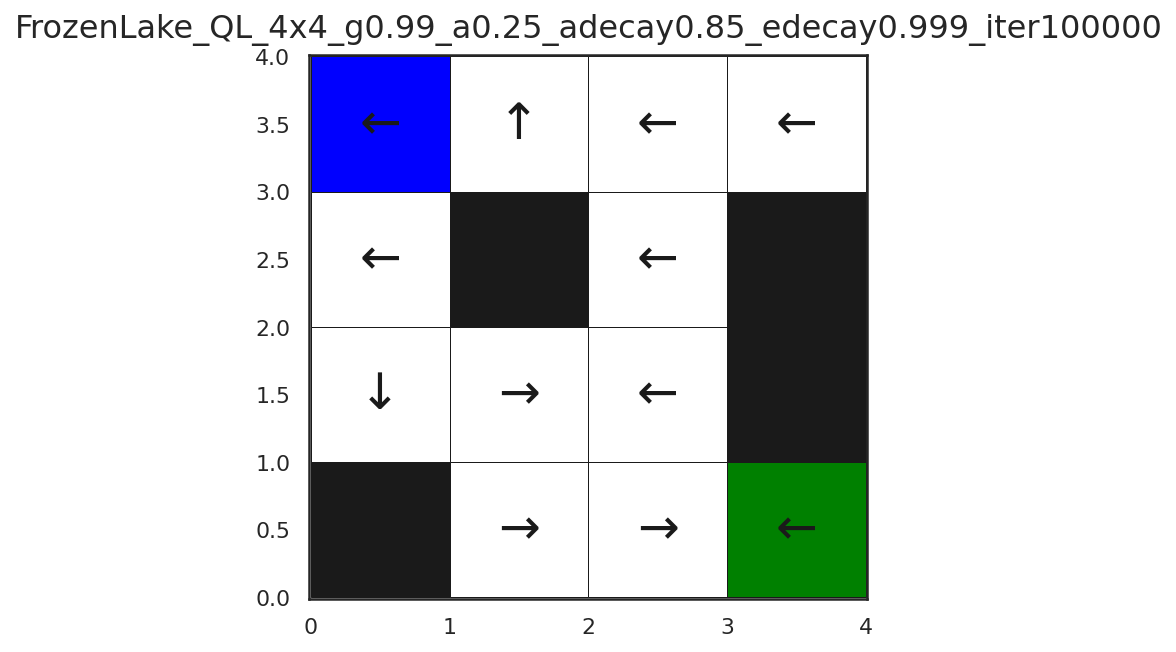

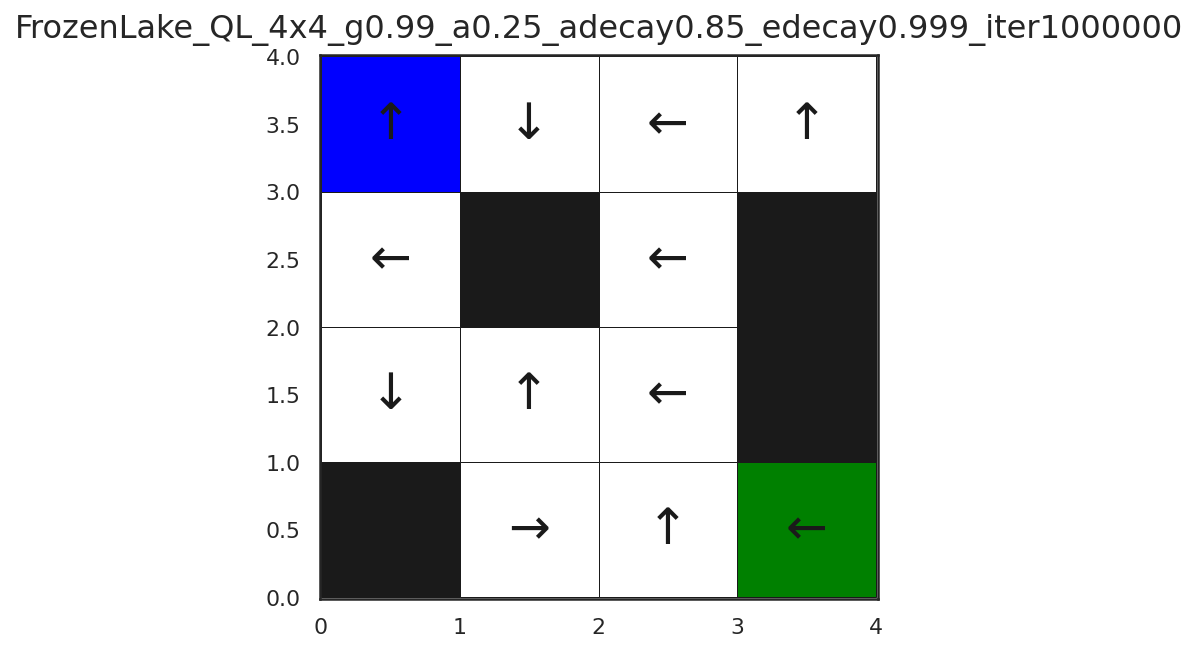

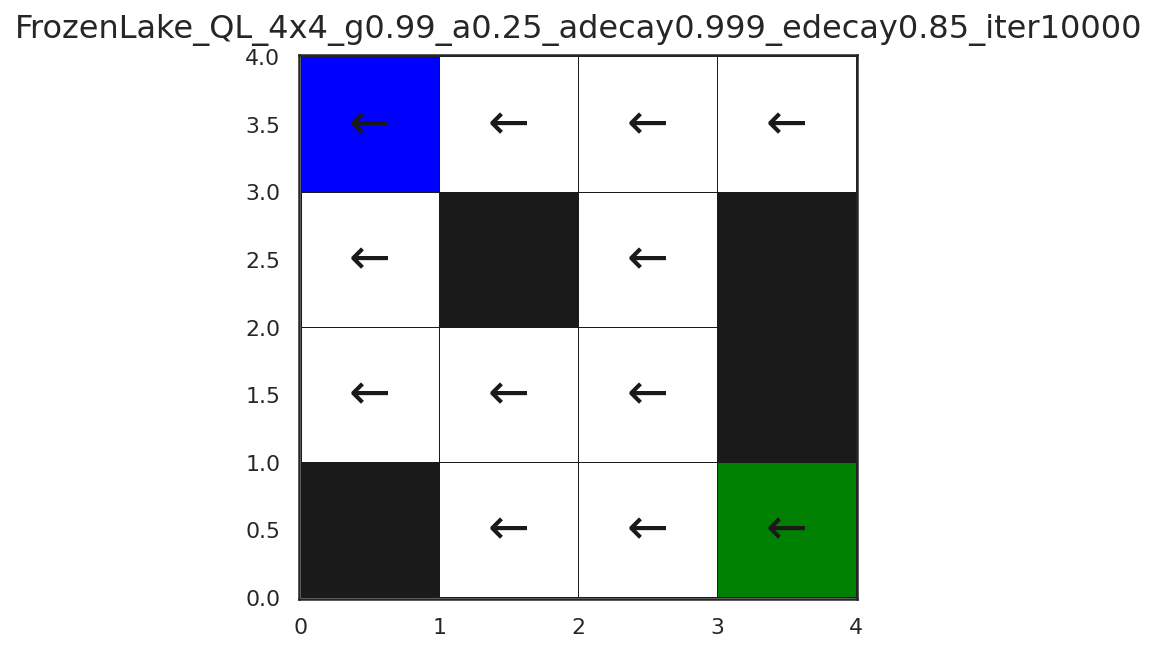

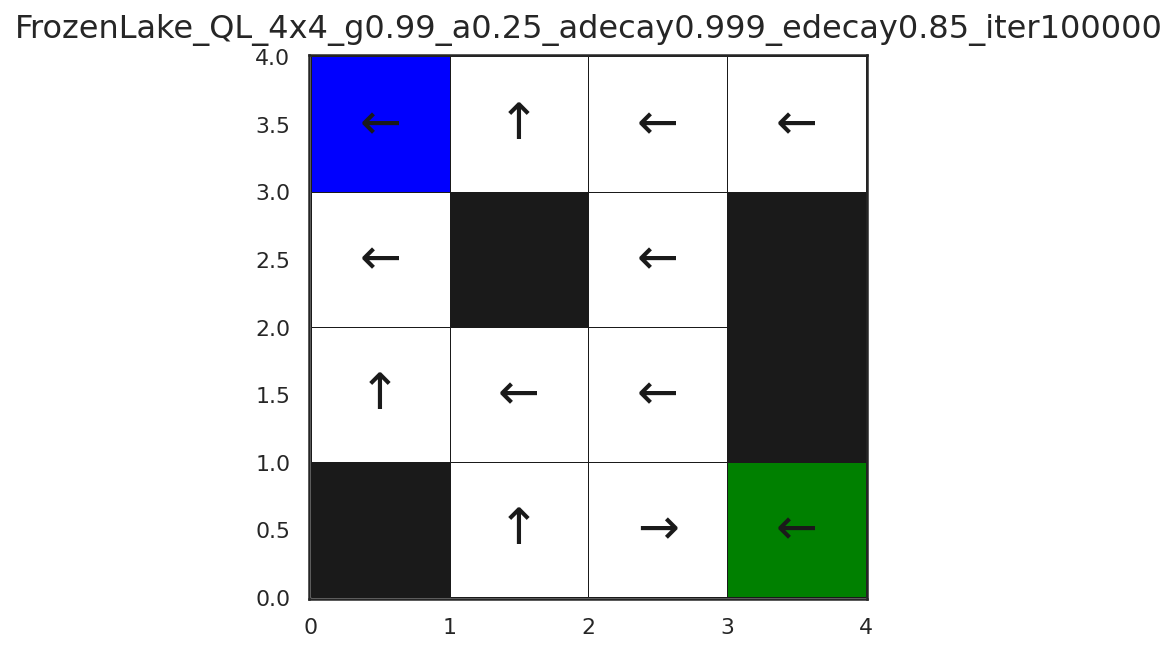

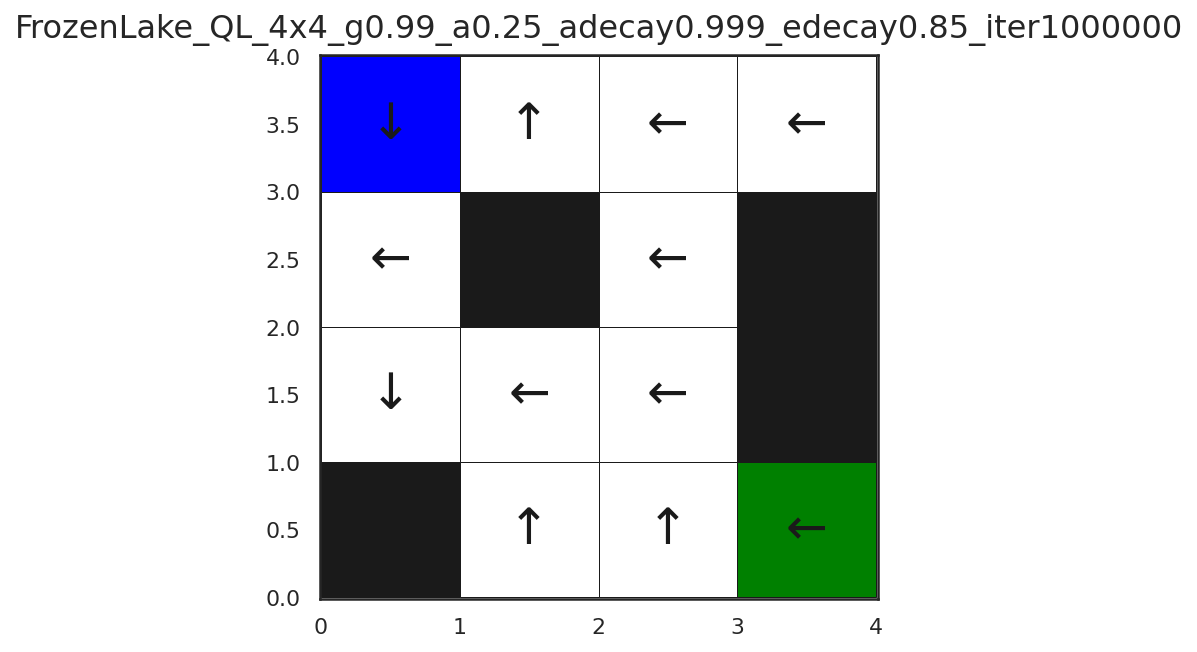

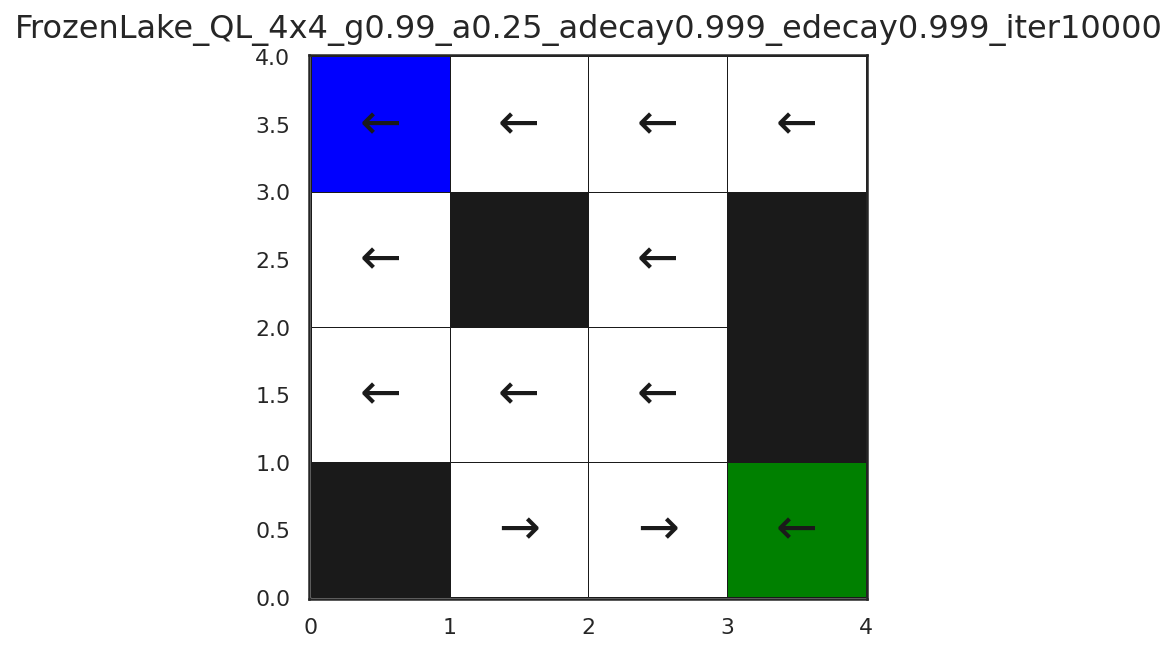

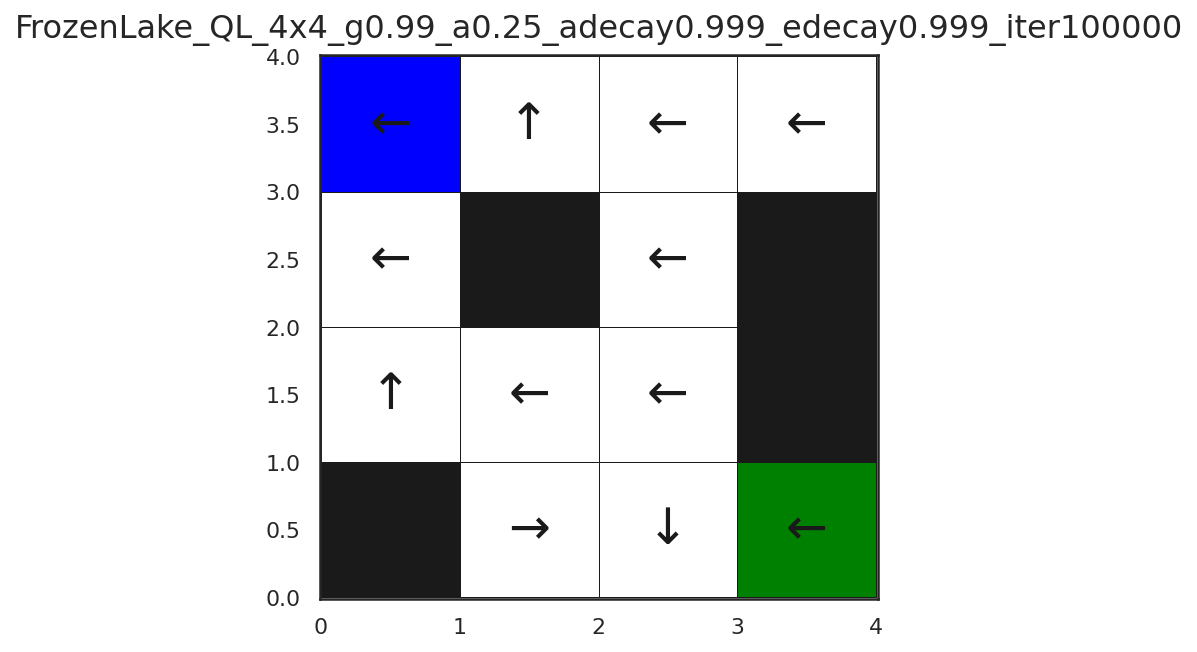

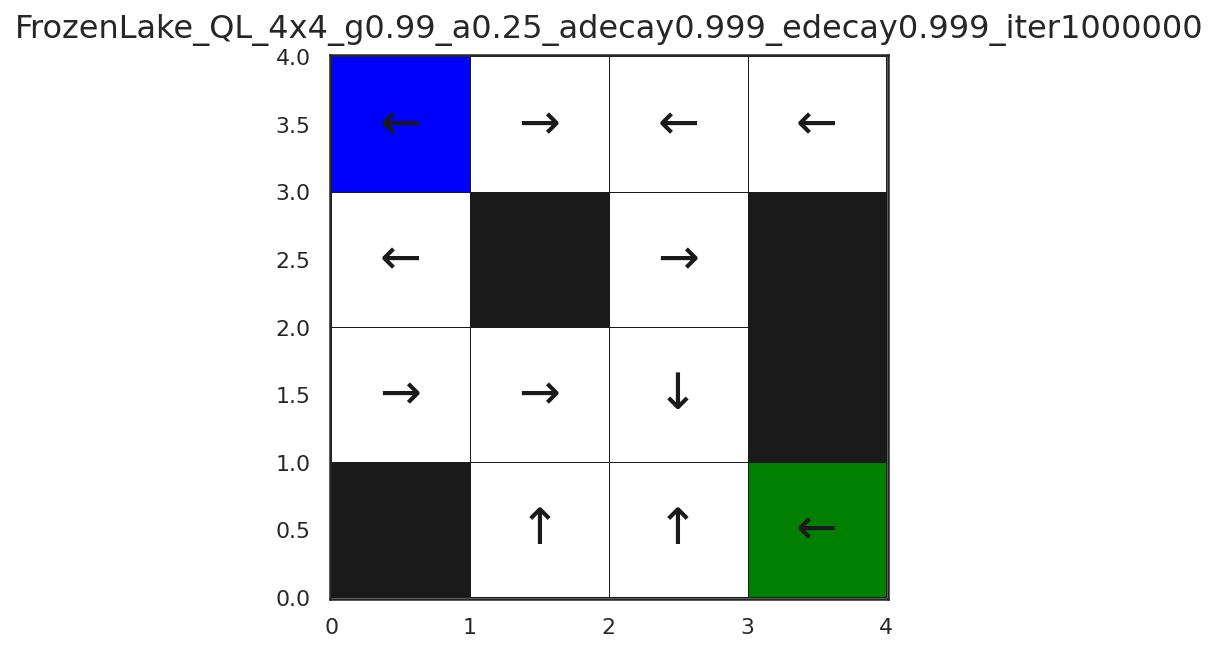

In [501]:
alphas,gammas   = [0.01, 0.15, 0.25], [0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
alpha_dec, epsilon_dec = [0.85, 0.999], [0.85, 0.999]
number_iterations = [10000, 100000, 1000000]

ql_data  = q_learning(T, R, gammas, alphas, alpha_decays=alpha_dec, epsilon_decays=epsilon_dec, n_iterations=number_iterations, show_results=True)

In [502]:
ql_res = ql_data
ql_res.head()

Unnamed: 0  gamma  alpha  alpha_decay  epsilon_decay  iterations  \
0           0    0.1   0.01         0.85          0.850     10000.0   
1           1    0.1   0.01         0.85          0.850    100000.0   
2           2    0.1   0.01         0.85          0.850   1000000.0   
3           3    0.1   0.01         0.85          0.999     10000.0   
4           4    0.1   0.01         0.85          0.999    100000.0   

        time    reward  average_steps  steps_stddev  success_percent  \
0   0.682692  0.000000       0.000000      0.000000              0.0   
1   5.545278  0.102270      22.333333     12.740283             10.8   
2  53.451831  0.312024      11.333333      3.961806              5.7   
3   0.675752  0.000000       0.000000      0.000000              0.0   
4   5.602298  0.051093      13.950000      6.734055              2.0   

                                              policy  \
0  {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  {(0, 3, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 3, 2,...   
2  {(2, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 3,...   
3  {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4  {(0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 3, 3,...   

                                        mean_rewards  \
0  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                         max_rewards     error  
0  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  0.000000  
1  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  0.000002  
2  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  0.000025  
3  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  0.000000  
4  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  0.000001

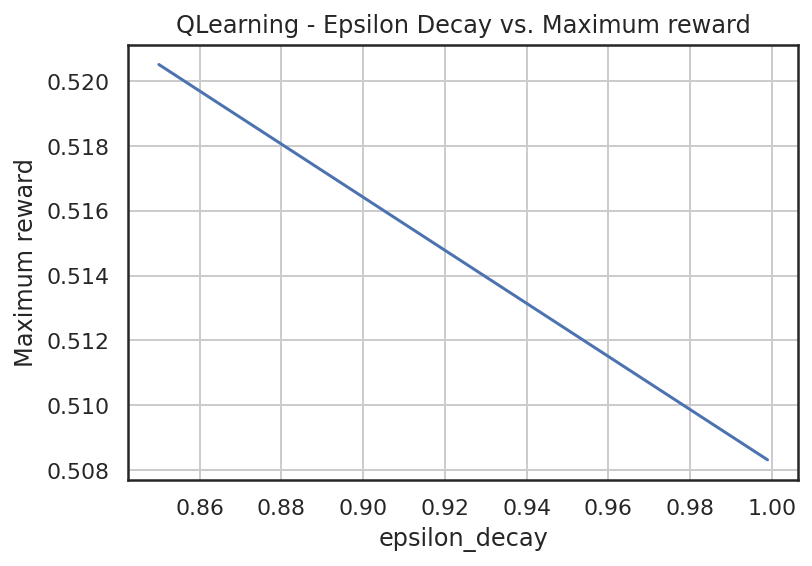

In [508]:
ql_res.groupby('epsilon_decay')['reward'].max().to_frame().plot(legend=False)
plt.xlabel('epsilon_decay')
plt.ylabel('Maximum reward')
plt.grid()
plt.title('QLearning - Epsilon Decay vs. Maximum reward');

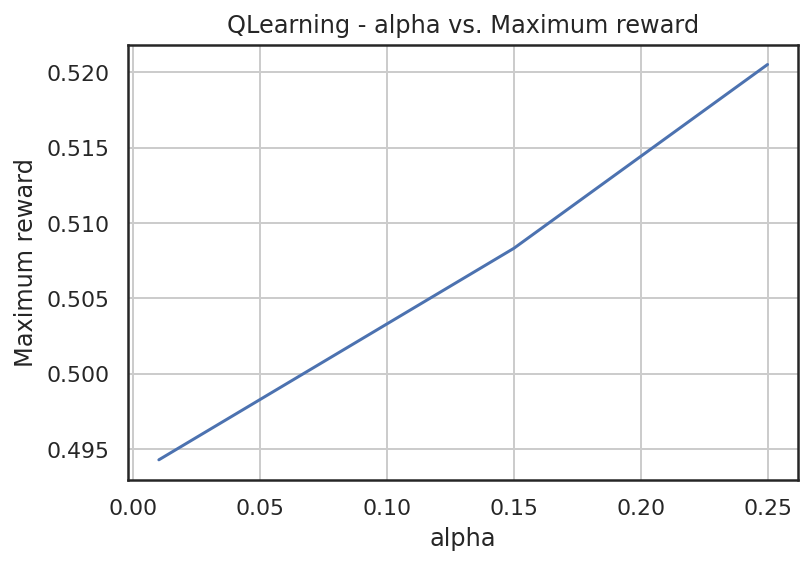

In [509]:
ql_res.groupby('alpha')['reward'].max().to_frame().plot(legend=False)
plt.xlabel('alpha')
plt.ylabel('Maximum reward')
plt.grid()
plt.title('QLearning - alpha vs. Maximum reward');

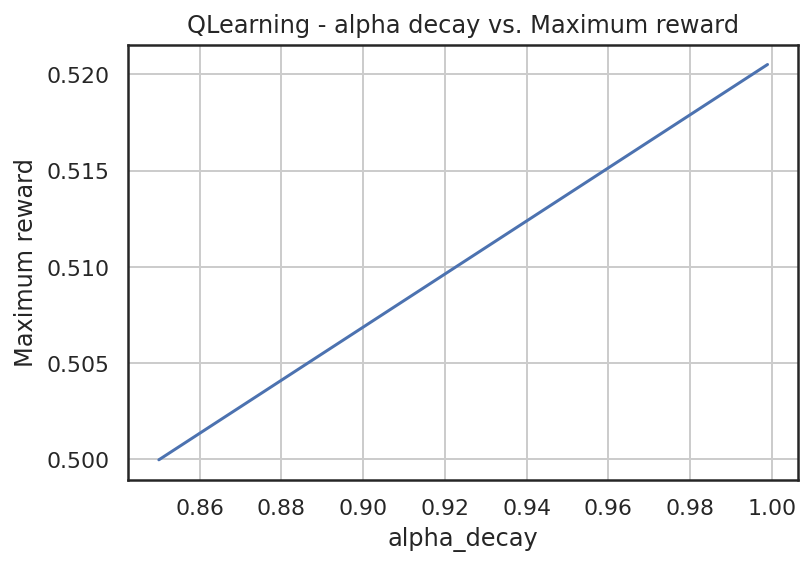

In [510]:
ql_res.groupby('alpha_decay')['reward'].max().to_frame().plot(legend=False)
plt.xlabel('alpha_decay')
plt.ylabel('Maximum reward')
plt.grid()
plt.title('QLearning - alpha decay vs. Maximum reward');

## Res

In [444]:
best_ql_policy = ql_res['policy'][best_run]
best_ql_policy

'{(3, 2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 2, 3, 0)}'

Best Result:
	Success = 78.20
	Gamma = 0.90,
	Alpha = 0.25,
	Alpha Decay: 0.999,
	Epsilon Decay: 0.999,
	Iterations: 1.0E+06


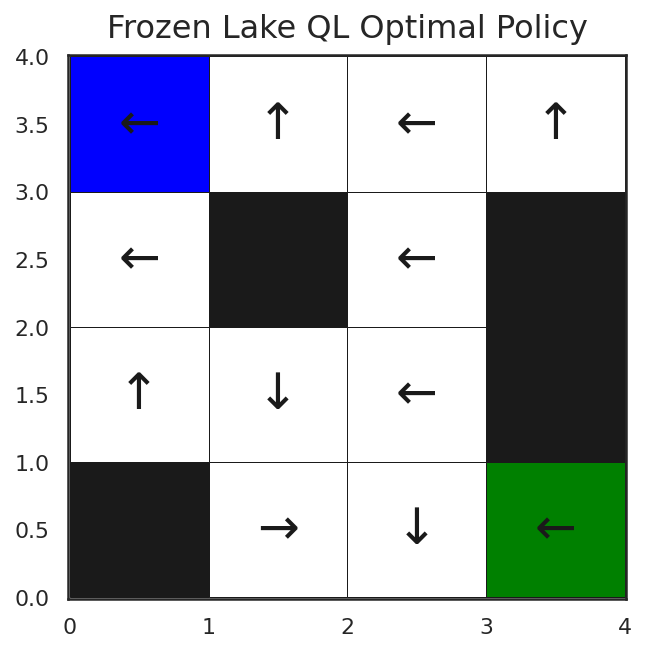

In [445]:
best_run = ql_res['success_percent'].argmax()

best_ql_policy = ql_res['policy'][best_run]

best_ql_policy = best_ql_policy[1:-1]
best_ql_policy = eval(best_ql_policy)
best_ql_policy = np.array(best_ql_policy)
best_ql_policy = best_policy.reshape(rows, cols)

plot_frozen_lake(env, best_ql_policy, title='Frozen Lake QL Optimal Policy')

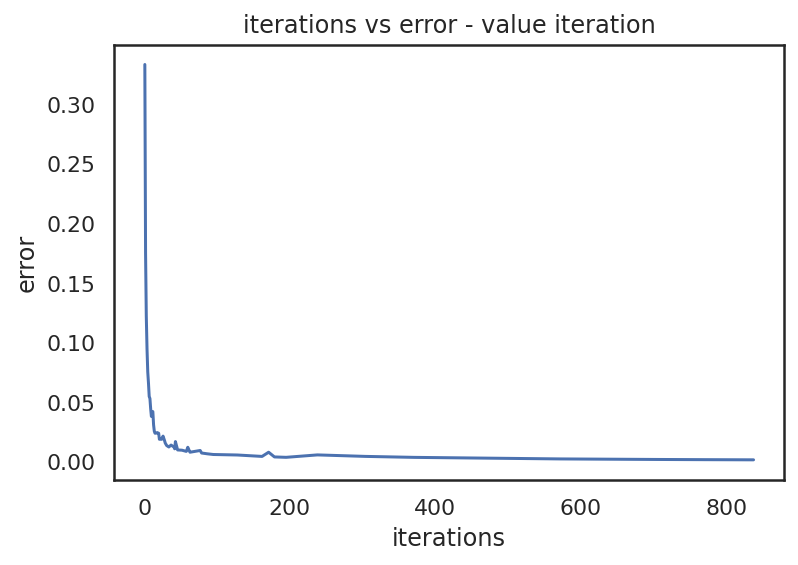

In [529]:
vi_res.groupby('iterations')['error'].mean().plot()
plt.title('iterations vs error - value iteration')
plt.ylabel('error');

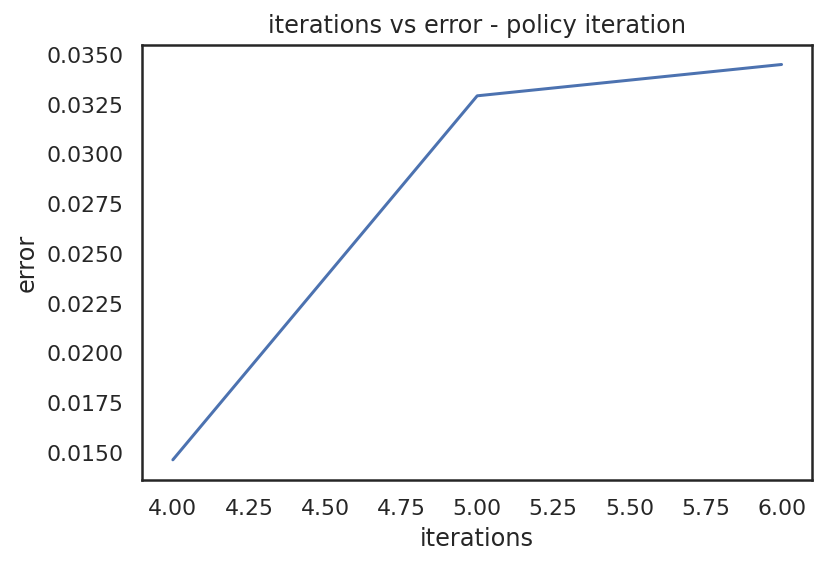

In [530]:
pi_res.groupby('iterations')['error'].mean().plot(label='delta divergence')
plt.title('iterations vs error - policy iteration')
plt.ylabel('error');

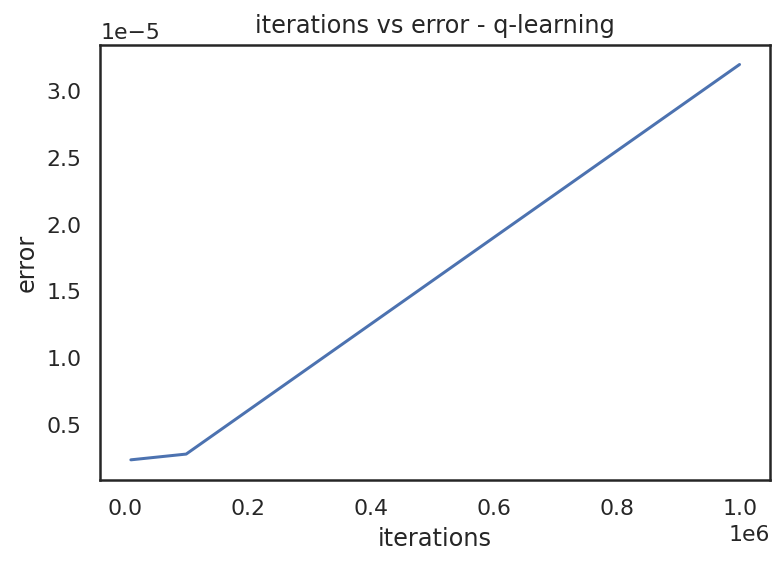

In [531]:
ql_res.groupby('iterations')['error'].mean().plot(label='delta divergence')
plt.title('iterations vs error - q-learning')
plt.ylabel('error');


In [537]:
ql_res.head()

Unnamed: 0  gamma  alpha  alpha_decay  epsilon_decay  iterations  \
0           0    0.1   0.01         0.85          0.850     10000.0   
1           1    0.1   0.01         0.85          0.850    100000.0   
2           2    0.1   0.01         0.85          0.850   1000000.0   
3           3    0.1   0.01         0.85          0.999     10000.0   
4           4    0.1   0.01         0.85          0.999    100000.0   

        time    reward  average_steps  steps_stddev  success_percent  \
0   0.682692  0.000000       0.000000      0.000000              0.0   
1   5.545278  0.102270      22.333333     12.740283             10.8   
2  53.451831  0.312024      11.333333      3.961806              5.7   
3   0.675752  0.000000       0.000000      0.000000              0.0   
4   5.602298  0.051093      13.950000      6.734055              2.0   

                                              policy  \
0  {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  {(0, 3, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 3, 2,...   
2  {(2, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 3,...   
3  {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4  {(0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 3, 3,...   

                                        mean_rewards  \
0  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                         max_rewards     error  
0  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  0.000000  
1  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  0.000002  
2  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  0.000025  
3  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  0.000000  
4  {(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  0.000001

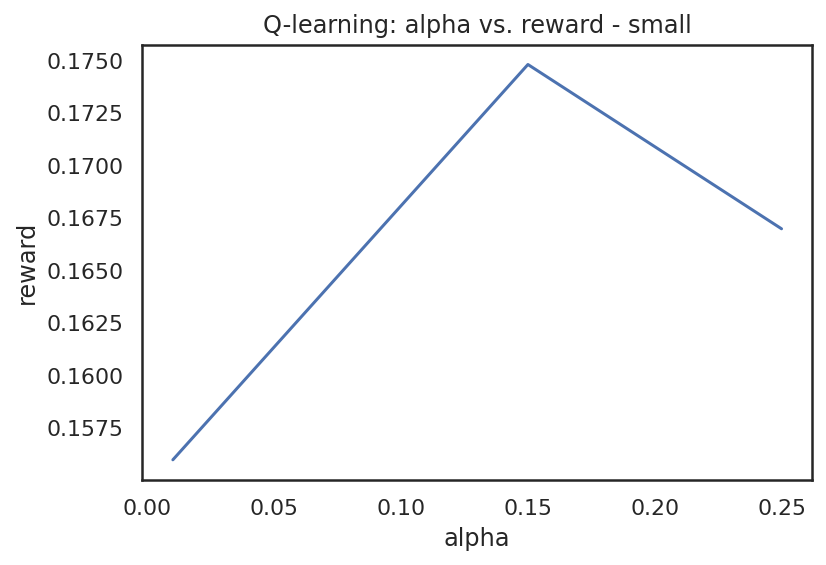

In [552]:
ql_res.groupby('alpha')['reward'].mean().plot()
plt.title('Q-learning: alpha vs. reward - small')
plt.ylabel('reward');

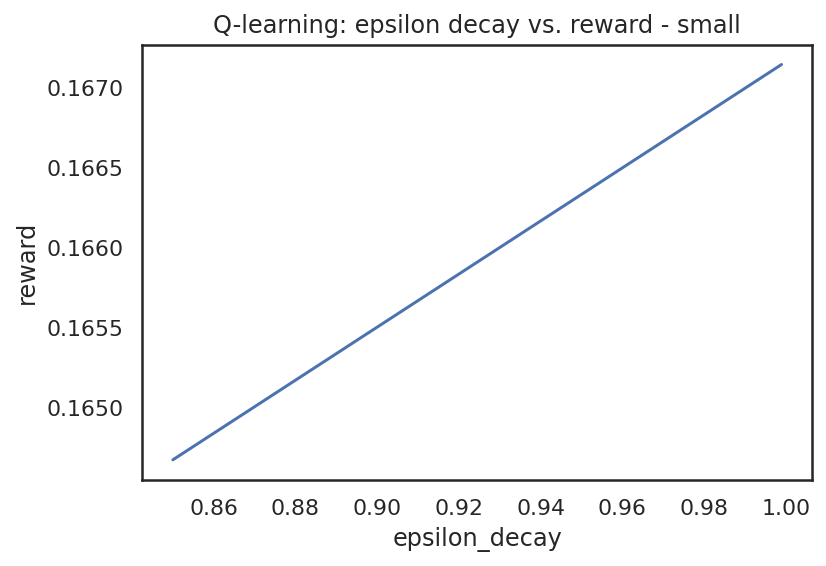

In [551]:
ql_res.groupby('epsilon_decay')['reward'].mean().plot()
plt.title('Q-learning: epsilon decay vs. reward - small')
plt.ylabel('reward');

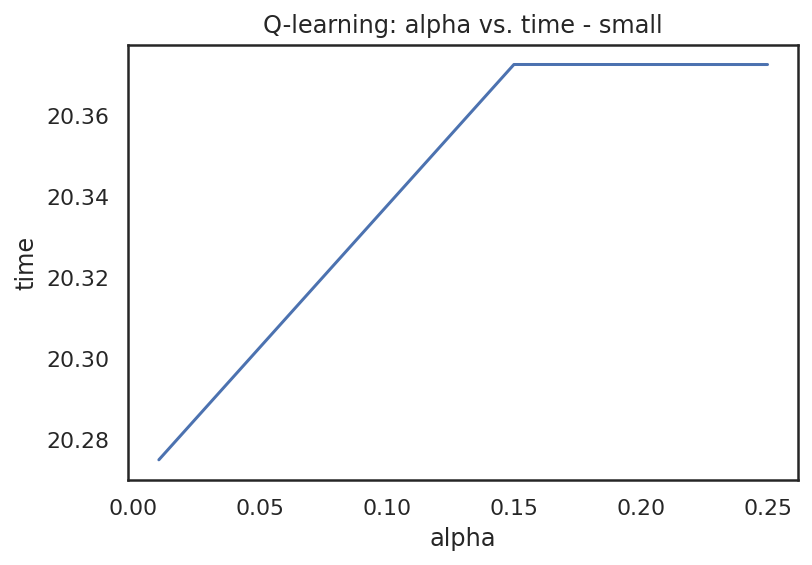

In [550]:
ql_res.groupby('alpha')['time'].mean().plot()
plt.title('Q-learning: alpha vs. time - small')
plt.ylabel('time');

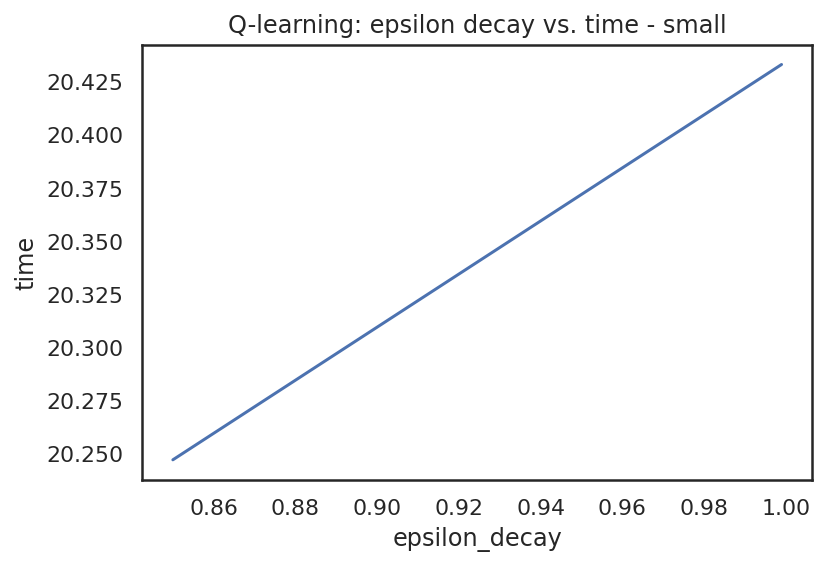

In [549]:
ql_res.groupby('epsilon_decay')['time'].mean().plot()
plt.title('Q-learning: epsilon decay vs. time - small')
plt.ylabel('time');

In [557]:
    alphas,gammas   = [0.01, 0.15, 0.25], [0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
alpha_dec, epsilon_dec = [0.85, 0.999], [0.85, 0.999]

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 20.7 µs


In [ ]:

t0 = time.time()

alphas,gammas   = [0.01, 0.15, 0.25], [0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
alpha_dec, epsilon_dec = [0.85, 0.999], [0.85, 0.999]
number_iterations = [10000, 100000, 1000000]
#''' PROCEED WITH CAUTION >>>> THIS WILL OVERWRITE DATA AND TAKE HOURS

ql_data  = q_learning(T, R, gammas, alphas, alpha_decays=alpha_dec, epsilon_decays=epsilon_dec, n_iterations=number_iterations, show_results=True)
#ql_data.to_csv('frozen/Q_learning_results.csv')
#'''
endTime = time.time() - t0
print(endTime)



Gamma,	Alpha,	Time,	Iter,	Reward

Test Num 1/216
Gamma: 0.10,	Alpha: 0.01,	Alpha Decay:0.850,	Epsilon Decay:0.850,	Iterations:10000
0.10,	0.01,	0.68,	10000,	0.002992
Test Num 2/216
Gamma: 0.10,	Alpha: 0.01,	Alpha Decay:0.850,	Epsilon Decay:0.850,	Iterations:100000
0.10,	0.01,	5.51,	100000,	0.080447
Test Num 3/216
Gamma: 0.10,	Alpha: 0.01,	Alpha Decay:0.850,	Epsilon Decay:0.850,	Iterations:1000000
0.10,	0.01,	52.63,	1000000,	0.330992
Test Num 4/216
Gamma: 0.10,	Alpha: 0.01,	Alpha Decay:0.850,	Epsilon Decay:0.999,	Iterations:10000
0.10,	0.01,	0.67,	10000,	0.003966
Test Num 5/216
Gamma: 0.10,	Alpha: 0.01,	Alpha Decay:0.850,	Epsilon Decay:0.999,	Iterations:100000
0.10,	0.01,	5.58,	100000,	0.055242
Test Num 6/216
Gamma: 0.10,	Alpha: 0.01,	Alpha Decay:0.850,	Epsilon Decay:0.999,	Iterations:1000000
0.10,	0.01,	52.63,	1000000,	0.338111
Test Num 7/216
Gamma: 0.10,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay:0.850,	Iterations:10000
0.10,	0.01,	0.79,	10000,	0.004956
Test Num 8/216
Gamma: 0.10,	

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0.10,	0.15,	0.66,	10000,	0.000000
Test Num 23/216
Gamma: 0.10,	Alpha: 0.15,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:100000
0.10,	0.15,	5.43,	100000,	0.087149
Test Num 24/216
Gamma: 0.10,	Alpha: 0.15,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:1000000
0.25,	0.15,	5.46,	100000,	0.060635
Test Num 54/216
Gamma: 0.25,	Alpha: 0.15,	Alpha Decay:0.850,	Epsilon Decay:0.999,	Iterations:1000000
0.25,	0.15,	52.45,	1000000,	0.344339
Test Num 55/216
Gamma: 0.25,	Alpha: 0.15,	Alpha Decay:0.999,	Epsilon Decay:0.850,	Iterations:10000
0.25,	0.15,	0.65,	10000,	0.000000
Test Num 56/216
Gamma: 0.25,	Alpha: 0.15,	Alpha Decay:0.999,	Epsilon Decay:0.850,	Iterations:100000
0.25,	0.15,	5.50,	100000,	0.057795
Test Num 57/216
Gamma: 0.25,	Alpha: 0.15,	Alpha Decay:0.999,	Epsilon Decay:0.850,	Iterations:1000000
0.25,	0.15,	52.49,	1000000,	0.342152
Test Num 58/216
Gamma: 0.25,	Alpha: 0.15,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:10000
0.25,	0.15,	0.66,	10000,	0.005477
Test Num 59/216
Ga

In [561]:
ql_res['reward'].max()

0.5205126657901745

In [ ]:
vi_res.groupby('gamma')[['reward','iterations']].max()

In [581]:
vi_res.set_index('gamma')[['reward','iterations']]

reward  iterations
gamma                      
0.10   0.333333         1.0
0.10   0.344444         2.0
0.10   0.345185         3.0
0.10   0.345235         4.0
0.10   0.345239         7.0
...         ...         ...
0.99   0.862837       371.0
0.99   0.862837       571.0
0.99   0.862837       704.0
0.99   0.862837       770.0
0.99   0.862837       837.0

[80 rows x 2 columns]

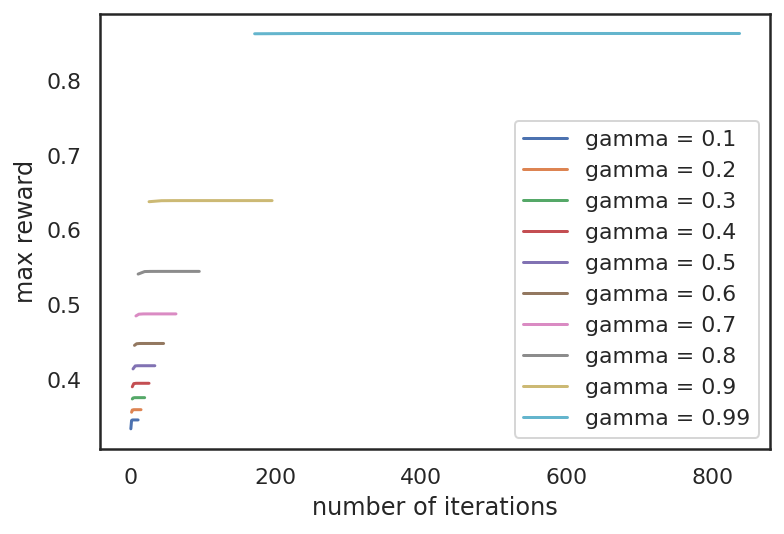

In [597]:
fig, ax = plt.subplots(figsize=(6,4))
for key, grp in vi_res.groupby('gamma')[['reward','iterations']]:
    ax.plot(grp['iterations'], grp['reward'], label='gamma = '+str(key))

ax.legend()
plt.ylabel('max reward')
plt.xlabel('number of iterations')
plt.show()